# Importing Necessary Libraries

In [2]:
import os
import numpy as np
import string
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, plot_model
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.applications.xception import Xception
from tqdm import tqdm
from pickle import dump, load
import argparse
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data cleaning

We are going to define 5 functions for cleaning:

1. load_fp( filename ) – To load the document file and read the contents of the file into a string.
2. mg_capt( filename ) – To create a description dictionary that will map images with all 5 captions.
3. txt_cleaning( descriptions) – This method is used to clean the data by taking all descriptions as input. While dealing with textual data we need to perform several types of cleaning including uppercase to lowercase conversion, punctuation removal, and removal of the number containing words.
4. txt_vocab( descriptions ) – This is used to create a vocabulary from all the unique words extracted out from descriptions.
5. save_descriptions( descriptions, filename ) – This function is used to store all the preprocessed descriptions into a file.

In [3]:

# Load the document file into memory
def load_fp(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        img_id = img[:-2]
        if img_id not in descriptions:
            descriptions[img_id] = [caption]
        else:
            descriptions[img_id].append(caption)
    return descriptions

# Data cleaning function
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # Remove hanging 's and a
            descp = [wrd for wrd in descp if len(wrd) > 1]
            # Remove words containing numbers with them
            descp = [wrd for wrd in descp if wrd.isalpha()]
            # Convert back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

# Build vocab of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# Save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

# Extracting Features Using Xception Model

The extract_features function is designed to efficiently extract deep features from a set of images using the pre-trained Xception model, a robust convolutional neural network. The following outlines the function's operations:

1. **`Directory Validation:`**

The function initiates by confirming the existence of the specified directory. If the directory is not found, a FileNotFoundError is raised to ensure the user is promptly informed.

2. **`Model Initialization:`**
The Xception model is instantiated with the top classification layer excluded and global average pooling applied. This configuration leverages the model’s capacity, pre-trained on the ImageNet dataset, to extract high-level features suitable for various downstream tasks.

3. **`Iterative Image Processing:`**
   - The function iterates over each image file within the provided directory. For every image<br>
        -  The existence of the file is verified to prevent processing errors. If a file is missing, a warning is issued, and the image is skipped.<br>
        -  The image is then opened, resized to 299x299 pixels (the input size required by Xception), and normalized for compatibility with the model's input expectations.
        
4. **`Feature Extraction:`**
The preprocessed image is passed through the Xception model to obtain its deep features. These features are stored in a dictionary, with the corresponding image filename serving as the key.

5. **`Error Handling:`**
The function includes comprehensive error handling to manage any issues that arise during image processing or feature extraction. If an error occurs, it is logged, and the function continues processing the remaining images.

6. **`Return:`**
Upon successful completion, the function returns a dictionary containing the extracted features for each processed image.

In [4]:
def extract_features(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory {directory} does not exist.")

    # Initialize the Xception model
    model = Xception(include_top=False, pooling='avg')
    features = {}

    # Iterate over the images in the directory
    for pic in tqdm(os.listdir(directory)):
        file = os.path.join(directory, pic)
        
        # Check if the file path exists
        if not os.path.exists(file):
            print(f"File {file} does not exist. Skipping...")
            continue
        
        try:
            # Open and preprocess the image
            image = Image.open(file)
            image = image.resize((299, 299))
            image = np.expand_dims(image, axis=0)
            image = image / 127.5 - 1.0

            # Extract features using the model
            feature = model.predict(image)
            features[pic] = feature
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue
    
    return features


# Data Loading and Preparation Functions

This set of functions is responsible for loading and preparing the image captions dataset for further processing and model training:

1. **`load_photos(filename)`**:
   - Loads the list of photo identifiers from a specified file, returning them as a list of strings.

2. **`load_clean_descriptions(filename, photos)`**:
   - Loads and filters the clean descriptions based on the provided photo identifiers. The function organizes the descriptions into a dictionary, where each key is a photo identifier and its value is a list of corresponding captions.

3. **`load_features(photos)`**:
   - Loads precomputed image features from a file and filters them to include only the features corresponding to the provided photo identifiers. The function returns a dictionary mapping photo identifiers to their extracted features.

4. **`dict_to_list(descriptions)`**:
   - Converts the dictionary of descriptions into a list, where each entry is an individual caption. This format is useful for tokenization and further text processing.

5. **`create_tokenizer(descriptions)`**:
   - Creates a tokenizer based on the list of all captions. The tokenizer is fitted on the text data, enabling it to convert text into sequences of integers for model input.

6. **`max_length(descriptions)`**:
   - Calculates the maximum length of the captions in the dataset. This value is crucial for padding sequences to ensure consistent input dimensions for the model.


In [5]:
# Load the data
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    return photos

# Load clean descriptions
def load_clean_descriptions(filename, photos):
    file = load_fp(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)
    return descriptions

# Load features
def load_features(photos):
    all_features = load(open("features.p", "rb"))
    features = {k: all_features[k] for k in photos}
    return features

In [6]:
# Convert dictionary to list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Create tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# Calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

### Sequence Creation Function

The `create_sequences` function generates input-output pairs for training the model. It processes each description by converting it into a sequence of integers using the tokenizer. For each word in the sequence, it creates an input sequence (`in_seq`) consisting of all preceding words and an output word (`out_seq`) representing the next word in the sequence. These sequences are padded to the maximum length and one-hot encoded to match the vocabulary size. The function returns arrays of image features, input sequences, and output words, which are used as inputs to the model.

### Data Generator Function

The `data_generator` function continuously generates batches of data for model training. It iterates through the descriptions and their corresponding image features, utilizing the `create_sequences` function to produce input-output pairs. These pairs are then yielded as input to the model, allowing for efficient memory usage during training.


In [12]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)

# Data generator
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

# Defining the Image Captioning Model

The `define_model` function constructs a neural network model for image captioning by combining features extracted from images with sequences of words from descriptions.

- **Feature Extraction Submodel**: The first input layer (`inputs1`) receives the compressed image features (from 2048 to 256 nodes). These features undergo dropout regularization and are then passed through a dense layer with a ReLU activation function to learn more abstract representations.

- **Sequence Processing Submodel**: The second input layer (`inputs2`) processes sequences of word indices (captions). The sequences are first embedded into dense vectors, followed by dropout regularization and processed through an LSTM layer to capture temporal dependencies.

- **Merging Submodels**: The outputs from both submodels are merged, followed by dense layers with ReLU and softmax activations to generate word predictions. The model is compiled with categorical cross-entropy loss and the Adam optimizer.

- **Model Summary**: The model architecture is printed and visualized using a plot, which is saved as an image.

In [6]:
# Define the captioning model
def define_model(vocab_size, max_length):
    # Features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Compile model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

# Loading and Preprocessing Data for Image Captioning

This code block performs the essential steps to load, preprocess, and prepare data for training an image captioning model.

1. **Define Dataset Paths**: 
   - `dataset_text`: Path to the directory containing text data.
   - `dataset_images`: Path to the directory containing image data.
   - The filename for image captions (`Flickr8k.token.txt`) is constructed by combining `dataset_text` and the file name.

2. **Load and Preprocess Descriptions**:
   - `descriptions`: Loaded using the `img_capt` function, which reads and parses the caption file.
   - The descriptions are then cleaned using the `txt_clean` function, and the vocabulary is extracted using `txt_vocab`.
   - Cleaned descriptions are saved to a file named `descriptions.txt`.

3. **Extract Image Features**:
   - `features`: Extracted from images in the `dataset_images` directory using the `extract_features` function. The features are saved to a file named `features.p`.

4. **Load Training Data**:
   - `train_imgs`: The list of training images is loaded from the file `Flickr_8k.trainImages.txt`.
   - `train_descriptions`: The corresponding descriptions for the training images are loaded using the `load_clean_descriptions` function.
   - `train_features`: The features for the training images are loaded from the saved file `features.p`.

5. **Create Tokenizer**:
   - `tokenizer`: Created using the `create_tokenizer` function based on the cleaned training descriptions. The tokenizer is saved to a file named `tokenizer.p`.
   - The vocabulary size (`vocab_size`) is determined based on the tokenizer's word index.

6. **Determine Maximum Length**:
   - `max_length`: The maximum length of any caption in the dataset is calculated.

7. **Define the Model**:
   - The image captioning model is defined using the `define_model` function, which takes the vocabulary size and the maximum caption length as inputs.

In [13]:
dataset_text = "./Flickr8k_text"
dataset_images = "./Flicker8k_Dataset"
dataset_images[0]
filename =dataset_text + "/" + "Flickr8k.token.txt"
# Load and preprocess data
descriptions = img_capt(filename)
print("Length of descriptions =", len(descriptions))

clean_descriptions = txt_clean(descriptions)
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

save_descriptions(clean_descriptions, "descriptions.txt")

features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

train_imgs = load_photos(os.path.join(dataset_text, "Flickr_8k.trainImages.txt"))
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length(descriptions)

model = define_model(vocab_size, max_length)

Length of descriptions = 8092
Length of vocabulary = 8422


  0%|                                                                                         | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|                                                                               | 1/8091 [00:01<3:22:21,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


  0%|                                                                               | 2/8091 [00:01<1:48:07,  1.25it/s]

1/1 [==============================] - 0s 197ms/step


  0%|                                                                               | 3/8091 [00:02<1:17:40,  1.74it/s]

1/1 [==============================] - 0s 224ms/step


  0%|                                                                               | 4/8091 [00:02<1:05:14,  2.07it/s]

1/1 [==============================] - 0s 235ms/step


  0%|                                                                                 | 5/8091 [00:02<58:46,  2.29it/s]

1/1 [==============================] - 0s 199ms/step


  0%|                                                                                 | 6/8091 [00:03<52:57,  2.54it/s]

1/1 [==============================] - 0s 203ms/step


  0%|                                                                                 | 7/8091 [00:03<49:43,  2.71it/s]

1/1 [==============================] - 0s 184ms/step


  0%|                                                                                 | 8/8091 [00:03<46:48,  2.88it/s]

1/1 [==============================] - 0s 228ms/step


  0%|                                                                                 | 9/8091 [00:04<46:57,  2.87it/s]

1/1 [==============================] - 0s 197ms/step


  0%|                                                                                | 10/8091 [00:04<45:21,  2.97it/s]

1/1 [==============================] - 0s 219ms/step


  0%|                                                                                | 11/8091 [00:04<45:34,  2.95it/s]

1/1 [==============================] - 0s 211ms/step


  0%|                                                                                | 12/8091 [00:05<44:55,  3.00it/s]

1/1 [==============================] - 0s 217ms/step


  0%|▏                                                                               | 13/8091 [00:05<45:18,  2.97it/s]

1/1 [==============================] - 0s 219ms/step


  0%|▏                                                                               | 14/8091 [00:05<46:05,  2.92it/s]

1/1 [==============================] - 0s 208ms/step


  0%|▏                                                                               | 15/8091 [00:06<45:38,  2.95it/s]

1/1 [==============================] - 0s 222ms/step


  0%|▏                                                                               | 16/8091 [00:06<45:41,  2.95it/s]

1/1 [==============================] - 0s 237ms/step


  0%|▏                                                                               | 17/8091 [00:06<46:17,  2.91it/s]

1/1 [==============================] - 0s 208ms/step


  0%|▏                                                                               | 18/8091 [00:07<45:41,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


  0%|▏                                                                               | 19/8091 [00:07<46:14,  2.91it/s]

1/1 [==============================] - 0s 208ms/step


  0%|▏                                                                               | 20/8091 [00:07<45:43,  2.94it/s]

1/1 [==============================] - 0s 252ms/step


  0%|▏                                                                               | 21/8091 [00:08<47:24,  2.84it/s]

1/1 [==============================] - 0s 237ms/step


  0%|▏                                                                               | 22/8091 [00:08<48:03,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


  0%|▏                                                                               | 23/8091 [00:08<48:46,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


  0%|▏                                                                               | 24/8091 [00:09<48:50,  2.75it/s]

1/1 [==============================] - 0s 219ms/step


  0%|▏                                                                               | 25/8091 [00:09<47:45,  2.81it/s]

1/1 [==============================] - 0s 251ms/step


  0%|▎                                                                               | 26/8091 [00:10<48:23,  2.78it/s]

1/1 [==============================] - 0s 241ms/step


  0%|▎                                                                               | 27/8091 [00:10<48:23,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


  0%|▎                                                                               | 28/8091 [00:10<48:16,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


  0%|▎                                                                               | 29/8091 [00:11<48:44,  2.76it/s]

1/1 [==============================] - 0s 207ms/step


  0%|▎                                                                               | 30/8091 [00:11<47:05,  2.85it/s]

1/1 [==============================] - 0s 177ms/step


  0%|▎                                                                               | 31/8091 [00:11<45:20,  2.96it/s]

1/1 [==============================] - 0s 178ms/step


  0%|▎                                                                               | 32/8091 [00:12<43:53,  3.06it/s]

1/1 [==============================] - 0s 195ms/step


  0%|▎                                                                               | 33/8091 [00:12<43:47,  3.07it/s]

1/1 [==============================] - 0s 218ms/step


  0%|▎                                                                               | 34/8091 [00:12<44:01,  3.05it/s]

1/1 [==============================] - 0s 254ms/step


  0%|▎                                                                               | 35/8091 [00:13<46:38,  2.88it/s]

1/1 [==============================] - 0s 235ms/step


  0%|▎                                                                               | 36/8091 [00:13<48:21,  2.78it/s]

1/1 [==============================] - 0s 292ms/step


  0%|▎                                                                               | 37/8091 [00:13<52:20,  2.56it/s]

1/1 [==============================] - 0s 295ms/step


  0%|▍                                                                               | 38/8091 [00:14<54:46,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


  0%|▍                                                                               | 39/8091 [00:14<55:26,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


  0%|▍                                                                               | 40/8091 [00:15<55:41,  2.41it/s]

1/1 [==============================] - 0s 255ms/step


  1%|▍                                                                               | 41/8091 [00:15<55:21,  2.42it/s]

1/1 [==============================] - 0s 279ms/step


  1%|▍                                                                               | 42/8091 [00:16<56:20,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


  1%|▍                                                                               | 43/8091 [00:16<55:14,  2.43it/s]

1/1 [==============================] - 0s 250ms/step


  1%|▍                                                                               | 44/8091 [00:16<54:53,  2.44it/s]

1/1 [==============================] - 0s 221ms/step


  1%|▍                                                                               | 45/8091 [00:17<52:57,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


  1%|▍                                                                               | 46/8091 [00:17<53:34,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


  1%|▍                                                                               | 47/8091 [00:18<53:54,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


  1%|▍                                                                               | 48/8091 [00:18<54:22,  2.47it/s]

1/1 [==============================] - 0s 228ms/step


  1%|▍                                                                               | 49/8091 [00:18<53:50,  2.49it/s]

1/1 [==============================] - 0s 278ms/step


  1%|▍                                                                               | 50/8091 [00:19<54:28,  2.46it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▌                                                                               | 51/8091 [00:19<52:34,  2.55it/s]

1/1 [==============================] - 0s 283ms/step


  1%|▌                                                                               | 52/8091 [00:20<55:04,  2.43it/s]

1/1 [==============================] - 0s 236ms/step


  1%|▌                                                                               | 53/8091 [00:20<54:20,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


  1%|▌                                                                               | 54/8091 [00:20<54:42,  2.45it/s]

1/1 [==============================] - 0s 293ms/step


  1%|▌                                                                               | 55/8091 [00:21<56:02,  2.39it/s]

1/1 [==============================] - 0s 218ms/step


  1%|▌                                                                               | 56/8091 [00:21<53:40,  2.49it/s]

1/1 [==============================] - 0s 237ms/step


  1%|▌                                                                               | 57/8091 [00:22<53:13,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


  1%|▌                                                                               | 58/8091 [00:22<53:51,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


  1%|▌                                                                               | 59/8091 [00:22<54:43,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


  1%|▌                                                                               | 60/8091 [00:23<55:26,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


  1%|▌                                                                               | 61/8091 [00:23<55:20,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


  1%|▌                                                                               | 62/8091 [00:24<56:19,  2.38it/s]

1/1 [==============================] - 0s 250ms/step


  1%|▌                                                                               | 63/8091 [00:24<55:35,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


  1%|▋                                                                               | 64/8091 [00:25<55:51,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


  1%|▋                                                                               | 65/8091 [00:25<56:08,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


  1%|▋                                                                               | 66/8091 [00:25<56:03,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


  1%|▋                                                                               | 67/8091 [00:26<56:27,  2.37it/s]

1/1 [==============================] - 0s 256ms/step


  1%|▋                                                                               | 68/8091 [00:26<55:40,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


  1%|▋                                                                               | 69/8091 [00:27<55:42,  2.40it/s]

1/1 [==============================] - 0s 265ms/step


  1%|▋                                                                               | 70/8091 [00:27<56:03,  2.38it/s]

1/1 [==============================] - 0s 210ms/step


  1%|▋                                                                               | 71/8091 [00:27<53:40,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


  1%|▋                                                                               | 72/8091 [00:28<53:30,  2.50it/s]

1/1 [==============================] - 0s 214ms/step


  1%|▋                                                                               | 73/8091 [00:28<52:46,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


  1%|▋                                                                               | 74/8091 [00:29<53:04,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


  1%|▋                                                                               | 75/8091 [00:29<53:18,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


  1%|▊                                                                               | 76/8091 [00:29<53:54,  2.48it/s]

1/1 [==============================] - 0s 225ms/step


  1%|▊                                                                               | 77/8091 [00:30<52:50,  2.53it/s]

1/1 [==============================] - 0s 223ms/step


  1%|▊                                                                               | 78/8091 [00:30<51:45,  2.58it/s]

1/1 [==============================] - 0s 222ms/step


  1%|▊                                                                               | 79/8091 [00:31<51:21,  2.60it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▊                                                                               | 80/8091 [00:31<50:21,  2.65it/s]

1/1 [==============================] - 0s 287ms/step


  1%|▊                                                                               | 81/8091 [00:31<52:06,  2.56it/s]

1/1 [==============================] - 0s 223ms/step


  1%|▊                                                                               | 82/8091 [00:32<51:14,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


  1%|▊                                                                               | 83/8091 [00:32<52:07,  2.56it/s]

1/1 [==============================] - 0s 218ms/step


  1%|▊                                                                               | 84/8091 [00:32<51:22,  2.60it/s]

1/1 [==============================] - 0s 215ms/step


  1%|▊                                                                               | 85/8091 [00:33<50:35,  2.64it/s]

1/1 [==============================] - 0s 281ms/step


  1%|▊                                                                               | 86/8091 [00:33<52:28,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


  1%|▊                                                                               | 87/8091 [00:34<51:15,  2.60it/s]

1/1 [==============================] - 0s 224ms/step


  1%|▊                                                                               | 88/8091 [00:34<50:37,  2.63it/s]

1/1 [==============================] - 0s 211ms/step


  1%|▉                                                                               | 89/8091 [00:35<57:25,  2.32it/s]

1/1 [==============================] - 0s 222ms/step


  1%|▉                                                                               | 90/8091 [00:35<55:13,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


  1%|▉                                                                               | 91/8091 [00:35<55:38,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


  1%|▉                                                                               | 92/8091 [00:36<55:12,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


  1%|▉                                                                               | 93/8091 [00:36<54:42,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


  1%|▉                                                                               | 94/8091 [00:37<54:50,  2.43it/s]

1/1 [==============================] - 0s 249ms/step


  1%|▉                                                                               | 95/8091 [00:37<54:22,  2.45it/s]

1/1 [==============================] - 0s 270ms/step


  1%|▉                                                                               | 96/8091 [00:37<54:57,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


  1%|▉                                                                               | 97/8091 [00:38<54:31,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


  1%|▉                                                                               | 98/8091 [00:38<52:47,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


  1%|▉                                                                               | 99/8091 [00:39<53:34,  2.49it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▉                                                                              | 100/8091 [00:39<51:54,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


  1%|▉                                                                              | 101/8091 [00:39<52:56,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


  1%|▉                                                                              | 102/8091 [00:40<51:57,  2.56it/s]

1/1 [==============================] - 0s 218ms/step


  1%|█                                                                              | 103/8091 [00:40<51:07,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


  1%|█                                                                              | 104/8091 [00:40<51:54,  2.56it/s]

1/1 [==============================] - 0s 221ms/step


  1%|█                                                                              | 105/8091 [00:41<51:08,  2.60it/s]

1/1 [==============================] - 0s 220ms/step


  1%|█                                                                              | 106/8091 [00:41<50:36,  2.63it/s]

1/1 [==============================] - 0s 227ms/step


  1%|█                                                                              | 107/8091 [00:42<50:13,  2.65it/s]

1/1 [==============================] - 0s 222ms/step


  1%|█                                                                              | 108/8091 [00:42<50:05,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


  1%|█                                                                              | 109/8091 [00:42<51:25,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


  1%|█                                                                              | 110/8091 [00:43<50:59,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


  1%|█                                                                              | 111/8091 [00:43<51:43,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


  1%|█                                                                              | 112/8091 [00:44<51:56,  2.56it/s]

1/1 [==============================] - 0s 218ms/step


  1%|█                                                                              | 113/8091 [00:44<51:22,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


  1%|█                                                                              | 114/8091 [00:44<51:47,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


  1%|█                                                                              | 115/8091 [00:45<50:21,  2.64it/s]

1/1 [==============================] - 0s 211ms/step


  1%|█▏                                                                             | 116/8091 [00:45<49:48,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


  1%|█▏                                                                             | 117/8091 [00:45<51:21,  2.59it/s]

1/1 [==============================] - 0s 213ms/step


  1%|█▏                                                                             | 118/8091 [00:46<50:06,  2.65it/s]

1/1 [==============================] - 0s 219ms/step


  1%|█▏                                                                             | 119/8091 [00:46<49:45,  2.67it/s]

1/1 [==============================] - 0s 211ms/step


  1%|█▏                                                                             | 120/8091 [00:47<49:10,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


  1%|█▏                                                                             | 121/8091 [00:47<50:47,  2.62it/s]

1/1 [==============================] - 0s 215ms/step


  2%|█▏                                                                             | 122/8091 [00:47<50:17,  2.64it/s]

1/1 [==============================] - 0s 228ms/step


  2%|█▏                                                                             | 123/8091 [00:48<49:58,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


  2%|█▏                                                                             | 124/8091 [00:48<51:01,  2.60it/s]

1/1 [==============================] - 0s 219ms/step


  2%|█▏                                                                             | 125/8091 [00:48<50:17,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


  2%|█▏                                                                             | 126/8091 [00:49<51:31,  2.58it/s]

1/1 [==============================] - 0s 217ms/step


  2%|█▏                                                                             | 127/8091 [00:49<50:44,  2.62it/s]

1/1 [==============================] - 0s 269ms/step


  2%|█▏                                                                             | 128/8091 [00:50<52:17,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


  2%|█▎                                                                             | 129/8091 [00:50<52:57,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


  2%|█▎                                                                             | 130/8091 [00:50<53:01,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


  2%|█▎                                                                             | 131/8091 [00:51<51:30,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


  2%|█▎                                                                             | 132/8091 [00:51<50:21,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


  2%|█▎                                                                             | 133/8091 [00:52<51:33,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


  2%|█▎                                                                             | 134/8091 [00:52<52:40,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


  2%|█▎                                                                             | 135/8091 [00:52<52:50,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


  2%|█▎                                                                             | 136/8091 [00:53<53:09,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


  2%|█▎                                                                             | 137/8091 [00:53<51:46,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


  2%|█▎                                                                             | 138/8091 [00:54<52:13,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


  2%|█▎                                                                             | 139/8091 [00:54<53:09,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


  2%|█▎                                                                             | 140/8091 [00:54<51:18,  2.58it/s]

1/1 [==============================] - 0s 221ms/step


  2%|█▍                                                                             | 141/8091 [00:55<50:41,  2.61it/s]

1/1 [==============================] - 0s 218ms/step


  2%|█▍                                                                             | 142/8091 [00:55<50:10,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


  2%|█▍                                                                             | 143/8091 [00:56<51:12,  2.59it/s]

1/1 [==============================] - 0s 236ms/step


  2%|█▍                                                                             | 144/8091 [00:56<50:56,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


  2%|█▍                                                                             | 145/8091 [00:56<51:46,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


  2%|█▍                                                                             | 146/8091 [00:57<51:00,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  2%|█▍                                                                             | 147/8091 [00:57<52:13,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


  2%|█▍                                                                             | 148/8091 [00:57<51:09,  2.59it/s]

1/1 [==============================] - 0s 215ms/step


  2%|█▍                                                                             | 149/8091 [00:58<50:38,  2.61it/s]

1/1 [==============================] - 0s 223ms/step


  2%|█▍                                                                             | 150/8091 [00:58<49:54,  2.65it/s]

1/1 [==============================] - 0s 207ms/step


  2%|█▍                                                                             | 151/8091 [00:59<48:58,  2.70it/s]

1/1 [==============================] - 0s 219ms/step


  2%|█▍                                                                             | 152/8091 [00:59<49:07,  2.69it/s]

1/1 [==============================] - 0s 218ms/step


  2%|█▍                                                                             | 153/8091 [00:59<48:55,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


  2%|█▌                                                                             | 154/8091 [01:00<50:29,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


  2%|█▌                                                                             | 155/8091 [01:00<51:55,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


  2%|█▌                                                                             | 156/8091 [01:01<52:32,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


  2%|█▌                                                                             | 157/8091 [01:01<51:34,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


  2%|█▌                                                                             | 158/8091 [01:01<51:39,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


  2%|█▌                                                                             | 159/8091 [01:02<52:22,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


  2%|█▌                                                                             | 160/8091 [01:02<53:06,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


  2%|█▌                                                                             | 161/8091 [01:03<53:36,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


  2%|█▌                                                                             | 162/8091 [01:03<54:06,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


  2%|█▌                                                                             | 163/8091 [01:03<54:05,  2.44it/s]

1/1 [==============================] - 0s 220ms/step


  2%|█▌                                                                             | 164/8091 [01:04<52:39,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


  2%|█▌                                                                             | 165/8091 [01:04<53:16,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


  2%|█▌                                                                             | 166/8091 [01:05<53:07,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                             | 167/8091 [01:05<51:19,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


  2%|█▋                                                                             | 168/8091 [01:05<50:43,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  2%|█▋                                                                             | 169/8091 [01:06<52:01,  2.54it/s]

1/1 [==============================] - 0s 242ms/step


  2%|█▋                                                                             | 170/8091 [01:06<51:45,  2.55it/s]

1/1 [==============================] - 0s 211ms/step


  2%|█▋                                                                             | 171/8091 [01:06<49:50,  2.65it/s]

1/1 [==============================] - 0s 224ms/step


  2%|█▋                                                                             | 172/8091 [01:07<49:31,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


  2%|█▋                                                                             | 173/8091 [01:07<50:44,  2.60it/s]

1/1 [==============================] - 0s 218ms/step


  2%|█▋                                                                             | 174/8091 [01:08<50:01,  2.64it/s]

1/1 [==============================] - 0s 206ms/step


  2%|█▋                                                                             | 175/8091 [01:08<49:07,  2.69it/s]

1/1 [==============================] - 0s 238ms/step


  2%|█▋                                                                             | 176/8091 [01:08<49:46,  2.65it/s]

1/1 [==============================] - 0s 214ms/step


  2%|█▋                                                                             | 177/8091 [01:09<48:51,  2.70it/s]

1/1 [==============================] - 0s 225ms/step


  2%|█▋                                                                             | 178/8091 [01:09<49:05,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


  2%|█▋                                                                             | 179/8091 [01:09<49:52,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


  2%|█▊                                                                             | 180/8091 [01:10<50:48,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


  2%|█▊                                                                             | 181/8091 [01:10<51:53,  2.54it/s]

1/1 [==============================] - 0s 269ms/step


  2%|█▊                                                                             | 182/8091 [01:11<52:44,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


  2%|█▊                                                                             | 183/8091 [01:11<51:26,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


  2%|█▊                                                                             | 184/8091 [01:11<52:27,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


  2%|█▊                                                                             | 185/8091 [01:12<53:01,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


  2%|█▊                                                                             | 186/8091 [01:12<53:22,  2.47it/s]

1/1 [==============================] - 0s 257ms/step


  2%|█▊                                                                             | 187/8091 [01:13<53:31,  2.46it/s]

1/1 [==============================] - 0s 208ms/step


  2%|█▊                                                                             | 188/8091 [01:13<51:52,  2.54it/s]

1/1 [==============================] - 0s 226ms/step


  2%|█▊                                                                             | 189/8091 [01:13<51:19,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


  2%|█▊                                                                             | 190/8091 [01:14<51:14,  2.57it/s]

1/1 [==============================] - 1s 594ms/step


  2%|█▊                                                                           | 191/8091 [01:15<1:05:15,  2.02it/s]

1/1 [==============================] - 0s 218ms/step


  2%|█▊                                                                           | 192/8091 [01:15<1:00:07,  2.19it/s]

1/1 [==============================] - 0s 212ms/step


  2%|█▉                                                                             | 193/8091 [01:15<56:12,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


  2%|█▉                                                                             | 194/8091 [01:16<54:30,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


  2%|█▉                                                                             | 195/8091 [01:16<54:26,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


  2%|█▉                                                                             | 196/8091 [01:16<54:12,  2.43it/s]

1/1 [==============================] - 0s 259ms/step


  2%|█▉                                                                             | 197/8091 [01:17<54:03,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


  2%|█▉                                                                             | 198/8091 [01:17<53:58,  2.44it/s]

1/1 [==============================] - 0s 206ms/step


  2%|█▉                                                                             | 199/8091 [01:18<51:29,  2.55it/s]

1/1 [==============================] - 0s 216ms/step


  2%|█▉                                                                             | 200/8091 [01:18<50:37,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  2%|█▉                                                                             | 201/8091 [01:18<51:25,  2.56it/s]

1/1 [==============================] - 0s 223ms/step


  2%|█▉                                                                             | 202/8091 [01:19<50:28,  2.60it/s]

1/1 [==============================] - 0s 215ms/step


  3%|█▉                                                                             | 203/8091 [01:19<49:55,  2.63it/s]

1/1 [==============================] - 0s 237ms/step


  3%|█▉                                                                             | 204/8091 [01:20<50:20,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


  3%|██                                                                             | 205/8091 [01:20<51:29,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


  3%|██                                                                             | 206/8091 [01:20<51:55,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


  3%|██                                                                             | 207/8091 [01:21<52:20,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


  3%|██                                                                             | 208/8091 [01:21<52:14,  2.52it/s]

1/1 [==============================] - 0s 221ms/step


  3%|██                                                                             | 209/8091 [01:22<51:12,  2.57it/s]

1/1 [==============================] - 0s 218ms/step


  3%|██                                                                             | 210/8091 [01:22<50:21,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


  3%|██                                                                             | 211/8091 [01:22<51:29,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


  3%|██                                                                             | 212/8091 [01:23<52:11,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


  3%|██                                                                             | 213/8091 [01:23<51:30,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


  3%|██                                                                             | 214/8091 [01:24<52:13,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


  3%|██                                                                             | 215/8091 [01:24<52:31,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


  3%|██                                                                             | 216/8091 [01:24<53:13,  2.47it/s]

1/1 [==============================] - 0s 222ms/step


  3%|██                                                                             | 217/8091 [01:25<51:58,  2.53it/s]

1/1 [==============================] - 0s 289ms/step


  3%|██▏                                                                            | 218/8091 [01:25<53:41,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


  3%|██▏                                                                            | 219/8091 [01:26<52:05,  2.52it/s]

1/1 [==============================] - 0s 227ms/step


  3%|██▏                                                                            | 220/8091 [01:26<51:08,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


  3%|██▏                                                                            | 221/8091 [01:26<51:36,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


  3%|██▏                                                                            | 222/8091 [01:27<50:42,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


  3%|██▏                                                                            | 223/8091 [01:27<51:47,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


  3%|██▏                                                                            | 224/8091 [01:27<52:31,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


  3%|██▏                                                                            | 225/8091 [01:28<51:13,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


  3%|██▏                                                                            | 226/8091 [01:28<52:05,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


  3%|██▏                                                                            | 227/8091 [01:29<50:34,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


  3%|██▏                                                                            | 228/8091 [01:29<51:48,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


  3%|██▏                                                                            | 229/8091 [01:29<52:05,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


  3%|██▏                                                                            | 230/8091 [01:30<52:51,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


  3%|██▎                                                                            | 231/8091 [01:30<51:00,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


  3%|██▎                                                                            | 232/8091 [01:31<51:36,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


  3%|██▎                                                                            | 233/8091 [01:31<50:44,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


  3%|██▎                                                                            | 234/8091 [01:31<51:22,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


  3%|██▎                                                                            | 235/8091 [01:32<52:11,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


  3%|██▎                                                                            | 236/8091 [01:32<52:47,  2.48it/s]

1/1 [==============================] - 0s 207ms/step


  3%|██▎                                                                            | 237/8091 [01:33<50:57,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


  3%|██▎                                                                            | 238/8091 [01:33<51:28,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


  3%|██▎                                                                            | 239/8091 [01:33<52:02,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


  3%|██▎                                                                            | 240/8091 [01:34<52:02,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


  3%|██▎                                                                            | 241/8091 [01:34<52:39,  2.48it/s]

1/1 [==============================] - 0s 220ms/step


  3%|██▎                                                                            | 242/8091 [01:35<51:29,  2.54it/s]

1/1 [==============================] - 0s 237ms/step


  3%|██▎                                                                            | 243/8091 [01:35<51:15,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


  3%|██▍                                                                            | 244/8091 [01:35<49:49,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


  3%|██▍                                                                            | 245/8091 [01:36<51:02,  2.56it/s]

1/1 [==============================] - 0s 225ms/step


  3%|██▍                                                                            | 246/8091 [01:36<50:18,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


  3%|██▍                                                                            | 247/8091 [01:37<50:57,  2.57it/s]

1/1 [==============================] - 0s 211ms/step


  3%|██▍                                                                            | 248/8091 [01:37<49:41,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


  3%|██▍                                                                            | 249/8091 [01:37<51:02,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


  3%|██▍                                                                            | 250/8091 [01:38<50:06,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


  3%|██▍                                                                            | 251/8091 [01:38<51:50,  2.52it/s]

1/1 [==============================] - 0s 220ms/step


  3%|██▍                                                                            | 252/8091 [01:38<50:56,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


  3%|██▍                                                                            | 253/8091 [01:39<51:42,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


  3%|██▍                                                                            | 254/8091 [01:39<52:30,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


  3%|██▍                                                                            | 255/8091 [01:40<50:54,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


  3%|██▍                                                                            | 256/8091 [01:40<51:36,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


  3%|██▌                                                                            | 257/8091 [01:40<50:40,  2.58it/s]

1/1 [==============================] - 0s 232ms/step


  3%|██▌                                                                            | 258/8091 [01:41<49:55,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


  3%|██▌                                                                            | 259/8091 [01:41<50:42,  2.57it/s]

1/1 [==============================] - 0s 239ms/step


  3%|██▌                                                                            | 260/8091 [01:42<50:51,  2.57it/s]

1/1 [==============================] - 0s 224ms/step


  3%|██▌                                                                            | 261/8091 [01:42<50:08,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  3%|██▌                                                                            | 262/8091 [01:42<50:37,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


  3%|██▌                                                                            | 263/8091 [01:43<51:12,  2.55it/s]

1/1 [==============================] - 0s 216ms/step


  3%|██▌                                                                            | 264/8091 [01:43<50:00,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


  3%|██▌                                                                            | 265/8091 [01:44<51:01,  2.56it/s]

1/1 [==============================] - 0s 216ms/step


  3%|██▌                                                                            | 266/8091 [01:44<50:14,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


  3%|██▌                                                                            | 267/8091 [01:44<51:39,  2.52it/s]

1/1 [==============================] - 0s 232ms/step


  3%|██▌                                                                            | 268/8091 [01:45<50:56,  2.56it/s]

1/1 [==============================] - 0s 212ms/step


  3%|██▋                                                                            | 269/8091 [01:45<50:07,  2.60it/s]

1/1 [==============================] - 0s 224ms/step


  3%|██▋                                                                            | 270/8091 [01:45<49:54,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


  3%|██▋                                                                            | 271/8091 [01:46<50:16,  2.59it/s]

1/1 [==============================] - 0s 270ms/step


  3%|██▋                                                                            | 272/8091 [01:46<51:33,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


  3%|██▋                                                                            | 273/8091 [01:47<51:05,  2.55it/s]

1/1 [==============================] - 0s 229ms/step


  3%|██▋                                                                            | 274/8091 [01:47<50:24,  2.58it/s]

1/1 [==============================] - 0s 252ms/step


  3%|██▋                                                                            | 275/8091 [01:47<51:07,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


  3%|██▋                                                                            | 276/8091 [01:48<50:09,  2.60it/s]

1/1 [==============================] - 0s 225ms/step


  3%|██▋                                                                            | 277/8091 [01:48<50:08,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


  3%|██▋                                                                            | 278/8091 [01:49<50:54,  2.56it/s]

1/1 [==============================] - 0s 212ms/step


  3%|██▋                                                                            | 279/8091 [01:49<49:35,  2.63it/s]

1/1 [==============================] - 0s 221ms/step


  3%|██▋                                                                            | 280/8091 [01:49<49:07,  2.65it/s]

1/1 [==============================] - 0s 228ms/step


  3%|██▋                                                                            | 281/8091 [01:50<49:12,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


  3%|██▊                                                                            | 282/8091 [01:50<50:35,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


  3%|██▊                                                                            | 283/8091 [01:51<50:56,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


  4%|██▊                                                                            | 284/8091 [01:51<51:49,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


  4%|██▊                                                                            | 285/8091 [01:51<50:43,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


  4%|██▊                                                                            | 286/8091 [01:52<51:22,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


  4%|██▊                                                                            | 287/8091 [01:52<49:59,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


  4%|██▊                                                                            | 288/8091 [01:52<51:03,  2.55it/s]

1/1 [==============================] - 0s 221ms/step


  4%|██▊                                                                            | 289/8091 [01:53<50:17,  2.59it/s]

1/1 [==============================] - 0s 237ms/step


  4%|██▊                                                                            | 290/8091 [01:53<50:17,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


  4%|██▊                                                                            | 291/8091 [01:54<49:09,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


  4%|██▊                                                                            | 292/8091 [01:54<50:11,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


  4%|██▊                                                                            | 293/8091 [01:54<51:00,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


  4%|██▊                                                                            | 294/8091 [01:55<51:49,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


  4%|██▉                                                                            | 295/8091 [01:55<51:58,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


  4%|██▉                                                                            | 296/8091 [01:56<52:34,  2.47it/s]

1/1 [==============================] - 0s 257ms/step


  4%|██▉                                                                            | 297/8091 [01:56<52:48,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


  4%|██▉                                                                            | 298/8091 [01:56<52:50,  2.46it/s]

1/1 [==============================] - 0s 232ms/step


  4%|██▉                                                                            | 299/8091 [01:57<51:51,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


  4%|██▉                                                                            | 300/8091 [01:57<52:32,  2.47it/s]

1/1 [==============================] - 0s 223ms/step


  4%|██▉                                                                            | 301/8091 [01:58<51:14,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


  4%|██▉                                                                            | 302/8091 [01:58<51:41,  2.51it/s]

1/1 [==============================] - 0s 207ms/step


  4%|██▉                                                                            | 303/8091 [01:58<50:06,  2.59it/s]

1/1 [==============================] - 0s 269ms/step


  4%|██▉                                                                            | 304/8091 [01:59<51:23,  2.53it/s]

1/1 [==============================] - 0s 174ms/step


  4%|██▉                                                                            | 305/8091 [01:59<57:58,  2.24it/s]

1/1 [==============================] - 0s 204ms/step


  4%|██▉                                                                            | 306/8091 [02:00<54:05,  2.40it/s]

1/1 [==============================] - 0s 206ms/step


  4%|██▉                                                                            | 307/8091 [02:00<51:56,  2.50it/s]

1/1 [==============================] - 0s 244ms/step


  4%|███                                                                            | 308/8091 [02:00<52:12,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


  4%|███                                                                            | 309/8091 [02:01<52:24,  2.47it/s]

1/1 [==============================] - 0s 217ms/step


  4%|███                                                                            | 310/8091 [02:01<51:02,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


  4%|███                                                                            | 311/8091 [02:02<51:29,  2.52it/s]

1/1 [==============================] - 0s 207ms/step


  4%|███                                                                            | 312/8091 [02:02<49:48,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


  4%|███                                                                            | 313/8091 [02:02<51:01,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


  4%|███                                                                            | 314/8091 [02:03<51:54,  2.50it/s]

1/1 [==============================] - 0s 215ms/step


  4%|███                                                                            | 315/8091 [02:03<50:22,  2.57it/s]

1/1 [==============================] - 0s 218ms/step


  4%|███                                                                            | 316/8091 [02:04<49:34,  2.61it/s]

1/1 [==============================] - 0s 210ms/step


  4%|███                                                                            | 317/8091 [02:04<48:41,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


  4%|███                                                                            | 318/8091 [02:04<49:59,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


  4%|███                                                                            | 319/8091 [02:05<50:45,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


  4%|███                                                                            | 320/8091 [02:05<49:43,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


  4%|███▏                                                                           | 321/8091 [02:06<50:47,  2.55it/s]

1/1 [==============================] - 0s 228ms/step


  4%|███▏                                                                           | 322/8091 [02:06<50:18,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


  4%|███▏                                                                           | 323/8091 [02:06<50:55,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


  4%|███▏                                                                           | 324/8091 [02:07<49:56,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


  4%|███▏                                                                           | 325/8091 [02:07<50:03,  2.59it/s]

1/1 [==============================] - 0s 219ms/step


  4%|███▏                                                                           | 326/8091 [02:07<49:30,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


  4%|███▏                                                                           | 327/8091 [02:08<50:22,  2.57it/s]

1/1 [==============================] - 0s 213ms/step


  4%|███▏                                                                           | 328/8091 [02:08<49:29,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


  4%|███▏                                                                           | 329/8091 [02:09<50:34,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


  4%|███▏                                                                           | 330/8091 [02:09<51:21,  2.52it/s]

1/1 [==============================] - 0s 201ms/step


  4%|███▏                                                                           | 331/8091 [02:09<49:30,  2.61it/s]

1/1 [==============================] - 0s 208ms/step


  4%|███▏                                                                           | 332/8091 [02:10<48:55,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


  4%|███▎                                                                           | 333/8091 [02:10<50:04,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


  4%|███▎                                                                           | 334/8091 [02:11<50:28,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


  4%|███▎                                                                           | 335/8091 [02:11<51:25,  2.51it/s]

1/1 [==============================] - 0s 223ms/step


  4%|███▎                                                                           | 336/8091 [02:11<50:10,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


  4%|███▎                                                                           | 337/8091 [02:12<51:09,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


  4%|███▎                                                                           | 338/8091 [02:12<51:29,  2.51it/s]

1/1 [==============================] - 0s 197ms/step


  4%|███▎                                                                           | 339/8091 [02:13<49:43,  2.60it/s]

1/1 [==============================] - 0s 201ms/step


  4%|███▎                                                                           | 340/8091 [02:13<48:26,  2.67it/s]

1/1 [==============================] - 0s 238ms/step


  4%|███▎                                                                           | 341/8091 [02:13<48:51,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


  4%|███▎                                                                           | 342/8091 [02:14<49:57,  2.59it/s]

1/1 [==============================] - 0s 201ms/step


  4%|███▎                                                                           | 343/8091 [02:14<48:40,  2.65it/s]

1/1 [==============================] - 0s 211ms/step


  4%|███▎                                                                           | 344/8091 [02:14<48:15,  2.68it/s]

1/1 [==============================] - 0s 215ms/step


  4%|███▎                                                                           | 345/8091 [02:15<47:45,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


  4%|███▍                                                                           | 346/8091 [02:15<49:30,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


  4%|███▍                                                                           | 347/8091 [02:16<50:24,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


  4%|███▍                                                                           | 348/8091 [02:16<50:48,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


  4%|███▍                                                                           | 349/8091 [02:16<49:46,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


  4%|███▍                                                                           | 350/8091 [02:17<50:57,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


  4%|███▍                                                                           | 351/8091 [02:17<50:05,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


  4%|███▍                                                                           | 352/8091 [02:18<50:57,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


  4%|███▍                                                                           | 353/8091 [02:18<49:50,  2.59it/s]

1/1 [==============================] - 0s 237ms/step


  4%|███▍                                                                           | 354/8091 [02:18<49:58,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


  4%|███▍                                                                           | 355/8091 [02:19<50:21,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


  4%|███▍                                                                           | 356/8091 [02:19<50:55,  2.53it/s]

1/1 [==============================] - 0s 213ms/step


  4%|███▍                                                                           | 357/8091 [02:19<49:14,  2.62it/s]

1/1 [==============================] - 0s 212ms/step


  4%|███▍                                                                           | 358/8091 [02:20<48:33,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


  4%|███▌                                                                           | 359/8091 [02:20<49:31,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  4%|███▌                                                                           | 360/8091 [02:21<50:35,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


  4%|███▌                                                                           | 361/8091 [02:21<49:44,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


  4%|███▌                                                                           | 362/8091 [02:21<51:08,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


  4%|███▌                                                                           | 363/8091 [02:22<49:48,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


  4%|███▌                                                                           | 364/8091 [02:22<50:56,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


  5%|███▌                                                                           | 365/8091 [02:23<51:18,  2.51it/s]

1/1 [==============================] - 0s 213ms/step


  5%|███▌                                                                           | 366/8091 [02:23<50:02,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


  5%|███▌                                                                           | 367/8091 [02:23<50:51,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


  5%|███▌                                                                           | 368/8091 [02:24<48:55,  2.63it/s]

1/1 [==============================] - 0s 226ms/step


  5%|███▌                                                                           | 369/8091 [02:24<48:54,  2.63it/s]

1/1 [==============================] - 0s 205ms/step


  5%|███▌                                                                           | 370/8091 [02:24<47:55,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


  5%|███▌                                                                           | 371/8091 [02:25<48:59,  2.63it/s]

1/1 [==============================] - 0s 205ms/step


  5%|███▋                                                                           | 372/8091 [02:25<48:07,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


  5%|███▋                                                                           | 373/8091 [02:26<49:33,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  5%|███▋                                                                           | 374/8091 [02:26<50:44,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


  5%|███▋                                                                           | 375/8091 [02:26<49:13,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


  5%|███▋                                                                           | 376/8091 [02:27<50:30,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


  5%|███▋                                                                           | 377/8091 [02:27<51:10,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


  5%|███▋                                                                           | 378/8091 [02:28<51:42,  2.49it/s]

1/1 [==============================] - 0s 218ms/step


  5%|███▋                                                                           | 379/8091 [02:28<49:57,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


  5%|███▋                                                                           | 380/8091 [02:28<50:45,  2.53it/s]

1/1 [==============================] - 0s 215ms/step


  5%|███▋                                                                           | 381/8091 [02:29<49:50,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


  5%|███▋                                                                           | 382/8091 [02:29<50:48,  2.53it/s]

1/1 [==============================] - 0s 205ms/step


  5%|███▋                                                                           | 383/8091 [02:30<49:27,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  5%|███▋                                                                           | 384/8091 [02:30<50:15,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


  5%|███▊                                                                           | 385/8091 [02:30<50:55,  2.52it/s]

1/1 [==============================] - 0s 220ms/step


  5%|███▊                                                                           | 386/8091 [02:31<49:51,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


  5%|███▊                                                                           | 387/8091 [02:31<50:23,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


  5%|███▊                                                                           | 388/8091 [02:31<49:20,  2.60it/s]

1/1 [==============================] - 0s 264ms/step


  5%|███▊                                                                           | 389/8091 [02:32<50:43,  2.53it/s]

1/1 [==============================] - 0s 215ms/step


  5%|███▊                                                                           | 390/8091 [02:32<49:22,  2.60it/s]

1/1 [==============================] - 0s 206ms/step


  5%|███▊                                                                           | 391/8091 [02:33<48:20,  2.65it/s]

1/1 [==============================] - 0s 232ms/step


  5%|███▊                                                                           | 392/8091 [02:33<48:52,  2.63it/s]

1/1 [==============================] - 0s 206ms/step


  5%|███▊                                                                           | 393/8091 [02:33<48:09,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


  5%|███▊                                                                           | 394/8091 [02:34<49:45,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


  5%|███▊                                                                           | 395/8091 [02:34<48:31,  2.64it/s]

1/1 [==============================] - 0s 217ms/step


  5%|███▊                                                                           | 396/8091 [02:35<48:11,  2.66it/s]

1/1 [==============================] - 0s 219ms/step


  5%|███▉                                                                           | 397/8091 [02:35<47:57,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


  5%|███▉                                                                           | 398/8091 [02:35<49:39,  2.58it/s]

1/1 [==============================] - 0s 207ms/step


  5%|███▉                                                                           | 399/8091 [02:36<48:26,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


  5%|███▉                                                                           | 400/8091 [02:36<50:19,  2.55it/s]

1/1 [==============================] - 0s 220ms/step


  5%|███▉                                                                           | 401/8091 [02:36<49:29,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


  5%|███▉                                                                           | 402/8091 [02:37<50:19,  2.55it/s]

1/1 [==============================] - 0s 226ms/step


  5%|███▉                                                                           | 403/8091 [02:37<49:37,  2.58it/s]

1/1 [==============================] - 0s 220ms/step


  5%|███▉                                                                           | 404/8091 [02:38<49:01,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


  5%|███▉                                                                           | 405/8091 [02:38<50:26,  2.54it/s]

1/1 [==============================] - 0s 222ms/step


  5%|███▉                                                                           | 406/8091 [02:38<49:31,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


  5%|███▉                                                                           | 407/8091 [02:39<50:12,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


  5%|███▉                                                                           | 408/8091 [02:39<50:33,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


  5%|███▉                                                                           | 409/8091 [02:40<51:16,  2.50it/s]

1/1 [==============================] - 0s 234ms/step


  5%|████                                                                           | 410/8091 [02:40<50:44,  2.52it/s]

1/1 [==============================] - 0s 228ms/step


  5%|████                                                                           | 411/8091 [02:40<49:17,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


  5%|████                                                                           | 412/8091 [02:41<50:02,  2.56it/s]

1/1 [==============================] - 0s 219ms/step


  5%|████                                                                           | 413/8091 [02:41<49:12,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


  5%|████                                                                           | 414/8091 [02:42<50:08,  2.55it/s]

1/1 [==============================] - 0s 204ms/step


  5%|████                                                                           | 415/8091 [02:42<48:42,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


  5%|████                                                                           | 416/8091 [02:42<49:11,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


  5%|████                                                                           | 417/8091 [02:43<49:51,  2.57it/s]

1/1 [==============================] - 0s 219ms/step


  5%|████                                                                           | 418/8091 [02:43<49:08,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


  5%|████                                                                           | 419/8091 [02:43<49:58,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


  5%|████                                                                           | 420/8091 [02:44<49:19,  2.59it/s]

1/1 [==============================] - 0s 275ms/step


  5%|████                                                                           | 421/8091 [02:44<50:42,  2.52it/s]

1/1 [==============================] - 0s 221ms/step


  5%|████                                                                           | 422/8091 [02:45<49:40,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


  5%|████▏                                                                          | 423/8091 [02:45<50:12,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


  5%|████▏                                                                          | 424/8091 [02:45<51:06,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


  5%|████▏                                                                          | 425/8091 [02:46<49:35,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


  5%|████▏                                                                          | 426/8091 [02:46<49:47,  2.57it/s]

1/1 [==============================] - 0s 213ms/step


  5%|████▏                                                                          | 427/8091 [02:47<48:06,  2.66it/s]

1/1 [==============================] - 0s 217ms/step


  5%|████▏                                                                          | 428/8091 [02:47<48:00,  2.66it/s]

1/1 [==============================] - 0s 223ms/step


  5%|████▏                                                                          | 429/8091 [02:47<47:51,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


  5%|████▏                                                                          | 430/8091 [02:48<49:27,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


  5%|████▏                                                                          | 431/8091 [02:48<48:19,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


  5%|████▏                                                                          | 432/8091 [02:49<49:32,  2.58it/s]

1/1 [==============================] - 0s 226ms/step


  5%|████▏                                                                          | 433/8091 [02:49<48:56,  2.61it/s]

1/1 [==============================] - 0s 225ms/step


  5%|████▏                                                                          | 434/8091 [02:49<49:01,  2.60it/s]

1/1 [==============================] - 0s 288ms/step


  5%|████▏                                                                          | 435/8091 [02:50<51:28,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


  5%|████▎                                                                          | 436/8091 [02:50<51:32,  2.48it/s]

1/1 [==============================] - 0s 296ms/step


  5%|████▎                                                                          | 437/8091 [02:51<53:10,  2.40it/s]

1/1 [==============================] - 0s 232ms/step


  5%|████▎                                                                          | 438/8091 [02:51<52:18,  2.44it/s]

1/1 [==============================] - 0s 259ms/step


  5%|████▎                                                                          | 439/8091 [02:51<52:09,  2.44it/s]

1/1 [==============================] - 0s 214ms/step


  5%|████▎                                                                          | 440/8091 [02:52<50:35,  2.52it/s]

1/1 [==============================] - 0s 328ms/step


  5%|████▎                                                                          | 441/8091 [02:52<53:35,  2.38it/s]

1/1 [==============================] - 0s 306ms/step


  5%|████▎                                                                          | 442/8091 [02:53<56:05,  2.27it/s]

1/1 [==============================] - 0s 276ms/step


  5%|████▎                                                                          | 443/8091 [02:53<55:50,  2.28it/s]

1/1 [==============================] - 0s 234ms/step


  5%|████▎                                                                          | 444/8091 [02:54<54:13,  2.35it/s]

1/1 [==============================] - 0s 260ms/step


  5%|████▎                                                                          | 445/8091 [02:54<54:20,  2.35it/s]

1/1 [==============================] - 0s 210ms/step


  6%|████▎                                                                          | 446/8091 [02:54<52:05,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


  6%|████▎                                                                          | 447/8091 [02:55<51:54,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


  6%|████▎                                                                          | 448/8091 [02:55<51:27,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


  6%|████▍                                                                          | 449/8091 [02:56<51:53,  2.45it/s]

1/1 [==============================] - 0s 224ms/step


  6%|████▍                                                                          | 450/8091 [02:56<50:43,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


  6%|████▍                                                                          | 451/8091 [02:56<51:41,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


  6%|████▍                                                                          | 452/8091 [02:57<52:26,  2.43it/s]

1/1 [==============================] - 0s 232ms/step


  6%|████▍                                                                          | 453/8091 [02:57<51:03,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


  6%|████▍                                                                          | 454/8091 [02:58<51:11,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


  6%|████▍                                                                          | 455/8091 [02:58<51:54,  2.45it/s]

1/1 [==============================] - 0s 210ms/step


  6%|████▍                                                                          | 456/8091 [02:58<50:48,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


  6%|████▍                                                                          | 457/8091 [02:59<49:52,  2.55it/s]

1/1 [==============================] - 0s 233ms/step


  6%|████▍                                                                          | 458/8091 [02:59<49:55,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


  6%|████▍                                                                          | 459/8091 [02:59<48:58,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


  6%|████▍                                                                          | 460/8091 [03:00<50:00,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


  6%|████▌                                                                          | 461/8091 [03:00<50:46,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


  6%|████▌                                                                          | 462/8091 [03:01<51:27,  2.47it/s]

1/1 [==============================] - 0s 247ms/step


  6%|████▌                                                                          | 463/8091 [03:01<51:08,  2.49it/s]

1/1 [==============================] - 0s 237ms/step


  6%|████▌                                                                          | 464/8091 [03:02<51:07,  2.49it/s]

1/1 [==============================] - 0s 256ms/step


  6%|████▌                                                                          | 465/8091 [03:02<51:23,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


  6%|████▌                                                                          | 466/8091 [03:02<51:46,  2.45it/s]

1/1 [==============================] - 0s 283ms/step


  6%|████▌                                                                          | 467/8091 [03:03<53:33,  2.37it/s]

1/1 [==============================] - 0s 207ms/step


  6%|████▌                                                                          | 468/8091 [03:03<50:51,  2.50it/s]

1/1 [==============================] - 0s 217ms/step


  6%|████▌                                                                          | 469/8091 [03:04<50:01,  2.54it/s]

1/1 [==============================] - 0s 222ms/step


  6%|████▌                                                                          | 470/8091 [03:04<49:04,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


  6%|████▌                                                                          | 471/8091 [03:04<49:38,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


  6%|████▌                                                                          | 472/8091 [03:05<48:49,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


  6%|████▌                                                                          | 473/8091 [03:05<50:15,  2.53it/s]

1/1 [==============================] - 0s 223ms/step


  6%|████▋                                                                          | 474/8091 [03:05<49:26,  2.57it/s]

1/1 [==============================] - 0s 216ms/step


  6%|████▋                                                                          | 475/8091 [03:06<48:36,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


  6%|████▋                                                                          | 476/8091 [03:06<49:20,  2.57it/s]

1/1 [==============================] - 0s 217ms/step


  6%|████▋                                                                          | 477/8091 [03:07<48:44,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


  6%|████▋                                                                          | 478/8091 [03:07<49:50,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


  6%|████▋                                                                          | 479/8091 [03:07<50:20,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


  6%|████▋                                                                          | 480/8091 [03:08<50:58,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


  6%|████▋                                                                          | 481/8091 [03:08<49:40,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


  6%|████▋                                                                          | 482/8091 [03:09<49:00,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


  6%|████▋                                                                          | 483/8091 [03:09<49:54,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


  6%|████▋                                                                          | 484/8091 [03:09<50:07,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


  6%|████▋                                                                          | 485/8091 [03:10<50:48,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


  6%|████▋                                                                          | 486/8091 [03:10<51:01,  2.48it/s]

1/1 [==============================] - 0s 210ms/step


  6%|████▊                                                                          | 487/8091 [03:11<49:22,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


  6%|████▊                                                                          | 488/8091 [03:11<49:01,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


  6%|████▊                                                                          | 489/8091 [03:11<49:35,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


  6%|████▊                                                                          | 490/8091 [03:12<50:18,  2.52it/s]

1/1 [==============================] - 0s 210ms/step


  6%|████▊                                                                          | 491/8091 [03:12<49:20,  2.57it/s]

1/1 [==============================] - 0s 203ms/step


  6%|████▊                                                                          | 492/8091 [03:13<48:46,  2.60it/s]

1/1 [==============================] - 0s 226ms/step


  6%|████▊                                                                          | 493/8091 [03:13<48:23,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


  6%|████▊                                                                          | 494/8091 [03:13<49:22,  2.56it/s]

1/1 [==============================] - 0s 209ms/step


  6%|████▊                                                                          | 495/8091 [03:14<48:09,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


  6%|████▊                                                                          | 496/8091 [03:14<49:02,  2.58it/s]

1/1 [==============================] - 0s 202ms/step


  6%|████▊                                                                          | 497/8091 [03:14<48:01,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


  6%|████▊                                                                          | 498/8091 [03:15<49:43,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


  6%|████▊                                                                          | 499/8091 [03:15<50:36,  2.50it/s]

1/1 [==============================] - 0s 180ms/step


  6%|████▉                                                                          | 500/8091 [03:16<57:43,  2.19it/s]

1/1 [==============================] - 0s 207ms/step


  6%|████▉                                                                          | 501/8091 [03:16<53:41,  2.36it/s]

1/1 [==============================] - 0s 252ms/step


  6%|████▉                                                                          | 502/8091 [03:17<53:07,  2.38it/s]

1/1 [==============================] - 0s 297ms/step


  6%|████▉                                                                          | 503/8091 [03:17<54:21,  2.33it/s]

1/1 [==============================] - 0s 311ms/step


  6%|████▉                                                                          | 504/8091 [03:18<56:08,  2.25it/s]

1/1 [==============================] - 0s 277ms/step


  6%|████▉                                                                          | 505/8091 [03:18<55:21,  2.28it/s]

1/1 [==============================] - 0s 274ms/step


  6%|████▉                                                                          | 506/8091 [03:18<55:33,  2.28it/s]

1/1 [==============================] - 0s 215ms/step


  6%|████▉                                                                          | 507/8091 [03:19<52:41,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


  6%|████▉                                                                          | 508/8091 [03:19<52:38,  2.40it/s]

1/1 [==============================] - 0s 223ms/step


  6%|████▉                                                                          | 509/8091 [03:20<50:45,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


  6%|████▉                                                                          | 510/8091 [03:20<50:38,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


  6%|████▉                                                                          | 511/8091 [03:20<49:26,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


  6%|████▉                                                                          | 512/8091 [03:21<49:06,  2.57it/s]

1/1 [==============================] - 0s 221ms/step


  6%|█████                                                                          | 513/8091 [03:21<48:25,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


  6%|█████                                                                          | 514/8091 [03:21<48:38,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


  6%|█████                                                                          | 515/8091 [03:22<50:05,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


  6%|█████                                                                          | 516/8091 [03:22<50:55,  2.48it/s]

1/1 [==============================] - 0s 231ms/step


  6%|█████                                                                          | 517/8091 [03:23<50:04,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


  6%|█████                                                                          | 518/8091 [03:23<50:38,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


  6%|█████                                                                          | 519/8091 [03:24<50:33,  2.50it/s]

1/1 [==============================] - 0s 252ms/step


  6%|█████                                                                          | 520/8091 [03:24<50:49,  2.48it/s]

1/1 [==============================] - 0s 210ms/step


  6%|█████                                                                          | 521/8091 [03:24<49:11,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


  6%|█████                                                                          | 522/8091 [03:25<49:52,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


  6%|█████                                                                          | 523/8091 [03:25<50:13,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


  6%|█████                                                                          | 524/8091 [03:25<50:29,  2.50it/s]

1/1 [==============================] - 0s 217ms/step


  6%|█████▏                                                                         | 525/8091 [03:26<48:32,  2.60it/s]

1/1 [==============================] - 0s 213ms/step


  7%|█████▏                                                                         | 526/8091 [03:26<47:33,  2.65it/s]

1/1 [==============================] - 0s 226ms/step


  7%|█████▏                                                                         | 527/8091 [03:27<47:32,  2.65it/s]

1/1 [==============================] - 0s 267ms/step


  7%|█████▏                                                                         | 528/8091 [03:27<49:06,  2.57it/s]

1/1 [==============================] - 0s 216ms/step


  7%|█████▏                                                                         | 529/8091 [03:27<48:25,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


  7%|█████▏                                                                         | 530/8091 [03:28<49:07,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


  7%|█████▏                                                                         | 531/8091 [03:28<48:19,  2.61it/s]

1/1 [==============================] - 0s 222ms/step


  7%|█████▏                                                                         | 532/8091 [03:29<47:50,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


  7%|█████▏                                                                         | 533/8091 [03:29<48:58,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


  7%|█████▏                                                                         | 534/8091 [03:29<50:04,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


  7%|█████▏                                                                         | 535/8091 [03:30<50:38,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


  7%|█████▏                                                                         | 536/8091 [03:30<50:58,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


  7%|█████▏                                                                         | 537/8091 [03:31<51:18,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


  7%|█████▎                                                                         | 538/8091 [03:31<49:48,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


  7%|█████▎                                                                         | 539/8091 [03:31<50:11,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


  7%|█████▎                                                                         | 540/8091 [03:32<51:05,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


  7%|█████▎                                                                         | 541/8091 [03:32<50:25,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


  7%|█████▎                                                                         | 542/8091 [03:33<50:22,  2.50it/s]

1/1 [==============================] - 0s 212ms/step


  7%|█████▎                                                                         | 543/8091 [03:33<48:46,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


  7%|█████▎                                                                         | 544/8091 [03:33<50:00,  2.51it/s]

1/1 [==============================] - 0s 222ms/step


  7%|█████▎                                                                         | 545/8091 [03:34<49:02,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


  7%|█████▎                                                                         | 546/8091 [03:34<49:58,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


  7%|█████▎                                                                         | 547/8091 [03:35<50:03,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


  7%|█████▎                                                                         | 548/8091 [03:35<49:44,  2.53it/s]

1/1 [==============================] - 0s 224ms/step


  7%|█████▎                                                                         | 549/8091 [03:35<48:50,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


  7%|█████▎                                                                         | 550/8091 [03:36<49:31,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


  7%|█████▍                                                                         | 551/8091 [03:36<48:14,  2.61it/s]

1/1 [==============================] - 0s 211ms/step


  7%|█████▍                                                                         | 552/8091 [03:36<47:17,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


  7%|█████▍                                                                         | 553/8091 [03:37<48:48,  2.57it/s]

1/1 [==============================] - 0s 211ms/step


  7%|█████▍                                                                         | 554/8091 [03:37<47:37,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


  7%|█████▍                                                                         | 555/8091 [03:38<48:57,  2.57it/s]

1/1 [==============================] - 0s 240ms/step


  7%|█████▍                                                                         | 556/8091 [03:38<48:59,  2.56it/s]

1/1 [==============================] - 0s 223ms/step


  7%|█████▍                                                                         | 557/8091 [03:38<48:25,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


  7%|█████▍                                                                         | 558/8091 [03:39<47:38,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


  7%|█████▍                                                                         | 559/8091 [03:39<48:35,  2.58it/s]

1/1 [==============================] - 0s 294ms/step


  7%|█████▍                                                                         | 560/8091 [03:40<51:08,  2.45it/s]

1/1 [==============================] - 0s 301ms/step


  7%|█████▍                                                                         | 561/8091 [03:40<52:41,  2.38it/s]

1/1 [==============================] - 0s 316ms/step


  7%|█████▍                                                                         | 562/8091 [03:41<54:38,  2.30it/s]

1/1 [==============================] - 0s 342ms/step


  7%|█████▍                                                                         | 563/8091 [03:41<56:40,  2.21it/s]

1/1 [==============================] - 0s 253ms/step


  7%|█████▌                                                                         | 564/8091 [03:41<54:42,  2.29it/s]

1/1 [==============================] - 0s 283ms/step


  7%|█████▌                                                                         | 565/8091 [03:42<54:37,  2.30it/s]

1/1 [==============================] - 0s 272ms/step


  7%|█████▌                                                                         | 566/8091 [03:42<54:15,  2.31it/s]

1/1 [==============================] - 0s 250ms/step


  7%|█████▌                                                                         | 567/8091 [03:43<53:12,  2.36it/s]

1/1 [==============================] - 0s 293ms/step


  7%|█████▌                                                                         | 568/8091 [03:43<53:58,  2.32it/s]

1/1 [==============================] - 0s 212ms/step


  7%|█████▌                                                                         | 569/8091 [03:43<51:45,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


  7%|█████▌                                                                         | 570/8091 [03:44<52:14,  2.40it/s]

1/1 [==============================] - 0s 211ms/step


  7%|█████▌                                                                         | 571/8091 [03:44<50:04,  2.50it/s]

1/1 [==============================] - 0s 261ms/step


  7%|█████▌                                                                         | 572/8091 [03:45<50:33,  2.48it/s]

1/1 [==============================] - 0s 295ms/step


  7%|█████▌                                                                         | 573/8091 [03:45<52:04,  2.41it/s]

1/1 [==============================] - 0s 294ms/step


  7%|█████▌                                                                         | 574/8091 [03:46<53:25,  2.34it/s]

1/1 [==============================] - 0s 275ms/step


  7%|█████▌                                                                         | 575/8091 [03:46<53:28,  2.34it/s]

1/1 [==============================] - 0s 221ms/step


  7%|█████▌                                                                         | 576/8091 [03:46<51:26,  2.43it/s]

1/1 [==============================] - 0s 278ms/step


  7%|█████▋                                                                         | 577/8091 [03:47<51:59,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


  7%|█████▋                                                                         | 578/8091 [03:47<52:27,  2.39it/s]

1/1 [==============================] - 0s 248ms/step


  7%|█████▋                                                                         | 579/8091 [03:48<51:42,  2.42it/s]

1/1 [==============================] - 0s 223ms/step


  7%|█████▋                                                                         | 580/8091 [03:48<50:07,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


  7%|█████▋                                                                         | 581/8091 [03:48<50:50,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


  7%|█████▋                                                                         | 582/8091 [03:49<50:42,  2.47it/s]

1/1 [==============================] - 0s 272ms/step


  7%|█████▋                                                                         | 583/8091 [03:49<51:24,  2.43it/s]

1/1 [==============================] - 0s 214ms/step


  7%|█████▋                                                                         | 584/8091 [03:50<49:52,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


  7%|█████▋                                                                         | 585/8091 [03:50<49:42,  2.52it/s]

1/1 [==============================] - 0s 277ms/step


  7%|█████▋                                                                         | 586/8091 [03:50<50:43,  2.47it/s]

1/1 [==============================] - 0s 291ms/step


  7%|█████▋                                                                         | 587/8091 [03:51<52:07,  2.40it/s]

1/1 [==============================] - 0s 282ms/step


  7%|█████▋                                                                         | 588/8091 [03:51<52:58,  2.36it/s]

1/1 [==============================] - 0s 241ms/step


  7%|█████▊                                                                         | 589/8091 [03:52<51:50,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


  7%|█████▊                                                                         | 590/8091 [03:52<51:55,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


  7%|█████▊                                                                         | 591/8091 [03:53<50:35,  2.47it/s]

1/1 [==============================] - 0s 279ms/step


  7%|█████▊                                                                         | 592/8091 [03:53<51:40,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


  7%|█████▊                                                                         | 593/8091 [03:53<51:57,  2.41it/s]

1/1 [==============================] - 0s 228ms/step


  7%|█████▊                                                                         | 594/8091 [03:54<50:28,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


  7%|█████▊                                                                         | 595/8091 [03:54<50:52,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


  7%|█████▊                                                                         | 596/8091 [03:55<49:35,  2.52it/s]

1/1 [==============================] - 0s 220ms/step


  7%|█████▊                                                                         | 597/8091 [03:55<48:11,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


  7%|█████▊                                                                         | 598/8091 [03:55<49:21,  2.53it/s]

1/1 [==============================] - 0s 297ms/step


  7%|█████▊                                                                         | 599/8091 [03:56<50:44,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


  7%|█████▊                                                                         | 600/8091 [03:56<49:30,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


  7%|█████▊                                                                         | 601/8091 [03:56<48:43,  2.56it/s]

1/1 [==============================] - 0s 222ms/step


  7%|█████▉                                                                         | 602/8091 [03:57<48:14,  2.59it/s]

1/1 [==============================] - 0s 277ms/step


  7%|█████▉                                                                         | 603/8091 [03:57<49:40,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


  7%|█████▉                                                                         | 604/8091 [03:58<50:26,  2.47it/s]

1/1 [==============================] - 0s 228ms/step


  7%|█████▉                                                                         | 605/8091 [03:58<49:50,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


  7%|█████▉                                                                         | 606/8091 [03:59<50:12,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


  8%|█████▉                                                                         | 607/8091 [03:59<50:31,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


  8%|█████▉                                                                         | 608/8091 [03:59<50:29,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


  8%|█████▉                                                                         | 609/8091 [04:00<50:22,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


  8%|█████▉                                                                         | 610/8091 [04:00<49:01,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


  8%|█████▉                                                                         | 611/8091 [04:01<49:41,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


  8%|█████▉                                                                         | 612/8091 [04:01<50:18,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


  8%|█████▉                                                                         | 613/8091 [04:01<50:54,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


  8%|█████▉                                                                         | 614/8091 [04:02<51:22,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


  8%|██████                                                                         | 615/8091 [04:02<51:26,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


  8%|██████                                                                         | 616/8091 [04:03<50:33,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


  8%|██████                                                                         | 617/8091 [04:03<51:18,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


  8%|██████                                                                         | 618/8091 [04:03<51:42,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


  8%|██████                                                                         | 619/8091 [04:04<51:59,  2.40it/s]

1/1 [==============================] - 0s 288ms/step


  8%|██████                                                                         | 620/8091 [04:04<53:09,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


  8%|██████                                                                         | 621/8091 [04:05<53:06,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


  8%|██████                                                                         | 622/8091 [04:05<51:19,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


  8%|██████                                                                         | 623/8091 [04:06<51:15,  2.43it/s]

1/1 [==============================] - 0s 246ms/step


  8%|██████                                                                         | 624/8091 [04:06<50:27,  2.47it/s]

1/1 [==============================] - 0s 250ms/step


  8%|██████                                                                         | 625/8091 [04:06<50:10,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


  8%|██████                                                                         | 626/8091 [04:07<50:42,  2.45it/s]

1/1 [==============================] - 0s 230ms/step


  8%|██████                                                                         | 627/8091 [04:07<49:42,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


  8%|██████▏                                                                        | 628/8091 [04:07<50:06,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


  8%|██████▏                                                                        | 629/8091 [04:08<50:34,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


  8%|██████▏                                                                        | 630/8091 [04:08<51:12,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


  8%|██████▏                                                                        | 631/8091 [04:09<50:33,  2.46it/s]

1/1 [==============================] - 0s 221ms/step


  8%|██████▏                                                                        | 632/8091 [04:09<49:33,  2.51it/s]

1/1 [==============================] - 0s 228ms/step


  8%|██████▏                                                                        | 633/8091 [04:09<48:33,  2.56it/s]

1/1 [==============================] - 0s 225ms/step


  8%|██████▏                                                                        | 634/8091 [04:10<48:07,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


  8%|██████▏                                                                        | 635/8091 [04:10<49:10,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


  8%|██████▏                                                                        | 636/8091 [04:11<49:43,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


  8%|██████▏                                                                        | 637/8091 [04:11<50:14,  2.47it/s]

1/1 [==============================] - 0s 238ms/step


  8%|██████▏                                                                        | 638/8091 [04:11<49:42,  2.50it/s]

1/1 [==============================] - 0s 215ms/step


  8%|██████▏                                                                        | 639/8091 [04:12<48:31,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


  8%|██████▏                                                                        | 640/8091 [04:12<49:28,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


  8%|██████▎                                                                        | 641/8091 [04:13<50:20,  2.47it/s]

1/1 [==============================] - 0s 271ms/step


  8%|██████▎                                                                        | 642/8091 [04:13<50:49,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


  8%|██████▎                                                                        | 643/8091 [04:14<50:29,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


  8%|██████▎                                                                        | 644/8091 [04:14<49:23,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


  8%|██████▎                                                                        | 645/8091 [04:14<48:29,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


  8%|██████▎                                                                        | 646/8091 [04:15<49:47,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


  8%|██████▎                                                                        | 647/8091 [04:15<48:12,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


  8%|██████▎                                                                        | 648/8091 [04:15<49:11,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


  8%|██████▎                                                                        | 649/8091 [04:16<50:04,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


  8%|██████▎                                                                        | 650/8091 [04:16<48:48,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


  8%|██████▎                                                                        | 651/8091 [04:17<49:27,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


  8%|██████▎                                                                        | 652/8091 [04:17<50:05,  2.48it/s]

1/1 [==============================] - 0s 221ms/step


  8%|██████▍                                                                        | 653/8091 [04:17<49:15,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


  8%|██████▍                                                                        | 654/8091 [04:18<49:42,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


  8%|██████▍                                                                        | 655/8091 [04:18<49:52,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


  8%|██████▍                                                                        | 656/8091 [04:19<50:18,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


  8%|██████▍                                                                        | 657/8091 [04:19<50:13,  2.47it/s]

1/1 [==============================] - 0s 243ms/step


  8%|██████▍                                                                        | 658/8091 [04:20<50:02,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


  8%|██████▍                                                                        | 659/8091 [04:20<50:02,  2.48it/s]

1/1 [==============================] - 0s 210ms/step


  8%|██████▍                                                                        | 660/8091 [04:20<48:12,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


  8%|██████▍                                                                        | 661/8091 [04:21<49:05,  2.52it/s]

1/1 [==============================] - 0s 213ms/step


  8%|██████▍                                                                        | 662/8091 [04:21<47:42,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


  8%|██████▍                                                                        | 663/8091 [04:21<48:48,  2.54it/s]

1/1 [==============================] - 0s 212ms/step


  8%|██████▍                                                                        | 664/8091 [04:22<47:23,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


  8%|██████▍                                                                        | 665/8091 [04:22<48:15,  2.56it/s]

1/1 [==============================] - 0s 215ms/step


  8%|██████▌                                                                        | 666/8091 [04:23<47:30,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


  8%|██████▌                                                                        | 667/8091 [04:23<49:00,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


  8%|██████▌                                                                        | 668/8091 [04:23<48:08,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


  8%|██████▌                                                                        | 669/8091 [04:24<47:28,  2.61it/s]

1/1 [==============================] - 0s 264ms/step


  8%|██████▌                                                                        | 670/8091 [04:24<48:51,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


  8%|██████▌                                                                        | 671/8091 [04:25<49:06,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


  8%|██████▌                                                                        | 672/8091 [04:25<49:46,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


  8%|██████▌                                                                        | 673/8091 [04:25<48:40,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


  8%|██████▌                                                                        | 674/8091 [04:26<47:55,  2.58it/s]

1/1 [==============================] - 0s 205ms/step


  8%|██████▌                                                                        | 675/8091 [04:26<46:55,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


  8%|██████▌                                                                        | 676/8091 [04:27<48:07,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


  8%|██████▌                                                                        | 677/8091 [04:27<49:18,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


  8%|██████▌                                                                        | 678/8091 [04:27<49:46,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


  8%|██████▋                                                                        | 679/8091 [04:28<49:49,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


  8%|██████▋                                                                        | 680/8091 [04:28<49:43,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


  8%|██████▋                                                                        | 681/8091 [04:29<50:22,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


  8%|██████▋                                                                        | 682/8091 [04:29<50:45,  2.43it/s]

1/1 [==============================] - 0s 248ms/step


  8%|██████▋                                                                        | 683/8091 [04:29<50:35,  2.44it/s]

1/1 [==============================] - 0s 217ms/step


  8%|██████▋                                                                        | 684/8091 [04:30<49:07,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


  8%|██████▋                                                                        | 685/8091 [04:30<49:14,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


  8%|██████▋                                                                        | 686/8091 [04:31<49:37,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


  8%|██████▋                                                                        | 687/8091 [04:31<49:21,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


  9%|██████▋                                                                        | 688/8091 [04:31<49:46,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


  9%|██████▋                                                                        | 689/8091 [04:32<48:32,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


  9%|██████▋                                                                        | 690/8091 [04:32<49:23,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


  9%|██████▋                                                                        | 691/8091 [04:33<47:45,  2.58it/s]

1/1 [==============================] - 0s 215ms/step


  9%|██████▊                                                                        | 692/8091 [04:33<47:20,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


  9%|██████▊                                                                        | 693/8091 [04:33<48:00,  2.57it/s]

1/1 [==============================] - 0s 219ms/step


  9%|██████▊                                                                        | 694/8091 [04:34<47:25,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


  9%|██████▊                                                                        | 695/8091 [04:34<48:07,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


  9%|██████▊                                                                        | 696/8091 [04:34<47:23,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


  9%|██████▊                                                                        | 697/8091 [04:35<48:22,  2.55it/s]

1/1 [==============================] - 0s 245ms/step


  9%|██████▊                                                                        | 698/8091 [04:35<48:15,  2.55it/s]

1/1 [==============================] - 0s 235ms/step


  9%|██████▊                                                                        | 699/8091 [04:36<48:17,  2.55it/s]

1/1 [==============================] - 0s 224ms/step


  9%|██████▊                                                                        | 700/8091 [04:36<47:41,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


  9%|██████▊                                                                        | 701/8091 [04:36<47:59,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


  9%|██████▊                                                                        | 702/8091 [04:37<48:46,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


  9%|██████▊                                                                        | 703/8091 [04:37<50:06,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


  9%|██████▊                                                                        | 704/8091 [04:38<50:24,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


  9%|██████▉                                                                        | 705/8091 [04:38<49:10,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


  9%|██████▉                                                                        | 706/8091 [04:38<48:05,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


  9%|██████▉                                                                        | 707/8091 [04:39<47:24,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


  9%|██████▉                                                                        | 708/8091 [04:39<48:40,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


  9%|██████▉                                                                        | 709/8091 [04:40<48:34,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


  9%|██████▉                                                                        | 710/8091 [04:40<49:29,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


  9%|██████▉                                                                        | 711/8091 [04:40<49:15,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


  9%|██████▉                                                                        | 712/8091 [04:41<49:49,  2.47it/s]

1/1 [==============================] - 0s 284ms/step


  9%|██████▉                                                                        | 713/8091 [04:41<50:52,  2.42it/s]

1/1 [==============================] - 0s 277ms/step


  9%|██████▉                                                                        | 714/8091 [04:42<50:55,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


  9%|██████▉                                                                        | 715/8091 [04:42<50:53,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


  9%|██████▉                                                                        | 716/8091 [04:43<50:24,  2.44it/s]

1/1 [==============================] - 0s 288ms/step


  9%|███████                                                                        | 717/8091 [04:43<50:56,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


  9%|███████                                                                        | 718/8091 [04:43<50:59,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


  9%|███████                                                                        | 719/8091 [04:44<51:01,  2.41it/s]

1/1 [==============================] - 0s 237ms/step


  9%|███████                                                                        | 720/8091 [04:44<59:35,  2.06it/s]

1/1 [==============================] - 0s 281ms/step


  9%|███████                                                                        | 721/8091 [04:45<56:53,  2.16it/s]

1/1 [==============================] - 0s 270ms/step


  9%|███████                                                                        | 722/8091 [04:45<55:26,  2.22it/s]

1/1 [==============================] - 0s 235ms/step


  9%|███████                                                                        | 723/8091 [04:46<53:07,  2.31it/s]

1/1 [==============================] - 0s 214ms/step


  9%|███████                                                                        | 724/8091 [04:46<50:45,  2.42it/s]

1/1 [==============================] - 0s 249ms/step


  9%|███████                                                                        | 725/8091 [04:46<50:05,  2.45it/s]

1/1 [==============================] - 0s 219ms/step


  9%|███████                                                                        | 726/8091 [04:47<48:51,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


  9%|███████                                                                        | 727/8091 [04:47<49:04,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


  9%|███████                                                                        | 728/8091 [04:48<48:51,  2.51it/s]

1/1 [==============================] - 0s 228ms/step


  9%|███████                                                                        | 729/8091 [04:48<48:08,  2.55it/s]

1/1 [==============================] - 0s 225ms/step


  9%|███████▏                                                                       | 730/8091 [04:48<47:29,  2.58it/s]

1/1 [==============================] - 0s 270ms/step


  9%|███████▏                                                                       | 731/8091 [04:49<48:35,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


  9%|███████▏                                                                       | 732/8091 [04:49<49:07,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


  9%|███████▏                                                                       | 733/8091 [04:50<49:41,  2.47it/s]

1/1 [==============================] - 0s 212ms/step


  9%|███████▏                                                                       | 734/8091 [04:50<48:17,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


  9%|███████▏                                                                       | 735/8091 [04:50<48:50,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


  9%|███████▏                                                                       | 736/8091 [04:51<49:12,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


  9%|███████▏                                                                       | 737/8091 [04:51<47:56,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


  9%|███████▏                                                                       | 738/8091 [04:52<48:37,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


  9%|███████▏                                                                       | 739/8091 [04:52<47:05,  2.60it/s]

1/1 [==============================] - 0s 229ms/step


  9%|███████▏                                                                       | 740/8091 [04:52<47:04,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


  9%|███████▏                                                                       | 741/8091 [04:53<47:42,  2.57it/s]

1/1 [==============================] - 0s 231ms/step


  9%|███████▏                                                                       | 742/8091 [04:53<47:14,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


  9%|███████▎                                                                       | 743/8091 [04:53<47:52,  2.56it/s]

1/1 [==============================] - 0s 205ms/step


  9%|███████▎                                                                       | 744/8091 [04:54<46:37,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


  9%|███████▎                                                                       | 745/8091 [04:54<47:56,  2.55it/s]

1/1 [==============================] - 0s 233ms/step


  9%|███████▎                                                                       | 746/8091 [04:55<47:30,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


  9%|███████▎                                                                       | 747/8091 [04:55<48:01,  2.55it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▎                                                                       | 748/8091 [04:55<46:47,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


  9%|███████▎                                                                       | 749/8091 [04:56<47:49,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


  9%|███████▎                                                                       | 750/8091 [04:56<47:14,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


  9%|███████▎                                                                       | 751/8091 [04:57<47:47,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


  9%|███████▎                                                                       | 752/8091 [04:57<46:54,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


  9%|███████▎                                                                       | 753/8091 [04:57<47:45,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


  9%|███████▎                                                                       | 754/8091 [04:58<48:49,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


  9%|███████▎                                                                       | 755/8091 [04:58<49:21,  2.48it/s]

1/1 [==============================] - 0s 245ms/step


  9%|███████▍                                                                       | 756/8091 [04:59<49:13,  2.48it/s]

1/1 [==============================] - 0s 230ms/step


  9%|███████▍                                                                       | 757/8091 [04:59<48:26,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


  9%|███████▍                                                                       | 758/8091 [04:59<49:55,  2.45it/s]

1/1 [==============================] - 0s 271ms/step


  9%|███████▍                                                                       | 759/8091 [05:00<50:39,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


  9%|███████▍                                                                       | 760/8091 [05:00<50:57,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


  9%|███████▍                                                                       | 761/8091 [05:01<49:41,  2.46it/s]

1/1 [==============================] - 0s 232ms/step


  9%|███████▍                                                                       | 762/8091 [05:01<49:00,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


  9%|███████▍                                                                       | 763/8091 [05:01<49:21,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


  9%|███████▍                                                                       | 764/8091 [05:02<50:04,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


  9%|███████▍                                                                       | 765/8091 [05:02<50:15,  2.43it/s]

1/1 [==============================] - 0s 224ms/step


  9%|███████▍                                                                       | 766/8091 [05:03<48:48,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


  9%|███████▍                                                                       | 767/8091 [05:03<48:57,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


  9%|███████▍                                                                       | 768/8091 [05:03<47:58,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 10%|███████▌                                                                       | 769/8091 [05:04<48:14,  2.53it/s]

1/1 [==============================] - 0s 261ms/step


 10%|███████▌                                                                       | 770/8091 [05:04<48:21,  2.52it/s]

1/1 [==============================] - 0s 203ms/step


 10%|███████▌                                                                       | 771/8091 [05:05<47:03,  2.59it/s]

1/1 [==============================] - 0s 224ms/step


 10%|███████▌                                                                       | 772/8091 [05:05<46:43,  2.61it/s]

1/1 [==============================] - 0s 218ms/step


 10%|███████▌                                                                       | 773/8091 [05:05<46:12,  2.64it/s]

1/1 [==============================] - 0s 220ms/step


 10%|███████▌                                                                       | 774/8091 [05:06<45:50,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 10%|███████▌                                                                       | 775/8091 [05:06<47:04,  2.59it/s]

1/1 [==============================] - 0s 225ms/step


 10%|███████▌                                                                       | 776/8091 [05:06<46:37,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 10%|███████▌                                                                       | 777/8091 [05:07<47:55,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 10%|███████▌                                                                       | 778/8091 [05:07<48:23,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 10%|███████▌                                                                       | 779/8091 [05:08<48:51,  2.49it/s]

1/1 [==============================] - 0s 284ms/step


 10%|███████▌                                                                       | 780/8091 [05:08<49:54,  2.44it/s]

1/1 [==============================] - 0s 216ms/step


 10%|███████▋                                                                       | 781/8091 [05:08<47:49,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 10%|███████▋                                                                       | 782/8091 [05:09<48:38,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 10%|███████▋                                                                       | 783/8091 [05:09<47:15,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 10%|███████▋                                                                       | 784/8091 [05:10<48:18,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


 10%|███████▋                                                                       | 785/8091 [05:10<47:27,  2.57it/s]

1/1 [==============================] - 0s 231ms/step


 10%|███████▋                                                                       | 786/8091 [05:10<47:04,  2.59it/s]

1/1 [==============================] - 0s 226ms/step


 10%|███████▋                                                                       | 787/8091 [05:11<46:22,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 10%|███████▋                                                                       | 788/8091 [05:11<47:42,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 10%|███████▋                                                                       | 789/8091 [05:12<47:00,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 10%|███████▋                                                                       | 790/8091 [05:12<48:06,  2.53it/s]

1/1 [==============================] - 0s 272ms/step


 10%|███████▋                                                                       | 791/8091 [05:12<49:11,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 10%|███████▋                                                                       | 792/8091 [05:13<49:46,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 10%|███████▋                                                                       | 793/8091 [05:13<49:27,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 10%|███████▊                                                                       | 794/8091 [05:14<49:27,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 10%|███████▊                                                                       | 795/8091 [05:14<49:14,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 10%|███████▊                                                                       | 796/8091 [05:14<49:03,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 10%|███████▊                                                                       | 797/8091 [05:15<49:07,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 10%|███████▊                                                                       | 798/8091 [05:15<48:49,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 10%|███████▊                                                                       | 799/8091 [05:16<48:42,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 10%|███████▊                                                                       | 800/8091 [05:16<48:18,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 10%|███████▊                                                                       | 801/8091 [05:16<48:25,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 10%|███████▊                                                                       | 802/8091 [05:17<48:19,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 10%|███████▊                                                                       | 803/8091 [05:17<48:29,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 10%|███████▊                                                                       | 804/8091 [05:18<48:19,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


 10%|███████▊                                                                       | 805/8091 [05:18<49:05,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 10%|███████▊                                                                       | 806/8091 [05:18<49:29,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 10%|███████▉                                                                       | 807/8091 [05:19<49:27,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 10%|███████▉                                                                       | 808/8091 [05:19<49:12,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 10%|███████▉                                                                       | 809/8091 [05:20<49:11,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 10%|███████▉                                                                       | 810/8091 [05:20<49:23,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 10%|███████▉                                                                       | 811/8091 [05:20<49:09,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 10%|███████▉                                                                       | 812/8091 [05:21<48:59,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 10%|███████▉                                                                       | 813/8091 [05:21<48:39,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 10%|███████▉                                                                       | 814/8091 [05:22<48:41,  2.49it/s]

1/1 [==============================] - 0s 277ms/step


 10%|███████▉                                                                       | 815/8091 [05:22<49:10,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 10%|███████▉                                                                       | 816/8091 [05:23<49:08,  2.47it/s]

1/1 [==============================] - 0s 272ms/step


 10%|███████▉                                                                       | 817/8091 [05:23<49:33,  2.45it/s]

1/1 [==============================] - 0s 293ms/step


 10%|███████▉                                                                       | 818/8091 [05:23<50:43,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 10%|███████▉                                                                       | 819/8091 [05:24<50:12,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 10%|████████                                                                       | 820/8091 [05:24<49:36,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 10%|████████                                                                       | 821/8091 [05:25<49:16,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 10%|████████                                                                       | 822/8091 [05:25<48:45,  2.49it/s]

1/1 [==============================] - 0s 257ms/step


 10%|████████                                                                       | 823/8091 [05:25<47:59,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 10%|████████                                                                       | 824/8091 [05:26<47:53,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 10%|████████                                                                       | 825/8091 [05:26<48:18,  2.51it/s]

1/1 [==============================] - 0s 223ms/step


 10%|████████                                                                       | 826/8091 [05:27<46:52,  2.58it/s]

1/1 [==============================] - 0s 209ms/step


 10%|████████                                                                       | 827/8091 [05:27<45:57,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 10%|████████                                                                       | 828/8091 [05:27<47:19,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 10%|████████                                                                       | 829/8091 [05:28<48:11,  2.51it/s]

1/1 [==============================] - 0s 205ms/step


 10%|████████                                                                       | 830/8091 [05:28<46:40,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 10%|████████                                                                       | 831/8091 [05:28<47:51,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 10%|████████                                                                       | 832/8091 [05:29<48:14,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 10%|████████▏                                                                      | 833/8091 [05:29<49:02,  2.47it/s]

1/1 [==============================] - 0s 249ms/step


 10%|████████▏                                                                      | 834/8091 [05:30<49:14,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 10%|████████▏                                                                      | 835/8091 [05:30<48:47,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 10%|████████▏                                                                      | 836/8091 [05:31<49:18,  2.45it/s]

1/1 [==============================] - 0s 259ms/step


 10%|████████▏                                                                      | 837/8091 [05:31<49:30,  2.44it/s]

1/1 [==============================] - 0s 220ms/step


 10%|████████▏                                                                      | 838/8091 [05:31<48:03,  2.52it/s]

1/1 [==============================] - 0s 203ms/step


 10%|████████▏                                                                      | 839/8091 [05:32<46:36,  2.59it/s]

1/1 [==============================] - 0s 212ms/step


 10%|████████▏                                                                      | 840/8091 [05:32<46:05,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 10%|████████▏                                                                      | 841/8091 [05:32<47:36,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 10%|████████▏                                                                      | 842/8091 [05:33<46:56,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 10%|████████▏                                                                      | 843/8091 [05:33<47:31,  2.54it/s]

1/1 [==============================] - 0s 219ms/step


 10%|████████▏                                                                      | 844/8091 [05:34<46:48,  2.58it/s]

1/1 [==============================] - 0s 226ms/step


 10%|████████▎                                                                      | 845/8091 [05:34<46:24,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 10%|████████▎                                                                      | 846/8091 [05:34<47:38,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 10%|████████▎                                                                      | 847/8091 [05:35<48:25,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


 10%|████████▎                                                                      | 848/8091 [05:35<47:15,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 10%|████████▎                                                                      | 849/8091 [05:36<48:13,  2.50it/s]

1/1 [==============================] - 0s 224ms/step


 11%|████████▎                                                                      | 850/8091 [05:36<47:24,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 11%|████████▎                                                                      | 851/8091 [05:36<48:06,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 11%|████████▎                                                                      | 852/8091 [05:37<47:53,  2.52it/s]

1/1 [==============================] - 0s 223ms/step


 11%|████████▎                                                                      | 853/8091 [05:37<46:54,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 11%|████████▎                                                                      | 854/8091 [05:38<47:05,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 11%|████████▎                                                                      | 855/8091 [05:38<47:45,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 11%|████████▎                                                                      | 856/8091 [05:38<48:30,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 11%|████████▎                                                                      | 857/8091 [05:39<48:10,  2.50it/s]

1/1 [==============================] - 0s 225ms/step


 11%|████████▍                                                                      | 858/8091 [05:39<47:39,  2.53it/s]

1/1 [==============================] - 0s 208ms/step


 11%|████████▍                                                                      | 859/8091 [05:40<46:32,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 11%|████████▍                                                                      | 860/8091 [05:40<47:39,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 11%|████████▍                                                                      | 861/8091 [05:40<46:47,  2.58it/s]

1/1 [==============================] - 0s 279ms/step


 11%|████████▍                                                                      | 862/8091 [05:41<47:57,  2.51it/s]

1/1 [==============================] - 0s 279ms/step


 11%|████████▍                                                                      | 863/8091 [05:41<48:47,  2.47it/s]

1/1 [==============================] - 0s 241ms/step


 11%|████████▍                                                                      | 864/8091 [05:42<48:13,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 11%|████████▍                                                                      | 865/8091 [05:42<48:44,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 11%|████████▍                                                                      | 866/8091 [05:42<49:03,  2.45it/s]

1/1 [==============================] - 0s 232ms/step


 11%|████████▍                                                                      | 867/8091 [05:43<48:22,  2.49it/s]

1/1 [==============================] - 0s 274ms/step


 11%|████████▍                                                                      | 868/8091 [05:43<49:06,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 11%|████████▍                                                                      | 869/8091 [05:44<47:43,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 11%|████████▍                                                                      | 870/8091 [05:44<48:34,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


 11%|████████▌                                                                      | 871/8091 [05:44<46:52,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 11%|████████▌                                                                      | 872/8091 [05:45<47:58,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 11%|████████▌                                                                      | 873/8091 [05:45<48:22,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 11%|████████▌                                                                      | 874/8091 [05:46<48:56,  2.46it/s]

1/1 [==============================] - 0s 207ms/step


 11%|████████▌                                                                      | 875/8091 [05:46<47:22,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 11%|████████▌                                                                      | 876/8091 [05:46<48:09,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 11%|████████▌                                                                      | 877/8091 [05:47<49:09,  2.45it/s]

1/1 [==============================] - 0s 210ms/step


 11%|████████▌                                                                      | 878/8091 [05:47<47:16,  2.54it/s]

1/1 [==============================] - 0s 223ms/step


 11%|████████▌                                                                      | 879/8091 [05:48<46:38,  2.58it/s]

1/1 [==============================] - 0s 223ms/step


 11%|████████▌                                                                      | 880/8091 [05:48<46:14,  2.60it/s]

1/1 [==============================] - 0s 215ms/step


 11%|████████▌                                                                      | 881/8091 [05:48<45:42,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 11%|████████▌                                                                      | 882/8091 [05:49<46:22,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 11%|████████▌                                                                      | 883/8091 [05:49<46:41,  2.57it/s]

1/1 [==============================] - 0s 219ms/step


 11%|████████▋                                                                      | 884/8091 [05:49<46:06,  2.61it/s]

1/1 [==============================] - 0s 205ms/step


 11%|████████▋                                                                      | 885/8091 [05:50<45:19,  2.65it/s]

1/1 [==============================] - 0s 220ms/step


 11%|████████▋                                                                      | 886/8091 [05:50<45:00,  2.67it/s]

1/1 [==============================] - 0s 206ms/step


 11%|████████▋                                                                      | 887/8091 [05:51<44:27,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 11%|████████▋                                                                      | 888/8091 [05:51<46:01,  2.61it/s]

1/1 [==============================] - 0s 218ms/step


 11%|████████▋                                                                      | 889/8091 [05:51<45:29,  2.64it/s]

1/1 [==============================] - 0s 222ms/step


 11%|████████▋                                                                      | 890/8091 [05:52<45:10,  2.66it/s]

1/1 [==============================] - 0s 205ms/step


 11%|████████▋                                                                      | 891/8091 [05:52<44:30,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 11%|████████▋                                                                      | 892/8091 [05:52<46:02,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


 11%|████████▋                                                                      | 893/8091 [05:53<47:14,  2.54it/s]

1/1 [==============================] - 0s 221ms/step


 11%|████████▋                                                                      | 894/8091 [05:53<46:26,  2.58it/s]

1/1 [==============================] - 0s 252ms/step


 11%|████████▋                                                                      | 895/8091 [05:54<47:00,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 11%|████████▋                                                                      | 896/8091 [05:54<46:20,  2.59it/s]

1/1 [==============================] - 0s 216ms/step


 11%|████████▊                                                                      | 897/8091 [05:54<45:40,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 11%|████████▊                                                                      | 898/8091 [05:55<46:01,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 11%|████████▊                                                                      | 899/8091 [05:55<46:24,  2.58it/s]

1/1 [==============================] - 0s 217ms/step


 11%|████████▊                                                                      | 900/8091 [05:56<45:59,  2.61it/s]

1/1 [==============================] - 0s 219ms/step


 11%|████████▊                                                                      | 901/8091 [05:56<45:35,  2.63it/s]

1/1 [==============================] - 0s 215ms/step


 11%|████████▊                                                                      | 902/8091 [05:56<45:09,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 11%|████████▊                                                                      | 903/8091 [05:57<46:26,  2.58it/s]

1/1 [==============================] - 0s 221ms/step


 11%|████████▊                                                                      | 904/8091 [05:57<45:42,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 11%|████████▊                                                                      | 905/8091 [05:57<45:18,  2.64it/s]

1/1 [==============================] - 0s 214ms/step


 11%|████████▊                                                                      | 906/8091 [05:58<44:57,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 11%|████████▊                                                                      | 907/8091 [05:58<45:55,  2.61it/s]

1/1 [==============================] - 0s 225ms/step


 11%|████████▊                                                                      | 908/8091 [05:59<45:27,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 11%|████████▉                                                                      | 909/8091 [05:59<46:29,  2.57it/s]

1/1 [==============================] - 0s 225ms/step


 11%|████████▉                                                                      | 910/8091 [05:59<45:52,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 11%|████████▉                                                                      | 911/8091 [06:00<46:44,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 11%|████████▉                                                                      | 912/8091 [06:00<47:10,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 11%|████████▉                                                                      | 913/8091 [06:01<46:22,  2.58it/s]

1/1 [==============================] - 0s 271ms/step


 11%|████████▉                                                                      | 914/8091 [06:01<47:42,  2.51it/s]

1/1 [==============================] - 0s 208ms/step


 11%|████████▉                                                                      | 915/8091 [06:01<46:11,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


 11%|████████▉                                                                      | 916/8091 [06:02<45:44,  2.61it/s]

1/1 [==============================] - 0s 295ms/step


 11%|████████▉                                                                      | 917/8091 [06:02<48:09,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


 11%|████████▉                                                                      | 918/8091 [06:03<47:47,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 11%|████████▉                                                                      | 919/8091 [06:03<48:20,  2.47it/s]

1/1 [==============================] - 0s 219ms/step


 11%|████████▉                                                                      | 920/8091 [06:03<47:02,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 11%|████████▉                                                                      | 921/8091 [06:04<47:56,  2.49it/s]

1/1 [==============================] - 0s 217ms/step


 11%|█████████                                                                      | 922/8091 [06:04<46:46,  2.55it/s]

1/1 [==============================] - 0s 206ms/step


 11%|█████████                                                                      | 923/8091 [06:04<45:39,  2.62it/s]

1/1 [==============================] - 0s 215ms/step


 11%|█████████                                                                      | 924/8091 [06:05<45:21,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 11%|█████████                                                                      | 925/8091 [06:05<46:48,  2.55it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█████████                                                                      | 926/8091 [06:06<46:00,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 11%|█████████                                                                      | 927/8091 [06:06<46:41,  2.56it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█████████                                                                      | 928/8091 [06:06<46:37,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█████████                                                                      | 929/8091 [06:07<46:03,  2.59it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█████████                                                                      | 930/8091 [06:07<45:58,  2.60it/s]

1/1 [==============================] - 0s 211ms/step


 12%|█████████                                                                      | 931/8091 [06:08<44:59,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█████████                                                                      | 932/8091 [06:08<46:06,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█████████                                                                      | 933/8091 [06:08<47:07,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█████████                                                                      | 934/8091 [06:09<47:04,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█████████▏                                                                     | 935/8091 [06:09<47:08,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█████████▏                                                                     | 936/8091 [06:10<47:35,  2.51it/s]

1/1 [==============================] - 0s 216ms/step


 12%|█████████▏                                                                     | 937/8091 [06:10<46:35,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█████████▏                                                                     | 938/8091 [06:10<45:44,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█████████▏                                                                     | 939/8091 [06:11<46:23,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█████████▏                                                                     | 940/8091 [06:11<47:25,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█████████▏                                                                     | 941/8091 [06:12<48:01,  2.48it/s]

1/1 [==============================] - 0s 177ms/step


 12%|█████████▏                                                                     | 942/8091 [06:12<53:59,  2.21it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█████████▏                                                                     | 943/8091 [06:13<54:07,  2.20it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█████████▏                                                                     | 944/8091 [06:13<52:42,  2.26it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█████████▏                                                                     | 945/8091 [06:13<51:49,  2.30it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█████████▏                                                                     | 946/8091 [06:14<50:37,  2.35it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█████████▏                                                                     | 947/8091 [06:14<49:48,  2.39it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█████████▎                                                                     | 948/8091 [06:15<47:30,  2.51it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█████████▎                                                                     | 949/8091 [06:15<45:45,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█████████▎                                                                     | 950/8091 [06:15<46:42,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█████████▎                                                                     | 951/8091 [06:16<46:26,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


 12%|█████████▎                                                                     | 952/8091 [06:16<45:44,  2.60it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▎                                                                     | 953/8091 [06:16<44:34,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█████████▎                                                                     | 954/8091 [06:17<45:52,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█████████▎                                                                     | 955/8091 [06:17<46:17,  2.57it/s]

1/1 [==============================] - 0s 271ms/step


 12%|█████████▎                                                                     | 956/8091 [06:18<47:16,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█████████▎                                                                     | 957/8091 [06:18<47:23,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█████████▎                                                                     | 958/8091 [06:18<46:17,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█████████▎                                                                     | 959/8091 [06:19<47:09,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


 12%|█████████▎                                                                     | 960/8091 [06:19<46:46,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█████████▍                                                                     | 961/8091 [06:20<47:23,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 12%|█████████▍                                                                     | 962/8091 [06:20<47:17,  2.51it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▍                                                                     | 963/8091 [06:20<45:52,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█████████▍                                                                     | 964/8091 [06:21<46:37,  2.55it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█████████▍                                                                     | 965/8091 [06:21<47:25,  2.50it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█████████▍                                                                     | 966/8091 [06:22<47:06,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█████████▍                                                                     | 967/8091 [06:22<46:37,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 12%|█████████▍                                                                     | 968/8091 [06:22<45:30,  2.61it/s]

1/1 [==============================] - 0s 223ms/step


 12%|█████████▍                                                                     | 969/8091 [06:23<45:18,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█████████▍                                                                     | 970/8091 [06:23<46:20,  2.56it/s]

1/1 [==============================] - 0s 196ms/step


 12%|█████████▍                                                                     | 971/8091 [06:24<44:58,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█████████▍                                                                     | 972/8091 [06:24<46:21,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 12%|█████████▌                                                                     | 973/8091 [06:24<46:39,  2.54it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█████████▌                                                                     | 974/8091 [06:25<45:37,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█████████▌                                                                     | 975/8091 [06:25<46:16,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█████████▌                                                                     | 976/8091 [06:25<45:19,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█████████▌                                                                     | 977/8091 [06:26<46:20,  2.56it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█████████▌                                                                     | 978/8091 [06:26<45:08,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█████████▌                                                                     | 979/8091 [06:27<46:03,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█████████▌                                                                     | 980/8091 [06:27<47:02,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 12%|█████████▌                                                                     | 981/8091 [06:27<47:37,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█████████▌                                                                     | 982/8091 [06:28<48:05,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█████████▌                                                                     | 983/8091 [06:28<46:39,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█████████▌                                                                     | 984/8091 [06:29<47:38,  2.49it/s]

1/1 [==============================] - 0s 212ms/step


 12%|█████████▌                                                                     | 985/8091 [06:29<46:21,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█████████▋                                                                     | 986/8091 [06:29<45:24,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█████████▋                                                                     | 987/8091 [06:30<46:09,  2.56it/s]

1/1 [==============================] - 0s 226ms/step


 12%|█████████▋                                                                     | 988/8091 [06:30<45:34,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█████████▋                                                                     | 989/8091 [06:31<45:53,  2.58it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█████████▋                                                                     | 990/8091 [06:31<45:11,  2.62it/s]

1/1 [==============================] - 0s 208ms/step


 12%|█████████▋                                                                     | 991/8091 [06:31<44:14,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█████████▋                                                                     | 992/8091 [06:32<45:32,  2.60it/s]

1/1 [==============================] - 0s 220ms/step


 12%|█████████▋                                                                     | 993/8091 [06:32<44:56,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█████████▋                                                                     | 994/8091 [06:32<45:49,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█████████▋                                                                     | 995/8091 [06:33<46:18,  2.55it/s]

1/1 [==============================] - 0s 211ms/step


 12%|█████████▋                                                                     | 996/8091 [06:33<45:32,  2.60it/s]

1/1 [==============================] - 0s 214ms/step


 12%|█████████▋                                                                     | 997/8091 [06:34<44:57,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█████████▋                                                                     | 998/8091 [06:34<45:58,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█████████▊                                                                     | 999/8091 [06:34<46:40,  2.53it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█████████▋                                                                    | 1000/8091 [06:35<45:18,  2.61it/s]

1/1 [==============================] - 0s 232ms/step


 12%|█████████▋                                                                    | 1001/8091 [06:35<45:27,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█████████▋                                                                    | 1002/8091 [06:36<44:48,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█████████▋                                                                    | 1003/8091 [06:36<46:08,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█████████▋                                                                    | 1004/8091 [06:36<46:44,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 12%|█████████▋                                                                    | 1005/8091 [06:37<45:51,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█████████▋                                                                    | 1006/8091 [06:37<46:47,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█████████▋                                                                    | 1007/8091 [06:38<46:56,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█████████▋                                                                    | 1008/8091 [06:38<47:44,  2.47it/s]

1/1 [==============================] - 0s 208ms/step


 12%|█████████▋                                                                    | 1009/8091 [06:38<46:02,  2.56it/s]

1/1 [==============================] - 0s 215ms/step


 12%|█████████▋                                                                    | 1010/8091 [06:39<45:20,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█████████▋                                                                    | 1011/8091 [06:39<46:05,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█████████▊                                                                    | 1012/8091 [06:40<46:36,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 13%|█████████▊                                                                    | 1013/8091 [06:40<47:32,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 13%|█████████▊                                                                    | 1014/8091 [06:40<46:32,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█████████▊                                                                    | 1015/8091 [06:41<46:55,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▊                                                                    | 1016/8091 [06:41<46:05,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


 13%|█████████▊                                                                    | 1017/8091 [06:41<45:26,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▊                                                                    | 1018/8091 [06:42<45:05,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█████████▊                                                                    | 1019/8091 [06:42<46:09,  2.55it/s]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▊                                                                    | 1020/8091 [06:43<45:36,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█████████▊                                                                    | 1021/8091 [06:43<46:46,  2.52it/s]

1/1 [==============================] - 0s 223ms/step


 13%|█████████▊                                                                    | 1022/8091 [06:43<45:46,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█████████▊                                                                    | 1023/8091 [06:44<46:37,  2.53it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█████████▊                                                                    | 1024/8091 [06:44<47:12,  2.49it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█████████▉                                                                    | 1025/8091 [06:45<47:39,  2.47it/s]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                    | 1026/8091 [06:45<46:40,  2.52it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█████████▉                                                                    | 1027/8091 [06:45<45:25,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█████████▉                                                                    | 1028/8091 [06:46<46:34,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█████████▉                                                                    | 1029/8091 [06:46<46:34,  2.53it/s]

1/1 [==============================] - 0s 224ms/step


 13%|█████████▉                                                                    | 1030/8091 [06:47<45:34,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▉                                                                    | 1031/8091 [06:47<44:38,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█████████▉                                                                    | 1032/8091 [06:47<46:01,  2.56it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█████████▉                                                                    | 1033/8091 [06:48<45:01,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█████████▉                                                                    | 1034/8091 [06:48<46:29,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█████████▉                                                                    | 1035/8091 [06:49<46:49,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▉                                                                    | 1036/8091 [06:49<45:42,  2.57it/s]

1/1 [==============================] - 0s 215ms/step


 13%|█████████▉                                                                    | 1037/8091 [06:49<45:13,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 13%|██████████                                                                    | 1038/8091 [06:50<45:58,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


 13%|██████████                                                                    | 1039/8091 [06:50<45:10,  2.60it/s]

1/1 [==============================] - 0s 238ms/step


 13%|██████████                                                                    | 1040/8091 [06:50<44:48,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 13%|██████████                                                                    | 1041/8091 [06:51<46:15,  2.54it/s]

1/1 [==============================] - 0s 215ms/step


 13%|██████████                                                                    | 1042/8091 [06:51<45:18,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 13%|██████████                                                                    | 1043/8091 [06:52<44:31,  2.64it/s]

1/1 [==============================] - 0s 233ms/step


 13%|██████████                                                                    | 1044/8091 [06:52<45:01,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 13%|██████████                                                                    | 1045/8091 [06:52<45:33,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


 13%|██████████                                                                    | 1046/8091 [06:53<46:35,  2.52it/s]

1/1 [==============================] - 0s 209ms/step


 13%|██████████                                                                    | 1047/8091 [06:53<45:31,  2.58it/s]

1/1 [==============================] - 0s 215ms/step


 13%|██████████                                                                    | 1048/8091 [06:54<44:59,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 13%|██████████                                                                    | 1049/8091 [06:54<46:07,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 13%|██████████                                                                    | 1050/8091 [06:54<46:59,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 13%|██████████▏                                                                   | 1051/8091 [06:55<47:18,  2.48it/s]

1/1 [==============================] - 0s 221ms/step


 13%|██████████▏                                                                   | 1052/8091 [06:55<46:23,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 13%|██████████▏                                                                   | 1053/8091 [06:56<46:49,  2.51it/s]

1/1 [==============================] - 0s 230ms/step


 13%|██████████▏                                                                   | 1054/8091 [06:56<46:17,  2.53it/s]

1/1 [==============================] - 0s 233ms/step


 13%|██████████▏                                                                   | 1055/8091 [06:56<46:06,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 13%|██████████▏                                                                   | 1056/8091 [06:57<46:43,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 13%|██████████▏                                                                   | 1057/8091 [06:57<45:49,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 13%|██████████▏                                                                   | 1058/8091 [06:58<46:35,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 13%|██████████▏                                                                   | 1059/8091 [06:58<46:49,  2.50it/s]

1/1 [==============================] - 0s 227ms/step


 13%|██████████▏                                                                   | 1060/8091 [06:58<46:10,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 13%|██████████▏                                                                   | 1061/8091 [06:59<45:02,  2.60it/s]

1/1 [==============================] - 0s 264ms/step


 13%|██████████▏                                                                   | 1062/8091 [06:59<46:13,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 13%|██████████▏                                                                   | 1063/8091 [06:59<44:58,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 13%|██████████▎                                                                   | 1064/8091 [07:00<46:03,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 13%|██████████▎                                                                   | 1065/8091 [07:00<45:18,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 13%|██████████▎                                                                   | 1066/8091 [07:01<46:07,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 13%|██████████▎                                                                   | 1067/8091 [07:01<44:55,  2.61it/s]

1/1 [==============================] - 0s 267ms/step


 13%|██████████▎                                                                   | 1068/8091 [07:01<46:20,  2.53it/s]

1/1 [==============================] - 0s 225ms/step


 13%|██████████▎                                                                   | 1069/8091 [07:02<45:39,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 13%|██████████▎                                                                   | 1070/8091 [07:02<46:44,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


 13%|██████████▎                                                                   | 1071/8091 [07:03<47:37,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 13%|██████████▎                                                                   | 1072/8091 [07:03<47:22,  2.47it/s]

1/1 [==============================] - 0s 217ms/step


 13%|██████████▎                                                                   | 1073/8091 [07:03<46:07,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 13%|██████████▎                                                                   | 1074/8091 [07:04<47:06,  2.48it/s]

1/1 [==============================] - 0s 206ms/step


 13%|██████████▎                                                                   | 1075/8091 [07:04<45:48,  2.55it/s]

1/1 [==============================] - 0s 273ms/step


 13%|██████████▎                                                                   | 1076/8091 [07:05<46:52,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 13%|██████████▍                                                                   | 1077/8091 [07:05<47:27,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 13%|██████████▍                                                                   | 1078/8091 [07:05<45:49,  2.55it/s]

1/1 [==============================] - 0s 207ms/step


 13%|██████████▍                                                                   | 1079/8091 [07:06<44:50,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 13%|██████████▍                                                                   | 1080/8091 [07:06<45:54,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 13%|██████████▍                                                                   | 1081/8091 [07:07<46:34,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


 13%|██████████▍                                                                   | 1082/8091 [07:07<45:29,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 13%|██████████▍                                                                   | 1083/8091 [07:07<46:00,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 13%|██████████▍                                                                   | 1084/8091 [07:08<46:49,  2.49it/s]

1/1 [==============================] - 0s 278ms/step


 13%|██████████▍                                                                   | 1085/8091 [07:08<47:57,  2.43it/s]

1/1 [==============================] - 0s 243ms/step


 13%|██████████▍                                                                   | 1086/8091 [07:09<47:55,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 13%|██████████▍                                                                   | 1087/8091 [07:09<47:43,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 13%|██████████▍                                                                   | 1088/8091 [07:09<46:33,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 13%|██████████▍                                                                   | 1089/8091 [07:10<46:56,  2.49it/s]

1/1 [==============================] - 0s 256ms/step


 13%|██████████▌                                                                   | 1090/8091 [07:10<47:12,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 13%|██████████▌                                                                   | 1091/8091 [07:11<47:28,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 13%|██████████▌                                                                   | 1092/8091 [07:11<46:11,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 14%|██████████▌                                                                   | 1093/8091 [07:11<45:19,  2.57it/s]

1/1 [==============================] - 0s 212ms/step


 14%|██████████▌                                                                   | 1094/8091 [07:12<44:29,  2.62it/s]

1/1 [==============================] - 0s 207ms/step


 14%|██████████▌                                                                   | 1095/8091 [07:12<43:46,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 14%|██████████▌                                                                   | 1096/8091 [07:13<44:48,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 14%|██████████▌                                                                   | 1097/8091 [07:13<46:04,  2.53it/s]

1/1 [==============================] - 0s 208ms/step


 14%|██████████▌                                                                   | 1098/8091 [07:13<44:31,  2.62it/s]

1/1 [==============================] - 0s 209ms/step


 14%|██████████▌                                                                   | 1099/8091 [07:14<43:45,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 14%|██████████▌                                                                   | 1100/8091 [07:14<44:50,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 14%|██████████▌                                                                   | 1101/8091 [07:14<45:58,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 14%|██████████▌                                                                   | 1102/8091 [07:15<45:10,  2.58it/s]

1/1 [==============================] - 0s 239ms/step


 14%|██████████▋                                                                   | 1103/8091 [07:15<44:59,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 14%|██████████▋                                                                   | 1104/8091 [07:16<45:21,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 14%|██████████▋                                                                   | 1105/8091 [07:16<44:45,  2.60it/s]

1/1 [==============================] - 0s 221ms/step


 14%|██████████▋                                                                   | 1106/8091 [07:16<44:26,  2.62it/s]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▋                                                                   | 1107/8091 [07:17<43:48,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 14%|██████████▋                                                                   | 1108/8091 [07:17<45:01,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 14%|██████████▋                                                                   | 1109/8091 [07:18<45:08,  2.58it/s]

1/1 [==============================] - 0s 223ms/step


 14%|██████████▋                                                                   | 1110/8091 [07:18<44:57,  2.59it/s]

1/1 [==============================] - 0s 211ms/step


 14%|██████████▋                                                                   | 1111/8091 [07:18<44:18,  2.63it/s]

1/1 [==============================] - 0s 227ms/step


 14%|██████████▋                                                                   | 1112/8091 [07:19<44:24,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 14%|██████████▋                                                                   | 1113/8091 [07:19<45:43,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 14%|██████████▋                                                                   | 1114/8091 [07:20<45:49,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 14%|██████████▋                                                                   | 1115/8091 [07:20<46:15,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 14%|██████████▊                                                                   | 1116/8091 [07:20<45:31,  2.55it/s]

1/1 [==============================] - 0s 286ms/step


 14%|██████████▊                                                                   | 1117/8091 [07:21<46:52,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


 14%|██████████▊                                                                   | 1118/8091 [07:21<47:24,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


 14%|██████████▊                                                                   | 1119/8091 [07:22<47:41,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 14%|██████████▊                                                                   | 1120/8091 [07:22<47:55,  2.42it/s]

1/1 [==============================] - 0s 217ms/step


 14%|██████████▊                                                                   | 1121/8091 [07:22<46:24,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 14%|██████████▊                                                                   | 1122/8091 [07:23<47:10,  2.46it/s]

1/1 [==============================] - 0s 225ms/step


 14%|██████████▊                                                                   | 1123/8091 [07:23<45:59,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 14%|██████████▊                                                                   | 1124/8091 [07:24<46:09,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 14%|██████████▊                                                                   | 1125/8091 [07:24<46:21,  2.50it/s]

1/1 [==============================] - 0s 228ms/step


 14%|██████████▊                                                                   | 1126/8091 [07:24<45:29,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 14%|██████████▊                                                                   | 1127/8091 [07:25<45:55,  2.53it/s]

1/1 [==============================] - 0s 209ms/step


 14%|██████████▊                                                                   | 1128/8091 [07:25<44:54,  2.58it/s]

1/1 [==============================] - 0s 277ms/step


 14%|██████████▉                                                                   | 1129/8091 [07:26<46:20,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


 14%|██████████▉                                                                   | 1130/8091 [07:26<46:33,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 14%|██████████▉                                                                   | 1131/8091 [07:26<45:09,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


 14%|██████████▉                                                                   | 1132/8091 [07:27<44:46,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 14%|██████████▉                                                                   | 1133/8091 [07:27<44:24,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 14%|██████████▉                                                                   | 1134/8091 [07:27<46:06,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 14%|██████████▉                                                                   | 1135/8091 [07:28<45:16,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 14%|██████████▉                                                                   | 1136/8091 [07:28<46:09,  2.51it/s]

1/1 [==============================] - 0s 222ms/step


 14%|██████████▉                                                                   | 1137/8091 [07:29<45:22,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 14%|██████████▉                                                                   | 1138/8091 [07:29<45:27,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


 14%|██████████▉                                                                   | 1139/8091 [07:29<46:39,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 14%|██████████▉                                                                   | 1140/8091 [07:30<45:37,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 14%|██████████▉                                                                   | 1141/8091 [07:30<46:14,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 14%|███████████                                                                   | 1142/8091 [07:31<46:52,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 14%|███████████                                                                   | 1143/8091 [07:31<47:40,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 14%|███████████                                                                   | 1144/8091 [07:32<48:15,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 14%|███████████                                                                   | 1145/8091 [07:32<48:06,  2.41it/s]

1/1 [==============================] - 0s 226ms/step


 14%|███████████                                                                   | 1146/8091 [07:32<46:45,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 14%|███████████                                                                   | 1147/8091 [07:33<47:14,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 14%|███████████                                                                   | 1148/8091 [07:33<47:34,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 14%|███████████                                                                   | 1149/8091 [07:34<47:56,  2.41it/s]

1/1 [==============================] - 0s 212ms/step


 14%|███████████                                                                   | 1150/8091 [07:34<45:59,  2.52it/s]

1/1 [==============================] - 0s 212ms/step


 14%|███████████                                                                   | 1151/8091 [07:34<44:56,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 14%|███████████                                                                   | 1152/8091 [07:35<45:21,  2.55it/s]

1/1 [==============================] - 0s 219ms/step


 14%|███████████                                                                   | 1153/8091 [07:35<44:44,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 14%|███████████                                                                   | 1154/8091 [07:35<45:55,  2.52it/s]

1/1 [==============================] - 0s 231ms/step


 14%|███████████▏                                                                  | 1155/8091 [07:36<45:10,  2.56it/s]

1/1 [==============================] - 0s 227ms/step


 14%|███████████▏                                                                  | 1156/8091 [07:36<44:45,  2.58it/s]

1/1 [==============================] - 0s 232ms/step


 14%|███████████▏                                                                  | 1157/8091 [07:37<44:30,  2.60it/s]

1/1 [==============================] - 0s 216ms/step


 14%|███████████▏                                                                  | 1158/8091 [07:37<52:17,  2.21it/s]

1/1 [==============================] - 0s 272ms/step


 14%|███████████▏                                                                  | 1159/8091 [07:38<50:50,  2.27it/s]

1/1 [==============================] - 0s 293ms/step


 14%|███████████▏                                                                  | 1160/8091 [07:38<50:50,  2.27it/s]

1/1 [==============================] - 0s 215ms/step


 14%|███████████▏                                                                  | 1161/8091 [07:38<48:30,  2.38it/s]

1/1 [==============================] - 0s 254ms/step


 14%|███████████▏                                                                  | 1162/8091 [07:39<48:04,  2.40it/s]

1/1 [==============================] - 0s 210ms/step


 14%|███████████▏                                                                  | 1163/8091 [07:39<46:03,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 14%|███████████▏                                                                  | 1164/8091 [07:40<46:45,  2.47it/s]

1/1 [==============================] - 0s 213ms/step


 14%|███████████▏                                                                  | 1165/8091 [07:40<45:11,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


 14%|███████████▏                                                                  | 1166/8091 [07:40<44:45,  2.58it/s]

1/1 [==============================] - 0s 282ms/step


 14%|███████████▎                                                                  | 1167/8091 [07:41<46:14,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 14%|███████████▎                                                                  | 1168/8091 [07:41<46:07,  2.50it/s]

1/1 [==============================] - 0s 275ms/step


 14%|███████████▎                                                                  | 1169/8091 [07:42<46:57,  2.46it/s]

1/1 [==============================] - 0s 219ms/step


 14%|███████████▎                                                                  | 1170/8091 [07:42<45:33,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 14%|███████████▎                                                                  | 1171/8091 [07:42<45:41,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 14%|███████████▎                                                                  | 1172/8091 [07:43<46:12,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


 14%|███████████▎                                                                  | 1173/8091 [07:43<45:00,  2.56it/s]

1/1 [==============================] - 0s 264ms/step


 15%|███████████▎                                                                  | 1174/8091 [07:44<45:57,  2.51it/s]

1/1 [==============================] - 0s 228ms/step


 15%|███████████▎                                                                  | 1175/8091 [07:44<45:17,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 15%|███████████▎                                                                  | 1176/8091 [07:44<45:58,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


 15%|███████████▎                                                                  | 1177/8091 [07:45<45:57,  2.51it/s]

1/1 [==============================] - 0s 208ms/step


 15%|███████████▎                                                                  | 1178/8091 [07:45<44:42,  2.58it/s]

1/1 [==============================] - 0s 239ms/step


 15%|███████████▎                                                                  | 1179/8091 [07:46<45:10,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 15%|███████████▍                                                                  | 1180/8091 [07:46<45:04,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 15%|███████████▍                                                                  | 1181/8091 [07:46<45:30,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 15%|███████████▍                                                                  | 1182/8091 [07:47<46:19,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 15%|███████████▍                                                                  | 1183/8091 [07:47<46:37,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 15%|███████████▍                                                                  | 1184/8091 [07:48<46:39,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 15%|███████████▍                                                                  | 1185/8091 [07:48<47:06,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 15%|███████████▍                                                                  | 1186/8091 [07:48<47:33,  2.42it/s]

1/1 [==============================] - 0s 256ms/step


 15%|███████████▍                                                                  | 1187/8091 [07:49<47:37,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 15%|███████████▍                                                                  | 1188/8091 [07:49<47:56,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


 15%|███████████▍                                                                  | 1189/8091 [07:50<47:34,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 15%|███████████▍                                                                  | 1190/8091 [07:50<47:36,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 15%|███████████▍                                                                  | 1191/8091 [07:50<47:27,  2.42it/s]

1/1 [==============================] - 0s 227ms/step


 15%|███████████▍                                                                  | 1192/8091 [07:51<46:23,  2.48it/s]

1/1 [==============================] - 0s 239ms/step


 15%|███████████▌                                                                  | 1193/8091 [07:51<46:30,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 15%|███████████▌                                                                  | 1194/8091 [07:52<46:47,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 15%|███████████▌                                                                  | 1195/8091 [07:52<46:59,  2.45it/s]

1/1 [==============================] - 0s 207ms/step


 15%|███████████▌                                                                  | 1196/8091 [07:52<45:24,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 15%|███████████▌                                                                  | 1197/8091 [07:53<46:09,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


 15%|███████████▌                                                                  | 1198/8091 [07:53<45:06,  2.55it/s]

1/1 [==============================] - 0s 206ms/step


 15%|███████████▌                                                                  | 1199/8091 [07:54<43:59,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 15%|███████████▌                                                                  | 1200/8091 [07:54<45:24,  2.53it/s]

1/1 [==============================] - 0s 216ms/step


 15%|███████████▌                                                                  | 1201/8091 [07:54<44:33,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 15%|███████████▌                                                                  | 1202/8091 [07:55<45:06,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 15%|███████████▌                                                                  | 1203/8091 [07:55<45:32,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 15%|███████████▌                                                                  | 1204/8091 [07:56<45:53,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 15%|███████████▌                                                                  | 1205/8091 [07:56<46:09,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▋                                                                  | 1206/8091 [07:56<44:57,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 15%|███████████▋                                                                  | 1207/8091 [07:57<45:27,  2.52it/s]

1/1 [==============================] - 0s 218ms/step


 15%|███████████▋                                                                  | 1208/8091 [07:57<44:26,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▋                                                                  | 1209/8091 [07:58<43:32,  2.63it/s]

1/1 [==============================] - 0s 215ms/step


 15%|███████████▋                                                                  | 1210/8091 [07:58<43:19,  2.65it/s]

1/1 [==============================] - 0s 232ms/step


 15%|███████████▋                                                                  | 1211/8091 [07:58<43:03,  2.66it/s]

1/1 [==============================] - 0s 214ms/step


 15%|███████████▋                                                                  | 1212/8091 [07:59<43:03,  2.66it/s]

1/1 [==============================] - 0s 224ms/step


 15%|███████████▋                                                                  | 1213/8091 [07:59<43:10,  2.65it/s]

1/1 [==============================] - 0s 252ms/step


 15%|███████████▋                                                                  | 1214/8091 [07:59<44:05,  2.60it/s]

1/1 [==============================] - 0s 216ms/step


 15%|███████████▋                                                                  | 1215/8091 [08:00<43:36,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 15%|███████████▋                                                                  | 1216/8091 [08:00<45:05,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 15%|███████████▋                                                                  | 1217/8091 [08:01<45:16,  2.53it/s]

1/1 [==============================] - 0s 217ms/step


 15%|███████████▋                                                                  | 1218/8091 [08:01<44:35,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 15%|███████████▊                                                                  | 1219/8091 [08:01<45:03,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 15%|███████████▊                                                                  | 1220/8091 [08:02<43:54,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 15%|███████████▊                                                                  | 1221/8091 [08:02<45:18,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 15%|███████████▊                                                                  | 1222/8091 [08:03<44:26,  2.58it/s]

1/1 [==============================] - 0s 237ms/step


 15%|███████████▊                                                                  | 1223/8091 [08:03<44:28,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 15%|███████████▊                                                                  | 1224/8091 [08:03<45:05,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 15%|███████████▊                                                                  | 1225/8091 [08:04<44:10,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 15%|███████████▊                                                                  | 1226/8091 [08:04<45:15,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 15%|███████████▊                                                                  | 1227/8091 [08:05<43:59,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 15%|███████████▊                                                                  | 1228/8091 [08:05<44:40,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 15%|███████████▊                                                                  | 1229/8091 [08:05<44:57,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▊                                                                  | 1230/8091 [08:06<43:48,  2.61it/s]

1/1 [==============================] - 0s 227ms/step


 15%|███████████▊                                                                  | 1231/8091 [08:06<43:25,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 15%|███████████▉                                                                  | 1232/8091 [08:06<44:05,  2.59it/s]

1/1 [==============================] - 0s 225ms/step


 15%|███████████▉                                                                  | 1233/8091 [08:07<43:49,  2.61it/s]

1/1 [==============================] - 0s 217ms/step


 15%|███████████▉                                                                  | 1234/8091 [08:07<43:19,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 15%|███████████▉                                                                  | 1235/8091 [08:08<44:17,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▉                                                                  | 1236/8091 [08:08<43:26,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 15%|███████████▉                                                                  | 1237/8091 [08:08<44:17,  2.58it/s]

1/1 [==============================] - 0s 222ms/step


 15%|███████████▉                                                                  | 1238/8091 [08:09<43:38,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 15%|███████████▉                                                                  | 1239/8091 [08:09<44:58,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 15%|███████████▉                                                                  | 1240/8091 [08:10<45:22,  2.52it/s]

1/1 [==============================] - 0s 214ms/step


 15%|███████████▉                                                                  | 1241/8091 [08:10<44:21,  2.57it/s]

1/1 [==============================] - 0s 271ms/step


 15%|███████████▉                                                                  | 1242/8091 [08:10<45:48,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


 15%|███████████▉                                                                  | 1243/8091 [08:11<44:34,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 15%|███████████▉                                                                  | 1244/8091 [08:11<45:02,  2.53it/s]

1/1 [==============================] - 0s 211ms/step


 15%|████████████                                                                  | 1245/8091 [08:11<44:16,  2.58it/s]

1/1 [==============================] - 0s 200ms/step


 15%|████████████                                                                  | 1246/8091 [08:12<43:20,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 15%|████████████                                                                  | 1247/8091 [08:12<44:27,  2.57it/s]

1/1 [==============================] - 0s 213ms/step


 15%|████████████                                                                  | 1248/8091 [08:13<43:23,  2.63it/s]

1/1 [==============================] - 0s 217ms/step


 15%|████████████                                                                  | 1249/8091 [08:13<43:09,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


 15%|████████████                                                                  | 1250/8091 [08:13<44:03,  2.59it/s]

1/1 [==============================] - 0s 207ms/step


 15%|████████████                                                                  | 1251/8091 [08:14<43:00,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 15%|████████████                                                                  | 1252/8091 [08:14<44:02,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 15%|████████████                                                                  | 1253/8091 [08:15<44:49,  2.54it/s]

1/1 [==============================] - 0s 223ms/step


 15%|████████████                                                                  | 1254/8091 [08:15<44:10,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 16%|████████████                                                                  | 1255/8091 [08:15<45:12,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 16%|████████████                                                                  | 1256/8091 [08:16<45:23,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 16%|████████████                                                                  | 1257/8091 [08:16<44:25,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 16%|████████████▏                                                                 | 1258/8091 [08:17<45:24,  2.51it/s]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▏                                                                 | 1259/8091 [08:17<43:46,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


 16%|████████████▏                                                                 | 1260/8091 [08:17<43:11,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


 16%|████████████▏                                                                 | 1261/8091 [08:18<43:36,  2.61it/s]

1/1 [==============================] - 0s 214ms/step


 16%|████████████▏                                                                 | 1262/8091 [08:18<42:59,  2.65it/s]

1/1 [==============================] - 0s 226ms/step


 16%|████████████▏                                                                 | 1263/8091 [08:18<42:54,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 16%|████████████▏                                                                 | 1264/8091 [08:19<43:54,  2.59it/s]

1/1 [==============================] - 0s 219ms/step


 16%|████████████▏                                                                 | 1265/8091 [08:19<43:15,  2.63it/s]

1/1 [==============================] - 0s 209ms/step


 16%|████████████▏                                                                 | 1266/8091 [08:20<42:50,  2.66it/s]

1/1 [==============================] - 0s 200ms/step


 16%|████████████▏                                                                 | 1267/8091 [08:20<42:14,  2.69it/s]

1/1 [==============================] - 0s 210ms/step


 16%|████████████▏                                                                 | 1268/8091 [08:20<41:58,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 16%|████████████▏                                                                 | 1269/8091 [08:21<43:44,  2.60it/s]

1/1 [==============================] - 0s 219ms/step


 16%|████████████▏                                                                 | 1270/8091 [08:21<43:16,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 16%|████████████▎                                                                 | 1271/8091 [08:21<43:47,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


 16%|████████████▎                                                                 | 1272/8091 [08:22<43:14,  2.63it/s]

1/1 [==============================] - 0s 210ms/step


 16%|████████████▎                                                                 | 1273/8091 [08:22<42:46,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 16%|████████████▎                                                                 | 1274/8091 [08:23<44:10,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 16%|████████████▎                                                                 | 1275/8091 [08:23<43:19,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 16%|████████████▎                                                                 | 1276/8091 [08:23<44:07,  2.57it/s]

1/1 [==============================] - 0s 212ms/step


 16%|████████████▎                                                                 | 1277/8091 [08:24<43:29,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


 16%|████████████▎                                                                 | 1278/8091 [08:24<44:29,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 16%|████████████▎                                                                 | 1279/8091 [08:25<44:58,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 16%|████████████▎                                                                 | 1280/8091 [08:25<44:55,  2.53it/s]

1/1 [==============================] - 0s 210ms/step


 16%|████████████▎                                                                 | 1281/8091 [08:25<44:00,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


 16%|████████████▎                                                                 | 1282/8091 [08:26<43:18,  2.62it/s]

1/1 [==============================] - 0s 198ms/step


 16%|████████████▎                                                                 | 1283/8091 [08:26<42:27,  2.67it/s]

1/1 [==============================] - 0s 209ms/step


 16%|████████████▍                                                                 | 1284/8091 [08:26<42:10,  2.69it/s]

1/1 [==============================] - 0s 240ms/step


 16%|████████████▍                                                                 | 1285/8091 [08:27<42:56,  2.64it/s]

1/1 [==============================] - 0s 230ms/step


 16%|████████████▍                                                                 | 1286/8091 [08:27<42:57,  2.64it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▍                                                                 | 1287/8091 [08:28<42:11,  2.69it/s]

1/1 [==============================] - 0s 211ms/step


 16%|████████████▍                                                                 | 1288/8091 [08:28<41:58,  2.70it/s]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▍                                                                 | 1289/8091 [08:28<41:53,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 16%|████████████▍                                                                 | 1290/8091 [08:29<43:33,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 16%|████████████▍                                                                 | 1291/8091 [08:29<43:53,  2.58it/s]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▍                                                                 | 1292/8091 [08:29<43:12,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 16%|████████████▍                                                                 | 1293/8091 [08:30<44:07,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 16%|████████████▍                                                                 | 1294/8091 [08:30<44:33,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▍                                                                 | 1295/8091 [08:31<43:45,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 16%|████████████▍                                                                 | 1296/8091 [08:31<45:02,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


 16%|████████████▌                                                                 | 1297/8091 [08:31<45:05,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 16%|████████████▌                                                                 | 1298/8091 [08:32<45:30,  2.49it/s]

1/1 [==============================] - 0s 199ms/step


 16%|████████████▌                                                                 | 1299/8091 [08:32<44:05,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


 16%|████████████▌                                                                 | 1300/8091 [08:33<43:51,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 16%|████████████▌                                                                 | 1301/8091 [08:33<44:33,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 16%|████████████▌                                                                 | 1302/8091 [08:33<43:40,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▌                                                                 | 1303/8091 [08:34<42:49,  2.64it/s]

1/1 [==============================] - 0s 216ms/step


 16%|████████████▌                                                                 | 1304/8091 [08:34<42:29,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 16%|████████████▌                                                                 | 1305/8091 [08:35<43:27,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 16%|████████████▌                                                                 | 1306/8091 [08:35<44:21,  2.55it/s]

1/1 [==============================] - 0s 208ms/step


 16%|████████████▌                                                                 | 1307/8091 [08:35<43:07,  2.62it/s]

1/1 [==============================] - 0s 210ms/step


 16%|████████████▌                                                                 | 1308/8091 [08:36<42:45,  2.64it/s]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▌                                                                 | 1309/8091 [08:36<42:30,  2.66it/s]

1/1 [==============================] - 0s 297ms/step


 16%|████████████▋                                                                 | 1310/8091 [08:37<45:02,  2.51it/s]

1/1 [==============================] - 0s 299ms/step


 16%|████████████▋                                                                 | 1311/8091 [08:37<47:02,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 16%|████████████▋                                                                 | 1312/8091 [08:37<47:48,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 16%|████████████▋                                                                 | 1313/8091 [08:38<48:14,  2.34it/s]

1/1 [==============================] - 0s 240ms/step


 16%|████████████▋                                                                 | 1314/8091 [08:38<47:30,  2.38it/s]

1/1 [==============================] - 0s 286ms/step


 16%|████████████▋                                                                 | 1315/8091 [08:39<48:05,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 16%|████████████▋                                                                 | 1316/8091 [08:39<47:46,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 16%|████████████▋                                                                 | 1317/8091 [08:40<47:13,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 16%|████████████▋                                                                 | 1318/8091 [08:40<47:36,  2.37it/s]

1/1 [==============================] - 0s 279ms/step


 16%|████████████▋                                                                 | 1319/8091 [08:40<47:39,  2.37it/s]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▋                                                                 | 1320/8091 [08:41<45:42,  2.47it/s]

1/1 [==============================] - 0s 271ms/step


 16%|████████████▋                                                                 | 1321/8091 [08:41<46:14,  2.44it/s]

1/1 [==============================] - 0s 225ms/step


 16%|████████████▋                                                                 | 1322/8091 [08:42<45:23,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


 16%|████████████▊                                                                 | 1323/8091 [08:42<47:35,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


 16%|████████████▊                                                                 | 1324/8091 [08:42<47:10,  2.39it/s]

1/1 [==============================] - 0s 214ms/step


 16%|████████████▊                                                                 | 1325/8091 [08:43<45:45,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 16%|████████████▊                                                                 | 1326/8091 [08:43<46:25,  2.43it/s]

1/1 [==============================] - 0s 216ms/step


 16%|████████████▊                                                                 | 1327/8091 [08:44<45:19,  2.49it/s]

1/1 [==============================] - 0s 263ms/step


 16%|████████████▊                                                                 | 1328/8091 [08:44<45:45,  2.46it/s]

1/1 [==============================] - 0s 240ms/step


 16%|████████████▊                                                                 | 1329/8091 [08:44<45:35,  2.47it/s]

1/1 [==============================] - 0s 234ms/step


 16%|████████████▊                                                                 | 1330/8091 [08:45<45:11,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


 16%|████████████▊                                                                 | 1331/8091 [08:45<44:53,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 16%|████████████▊                                                                 | 1332/8091 [08:46<45:06,  2.50it/s]

1/1 [==============================] - 0s 237ms/step


 16%|████████████▊                                                                 | 1333/8091 [08:46<45:11,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 16%|████████████▊                                                                 | 1334/8091 [08:46<45:18,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 16%|████████████▊                                                                 | 1335/8091 [08:47<45:36,  2.47it/s]

1/1 [==============================] - 0s 285ms/step


 17%|████████████▉                                                                 | 1336/8091 [08:47<47:02,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 17%|████████████▉                                                                 | 1337/8091 [08:48<47:03,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 17%|████████████▉                                                                 | 1338/8091 [08:48<47:44,  2.36it/s]

1/1 [==============================] - 0s 210ms/step


 17%|████████████▉                                                                 | 1339/8091 [08:48<45:38,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 17%|████████████▉                                                                 | 1340/8091 [08:49<45:38,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 17%|████████████▉                                                                 | 1341/8091 [08:49<45:49,  2.46it/s]

1/1 [==============================] - 0s 221ms/step


 17%|████████████▉                                                                 | 1342/8091 [08:50<44:42,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 17%|████████████▉                                                                 | 1343/8091 [08:50<45:10,  2.49it/s]

1/1 [==============================] - 0s 216ms/step


 17%|████████████▉                                                                 | 1344/8091 [08:50<44:23,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 17%|████████████▉                                                                 | 1345/8091 [08:51<44:50,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 17%|████████████▉                                                                 | 1346/8091 [08:51<45:25,  2.48it/s]

1/1 [==============================] - 0s 208ms/step


 17%|████████████▉                                                                 | 1347/8091 [08:52<43:56,  2.56it/s]

1/1 [==============================] - 0s 232ms/step


 17%|████████████▉                                                                 | 1348/8091 [08:52<43:58,  2.56it/s]

1/1 [==============================] - 0s 221ms/step


 17%|█████████████                                                                 | 1349/8091 [08:52<43:18,  2.59it/s]

1/1 [==============================] - 0s 271ms/step


 17%|█████████████                                                                 | 1350/8091 [08:53<44:42,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█████████████                                                                 | 1351/8091 [08:53<45:25,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 17%|█████████████                                                                 | 1352/8091 [08:54<45:23,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 17%|█████████████                                                                 | 1353/8091 [08:54<55:36,  2.02it/s]

1/1 [==============================] - 0s 216ms/step


 17%|█████████████                                                                 | 1354/8091 [08:55<51:31,  2.18it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█████████████                                                                 | 1355/8091 [08:55<49:55,  2.25it/s]

1/1 [==============================] - 0s 252ms/step


 17%|█████████████                                                                 | 1356/8091 [08:56<48:39,  2.31it/s]

1/1 [==============================] - 0s 218ms/step


 17%|█████████████                                                                 | 1357/8091 [08:56<46:37,  2.41it/s]

1/1 [==============================] - 0s 213ms/step


 17%|█████████████                                                                 | 1358/8091 [08:56<45:02,  2.49it/s]

1/1 [==============================] - 0s 226ms/step


 17%|█████████████                                                                 | 1359/8091 [08:57<44:41,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 17%|█████████████                                                                 | 1360/8091 [08:57<43:49,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


 17%|█████████████                                                                 | 1361/8091 [08:57<43:02,  2.61it/s]

1/1 [==============================] - 0s 212ms/step


 17%|█████████████▏                                                                | 1362/8091 [08:58<42:43,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█████████████▏                                                                | 1363/8091 [08:58<44:11,  2.54it/s]

1/1 [==============================] - 0s 221ms/step


 17%|█████████████▏                                                                | 1364/8091 [08:59<43:42,  2.57it/s]

1/1 [==============================] - 0s 212ms/step


 17%|█████████████▏                                                                | 1365/8091 [08:59<43:10,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 17%|█████████████▏                                                                | 1366/8091 [08:59<43:46,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 17%|█████████████▏                                                                | 1367/8091 [09:00<44:47,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 17%|█████████████▏                                                                | 1368/8091 [09:00<44:09,  2.54it/s]

1/1 [==============================] - 0s 217ms/step


 17%|█████████████▏                                                                | 1369/8091 [09:01<43:23,  2.58it/s]

1/1 [==============================] - 0s 215ms/step


 17%|█████████████▏                                                                | 1370/8091 [09:01<42:52,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 17%|█████████████▏                                                                | 1371/8091 [09:01<44:35,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 17%|█████████████▏                                                                | 1372/8091 [09:02<43:44,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 17%|█████████████▏                                                                | 1373/8091 [09:02<44:30,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█████████████▏                                                                | 1374/8091 [09:03<45:23,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█████████████▎                                                                | 1375/8091 [09:03<45:37,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 17%|█████████████▎                                                                | 1376/8091 [09:03<46:15,  2.42it/s]

1/1 [==============================] - 0s 250ms/step


 17%|█████████████▎                                                                | 1377/8091 [09:04<46:24,  2.41it/s]

1/1 [==============================] - 0s 232ms/step


 17%|█████████████▎                                                                | 1378/8091 [09:04<45:40,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█████████████▎                                                                | 1379/8091 [09:05<46:03,  2.43it/s]

1/1 [==============================] - 0s 239ms/step


 17%|█████████████▎                                                                | 1380/8091 [09:05<46:28,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 17%|█████████████▎                                                                | 1381/8091 [09:06<47:13,  2.37it/s]

1/1 [==============================] - 0s 224ms/step


 17%|█████████████▎                                                                | 1382/8091 [09:06<46:13,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█████████████▎                                                                | 1383/8091 [09:06<46:46,  2.39it/s]

1/1 [==============================] - 0s 216ms/step


 17%|█████████████▎                                                                | 1384/8091 [09:07<45:31,  2.46it/s]

1/1 [==============================] - 0s 329ms/step


 17%|█████████████▎                                                                | 1385/8091 [09:07<48:21,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


 17%|█████████████▎                                                                | 1386/8091 [09:08<48:55,  2.28it/s]

1/1 [==============================] - 0s 237ms/step


 17%|█████████████▎                                                                | 1387/8091 [09:08<47:14,  2.37it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█████████████▍                                                                | 1388/8091 [09:08<47:04,  2.37it/s]

1/1 [==============================] - 0s 292ms/step


 17%|█████████████▍                                                                | 1389/8091 [09:09<47:22,  2.36it/s]

1/1 [==============================] - 0s 287ms/step


 17%|█████████████▍                                                                | 1390/8091 [09:09<47:47,  2.34it/s]

1/1 [==============================] - 0s 295ms/step


 17%|█████████████▍                                                                | 1391/8091 [09:10<48:22,  2.31it/s]

1/1 [==============================] - 0s 294ms/step


 17%|█████████████▍                                                                | 1392/8091 [09:10<48:53,  2.28it/s]

1/1 [==============================] - 0s 278ms/step


 17%|█████████████▍                                                                | 1393/8091 [09:11<48:24,  2.31it/s]

1/1 [==============================] - 0s 303ms/step


 17%|█████████████▍                                                                | 1394/8091 [09:11<48:53,  2.28it/s]

1/1 [==============================] - 0s 301ms/step


 17%|█████████████▍                                                                | 1395/8091 [09:12<49:24,  2.26it/s]

1/1 [==============================] - 0s 302ms/step


 17%|█████████████▍                                                                | 1396/8091 [09:12<49:23,  2.26it/s]

1/1 [==============================] - 0s 292ms/step


 17%|█████████████▍                                                                | 1397/8091 [09:12<49:01,  2.28it/s]

1/1 [==============================] - 0s 276ms/step


 17%|█████████████▍                                                                | 1398/8091 [09:13<48:43,  2.29it/s]

1/1 [==============================] - 0s 256ms/step


 17%|█████████████▍                                                                | 1399/8091 [09:13<47:52,  2.33it/s]

1/1 [==============================] - 0s 277ms/step


 17%|█████████████▍                                                                | 1400/8091 [09:14<48:02,  2.32it/s]

1/1 [==============================] - 0s 227ms/step


 17%|█████████████▌                                                                | 1401/8091 [09:14<46:49,  2.38it/s]

1/1 [==============================] - 0s 285ms/step


 17%|█████████████▌                                                                | 1402/8091 [09:15<47:31,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 17%|█████████████▌                                                                | 1403/8091 [09:15<47:26,  2.35it/s]

1/1 [==============================] - 0s 279ms/step


 17%|█████████████▌                                                                | 1404/8091 [09:15<48:06,  2.32it/s]

1/1 [==============================] - 0s 287ms/step


 17%|█████████████▌                                                                | 1405/8091 [09:16<48:14,  2.31it/s]

1/1 [==============================] - 0s 235ms/step


 17%|█████████████▌                                                                | 1406/8091 [09:16<46:55,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█████████████▌                                                                | 1407/8091 [09:17<46:57,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 17%|█████████████▌                                                                | 1408/8091 [09:17<47:20,  2.35it/s]

1/1 [==============================] - 0s 264ms/step


 17%|█████████████▌                                                                | 1409/8091 [09:18<47:36,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█████████████▌                                                                | 1410/8091 [09:18<47:35,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 17%|█████████████▌                                                                | 1411/8091 [09:18<48:17,  2.31it/s]

1/1 [==============================] - 0s 315ms/step


 17%|█████████████▌                                                                | 1412/8091 [09:19<49:16,  2.26it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█████████████▌                                                                | 1413/8091 [09:19<48:32,  2.29it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█████████████▋                                                                | 1414/8091 [09:20<48:21,  2.30it/s]

1/1 [==============================] - 0s 269ms/step


 17%|█████████████▋                                                                | 1415/8091 [09:20<48:13,  2.31it/s]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▋                                                                | 1416/8091 [09:21<46:51,  2.37it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█████████████▋                                                                | 1417/8091 [09:21<46:56,  2.37it/s]

1/1 [==============================] - 0s 212ms/step


 18%|█████████████▋                                                                | 1418/8091 [09:21<45:27,  2.45it/s]

1/1 [==============================] - 0s 243ms/step


 18%|█████████████▋                                                                | 1419/8091 [09:22<45:17,  2.46it/s]

1/1 [==============================] - 0s 227ms/step


 18%|█████████████▋                                                                | 1420/8091 [09:22<44:29,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█████████████▋                                                                | 1421/8091 [09:23<44:42,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 18%|█████████████▋                                                                | 1422/8091 [09:23<45:32,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█████████████▋                                                                | 1423/8091 [09:23<46:09,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█████████████▋                                                                | 1424/8091 [09:24<45:48,  2.43it/s]

1/1 [==============================] - 0s 210ms/step


 18%|█████████████▋                                                                | 1425/8091 [09:24<44:43,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█████████████▋                                                                | 1426/8091 [09:25<45:51,  2.42it/s]

1/1 [==============================] - 0s 223ms/step


 18%|█████████████▊                                                                | 1427/8091 [09:25<45:27,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


 18%|█████████████▊                                                                | 1428/8091 [09:25<44:41,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 18%|█████████████▊                                                                | 1429/8091 [09:26<44:23,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 18%|█████████████▊                                                                | 1430/8091 [09:26<43:14,  2.57it/s]

1/1 [==============================] - 0s 203ms/step


 18%|█████████████▊                                                                | 1431/8091 [09:27<42:24,  2.62it/s]

1/1 [==============================] - 0s 292ms/step


 18%|█████████████▊                                                                | 1432/8091 [09:27<45:09,  2.46it/s]

1/1 [==============================] - 0s 224ms/step


 18%|█████████████▊                                                                | 1433/8091 [09:27<44:35,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█████████████▊                                                                | 1434/8091 [09:28<45:15,  2.45it/s]

1/1 [==============================] - 0s 213ms/step


 18%|█████████████▊                                                                | 1435/8091 [09:28<43:43,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 18%|█████████████▊                                                                | 1436/8091 [09:29<44:34,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 18%|█████████████▊                                                                | 1437/8091 [09:29<45:44,  2.42it/s]

1/1 [==============================] - 0s 199ms/step


 18%|█████████████▊                                                                | 1438/8091 [09:29<44:18,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


 18%|█████████████▊                                                                | 1439/8091 [09:30<45:06,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


 18%|█████████████▉                                                                | 1440/8091 [09:30<45:33,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 18%|█████████████▉                                                                | 1441/8091 [09:31<44:03,  2.52it/s]

1/1 [==============================] - 0s 215ms/step


 18%|█████████████▉                                                                | 1442/8091 [09:31<43:22,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█████████████▉                                                                | 1443/8091 [09:31<44:09,  2.51it/s]

1/1 [==============================] - 0s 307ms/step


 18%|█████████████▉                                                                | 1444/8091 [09:32<46:32,  2.38it/s]

1/1 [==============================] - 0s 284ms/step


 18%|█████████████▉                                                                | 1445/8091 [09:32<47:27,  2.33it/s]

1/1 [==============================] - 0s 235ms/step


 18%|█████████████▉                                                                | 1446/8091 [09:33<46:26,  2.38it/s]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▉                                                                | 1447/8091 [09:33<44:57,  2.46it/s]

1/1 [==============================] - 0s 282ms/step


 18%|█████████████▉                                                                | 1448/8091 [09:34<46:01,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█████████████▉                                                                | 1449/8091 [09:34<46:48,  2.36it/s]

1/1 [==============================] - 0s 198ms/step


 18%|█████████████▉                                                                | 1450/8091 [09:34<44:51,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█████████████▉                                                                | 1451/8091 [09:35<44:53,  2.47it/s]

1/1 [==============================] - 0s 269ms/step


 18%|█████████████▉                                                                | 1452/8091 [09:35<45:29,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


 18%|██████████████                                                                | 1453/8091 [09:36<45:49,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 18%|██████████████                                                                | 1454/8091 [09:36<45:22,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 18%|██████████████                                                                | 1455/8091 [09:36<45:43,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 18%|██████████████                                                                | 1456/8091 [09:37<46:14,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 18%|██████████████                                                                | 1457/8091 [09:37<46:21,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 18%|██████████████                                                                | 1458/8091 [09:38<46:02,  2.40it/s]

1/1 [==============================] - 0s 280ms/step


 18%|██████████████                                                                | 1459/8091 [09:38<46:15,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 18%|██████████████                                                                | 1460/8091 [09:39<46:14,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 18%|██████████████                                                                | 1461/8091 [09:39<46:33,  2.37it/s]

1/1 [==============================] - 0s 273ms/step


 18%|██████████████                                                                | 1462/8091 [09:39<46:16,  2.39it/s]

1/1 [==============================] - 0s 289ms/step


 18%|██████████████                                                                | 1463/8091 [09:40<46:53,  2.36it/s]

1/1 [==============================] - 0s 315ms/step


 18%|██████████████                                                                | 1464/8091 [09:40<47:54,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


 18%|██████████████                                                                | 1465/8091 [09:41<47:42,  2.32it/s]

1/1 [==============================] - 0s 337ms/step


 18%|██████████████▏                                                               | 1466/8091 [09:41<49:57,  2.21it/s]

1/1 [==============================] - 0s 278ms/step


 18%|██████████████▏                                                               | 1467/8091 [09:42<49:11,  2.24it/s]

1/1 [==============================] - 0s 253ms/step


 18%|██████████████▏                                                               | 1468/8091 [09:42<48:39,  2.27it/s]

1/1 [==============================] - 0s 265ms/step


 18%|██████████████▏                                                               | 1469/8091 [09:42<48:28,  2.28it/s]

1/1 [==============================] - 0s 233ms/step


 18%|██████████████▏                                                               | 1470/8091 [09:43<47:18,  2.33it/s]

1/1 [==============================] - 0s 253ms/step


 18%|██████████████▏                                                               | 1471/8091 [09:43<47:11,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


 18%|██████████████▏                                                               | 1472/8091 [09:44<46:00,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 18%|██████████████▏                                                               | 1473/8091 [09:44<46:14,  2.39it/s]

1/1 [==============================] - 0s 253ms/step


 18%|██████████████▏                                                               | 1474/8091 [09:45<45:48,  2.41it/s]

1/1 [==============================] - 0s 292ms/step


 18%|██████████████▏                                                               | 1475/8091 [09:45<48:18,  2.28it/s]

1/1 [==============================] - 0s 246ms/step


 18%|██████████████▏                                                               | 1476/8091 [09:45<47:55,  2.30it/s]

1/1 [==============================] - 0s 231ms/step


 18%|██████████████▏                                                               | 1477/8091 [09:46<46:15,  2.38it/s]

1/1 [==============================] - 0s 266ms/step


 18%|██████████████▏                                                               | 1478/8091 [09:46<46:05,  2.39it/s]

1/1 [==============================] - 0s 226ms/step


 18%|██████████████▎                                                               | 1479/8091 [09:47<44:44,  2.46it/s]

1/1 [==============================] - 0s 230ms/step


 18%|██████████████▎                                                               | 1480/8091 [09:47<43:58,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


 18%|██████████████▎                                                               | 1481/8091 [09:47<44:17,  2.49it/s]

1/1 [==============================] - 0s 237ms/step


 18%|██████████████▎                                                               | 1482/8091 [09:48<44:25,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 18%|██████████████▎                                                               | 1483/8091 [09:48<44:58,  2.45it/s]

1/1 [==============================] - 0s 252ms/step


 18%|██████████████▎                                                               | 1484/8091 [09:49<45:05,  2.44it/s]

1/1 [==============================] - 0s 214ms/step


 18%|██████████████▎                                                               | 1485/8091 [09:49<43:53,  2.51it/s]

1/1 [==============================] - 0s 222ms/step


 18%|██████████████▎                                                               | 1486/8091 [09:49<43:07,  2.55it/s]

1/1 [==============================] - 0s 272ms/step


 18%|██████████████▎                                                               | 1487/8091 [09:50<44:06,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


 18%|██████████████▎                                                               | 1488/8091 [09:50<45:29,  2.42it/s]

1/1 [==============================] - 0s 234ms/step


 18%|██████████████▎                                                               | 1489/8091 [09:51<44:44,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 18%|██████████████▎                                                               | 1490/8091 [09:51<45:41,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 18%|██████████████▎                                                               | 1491/8091 [09:52<46:35,  2.36it/s]

1/1 [==============================] - 0s 226ms/step


 18%|██████████████▍                                                               | 1492/8091 [09:52<45:17,  2.43it/s]

1/1 [==============================] - 0s 294ms/step


 18%|██████████████▍                                                               | 1493/8091 [09:52<46:55,  2.34it/s]

1/1 [==============================] - 0s 254ms/step


 18%|██████████████▍                                                               | 1494/8091 [09:53<47:10,  2.33it/s]

1/1 [==============================] - 0s 215ms/step


 18%|██████████████▍                                                               | 1495/8091 [09:53<45:21,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


 18%|██████████████▍                                                               | 1496/8091 [09:54<45:12,  2.43it/s]

1/1 [==============================] - 0s 216ms/step


 19%|██████████████▍                                                               | 1497/8091 [09:54<44:35,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 19%|██████████████▍                                                               | 1498/8091 [09:54<45:12,  2.43it/s]

1/1 [==============================] - 0s 239ms/step


 19%|██████████████▍                                                               | 1499/8091 [09:55<44:51,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 19%|██████████████▍                                                               | 1500/8091 [09:55<45:12,  2.43it/s]

1/1 [==============================] - 0s 216ms/step


 19%|██████████████▍                                                               | 1501/8091 [09:56<43:50,  2.51it/s]

1/1 [==============================] - 0s 235ms/step


 19%|██████████████▍                                                               | 1502/8091 [09:56<43:44,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 19%|██████████████▍                                                               | 1503/8091 [09:56<43:54,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 19%|██████████████▍                                                               | 1504/8091 [09:57<44:04,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


 19%|██████████████▌                                                               | 1505/8091 [09:57<42:55,  2.56it/s]

1/1 [==============================] - 0s 226ms/step


 19%|██████████████▌                                                               | 1506/8091 [09:58<42:26,  2.59it/s]

1/1 [==============================] - 0s 207ms/step


 19%|██████████████▌                                                               | 1507/8091 [09:58<41:14,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 19%|██████████████▌                                                               | 1508/8091 [09:58<42:36,  2.57it/s]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▌                                                               | 1509/8091 [09:59<41:56,  2.62it/s]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▌                                                               | 1510/8091 [09:59<41:42,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 19%|██████████████▌                                                               | 1511/8091 [09:59<42:37,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 19%|██████████████▌                                                               | 1512/8091 [10:00<43:32,  2.52it/s]

1/1 [==============================] - 0s 213ms/step


 19%|██████████████▌                                                               | 1513/8091 [10:00<42:36,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 19%|██████████████▌                                                               | 1514/8091 [10:01<43:23,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 19%|██████████████▌                                                               | 1515/8091 [10:01<42:20,  2.59it/s]

1/1 [==============================] - 0s 217ms/step


 19%|██████████████▌                                                               | 1516/8091 [10:01<41:57,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 19%|██████████████▌                                                               | 1517/8091 [10:02<42:42,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▋                                                               | 1518/8091 [10:02<42:04,  2.60it/s]

1/1 [==============================] - 0s 284ms/step


 19%|██████████████▋                                                               | 1519/8091 [10:03<43:43,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


 19%|██████████████▋                                                               | 1520/8091 [10:03<44:18,  2.47it/s]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▋                                                               | 1521/8091 [10:03<43:34,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 19%|██████████████▋                                                               | 1522/8091 [10:04<43:37,  2.51it/s]

1/1 [==============================] - 0s 214ms/step


 19%|██████████████▋                                                               | 1523/8091 [10:04<42:59,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 19%|██████████████▋                                                               | 1524/8091 [10:05<43:49,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 19%|██████████████▋                                                               | 1525/8091 [10:05<44:07,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 19%|██████████████▋                                                               | 1526/8091 [10:05<43:14,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 19%|██████████████▋                                                               | 1527/8091 [10:06<43:33,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 19%|██████████████▋                                                               | 1528/8091 [10:06<42:36,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 19%|██████████████▋                                                               | 1529/8091 [10:07<43:28,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 19%|██████████████▋                                                               | 1530/8091 [10:07<44:01,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▊                                                               | 1531/8091 [10:07<43:01,  2.54it/s]

1/1 [==============================] - 0s 233ms/step


 19%|██████████████▊                                                               | 1532/8091 [10:08<42:35,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 19%|██████████████▊                                                               | 1533/8091 [10:08<43:06,  2.54it/s]

1/1 [==============================] - 0s 233ms/step


 19%|██████████████▊                                                               | 1534/8091 [10:09<42:42,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 19%|██████████████▊                                                               | 1535/8091 [10:09<43:35,  2.51it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▊                                                               | 1536/8091 [10:09<42:14,  2.59it/s]

1/1 [==============================] - 0s 213ms/step


 19%|██████████████▊                                                               | 1537/8091 [10:10<41:45,  2.62it/s]

1/1 [==============================] - 0s 221ms/step


 19%|██████████████▊                                                               | 1538/8091 [10:10<41:35,  2.63it/s]

1/1 [==============================] - 0s 203ms/step


 19%|██████████████▊                                                               | 1539/8091 [10:10<40:58,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 19%|██████████████▊                                                               | 1540/8091 [10:11<41:31,  2.63it/s]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▊                                                               | 1541/8091 [10:11<41:15,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 19%|██████████████▊                                                               | 1542/8091 [10:12<42:33,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 19%|██████████████▉                                                               | 1543/8091 [10:12<43:00,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 19%|██████████████▉                                                               | 1544/8091 [10:12<43:40,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 19%|██████████████▉                                                               | 1545/8091 [10:13<44:04,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


 19%|██████████████▉                                                               | 1546/8091 [10:13<43:28,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


 19%|██████████████▉                                                               | 1547/8091 [10:14<42:18,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 19%|██████████████▉                                                               | 1548/8091 [10:14<43:21,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 19%|██████████████▉                                                               | 1549/8091 [10:14<44:12,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 19%|██████████████▉                                                               | 1550/8091 [10:15<44:37,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 19%|██████████████▉                                                               | 1551/8091 [10:15<44:30,  2.45it/s]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▉                                                               | 1552/8091 [10:16<43:17,  2.52it/s]

1/1 [==============================] - 0s 218ms/step


 19%|██████████████▉                                                               | 1553/8091 [10:16<42:29,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


 19%|██████████████▉                                                               | 1554/8091 [10:16<41:54,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 19%|██████████████▉                                                               | 1555/8091 [10:17<43:12,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


 19%|███████████████                                                               | 1556/8091 [10:17<42:31,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 19%|███████████████                                                               | 1557/8091 [10:18<43:30,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 19%|███████████████                                                               | 1558/8091 [10:18<44:08,  2.47it/s]

1/1 [==============================] - 0s 205ms/step


 19%|███████████████                                                               | 1559/8091 [10:18<42:39,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 19%|███████████████                                                               | 1560/8091 [10:19<42:48,  2.54it/s]

1/1 [==============================] - 0s 196ms/step


 19%|███████████████                                                               | 1561/8091 [10:19<41:55,  2.60it/s]

1/1 [==============================] - 0s 219ms/step


 19%|███████████████                                                               | 1562/8091 [10:20<41:34,  2.62it/s]

1/1 [==============================] - 0s 201ms/step


 19%|███████████████                                                               | 1563/8091 [10:20<40:55,  2.66it/s]

1/1 [==============================] - 0s 224ms/step


 19%|███████████████                                                               | 1564/8091 [10:20<40:50,  2.66it/s]

1/1 [==============================] - 0s 222ms/step


 19%|███████████████                                                               | 1565/8091 [10:21<40:54,  2.66it/s]

1/1 [==============================] - 0s 239ms/step


 19%|███████████████                                                               | 1566/8091 [10:21<41:21,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 19%|███████████████                                                               | 1567/8091 [10:21<42:19,  2.57it/s]

1/1 [==============================] - 0s 215ms/step


 19%|███████████████                                                               | 1568/8091 [10:22<42:00,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 19%|███████████████▏                                                              | 1569/8091 [10:22<42:40,  2.55it/s]

1/1 [==============================] - 0s 219ms/step


 19%|███████████████▏                                                              | 1570/8091 [10:23<42:03,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


 19%|███████████████▏                                                              | 1571/8091 [10:23<42:31,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 19%|███████████████▏                                                              | 1572/8091 [10:23<43:38,  2.49it/s]

1/1 [==============================] - 0s 229ms/step


 19%|███████████████▏                                                              | 1573/8091 [10:24<51:18,  2.12it/s]

1/1 [==============================] - 0s 276ms/step


 19%|███████████████▏                                                              | 1574/8091 [10:24<49:42,  2.19it/s]

1/1 [==============================] - 0s 273ms/step


 19%|███████████████▏                                                              | 1575/8091 [10:25<48:45,  2.23it/s]

1/1 [==============================] - 0s 270ms/step


 19%|███████████████▏                                                              | 1576/8091 [10:25<47:18,  2.30it/s]

1/1 [==============================] - 0s 254ms/step


 19%|███████████████▏                                                              | 1577/8091 [10:26<46:36,  2.33it/s]

1/1 [==============================] - 0s 212ms/step


 20%|███████████████▏                                                              | 1578/8091 [10:26<44:31,  2.44it/s]

1/1 [==============================] - 0s 245ms/step


 20%|███████████████▏                                                              | 1579/8091 [10:26<44:11,  2.46it/s]

1/1 [==============================] - 0s 257ms/step


 20%|███████████████▏                                                              | 1580/8091 [10:27<44:17,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 20%|███████████████▏                                                              | 1581/8091 [10:27<44:05,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 20%|███████████████▎                                                              | 1582/8091 [10:28<42:42,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 20%|███████████████▎                                                              | 1583/8091 [10:28<43:03,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 20%|███████████████▎                                                              | 1584/8091 [10:28<43:31,  2.49it/s]

1/1 [==============================] - 0s 199ms/step


 20%|███████████████▎                                                              | 1585/8091 [10:29<42:00,  2.58it/s]

1/1 [==============================] - 0s 239ms/step


 20%|███████████████▎                                                              | 1586/8091 [10:29<41:41,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 20%|███████████████▎                                                              | 1587/8091 [10:30<42:28,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 20%|███████████████▎                                                              | 1588/8091 [10:30<43:46,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 20%|███████████████▎                                                              | 1589/8091 [10:30<44:26,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 20%|███████████████▎                                                              | 1590/8091 [10:31<45:29,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 20%|███████████████▎                                                              | 1591/8091 [10:31<45:23,  2.39it/s]

1/1 [==============================] - 0s 228ms/step


 20%|███████████████▎                                                              | 1592/8091 [10:32<44:03,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 20%|███████████████▎                                                              | 1593/8091 [10:32<44:10,  2.45it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▎                                                              | 1594/8091 [10:32<42:35,  2.54it/s]

1/1 [==============================] - 0s 219ms/step


 20%|███████████████▍                                                              | 1595/8091 [10:33<41:51,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 20%|███████████████▍                                                              | 1596/8091 [10:33<41:45,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 20%|███████████████▍                                                              | 1597/8091 [10:34<42:24,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 20%|███████████████▍                                                              | 1598/8091 [10:34<43:03,  2.51it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▍                                                              | 1599/8091 [10:34<41:52,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 20%|███████████████▍                                                              | 1600/8091 [10:35<42:50,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 20%|███████████████▍                                                              | 1601/8091 [10:35<42:57,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 20%|███████████████▍                                                              | 1602/8091 [10:36<43:12,  2.50it/s]

1/1 [==============================] - 0s 245ms/step


 20%|███████████████▍                                                              | 1603/8091 [10:36<43:10,  2.50it/s]

1/1 [==============================] - 0s 214ms/step


 20%|███████████████▍                                                              | 1604/8091 [10:36<42:28,  2.54it/s]

1/1 [==============================] - 0s 276ms/step


 20%|███████████████▍                                                              | 1605/8091 [10:37<43:41,  2.47it/s]

1/1 [==============================] - 0s 283ms/step


 20%|███████████████▍                                                              | 1606/8091 [10:37<44:39,  2.42it/s]

1/1 [==============================] - 0s 236ms/step


 20%|███████████████▍                                                              | 1607/8091 [10:38<44:22,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 20%|███████████████▌                                                              | 1608/8091 [10:38<44:40,  2.42it/s]

1/1 [==============================] - 0s 221ms/step


 20%|███████████████▌                                                              | 1609/8091 [10:38<43:33,  2.48it/s]

1/1 [==============================] - 0s 226ms/step


 20%|███████████████▌                                                              | 1610/8091 [10:39<42:40,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


 20%|███████████████▌                                                              | 1611/8091 [10:39<43:22,  2.49it/s]

1/1 [==============================] - 0s 241ms/step


 20%|███████████████▌                                                              | 1612/8091 [10:40<43:13,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 20%|███████████████▌                                                              | 1613/8091 [10:40<43:43,  2.47it/s]

1/1 [==============================] - 0s 297ms/step


 20%|███████████████▌                                                              | 1614/8091 [10:41<45:03,  2.40it/s]

1/1 [==============================] - 0s 238ms/step


 20%|███████████████▌                                                              | 1615/8091 [10:41<44:03,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 20%|███████████████▌                                                              | 1616/8091 [10:41<44:41,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 20%|███████████████▌                                                              | 1617/8091 [10:42<44:15,  2.44it/s]

1/1 [==============================] - 0s 255ms/step


 20%|███████████████▌                                                              | 1618/8091 [10:42<44:14,  2.44it/s]

1/1 [==============================] - 0s 223ms/step


 20%|███████████████▌                                                              | 1619/8091 [10:43<43:04,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 20%|███████████████▌                                                              | 1620/8091 [10:43<43:29,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 20%|███████████████▋                                                              | 1621/8091 [10:43<43:53,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 20%|███████████████▋                                                              | 1622/8091 [10:44<44:01,  2.45it/s]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▋                                                              | 1623/8091 [10:44<42:23,  2.54it/s]

1/1 [==============================] - 0s 226ms/step


 20%|███████████████▋                                                              | 1624/8091 [10:45<42:05,  2.56it/s]

1/1 [==============================] - 0s 218ms/step


 20%|███████████████▋                                                              | 1625/8091 [10:45<41:32,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 20%|███████████████▋                                                              | 1626/8091 [10:45<42:15,  2.55it/s]

1/1 [==============================] - 0s 207ms/step


 20%|███████████████▋                                                              | 1627/8091 [10:46<41:22,  2.60it/s]

1/1 [==============================] - 0s 228ms/step


 20%|███████████████▋                                                              | 1628/8091 [10:46<40:40,  2.65it/s]

1/1 [==============================] - 0s 256ms/step


 20%|███████████████▋                                                              | 1629/8091 [10:46<41:43,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 20%|███████████████▋                                                              | 1630/8091 [10:47<42:44,  2.52it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▋                                                              | 1631/8091 [10:47<41:23,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 20%|███████████████▋                                                              | 1632/8091 [10:48<42:27,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


 20%|███████████████▋                                                              | 1633/8091 [10:48<43:05,  2.50it/s]

1/1 [==============================] - 0s 217ms/step


 20%|███████████████▊                                                              | 1634/8091 [10:48<41:59,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 20%|███████████████▊                                                              | 1635/8091 [10:49<42:25,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 20%|███████████████▊                                                              | 1636/8091 [10:49<41:36,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 20%|███████████████▊                                                              | 1637/8091 [10:50<42:30,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 20%|███████████████▊                                                              | 1638/8091 [10:50<43:03,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▊                                                              | 1639/8091 [10:50<41:45,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 20%|███████████████▊                                                              | 1640/8091 [10:51<42:37,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 20%|███████████████▊                                                              | 1641/8091 [10:51<42:52,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 20%|███████████████▊                                                              | 1642/8091 [10:52<43:02,  2.50it/s]

1/1 [==============================] - 0s 236ms/step


 20%|███████████████▊                                                              | 1643/8091 [10:52<42:46,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 20%|███████████████▊                                                              | 1644/8091 [10:52<43:23,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 20%|███████████████▊                                                              | 1645/8091 [10:53<43:25,  2.47it/s]

1/1 [==============================] - 0s 215ms/step


 20%|███████████████▊                                                              | 1646/8091 [10:53<42:22,  2.53it/s]

1/1 [==============================] - 0s 208ms/step


 20%|███████████████▉                                                              | 1647/8091 [10:54<41:09,  2.61it/s]

1/1 [==============================] - 0s 215ms/step


 20%|███████████████▉                                                              | 1648/8091 [10:54<40:50,  2.63it/s]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▉                                                              | 1649/8091 [10:54<39:40,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 20%|███████████████▉                                                              | 1650/8091 [10:55<41:26,  2.59it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▉                                                              | 1651/8091 [10:55<40:34,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 20%|███████████████▉                                                              | 1652/8091 [10:55<41:55,  2.56it/s]

1/1 [==============================] - 0s 221ms/step


 20%|███████████████▉                                                              | 1653/8091 [10:56<41:20,  2.60it/s]

1/1 [==============================] - 0s 236ms/step


 20%|███████████████▉                                                              | 1654/8091 [10:56<41:28,  2.59it/s]

1/1 [==============================] - 0s 210ms/step


 20%|███████████████▉                                                              | 1655/8091 [10:57<40:37,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


 20%|███████████████▉                                                              | 1656/8091 [10:57<41:44,  2.57it/s]

1/1 [==============================] - 0s 214ms/step


 20%|███████████████▉                                                              | 1657/8091 [10:57<41:19,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 20%|███████████████▉                                                              | 1658/8091 [10:58<42:17,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 21%|███████████████▉                                                              | 1659/8091 [10:58<42:40,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


 21%|████████████████                                                              | 1660/8091 [10:59<42:38,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 21%|████████████████                                                              | 1661/8091 [10:59<43:13,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 21%|████████████████                                                              | 1662/8091 [10:59<43:13,  2.48it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████                                                              | 1663/8091 [11:00<41:56,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 21%|████████████████                                                              | 1664/8091 [11:00<42:59,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 21%|████████████████                                                              | 1665/8091 [11:01<43:17,  2.47it/s]

1/1 [==============================] - 0s 216ms/step


 21%|████████████████                                                              | 1666/8091 [11:01<42:13,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 21%|████████████████                                                              | 1667/8091 [11:01<42:30,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 21%|████████████████                                                              | 1668/8091 [11:02<43:09,  2.48it/s]

1/1 [==============================] - 0s 228ms/step


 21%|████████████████                                                              | 1669/8091 [11:02<42:26,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 21%|████████████████                                                              | 1670/8091 [11:03<42:30,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 21%|████████████████                                                              | 1671/8091 [11:03<42:59,  2.49it/s]

1/1 [==============================] - 0s 257ms/step


 21%|████████████████                                                              | 1672/8091 [11:03<43:20,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 21%|████████████████▏                                                             | 1673/8091 [11:04<43:11,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 21%|████████████████▏                                                             | 1674/8091 [11:04<42:10,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 21%|████████████████▏                                                             | 1675/8091 [11:05<42:35,  2.51it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████▏                                                             | 1676/8091 [11:05<41:15,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 21%|████████████████▏                                                             | 1677/8091 [11:05<41:35,  2.57it/s]

1/1 [==============================] - 0s 235ms/step


 21%|████████████████▏                                                             | 1678/8091 [11:06<41:50,  2.55it/s]

1/1 [==============================] - 0s 215ms/step


 21%|████████████████▏                                                             | 1679/8091 [11:06<41:05,  2.60it/s]

1/1 [==============================] - 0s 272ms/step


 21%|████████████████▏                                                             | 1680/8091 [11:07<42:19,  2.52it/s]

1/1 [==============================] - 0s 212ms/step


 21%|████████████████▏                                                             | 1681/8091 [11:07<41:07,  2.60it/s]

1/1 [==============================] - 0s 241ms/step


 21%|████████████████▏                                                             | 1682/8091 [11:07<41:34,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 21%|████████████████▏                                                             | 1683/8091 [11:08<42:10,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 21%|████████████████▏                                                             | 1684/8091 [11:08<41:26,  2.58it/s]

1/1 [==============================] - 0s 224ms/step


 21%|████████████████▏                                                             | 1685/8091 [11:08<41:00,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 21%|████████████████▎                                                             | 1686/8091 [11:09<42:13,  2.53it/s]

1/1 [==============================] - 0s 224ms/step


 21%|████████████████▎                                                             | 1687/8091 [11:09<41:45,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 21%|████████████████▎                                                             | 1688/8091 [11:10<42:08,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 21%|████████████████▎                                                             | 1689/8091 [11:10<41:55,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 21%|████████████████▎                                                             | 1690/8091 [11:10<41:21,  2.58it/s]

1/1 [==============================] - 0s 213ms/step


 21%|████████████████▎                                                             | 1691/8091 [11:11<40:20,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 21%|████████████████▎                                                             | 1692/8091 [11:11<41:06,  2.59it/s]

1/1 [==============================] - 0s 206ms/step


 21%|████████████████▎                                                             | 1693/8091 [11:12<40:26,  2.64it/s]

1/1 [==============================] - 0s 214ms/step


 21%|████████████████▎                                                             | 1694/8091 [11:12<40:17,  2.65it/s]

1/1 [==============================] - 0s 256ms/step


 21%|████████████████▎                                                             | 1695/8091 [11:12<41:15,  2.58it/s]

1/1 [==============================] - 0s 213ms/step


 21%|████████████████▎                                                             | 1696/8091 [11:13<40:45,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 21%|████████████████▎                                                             | 1697/8091 [11:13<41:54,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 21%|████████████████▎                                                             | 1698/8091 [11:14<41:57,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 21%|████████████████▍                                                             | 1699/8091 [11:14<41:10,  2.59it/s]

1/1 [==============================] - 0s 235ms/step


 21%|████████████████▍                                                             | 1700/8091 [11:14<41:13,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 21%|████████████████▍                                                             | 1701/8091 [11:15<42:39,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 21%|████████████████▍                                                             | 1702/8091 [11:15<41:43,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 21%|████████████████▍                                                             | 1703/8091 [11:15<41:59,  2.54it/s]

1/1 [==============================] - 0s 230ms/step


 21%|████████████████▍                                                             | 1704/8091 [11:16<41:39,  2.55it/s]

1/1 [==============================] - 0s 245ms/step


 21%|████████████████▍                                                             | 1705/8091 [11:16<42:13,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 21%|████████████████▍                                                             | 1706/8091 [11:17<43:03,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 21%|████████████████▍                                                             | 1707/8091 [11:17<43:25,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 21%|████████████████▍                                                             | 1708/8091 [11:18<43:51,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


 21%|████████████████▍                                                             | 1709/8091 [11:18<44:02,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 21%|████████████████▍                                                             | 1710/8091 [11:18<43:49,  2.43it/s]

1/1 [==============================] - 0s 225ms/step


 21%|████████████████▍                                                             | 1711/8091 [11:19<42:57,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 21%|████████████████▌                                                             | 1712/8091 [11:19<44:22,  2.40it/s]

1/1 [==============================] - 0s 222ms/step


 21%|████████████████▌                                                             | 1713/8091 [11:20<43:17,  2.46it/s]

1/1 [==============================] - 0s 229ms/step


 21%|████████████████▌                                                             | 1714/8091 [11:20<42:19,  2.51it/s]

1/1 [==============================] - 0s 230ms/step


 21%|████████████████▌                                                             | 1715/8091 [11:20<41:37,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 21%|████████████████▌                                                             | 1716/8091 [11:21<42:50,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 21%|████████████████▌                                                             | 1717/8091 [11:21<42:01,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 21%|████████████████▌                                                             | 1718/8091 [11:22<42:26,  2.50it/s]

1/1 [==============================] - 0s 280ms/step


 21%|████████████████▌                                                             | 1719/8091 [11:22<42:42,  2.49it/s]

1/1 [==============================] - 0s 212ms/step


 21%|████████████████▌                                                             | 1720/8091 [11:22<42:06,  2.52it/s]

1/1 [==============================] - 0s 232ms/step


 21%|████████████████▌                                                             | 1721/8091 [11:23<41:52,  2.53it/s]

1/1 [==============================] - 0s 293ms/step


 21%|████████████████▌                                                             | 1722/8091 [11:23<43:35,  2.44it/s]

1/1 [==============================] - 0s 228ms/step


 21%|████████████████▌                                                             | 1723/8091 [11:24<42:29,  2.50it/s]

1/1 [==============================] - 0s 226ms/step


 21%|████████████████▌                                                             | 1724/8091 [11:24<41:23,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 21%|████████████████▋                                                             | 1725/8091 [11:24<42:02,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 21%|████████████████▋                                                             | 1726/8091 [11:25<42:42,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 21%|████████████████▋                                                             | 1727/8091 [11:25<43:02,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


 21%|████████████████▋                                                             | 1728/8091 [11:26<41:36,  2.55it/s]

1/1 [==============================] - 0s 335ms/step


 21%|████████████████▋                                                             | 1729/8091 [11:26<44:44,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 21%|████████████████▋                                                             | 1730/8091 [11:26<43:55,  2.41it/s]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▋                                                             | 1731/8091 [11:27<42:12,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 21%|████████████████▋                                                             | 1732/8091 [11:27<42:56,  2.47it/s]

1/1 [==============================] - 0s 201ms/step


 21%|████████████████▋                                                             | 1733/8091 [11:28<41:29,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 21%|████████████████▋                                                             | 1734/8091 [11:28<42:11,  2.51it/s]

1/1 [==============================] - 0s 225ms/step


 21%|████████████████▋                                                             | 1735/8091 [11:28<41:19,  2.56it/s]

1/1 [==============================] - 0s 232ms/step


 21%|████████████████▋                                                             | 1736/8091 [11:29<41:12,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 21%|████████████████▋                                                             | 1737/8091 [11:29<42:10,  2.51it/s]

1/1 [==============================] - 0s 231ms/step


 21%|████████████████▊                                                             | 1738/8091 [11:30<41:39,  2.54it/s]

1/1 [==============================] - 0s 238ms/step


 21%|████████████████▊                                                             | 1739/8091 [11:30<41:39,  2.54it/s]

1/1 [==============================] - 0s 212ms/step


 22%|████████████████▊                                                             | 1740/8091 [11:30<40:13,  2.63it/s]

1/1 [==============================] - 0s 206ms/step


 22%|████████████████▊                                                             | 1741/8091 [11:31<39:48,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 22%|████████████████▊                                                             | 1742/8091 [11:31<40:54,  2.59it/s]

1/1 [==============================] - 0s 201ms/step


 22%|████████████████▊                                                             | 1743/8091 [11:31<40:14,  2.63it/s]

1/1 [==============================] - 0s 215ms/step


 22%|████████████████▊                                                             | 1744/8091 [11:32<40:08,  2.64it/s]

1/1 [==============================] - 0s 283ms/step


 22%|████████████████▊                                                             | 1745/8091 [11:32<41:44,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 22%|████████████████▊                                                             | 1746/8091 [11:33<41:15,  2.56it/s]

1/1 [==============================] - 0s 227ms/step


 22%|████████████████▊                                                             | 1747/8091 [11:33<41:48,  2.53it/s]

1/1 [==============================] - 0s 282ms/step


 22%|████████████████▊                                                             | 1748/8091 [11:33<43:01,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 22%|████████████████▊                                                             | 1749/8091 [11:34<43:30,  2.43it/s]

1/1 [==============================] - 0s 263ms/step


 22%|████████████████▊                                                             | 1750/8091 [11:34<43:40,  2.42it/s]

1/1 [==============================] - 0s 223ms/step


 22%|████████████████▉                                                             | 1751/8091 [11:35<42:31,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


 22%|████████████████▉                                                             | 1752/8091 [11:35<42:02,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 22%|████████████████▉                                                             | 1753/8091 [11:35<42:47,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 22%|████████████████▉                                                             | 1754/8091 [11:36<43:20,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 22%|████████████████▉                                                             | 1755/8091 [11:36<43:29,  2.43it/s]

1/1 [==============================] - 0s 289ms/step


 22%|████████████████▉                                                             | 1756/8091 [11:37<44:22,  2.38it/s]

1/1 [==============================] - 0s 219ms/step


 22%|████████████████▉                                                             | 1757/8091 [11:37<42:58,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


 22%|████████████████▉                                                             | 1758/8091 [11:37<41:55,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 22%|████████████████▉                                                             | 1759/8091 [11:38<42:17,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 22%|████████████████▉                                                             | 1760/8091 [11:38<42:42,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 22%|████████████████▉                                                             | 1761/8091 [11:39<42:22,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 22%|████████████████▉                                                             | 1762/8091 [11:39<41:52,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 22%|████████████████▉                                                             | 1763/8091 [11:40<42:10,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


 22%|█████████████████                                                             | 1764/8091 [11:40<43:05,  2.45it/s]

1/1 [==============================] - 0s 276ms/step


 22%|█████████████████                                                             | 1765/8091 [11:40<43:46,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 22%|█████████████████                                                             | 1766/8091 [11:41<43:41,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 22%|█████████████████                                                             | 1767/8091 [11:41<43:31,  2.42it/s]

1/1 [==============================] - 0s 283ms/step


 22%|█████████████████                                                             | 1768/8091 [11:42<43:53,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


 22%|█████████████████                                                             | 1769/8091 [11:42<42:34,  2.47it/s]

1/1 [==============================] - 0s 234ms/step


 22%|█████████████████                                                             | 1770/8091 [11:42<42:05,  2.50it/s]

1/1 [==============================] - 0s 221ms/step


 22%|█████████████████                                                             | 1771/8091 [11:43<41:08,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 22%|█████████████████                                                             | 1772/8091 [11:43<41:49,  2.52it/s]

1/1 [==============================] - 0s 224ms/step


 22%|█████████████████                                                             | 1773/8091 [11:44<41:15,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 22%|█████████████████                                                             | 1774/8091 [11:44<41:59,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


 22%|█████████████████                                                             | 1775/8091 [11:44<42:35,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 22%|█████████████████                                                             | 1776/8091 [11:45<42:07,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 22%|█████████████████▏                                                            | 1777/8091 [11:45<42:48,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 22%|█████████████████▏                                                            | 1778/8091 [11:46<43:07,  2.44it/s]

1/1 [==============================] - 0s 268ms/step


 22%|█████████████████▏                                                            | 1779/8091 [11:46<43:32,  2.42it/s]

1/1 [==============================] - 0s 256ms/step


 22%|█████████████████▏                                                            | 1780/8091 [11:46<43:33,  2.42it/s]

1/1 [==============================] - 0s 236ms/step


 22%|█████████████████▏                                                            | 1781/8091 [11:47<42:20,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


 22%|█████████████████▏                                                            | 1782/8091 [11:47<41:23,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 22%|█████████████████▏                                                            | 1783/8091 [11:48<41:51,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 22%|█████████████████▏                                                            | 1784/8091 [11:48<41:59,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 22%|█████████████████▏                                                            | 1785/8091 [11:48<42:26,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


 22%|█████████████████▏                                                            | 1786/8091 [11:49<41:53,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 22%|█████████████████▏                                                            | 1787/8091 [11:49<42:06,  2.49it/s]

1/1 [==============================] - 0s 282ms/step


 22%|█████████████████▏                                                            | 1788/8091 [11:50<43:26,  2.42it/s]

1/1 [==============================] - 0s 223ms/step


 22%|█████████████████▏                                                            | 1789/8091 [11:50<42:30,  2.47it/s]

1/1 [==============================] - 0s 217ms/step


 22%|█████████████████▎                                                            | 1790/8091 [11:50<41:26,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 22%|█████████████████▎                                                            | 1791/8091 [11:51<42:10,  2.49it/s]

1/1 [==============================] - 0s 226ms/step


 22%|█████████████████▎                                                            | 1792/8091 [11:51<41:14,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


 22%|█████████████████▎                                                            | 1793/8091 [11:52<40:30,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 22%|█████████████████▎                                                            | 1794/8091 [11:52<41:15,  2.54it/s]

1/1 [==============================] - 0s 207ms/step


 22%|█████████████████▎                                                            | 1795/8091 [11:53<47:46,  2.20it/s]

1/1 [==============================] - 0s 280ms/step


 22%|█████████████████▎                                                            | 1796/8091 [11:53<46:36,  2.25it/s]

1/1 [==============================] - 0s 273ms/step


 22%|█████████████████▎                                                            | 1797/8091 [11:53<46:27,  2.26it/s]

1/1 [==============================] - 0s 250ms/step


 22%|█████████████████▎                                                            | 1798/8091 [11:54<45:51,  2.29it/s]

1/1 [==============================] - 0s 222ms/step


 22%|█████████████████▎                                                            | 1799/8091 [11:54<43:40,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 22%|█████████████████▎                                                            | 1800/8091 [11:55<44:30,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


 22%|█████████████████▎                                                            | 1801/8091 [11:55<45:43,  2.29it/s]

1/1 [==============================] - 0s 249ms/step


 22%|█████████████████▎                                                            | 1802/8091 [11:56<45:10,  2.32it/s]

1/1 [==============================] - 0s 272ms/step


 22%|█████████████████▍                                                            | 1803/8091 [11:56<45:12,  2.32it/s]

1/1 [==============================] - 0s 211ms/step


 22%|█████████████████▍                                                            | 1804/8091 [11:56<43:13,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 22%|█████████████████▍                                                            | 1805/8091 [11:57<43:23,  2.41it/s]

1/1 [==============================] - 0s 236ms/step


 22%|█████████████████▍                                                            | 1806/8091 [11:57<42:29,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 22%|█████████████████▍                                                            | 1807/8091 [11:58<42:37,  2.46it/s]

1/1 [==============================] - 0s 224ms/step


 22%|█████████████████▍                                                            | 1808/8091 [11:58<41:37,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 22%|█████████████████▍                                                            | 1809/8091 [11:58<42:07,  2.49it/s]

1/1 [==============================] - 0s 210ms/step


 22%|█████████████████▍                                                            | 1810/8091 [11:59<40:57,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 22%|█████████████████▍                                                            | 1811/8091 [11:59<41:46,  2.50it/s]

1/1 [==============================] - 0s 251ms/step


 22%|█████████████████▍                                                            | 1812/8091 [12:00<41:47,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 22%|█████████████████▍                                                            | 1813/8091 [12:00<40:54,  2.56it/s]

1/1 [==============================] - 0s 209ms/step


 22%|█████████████████▍                                                            | 1814/8091 [12:00<40:01,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 22%|█████████████████▍                                                            | 1815/8091 [12:01<40:34,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 22%|█████████████████▌                                                            | 1816/8091 [12:01<40:56,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 22%|█████████████████▌                                                            | 1817/8091 [12:01<41:06,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 22%|█████████████████▌                                                            | 1818/8091 [12:02<41:46,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 22%|█████████████████▌                                                            | 1819/8091 [12:02<41:55,  2.49it/s]

1/1 [==============================] - 0s 208ms/step


 22%|█████████████████▌                                                            | 1820/8091 [12:03<40:26,  2.58it/s]

1/1 [==============================] - 0s 271ms/step


 23%|█████████████████▌                                                            | 1821/8091 [12:03<41:24,  2.52it/s]

1/1 [==============================] - 0s 225ms/step


 23%|█████████████████▌                                                            | 1822/8091 [12:03<40:40,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


 23%|█████████████████▌                                                            | 1823/8091 [12:04<39:59,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 23%|█████████████████▌                                                            | 1824/8091 [12:04<40:57,  2.55it/s]

1/1 [==============================] - 0s 208ms/step


 23%|█████████████████▌                                                            | 1825/8091 [12:05<40:06,  2.60it/s]

1/1 [==============================] - 0s 212ms/step


 23%|█████████████████▌                                                            | 1826/8091 [12:05<39:33,  2.64it/s]

1/1 [==============================] - 0s 222ms/step


 23%|█████████████████▌                                                            | 1827/8091 [12:05<39:19,  2.66it/s]

1/1 [==============================] - 0s 210ms/step


 23%|█████████████████▌                                                            | 1828/8091 [12:06<39:01,  2.67it/s]

1/1 [==============================] - 0s 212ms/step


 23%|█████████████████▋                                                            | 1829/8091 [12:06<38:47,  2.69it/s]

1/1 [==============================] - 0s 232ms/step


 23%|█████████████████▋                                                            | 1830/8091 [12:06<39:16,  2.66it/s]

1/1 [==============================] - 0s 287ms/step


 23%|█████████████████▋                                                            | 1831/8091 [12:07<42:17,  2.47it/s]

1/1 [==============================] - 0s 314ms/step


 23%|█████████████████▋                                                            | 1832/8091 [12:07<44:29,  2.34it/s]

1/1 [==============================] - 0s 215ms/step


 23%|█████████████████▋                                                            | 1833/8091 [12:08<42:46,  2.44it/s]

1/1 [==============================] - 0s 257ms/step


 23%|█████████████████▋                                                            | 1834/8091 [12:08<42:54,  2.43it/s]

1/1 [==============================] - 0s 249ms/step


 23%|█████████████████▋                                                            | 1835/8091 [12:09<42:30,  2.45it/s]

1/1 [==============================] - 0s 215ms/step


 23%|█████████████████▋                                                            | 1836/8091 [12:09<41:20,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 23%|█████████████████▋                                                            | 1837/8091 [12:09<42:00,  2.48it/s]

1/1 [==============================] - 0s 206ms/step


 23%|█████████████████▋                                                            | 1838/8091 [12:10<40:31,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 23%|█████████████████▋                                                            | 1839/8091 [12:10<40:59,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


 23%|█████████████████▋                                                            | 1840/8091 [12:10<40:10,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 23%|█████████████████▋                                                            | 1841/8091 [12:11<41:02,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 23%|█████████████████▊                                                            | 1842/8091 [12:11<41:43,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


 23%|█████████████████▊                                                            | 1843/8091 [12:12<40:26,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 23%|█████████████████▊                                                            | 1844/8091 [12:12<39:50,  2.61it/s]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▊                                                            | 1845/8091 [12:12<39:05,  2.66it/s]

1/1 [==============================] - 0s 215ms/step


 23%|█████████████████▊                                                            | 1846/8091 [12:13<39:04,  2.66it/s]

1/1 [==============================] - 0s 254ms/step


 23%|█████████████████▊                                                            | 1847/8091 [12:13<40:07,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 23%|█████████████████▊                                                            | 1848/8091 [12:14<40:22,  2.58it/s]

1/1 [==============================] - 0s 224ms/step


 23%|█████████████████▊                                                            | 1849/8091 [12:14<40:05,  2.59it/s]

1/1 [==============================] - 0s 213ms/step


 23%|█████████████████▊                                                            | 1850/8091 [12:14<39:33,  2.63it/s]

1/1 [==============================] - 0s 229ms/step


 23%|█████████████████▊                                                            | 1851/8091 [12:15<39:22,  2.64it/s]

1/1 [==============================] - 0s 206ms/step


 23%|█████████████████▊                                                            | 1852/8091 [12:15<38:52,  2.67it/s]

1/1 [==============================] - 0s 249ms/step


 23%|█████████████████▊                                                            | 1853/8091 [12:15<39:51,  2.61it/s]

1/1 [==============================] - 0s 220ms/step


 23%|█████████████████▊                                                            | 1854/8091 [12:16<39:35,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 23%|█████████████████▉                                                            | 1855/8091 [12:16<40:21,  2.58it/s]

1/1 [==============================] - 0s 214ms/step


 23%|█████████████████▉                                                            | 1856/8091 [12:17<39:40,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 23%|█████████████████▉                                                            | 1857/8091 [12:17<40:48,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 23%|█████████████████▉                                                            | 1858/8091 [12:17<41:46,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


 23%|█████████████████▉                                                            | 1859/8091 [12:18<40:54,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 23%|█████████████████▉                                                            | 1860/8091 [12:18<41:18,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


 23%|█████████████████▉                                                            | 1861/8091 [12:19<40:47,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 23%|█████████████████▉                                                            | 1862/8091 [12:19<41:28,  2.50it/s]

1/1 [==============================] - 0s 201ms/step


 23%|█████████████████▉                                                            | 1863/8091 [12:19<40:15,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 23%|█████████████████▉                                                            | 1864/8091 [12:20<40:59,  2.53it/s]

1/1 [==============================] - 0s 261ms/step


 23%|█████████████████▉                                                            | 1865/8091 [12:20<41:24,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 23%|█████████████████▉                                                            | 1866/8091 [12:21<40:43,  2.55it/s]

1/1 [==============================] - 0s 200ms/step


 23%|█████████████████▉                                                            | 1867/8091 [12:21<39:45,  2.61it/s]

1/1 [==============================] - 0s 202ms/step


 23%|██████████████████                                                            | 1868/8091 [12:21<39:00,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


 23%|██████████████████                                                            | 1869/8091 [12:22<40:30,  2.56it/s]

1/1 [==============================] - 0s 221ms/step


 23%|██████████████████                                                            | 1870/8091 [12:22<39:57,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 23%|██████████████████                                                            | 1871/8091 [12:23<40:34,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 23%|██████████████████                                                            | 1872/8091 [12:23<40:01,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


 23%|██████████████████                                                            | 1873/8091 [12:23<39:47,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 23%|██████████████████                                                            | 1874/8091 [12:24<40:58,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


 23%|██████████████████                                                            | 1875/8091 [12:24<40:00,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 23%|██████████████████                                                            | 1876/8091 [12:24<40:39,  2.55it/s]

1/1 [==============================] - 0s 226ms/step


 23%|██████████████████                                                            | 1877/8091 [12:25<40:06,  2.58it/s]

1/1 [==============================] - 0s 290ms/step


 23%|██████████████████                                                            | 1878/8091 [12:25<41:56,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 23%|██████████████████                                                            | 1879/8091 [12:26<42:21,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██████████████████                                                            | 1880/8091 [12:26<42:10,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 23%|██████████████████▏                                                           | 1881/8091 [12:26<40:51,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 23%|██████████████████▏                                                           | 1882/8091 [12:27<41:14,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 23%|██████████████████▏                                                           | 1883/8091 [12:27<41:50,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 23%|██████████████████▏                                                           | 1884/8091 [12:28<42:17,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


 23%|██████████████████▏                                                           | 1885/8091 [12:28<41:20,  2.50it/s]

1/1 [==============================] - 0s 228ms/step


 23%|██████████████████▏                                                           | 1886/8091 [12:28<40:44,  2.54it/s]

1/1 [==============================] - 0s 215ms/step


 23%|██████████████████▏                                                           | 1887/8091 [12:29<40:02,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██████████████████▏                                                           | 1888/8091 [12:29<41:03,  2.52it/s]

1/1 [==============================] - 0s 235ms/step


 23%|██████████████████▏                                                           | 1889/8091 [12:30<40:32,  2.55it/s]

1/1 [==============================] - 0s 209ms/step


 23%|██████████████████▏                                                           | 1890/8091 [12:30<39:09,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 23%|██████████████████▏                                                           | 1891/8091 [12:30<40:24,  2.56it/s]

1/1 [==============================] - 0s 204ms/step


 23%|██████████████████▏                                                           | 1892/8091 [12:31<39:29,  2.62it/s]

1/1 [==============================] - 0s 222ms/step


 23%|██████████████████▏                                                           | 1893/8091 [12:31<39:11,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 23%|██████████████████▎                                                           | 1894/8091 [12:32<40:18,  2.56it/s]

1/1 [==============================] - 0s 244ms/step


 23%|██████████████████▎                                                           | 1895/8091 [12:32<40:27,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██████████████████▎                                                           | 1896/8091 [12:32<40:41,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██████████████████▎                                                           | 1897/8091 [12:33<41:17,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██████████████████▎                                                           | 1898/8091 [12:33<41:56,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██████████████████▎                                                           | 1899/8091 [12:34<42:01,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 23%|██████████████████▎                                                           | 1900/8091 [12:34<42:34,  2.42it/s]

1/1 [==============================] - 0s 260ms/step


 23%|██████████████████▎                                                           | 1901/8091 [12:34<42:24,  2.43it/s]

1/1 [==============================] - 0s 255ms/step


 24%|██████████████████▎                                                           | 1902/8091 [12:35<42:17,  2.44it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▎                                                           | 1903/8091 [12:35<41:13,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 24%|██████████████████▎                                                           | 1904/8091 [12:36<41:21,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 24%|██████████████████▎                                                           | 1905/8091 [12:36<41:04,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██████████████████▎                                                           | 1906/8091 [12:36<41:24,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 24%|██████████████████▍                                                           | 1907/8091 [12:37<41:35,  2.48it/s]

1/1 [==============================] - 0s 227ms/step


 24%|██████████████████▍                                                           | 1908/8091 [12:37<40:52,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 24%|██████████████████▍                                                           | 1909/8091 [12:38<41:13,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██████████████████▍                                                           | 1910/8091 [12:38<41:27,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██████████████████▍                                                           | 1911/8091 [12:38<41:34,  2.48it/s]

1/1 [==============================] - 0s 241ms/step


 24%|██████████████████▍                                                           | 1912/8091 [12:39<41:13,  2.50it/s]

1/1 [==============================] - 0s 252ms/step


 24%|██████████████████▍                                                           | 1913/8091 [12:39<41:23,  2.49it/s]

1/1 [==============================] - 0s 217ms/step


 24%|██████████████████▍                                                           | 1914/8091 [12:40<40:20,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██████████████████▍                                                           | 1915/8091 [12:40<41:09,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


 24%|██████████████████▍                                                           | 1916/8091 [12:40<40:04,  2.57it/s]

1/1 [==============================] - 0s 226ms/step


 24%|██████████████████▍                                                           | 1917/8091 [12:41<39:51,  2.58it/s]

1/1 [==============================] - 0s 215ms/step


 24%|██████████████████▍                                                           | 1918/8091 [12:41<39:25,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▍                                                           | 1919/8091 [12:42<38:38,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██████████████████▌                                                           | 1920/8091 [12:42<39:26,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


 24%|██████████████████▌                                                           | 1921/8091 [12:42<40:10,  2.56it/s]

1/1 [==============================] - 0s 228ms/step


 24%|██████████████████▌                                                           | 1922/8091 [12:43<39:58,  2.57it/s]

1/1 [==============================] - 0s 224ms/step


 24%|██████████████████▌                                                           | 1923/8091 [12:43<39:31,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██████████████████▌                                                           | 1924/8091 [12:43<40:34,  2.53it/s]

1/1 [==============================] - 0s 215ms/step


 24%|██████████████████▌                                                           | 1925/8091 [12:44<39:52,  2.58it/s]

1/1 [==============================] - 0s 276ms/step


 24%|██████████████████▌                                                           | 1926/8091 [12:44<40:57,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 24%|██████████████████▌                                                           | 1927/8091 [12:45<41:16,  2.49it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██████████████████▌                                                           | 1928/8091 [12:45<41:33,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 24%|██████████████████▌                                                           | 1929/8091 [12:46<41:49,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▌                                                           | 1930/8091 [12:46<40:48,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 24%|██████████████████▌                                                           | 1931/8091 [12:46<41:39,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 24%|██████████████████▋                                                           | 1932/8091 [12:47<40:40,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██████████████████▋                                                           | 1933/8091 [12:47<41:27,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▋                                                           | 1934/8091 [12:47<40:31,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██████████████████▋                                                           | 1935/8091 [12:48<40:56,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██████████████████▋                                                           | 1936/8091 [12:48<41:50,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


 24%|██████████████████▋                                                           | 1937/8091 [12:49<40:46,  2.52it/s]

1/1 [==============================] - 0s 215ms/step


 24%|██████████████████▋                                                           | 1938/8091 [12:49<40:02,  2.56it/s]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████▋                                                           | 1939/8091 [12:49<39:19,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██████████████████▋                                                           | 1940/8091 [12:50<40:06,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██████████████████▋                                                           | 1941/8091 [12:50<40:36,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██████████████████▋                                                           | 1942/8091 [12:51<41:03,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


 24%|██████████████████▋                                                           | 1943/8091 [12:51<39:17,  2.61it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██████████████████▋                                                           | 1944/8091 [12:51<40:30,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▊                                                           | 1945/8091 [12:52<39:51,  2.57it/s]

1/1 [==============================] - 0s 286ms/step


 24%|██████████████████▊                                                           | 1946/8091 [12:52<41:51,  2.45it/s]

1/1 [==============================] - 0s 289ms/step


 24%|██████████████████▊                                                           | 1947/8091 [12:53<43:35,  2.35it/s]

1/1 [==============================] - 0s 274ms/step


 24%|██████████████████▊                                                           | 1948/8091 [12:53<42:50,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██████████████████▊                                                           | 1949/8091 [12:54<42:15,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 24%|██████████████████▊                                                           | 1950/8091 [12:54<42:21,  2.42it/s]

1/1 [==============================] - 0s 209ms/step


 24%|██████████████████▊                                                           | 1951/8091 [12:54<40:45,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 24%|██████████████████▊                                                           | 1952/8091 [12:55<42:22,  2.41it/s]

1/1 [==============================] - 0s 207ms/step


 24%|██████████████████▊                                                           | 1953/8091 [12:55<41:15,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 24%|██████████████████▊                                                           | 1954/8091 [12:56<41:53,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 24%|██████████████████▊                                                           | 1955/8091 [12:56<41:43,  2.45it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▊                                                           | 1956/8091 [12:56<40:38,  2.52it/s]

1/1 [==============================] - 0s 225ms/step


 24%|██████████████████▊                                                           | 1957/8091 [12:57<40:00,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


 24%|██████████████████▉                                                           | 1958/8091 [12:57<39:22,  2.60it/s]

1/1 [==============================] - 0s 252ms/step


 24%|██████████████████▉                                                           | 1959/8091 [12:58<40:04,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 24%|██████████████████▉                                                           | 1960/8091 [12:58<40:54,  2.50it/s]

1/1 [==============================] - 0s 221ms/step


 24%|██████████████████▉                                                           | 1961/8091 [12:58<40:03,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 24%|██████████████████▉                                                           | 1962/8091 [12:59<40:03,  2.55it/s]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████▉                                                           | 1963/8091 [12:59<39:06,  2.61it/s]

1/1 [==============================] - 0s 229ms/step


 24%|██████████████████▉                                                           | 1964/8091 [12:59<39:01,  2.62it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▉                                                           | 1965/8091 [13:00<37:59,  2.69it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▉                                                           | 1966/8091 [13:00<38:07,  2.68it/s]

1/1 [==============================] - 0s 207ms/step


 24%|██████████████████▉                                                           | 1967/8091 [13:01<37:48,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 24%|██████████████████▉                                                           | 1968/8091 [13:01<39:04,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


 24%|██████████████████▉                                                           | 1969/8091 [13:01<40:11,  2.54it/s]

1/1 [==============================] - 0s 241ms/step


 24%|██████████████████▉                                                           | 1970/8091 [13:02<40:14,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 24%|███████████████████                                                           | 1971/8091 [13:02<39:17,  2.60it/s]

1/1 [==============================] - 0s 213ms/step


 24%|███████████████████                                                           | 1972/8091 [13:02<38:55,  2.62it/s]

1/1 [==============================] - 0s 274ms/step


 24%|███████████████████                                                           | 1973/8091 [13:03<40:00,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


 24%|███████████████████                                                           | 1974/8091 [13:03<39:46,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 24%|███████████████████                                                           | 1975/8091 [13:04<40:21,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 24%|███████████████████                                                           | 1976/8091 [13:04<39:36,  2.57it/s]

1/1 [==============================] - 0s 234ms/step


 24%|███████████████████                                                           | 1977/8091 [13:04<39:41,  2.57it/s]

1/1 [==============================] - 0s 217ms/step


 24%|███████████████████                                                           | 1978/8091 [13:05<39:20,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 24%|███████████████████                                                           | 1979/8091 [13:05<39:52,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 24%|███████████████████                                                           | 1980/8091 [13:06<40:28,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


 24%|███████████████████                                                           | 1981/8091 [13:06<41:05,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 24%|███████████████████                                                           | 1982/8091 [13:06<41:27,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 25%|███████████████████                                                           | 1983/8091 [13:07<41:20,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 25%|███████████████████▏                                                          | 1984/8091 [13:07<41:48,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 25%|███████████████████▏                                                          | 1985/8091 [13:08<42:17,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 25%|███████████████████▏                                                          | 1986/8091 [13:08<42:15,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 25%|███████████████████▏                                                          | 1987/8091 [13:09<42:00,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 25%|███████████████████▏                                                          | 1988/8091 [13:09<40:40,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 25%|███████████████████▏                                                          | 1989/8091 [13:09<41:21,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 25%|███████████████████▏                                                          | 1990/8091 [13:10<42:09,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 25%|███████████████████▏                                                          | 1991/8091 [13:10<41:50,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 25%|███████████████████▏                                                          | 1992/8091 [13:11<42:09,  2.41it/s]

1/1 [==============================] - 0s 259ms/step


 25%|███████████████████▏                                                          | 1993/8091 [13:11<41:59,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 25%|███████████████████▏                                                          | 1994/8091 [13:11<42:03,  2.42it/s]

1/1 [==============================] - 0s 269ms/step


 25%|███████████████████▏                                                          | 1995/8091 [13:12<42:14,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 25%|███████████████████▏                                                          | 1996/8091 [13:12<42:14,  2.40it/s]

1/1 [==============================] - 0s 189ms/step


 25%|███████████████████▎                                                          | 1997/8091 [13:13<41:26,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▎                                                          | 1998/8091 [13:13<40:17,  2.52it/s]

1/1 [==============================] - 0s 225ms/step


 25%|███████████████████▎                                                          | 1999/8091 [13:13<39:53,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 25%|███████████████████▎                                                          | 2000/8091 [13:14<41:06,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


 25%|███████████████████▎                                                          | 2001/8091 [13:14<40:59,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 25%|███████████████████▎                                                          | 2002/8091 [13:15<39:20,  2.58it/s]

1/1 [==============================] - 0s 223ms/step


 25%|███████████████████▎                                                          | 2003/8091 [13:15<38:57,  2.60it/s]

1/1 [==============================] - 0s 263ms/step


 25%|███████████████████▎                                                          | 2004/8091 [13:15<40:04,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 25%|███████████████████▎                                                          | 2005/8091 [13:16<41:14,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


 25%|███████████████████▎                                                          | 2006/8091 [13:16<40:28,  2.51it/s]

1/1 [==============================] - 0s 229ms/step


 25%|███████████████████▎                                                          | 2007/8091 [13:17<39:36,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 25%|███████████████████▎                                                          | 2008/8091 [13:17<40:20,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 25%|███████████████████▎                                                          | 2009/8091 [13:17<39:31,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 25%|███████████████████▍                                                          | 2010/8091 [13:18<40:22,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


 25%|███████████████████▍                                                          | 2011/8091 [13:18<46:08,  2.20it/s]

1/1 [==============================] - 0s 257ms/step


 25%|███████████████████▍                                                          | 2012/8091 [13:19<44:38,  2.27it/s]

1/1 [==============================] - 0s 230ms/step


 25%|███████████████████▍                                                          | 2013/8091 [13:19<43:12,  2.34it/s]

1/1 [==============================] - 0s 258ms/step


 25%|███████████████████▍                                                          | 2014/8091 [13:20<43:14,  2.34it/s]

1/1 [==============================] - 0s 200ms/step


 25%|███████████████████▍                                                          | 2015/8091 [13:20<41:04,  2.47it/s]

1/1 [==============================] - 0s 210ms/step


 25%|███████████████████▍                                                          | 2016/8091 [13:20<39:52,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


 25%|███████████████████▍                                                          | 2017/8091 [13:21<38:51,  2.61it/s]

1/1 [==============================] - 0s 230ms/step


 25%|███████████████████▍                                                          | 2018/8091 [13:21<38:55,  2.60it/s]

1/1 [==============================] - 0s 237ms/step


 25%|███████████████████▍                                                          | 2019/8091 [13:21<39:35,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 25%|███████████████████▍                                                          | 2020/8091 [13:22<40:07,  2.52it/s]

1/1 [==============================] - 0s 216ms/step


 25%|███████████████████▍                                                          | 2021/8091 [13:22<39:04,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 25%|███████████████████▍                                                          | 2022/8091 [13:23<39:07,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▌                                                          | 2023/8091 [13:23<38:12,  2.65it/s]

1/1 [==============================] - 0s 239ms/step


 25%|███████████████████▌                                                          | 2024/8091 [13:23<38:38,  2.62it/s]

1/1 [==============================] - 0s 236ms/step


 25%|███████████████████▌                                                          | 2025/8091 [13:24<38:46,  2.61it/s]

1/1 [==============================] - 0s 209ms/step


 25%|███████████████████▌                                                          | 2026/8091 [13:24<38:21,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 25%|███████████████████▌                                                          | 2027/8091 [13:25<39:16,  2.57it/s]

1/1 [==============================] - 0s 276ms/step


 25%|███████████████████▌                                                          | 2028/8091 [13:25<40:16,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 25%|███████████████████▌                                                          | 2029/8091 [13:25<40:09,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 25%|███████████████████▌                                                          | 2030/8091 [13:26<40:50,  2.47it/s]

1/1 [==============================] - 0s 208ms/step


 25%|███████████████████▌                                                          | 2031/8091 [13:26<39:50,  2.54it/s]

1/1 [==============================] - 0s 229ms/step


 25%|███████████████████▌                                                          | 2032/8091 [13:27<39:45,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 25%|███████████████████▌                                                          | 2033/8091 [13:27<40:36,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 25%|███████████████████▌                                                          | 2034/8091 [13:27<40:06,  2.52it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▌                                                          | 2035/8091 [13:28<39:36,  2.55it/s]

1/1 [==============================] - 0s 221ms/step


 25%|███████████████████▋                                                          | 2036/8091 [13:28<38:55,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 25%|███████████████████▋                                                          | 2037/8091 [13:29<39:34,  2.55it/s]

1/1 [==============================] - 0s 244ms/step


 25%|███████████████████▋                                                          | 2038/8091 [13:29<40:02,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 25%|███████████████████▋                                                          | 2039/8091 [13:29<40:07,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 25%|███████████████████▋                                                          | 2040/8091 [13:30<39:16,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 25%|███████████████████▋                                                          | 2041/8091 [13:30<40:11,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 25%|███████████████████▋                                                          | 2042/8091 [13:31<40:22,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


 25%|███████████████████▋                                                          | 2043/8091 [13:31<40:43,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 25%|███████████████████▋                                                          | 2044/8091 [13:31<39:03,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 25%|███████████████████▋                                                          | 2045/8091 [13:32<39:38,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 25%|███████████████████▋                                                          | 2046/8091 [13:32<38:49,  2.60it/s]

1/1 [==============================] - 0s 198ms/step


 25%|███████████████████▋                                                          | 2047/8091 [13:32<38:01,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 25%|███████████████████▋                                                          | 2048/8091 [13:33<39:02,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 25%|███████████████████▊                                                          | 2049/8091 [13:33<39:39,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 25%|███████████████████▊                                                          | 2050/8091 [13:34<40:05,  2.51it/s]

1/1 [==============================] - 0s 205ms/step


 25%|███████████████████▊                                                          | 2051/8091 [13:34<38:49,  2.59it/s]

1/1 [==============================] - 0s 212ms/step


 25%|███████████████████▊                                                          | 2052/8091 [13:34<38:20,  2.63it/s]

1/1 [==============================] - 0s 236ms/step


 25%|███████████████████▊                                                          | 2053/8091 [13:35<38:46,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 25%|███████████████████▊                                                          | 2054/8091 [13:35<39:46,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 25%|███████████████████▊                                                          | 2055/8091 [13:36<38:55,  2.58it/s]

1/1 [==============================] - 0s 254ms/step


 25%|███████████████████▊                                                          | 2056/8091 [13:36<39:32,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 25%|███████████████████▊                                                          | 2057/8091 [13:36<38:43,  2.60it/s]

1/1 [==============================] - 0s 235ms/step


 25%|███████████████████▊                                                          | 2058/8091 [13:37<38:54,  2.58it/s]

1/1 [==============================] - 0s 231ms/step


 25%|███████████████████▊                                                          | 2059/8091 [13:37<38:51,  2.59it/s]

1/1 [==============================] - 0s 212ms/step


 25%|███████████████████▊                                                          | 2060/8091 [13:37<37:47,  2.66it/s]

1/1 [==============================] - 0s 216ms/step


 25%|███████████████████▊                                                          | 2061/8091 [13:38<37:39,  2.67it/s]

1/1 [==============================] - 0s 219ms/step


 25%|███████████████████▉                                                          | 2062/8091 [13:38<37:36,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 25%|███████████████████▉                                                          | 2063/8091 [13:39<38:30,  2.61it/s]

1/1 [==============================] - 0s 210ms/step


 26%|███████████████████▉                                                          | 2064/8091 [13:39<37:42,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 26%|███████████████████▉                                                          | 2065/8091 [13:39<39:09,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 26%|███████████████████▉                                                          | 2066/8091 [13:40<39:52,  2.52it/s]

1/1 [==============================] - 0s 199ms/step


 26%|███████████████████▉                                                          | 2067/8091 [13:40<38:47,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 26%|███████████████████▉                                                          | 2068/8091 [13:41<39:44,  2.53it/s]

1/1 [==============================] - 0s 275ms/step


 26%|███████████████████▉                                                          | 2069/8091 [13:41<40:04,  2.50it/s]

1/1 [==============================] - 0s 284ms/step


 26%|███████████████████▉                                                          | 2070/8091 [13:41<40:43,  2.46it/s]

1/1 [==============================] - 0s 291ms/step


 26%|███████████████████▉                                                          | 2071/8091 [13:42<41:32,  2.42it/s]

1/1 [==============================] - 0s 250ms/step


 26%|███████████████████▉                                                          | 2072/8091 [13:42<41:25,  2.42it/s]

1/1 [==============================] - 0s 216ms/step


 26%|███████████████████▉                                                          | 2073/8091 [13:43<40:17,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 26%|███████████████████▉                                                          | 2074/8091 [13:43<40:46,  2.46it/s]

1/1 [==============================] - 0s 257ms/step


 26%|████████████████████                                                          | 2075/8091 [13:43<40:48,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


 26%|████████████████████                                                          | 2076/8091 [13:44<41:10,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 26%|████████████████████                                                          | 2077/8091 [13:44<41:27,  2.42it/s]

1/1 [==============================] - 0s 219ms/step


 26%|████████████████████                                                          | 2078/8091 [13:45<40:07,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 26%|████████████████████                                                          | 2079/8091 [13:45<40:23,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 26%|████████████████████                                                          | 2080/8091 [13:45<40:42,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████                                                          | 2081/8091 [13:46<39:44,  2.52it/s]

1/1 [==============================] - 0s 222ms/step


 26%|████████████████████                                                          | 2082/8091 [13:46<39:09,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 26%|████████████████████                                                          | 2083/8091 [13:47<39:38,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 26%|████████████████████                                                          | 2084/8091 [13:47<38:39,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 26%|████████████████████                                                          | 2085/8091 [13:47<39:21,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 26%|████████████████████                                                          | 2086/8091 [13:48<38:42,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 26%|████████████████████                                                          | 2087/8091 [13:48<39:13,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 26%|████████████████████▏                                                         | 2088/8091 [13:49<39:58,  2.50it/s]

1/1 [==============================] - 0s 229ms/step


 26%|████████████████████▏                                                         | 2089/8091 [13:49<39:38,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 26%|████████████████████▏                                                         | 2090/8091 [13:49<38:53,  2.57it/s]

1/1 [==============================] - 0s 234ms/step


 26%|████████████████████▏                                                         | 2091/8091 [13:50<38:42,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 26%|████████████████████▏                                                         | 2092/8091 [13:50<38:12,  2.62it/s]

1/1 [==============================] - 0s 232ms/step


 26%|████████████████████▏                                                         | 2093/8091 [13:51<38:20,  2.61it/s]

1/1 [==============================] - 0s 210ms/step


 26%|████████████████████▏                                                         | 2094/8091 [13:51<37:32,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 26%|████████████████████▏                                                         | 2095/8091 [13:51<38:24,  2.60it/s]

1/1 [==============================] - 0s 264ms/step


 26%|████████████████████▏                                                         | 2096/8091 [13:52<39:26,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▏                                                         | 2097/8091 [13:52<38:51,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 26%|████████████████████▏                                                         | 2098/8091 [13:52<39:29,  2.53it/s]

1/1 [==============================] - 0s 226ms/step


 26%|████████████████████▏                                                         | 2099/8091 [13:53<38:54,  2.57it/s]

1/1 [==============================] - 0s 290ms/step


 26%|████████████████████▏                                                         | 2100/8091 [13:53<40:22,  2.47it/s]

1/1 [==============================] - 0s 269ms/step


 26%|████████████████████▎                                                         | 2101/8091 [13:54<40:54,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 26%|████████████████████▎                                                         | 2102/8091 [13:54<40:57,  2.44it/s]

1/1 [==============================] - 0s 246ms/step


 26%|████████████████████▎                                                         | 2103/8091 [13:55<40:37,  2.46it/s]

1/1 [==============================] - 0s 257ms/step


 26%|████████████████████▎                                                         | 2104/8091 [13:55<40:58,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 26%|████████████████████▎                                                         | 2105/8091 [13:55<41:16,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 26%|████████████████████▎                                                         | 2106/8091 [13:56<41:10,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 26%|████████████████████▎                                                         | 2107/8091 [13:56<41:42,  2.39it/s]

1/1 [==============================] - 0s 261ms/step


 26%|████████████████████▎                                                         | 2108/8091 [13:57<41:42,  2.39it/s]

1/1 [==============================] - 0s 208ms/step


 26%|████████████████████▎                                                         | 2109/8091 [13:57<39:57,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 26%|████████████████████▎                                                         | 2110/8091 [13:57<39:14,  2.54it/s]

1/1 [==============================] - 0s 277ms/step


 26%|████████████████████▎                                                         | 2111/8091 [13:58<40:23,  2.47it/s]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████▎                                                         | 2112/8091 [13:58<39:16,  2.54it/s]

1/1 [==============================] - 0s 279ms/step


 26%|████████████████████▎                                                         | 2113/8091 [13:59<40:48,  2.44it/s]

1/1 [==============================] - 0s 222ms/step


 26%|████████████████████▍                                                         | 2114/8091 [13:59<39:57,  2.49it/s]

1/1 [==============================] - 0s 256ms/step


 26%|████████████████████▍                                                         | 2115/8091 [13:59<40:12,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 26%|████████████████████▍                                                         | 2116/8091 [14:00<40:37,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 26%|████████████████████▍                                                         | 2117/8091 [14:00<40:13,  2.47it/s]

1/1 [==============================] - 0s 229ms/step


 26%|████████████████████▍                                                         | 2118/8091 [14:01<39:24,  2.53it/s]

1/1 [==============================] - 0s 205ms/step


 26%|████████████████████▍                                                         | 2119/8091 [14:01<38:30,  2.59it/s]

1/1 [==============================] - 0s 217ms/step


 26%|████████████████████▍                                                         | 2120/8091 [14:01<38:00,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 26%|████████████████████▍                                                         | 2121/8091 [14:02<37:41,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


 26%|████████████████████▍                                                         | 2122/8091 [14:02<39:00,  2.55it/s]

1/1 [==============================] - 0s 228ms/step


 26%|████████████████████▍                                                         | 2123/8091 [14:03<38:34,  2.58it/s]

1/1 [==============================] - 0s 225ms/step


 26%|████████████████████▍                                                         | 2124/8091 [14:03<38:16,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 26%|████████████████████▍                                                         | 2125/8091 [14:03<38:59,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


 26%|████████████████████▍                                                         | 2126/8091 [14:04<38:02,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 26%|████████████████████▌                                                         | 2127/8091 [14:04<38:50,  2.56it/s]

1/1 [==============================] - 0s 221ms/step


 26%|████████████████████▌                                                         | 2128/8091 [14:04<37:56,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 26%|████████████████████▌                                                         | 2129/8091 [14:05<39:01,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 26%|████████████████████▌                                                         | 2130/8091 [14:05<39:43,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 26%|████████████████████▌                                                         | 2131/8091 [14:06<39:55,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 26%|████████████████████▌                                                         | 2132/8091 [14:06<39:12,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 26%|████████████████████▌                                                         | 2133/8091 [14:06<39:22,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 26%|████████████████████▌                                                         | 2134/8091 [14:07<39:50,  2.49it/s]

1/1 [==============================] - 0s 206ms/step


 26%|████████████████████▌                                                         | 2135/8091 [14:07<38:44,  2.56it/s]

1/1 [==============================] - 0s 222ms/step


 26%|████████████████████▌                                                         | 2136/8091 [14:08<38:17,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 26%|████████████████████▌                                                         | 2137/8091 [14:08<38:55,  2.55it/s]

1/1 [==============================] - 0s 272ms/step


 26%|████████████████████▌                                                         | 2138/8091 [14:08<39:49,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 26%|████████████████████▌                                                         | 2139/8091 [14:09<39:53,  2.49it/s]

1/1 [==============================] - 0s 209ms/step


 26%|████████████████████▋                                                         | 2140/8091 [14:09<38:50,  2.55it/s]

1/1 [==============================] - 0s 225ms/step


 26%|████████████████████▋                                                         | 2141/8091 [14:10<38:41,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 26%|████████████████████▋                                                         | 2142/8091 [14:10<39:14,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


 26%|████████████████████▋                                                         | 2143/8091 [14:10<39:56,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 26%|████████████████████▋                                                         | 2144/8091 [14:11<39:02,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 27%|████████████████████▋                                                         | 2145/8091 [14:11<39:51,  2.49it/s]

1/1 [==============================] - 0s 260ms/step


 27%|████████████████████▋                                                         | 2146/8091 [14:12<40:20,  2.46it/s]

1/1 [==============================] - 0s 252ms/step


 27%|████████████████████▋                                                         | 2147/8091 [14:12<40:16,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 27%|████████████████████▋                                                         | 2148/8091 [14:12<40:35,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 27%|████████████████████▋                                                         | 2149/8091 [14:13<40:43,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 27%|████████████████████▋                                                         | 2150/8091 [14:13<40:43,  2.43it/s]

1/1 [==============================] - 0s 208ms/step


 27%|████████████████████▋                                                         | 2151/8091 [14:14<39:13,  2.52it/s]

1/1 [==============================] - 0s 238ms/step


 27%|████████████████████▋                                                         | 2152/8091 [14:14<39:22,  2.51it/s]

1/1 [==============================] - 0s 288ms/step


 27%|████████████████████▊                                                         | 2153/8091 [14:14<40:17,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▊                                                         | 2154/8091 [14:15<39:30,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 27%|████████████████████▊                                                         | 2155/8091 [14:15<39:43,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 27%|████████████████████▊                                                         | 2156/8091 [14:16<39:52,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 27%|████████████████████▊                                                         | 2157/8091 [14:16<40:21,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▊                                                         | 2158/8091 [14:16<39:22,  2.51it/s]

1/1 [==============================] - 0s 200ms/step


 27%|████████████████████▊                                                         | 2159/8091 [14:17<38:21,  2.58it/s]

1/1 [==============================] - 0s 221ms/step


 27%|████████████████████▊                                                         | 2160/8091 [14:17<37:52,  2.61it/s]

1/1 [==============================] - 0s 220ms/step


 27%|████████████████████▊                                                         | 2161/8091 [14:18<37:39,  2.62it/s]

1/1 [==============================] - 0s 217ms/step


 27%|████████████████████▊                                                         | 2162/8091 [14:18<37:25,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 27%|████████████████████▊                                                         | 2163/8091 [14:18<38:00,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 27%|████████████████████▊                                                         | 2164/8091 [14:19<39:04,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 27%|████████████████████▊                                                         | 2165/8091 [14:19<39:45,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 27%|████████████████████▉                                                         | 2166/8091 [14:20<39:04,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 27%|████████████████████▉                                                         | 2167/8091 [14:20<39:42,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


 27%|████████████████████▉                                                         | 2168/8091 [14:20<38:47,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 27%|████████████████████▉                                                         | 2169/8091 [14:21<39:48,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 27%|████████████████████▉                                                         | 2170/8091 [14:21<40:01,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 27%|████████████████████▉                                                         | 2171/8091 [14:22<40:01,  2.47it/s]

1/1 [==============================] - 0s 218ms/step


 27%|████████████████████▉                                                         | 2172/8091 [14:22<39:00,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 27%|████████████████████▉                                                         | 2173/8091 [14:22<39:43,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 27%|████████████████████▉                                                         | 2174/8091 [14:23<40:07,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


 27%|████████████████████▉                                                         | 2175/8091 [14:23<38:51,  2.54it/s]

1/1 [==============================] - 0s 222ms/step


 27%|████████████████████▉                                                         | 2176/8091 [14:24<38:20,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 27%|████████████████████▉                                                         | 2177/8091 [14:24<38:45,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 27%|████████████████████▉                                                         | 2178/8091 [14:24<38:05,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 27%|█████████████████████                                                         | 2179/8091 [14:25<38:58,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 27%|█████████████████████                                                         | 2180/8091 [14:25<39:25,  2.50it/s]

1/1 [==============================] - 0s 212ms/step


 27%|█████████████████████                                                         | 2181/8091 [14:25<38:13,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 27%|█████████████████████                                                         | 2182/8091 [14:26<38:50,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 27%|█████████████████████                                                         | 2183/8091 [14:26<39:15,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


 27%|█████████████████████                                                         | 2184/8091 [14:27<39:08,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


 27%|█████████████████████                                                         | 2185/8091 [14:27<39:38,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 27%|█████████████████████                                                         | 2186/8091 [14:27<38:44,  2.54it/s]

1/1 [==============================] - 0s 206ms/step


 27%|█████████████████████                                                         | 2187/8091 [14:28<37:40,  2.61it/s]

1/1 [==============================] - 0s 227ms/step


 27%|█████████████████████                                                         | 2188/8091 [14:28<37:29,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 27%|█████████████████████                                                         | 2189/8091 [14:29<37:14,  2.64it/s]

1/1 [==============================] - 0s 266ms/step


 27%|█████████████████████                                                         | 2190/8091 [14:29<38:15,  2.57it/s]

1/1 [==============================] - 0s 201ms/step


 27%|█████████████████████                                                         | 2191/8091 [14:29<37:27,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 27%|█████████████████████▏                                                        | 2192/8091 [14:30<38:29,  2.55it/s]

1/1 [==============================] - 0s 267ms/step


 27%|█████████████████████▏                                                        | 2193/8091 [14:30<39:12,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 27%|█████████████████████▏                                                        | 2194/8091 [14:31<39:47,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 27%|█████████████████████▏                                                        | 2195/8091 [14:31<39:43,  2.47it/s]

1/1 [==============================] - 0s 219ms/step


 27%|█████████████████████▏                                                        | 2196/8091 [14:31<38:34,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 27%|█████████████████████▏                                                        | 2197/8091 [14:32<38:06,  2.58it/s]

1/1 [==============================] - 0s 214ms/step


 27%|█████████████████████▏                                                        | 2198/8091 [14:32<37:41,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 27%|█████████████████████▏                                                        | 2199/8091 [14:33<38:27,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 27%|█████████████████████▏                                                        | 2200/8091 [14:33<39:14,  2.50it/s]

1/1 [==============================] - 0s 240ms/step


 27%|█████████████████████▏                                                        | 2201/8091 [14:33<38:56,  2.52it/s]

1/1 [==============================] - 0s 224ms/step


 27%|█████████████████████▏                                                        | 2202/8091 [14:34<38:12,  2.57it/s]

1/1 [==============================] - 0s 235ms/step


 27%|█████████████████████▏                                                        | 2203/8091 [14:34<38:26,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 27%|█████████████████████▏                                                        | 2204/8091 [14:35<39:14,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 27%|█████████████████████▎                                                        | 2205/8091 [14:35<39:17,  2.50it/s]

1/1 [==============================] - 0s 209ms/step


 27%|█████████████████████▎                                                        | 2206/8091 [14:36<45:35,  2.15it/s]

1/1 [==============================] - 0s 264ms/step


 27%|█████████████████████▎                                                        | 2207/8091 [14:36<44:06,  2.22it/s]

1/1 [==============================] - 0s 269ms/step


 27%|█████████████████████▎                                                        | 2208/8091 [14:36<43:33,  2.25it/s]

1/1 [==============================] - 0s 260ms/step


 27%|█████████████████████▎                                                        | 2209/8091 [14:37<42:45,  2.29it/s]

1/1 [==============================] - 0s 279ms/step


 27%|█████████████████████▎                                                        | 2210/8091 [14:37<42:21,  2.31it/s]

1/1 [==============================] - 0s 278ms/step


 27%|█████████████████████▎                                                        | 2211/8091 [14:38<41:56,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 27%|█████████████████████▎                                                        | 2212/8091 [14:38<41:52,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 27%|█████████████████████▎                                                        | 2213/8091 [14:39<41:35,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 27%|█████████████████████▎                                                        | 2214/8091 [14:39<40:55,  2.39it/s]

1/1 [==============================] - 0s 267ms/step


 27%|█████████████████████▎                                                        | 2215/8091 [14:39<40:34,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 27%|█████████████████████▎                                                        | 2216/8091 [14:40<40:38,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 27%|█████████████████████▎                                                        | 2217/8091 [14:40<40:37,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 27%|█████████████████████▍                                                        | 2218/8091 [14:41<40:28,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 27%|█████████████████████▍                                                        | 2219/8091 [14:41<40:34,  2.41it/s]

1/1 [==============================] - 0s 231ms/step


 27%|█████████████████████▍                                                        | 2220/8091 [14:41<39:22,  2.49it/s]

1/1 [==============================] - 0s 203ms/step


 27%|█████████████████████▍                                                        | 2221/8091 [14:42<41:15,  2.37it/s]

1/1 [==============================] - 0s 258ms/step


 27%|█████████████████████▍                                                        | 2222/8091 [14:42<40:40,  2.40it/s]

1/1 [==============================] - 0s 214ms/step


 27%|█████████████████████▍                                                        | 2223/8091 [14:43<39:09,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 27%|█████████████████████▍                                                        | 2224/8091 [14:43<39:39,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


 27%|█████████████████████▍                                                        | 2225/8091 [14:43<39:54,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


 28%|█████████████████████▍                                                        | 2226/8091 [14:44<38:48,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 28%|█████████████████████▍                                                        | 2227/8091 [14:44<39:10,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 28%|█████████████████████▍                                                        | 2228/8091 [14:45<39:13,  2.49it/s]

1/1 [==============================] - 0s 221ms/step


 28%|█████████████████████▍                                                        | 2229/8091 [14:45<38:29,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 28%|█████████████████████▍                                                        | 2230/8091 [14:45<37:13,  2.62it/s]

1/1 [==============================] - 0s 206ms/step


 28%|█████████████████████▌                                                        | 2231/8091 [14:46<36:47,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 28%|█████████████████████▌                                                        | 2232/8091 [14:46<37:21,  2.61it/s]

1/1 [==============================] - 0s 211ms/step


 28%|█████████████████████▌                                                        | 2233/8091 [14:46<37:07,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 28%|█████████████████████▌                                                        | 2234/8091 [14:47<37:46,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


 28%|█████████████████████▌                                                        | 2235/8091 [14:47<38:36,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 28%|█████████████████████▌                                                        | 2236/8091 [14:48<38:55,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 28%|█████████████████████▌                                                        | 2237/8091 [14:48<39:16,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 28%|█████████████████████▌                                                        | 2238/8091 [14:48<38:25,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


 28%|█████████████████████▌                                                        | 2239/8091 [14:49<38:49,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


 28%|█████████████████████▌                                                        | 2240/8091 [14:49<39:24,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 28%|█████████████████████▌                                                        | 2241/8091 [14:50<39:19,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


 28%|█████████████████████▌                                                        | 2242/8091 [14:50<38:23,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 28%|█████████████████████▌                                                        | 2243/8091 [14:50<38:50,  2.51it/s]

1/1 [==============================] - 0s 231ms/step


 28%|█████████████████████▋                                                        | 2244/8091 [14:51<38:34,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 28%|█████████████████████▋                                                        | 2245/8091 [14:51<37:56,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 28%|█████████████████████▋                                                        | 2246/8091 [14:52<38:10,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 28%|█████████████████████▋                                                        | 2247/8091 [14:52<38:32,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 28%|█████████████████████▋                                                        | 2248/8091 [14:52<38:52,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 28%|█████████████████████▋                                                        | 2249/8091 [14:53<39:24,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 28%|█████████████████████▋                                                        | 2250/8091 [14:53<39:32,  2.46it/s]

1/1 [==============================] - 0s 212ms/step


 28%|█████████████████████▋                                                        | 2251/8091 [14:54<38:33,  2.52it/s]

1/1 [==============================] - 0s 255ms/step


 28%|█████████████████████▋                                                        | 2252/8091 [14:54<38:40,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 28%|█████████████████████▋                                                        | 2253/8091 [14:54<39:14,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 28%|█████████████████████▋                                                        | 2254/8091 [14:55<38:22,  2.54it/s]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▋                                                        | 2255/8091 [14:55<37:20,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 28%|█████████████████████▋                                                        | 2256/8091 [14:56<38:21,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


 28%|█████████████████████▊                                                        | 2257/8091 [14:56<38:07,  2.55it/s]

1/1 [==============================] - 0s 219ms/step


 28%|█████████████████████▊                                                        | 2258/8091 [14:56<37:42,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 28%|█████████████████████▊                                                        | 2259/8091 [14:57<37:00,  2.63it/s]

1/1 [==============================] - 0s 216ms/step


 28%|█████████████████████▊                                                        | 2260/8091 [14:57<36:43,  2.65it/s]

1/1 [==============================] - 0s 217ms/step


 28%|█████████████████████▊                                                        | 2261/8091 [14:58<36:39,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 28%|█████████████████████▊                                                        | 2262/8091 [14:58<38:12,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 28%|█████████████████████▊                                                        | 2263/8091 [14:58<39:26,  2.46it/s]

1/1 [==============================] - 0s 291ms/step


 28%|█████████████████████▊                                                        | 2264/8091 [14:59<40:32,  2.40it/s]

1/1 [==============================] - 0s 279ms/step


 28%|█████████████████████▊                                                        | 2265/8091 [14:59<40:57,  2.37it/s]

1/1 [==============================] - 0s 271ms/step


 28%|█████████████████████▊                                                        | 2266/8091 [15:00<41:05,  2.36it/s]

1/1 [==============================] - 0s 262ms/step


 28%|█████████████████████▊                                                        | 2267/8091 [15:00<40:33,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 28%|█████████████████████▊                                                        | 2268/8091 [15:00<40:15,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 28%|█████████████████████▊                                                        | 2269/8091 [15:01<40:14,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 28%|█████████████████████▉                                                        | 2270/8091 [15:01<40:04,  2.42it/s]

1/1 [==============================] - 0s 205ms/step


 28%|█████████████████████▉                                                        | 2271/8091 [15:02<38:30,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 28%|█████████████████████▉                                                        | 2272/8091 [15:02<39:09,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


 28%|█████████████████████▉                                                        | 2273/8091 [15:02<37:33,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 28%|█████████████████████▉                                                        | 2274/8091 [15:03<38:15,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


 28%|█████████████████████▉                                                        | 2275/8091 [15:03<37:07,  2.61it/s]

1/1 [==============================] - 0s 216ms/step


 28%|█████████████████████▉                                                        | 2276/8091 [15:04<36:49,  2.63it/s]

1/1 [==============================] - 0s 218ms/step


 28%|█████████████████████▉                                                        | 2277/8091 [15:04<36:41,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 28%|█████████████████████▉                                                        | 2278/8091 [15:04<37:43,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 28%|█████████████████████▉                                                        | 2279/8091 [15:05<38:16,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 28%|█████████████████████▉                                                        | 2280/8091 [15:05<37:26,  2.59it/s]

1/1 [==============================] - 0s 214ms/step


 28%|█████████████████████▉                                                        | 2281/8091 [15:06<37:05,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 28%|█████████████████████▉                                                        | 2282/8091 [15:06<37:58,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 28%|██████████████████████                                                        | 2283/8091 [15:06<38:32,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 28%|██████████████████████                                                        | 2284/8091 [15:07<37:49,  2.56it/s]

1/1 [==============================] - 0s 215ms/step


 28%|██████████████████████                                                        | 2285/8091 [15:07<37:16,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 28%|██████████████████████                                                        | 2286/8091 [15:08<38:18,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 28%|██████████████████████                                                        | 2287/8091 [15:08<38:33,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 28%|██████████████████████                                                        | 2288/8091 [15:08<39:04,  2.48it/s]

1/1 [==============================] - 0s 303ms/step


 28%|██████████████████████                                                        | 2289/8091 [15:09<40:31,  2.39it/s]

1/1 [==============================] - 0s 249ms/step


 28%|██████████████████████                                                        | 2290/8091 [15:09<40:07,  2.41it/s]

1/1 [==============================] - 0s 206ms/step


 28%|██████████████████████                                                        | 2291/8091 [15:10<38:36,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


 28%|██████████████████████                                                        | 2292/8091 [15:10<37:49,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██████████████████████                                                        | 2293/8091 [15:10<38:41,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 28%|██████████████████████                                                        | 2294/8091 [15:11<37:54,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


 28%|██████████████████████                                                        | 2295/8091 [15:11<37:04,  2.60it/s]

1/1 [==============================] - 0s 247ms/step


 28%|██████████████████████▏                                                       | 2296/8091 [15:12<37:51,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██████████████████████▏                                                       | 2297/8091 [15:12<38:06,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 28%|██████████████████████▏                                                       | 2298/8091 [15:12<38:06,  2.53it/s]

1/1 [==============================] - 0s 229ms/step


 28%|██████████████████████▏                                                       | 2299/8091 [15:13<39:18,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 28%|██████████████████████▏                                                       | 2300/8091 [15:13<38:18,  2.52it/s]

1/1 [==============================] - 0s 228ms/step


 28%|██████████████████████▏                                                       | 2301/8091 [15:13<37:41,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 28%|██████████████████████▏                                                       | 2302/8091 [15:14<38:13,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██████████████████████▏                                                       | 2303/8091 [15:14<38:38,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


 28%|██████████████████████▏                                                       | 2304/8091 [15:15<38:40,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 28%|██████████████████████▏                                                       | 2305/8091 [15:15<37:44,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██████████████████████▏                                                       | 2306/8091 [15:15<38:21,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 29%|██████████████████████▏                                                       | 2307/8091 [15:16<38:36,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▏                                                       | 2308/8091 [15:16<38:03,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 29%|██████████████████████▎                                                       | 2309/8091 [15:17<37:50,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██████████████████████▎                                                       | 2310/8091 [15:17<38:28,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▎                                                       | 2311/8091 [15:17<37:43,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▎                                                       | 2312/8091 [15:18<37:06,  2.60it/s]

1/1 [==============================] - 0s 214ms/step


 29%|██████████████████████▎                                                       | 2313/8091 [15:18<36:41,  2.62it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██████████████████████▎                                                       | 2314/8091 [15:19<37:56,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


 29%|██████████████████████▎                                                       | 2315/8091 [15:19<37:03,  2.60it/s]

1/1 [==============================] - 0s 217ms/step


 29%|██████████████████████▎                                                       | 2316/8091 [15:19<36:45,  2.62it/s]

1/1 [==============================] - 0s 216ms/step


 29%|██████████████████████▎                                                       | 2317/8091 [15:20<36:40,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 29%|██████████████████████▎                                                       | 2318/8091 [15:20<37:34,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██████████████████████▎                                                       | 2319/8091 [15:21<38:30,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 29%|██████████████████████▎                                                       | 2320/8091 [15:21<37:42,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 29%|██████████████████████▍                                                       | 2321/8091 [15:21<37:07,  2.59it/s]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▍                                                       | 2322/8091 [15:22<36:45,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 29%|██████████████████████▍                                                       | 2323/8091 [15:22<37:34,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 29%|██████████████████████▍                                                       | 2324/8091 [15:23<38:16,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 29%|██████████████████████▍                                                       | 2325/8091 [15:23<38:12,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 29%|██████████████████████▍                                                       | 2326/8091 [15:23<38:31,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 29%|██████████████████████▍                                                       | 2327/8091 [15:24<38:39,  2.49it/s]

1/1 [==============================] - 0s 281ms/step


 29%|██████████████████████▍                                                       | 2328/8091 [15:24<39:44,  2.42it/s]

1/1 [==============================] - 0s 285ms/step


 29%|██████████████████████▍                                                       | 2329/8091 [15:25<40:32,  2.37it/s]

1/1 [==============================] - 0s 227ms/step


 29%|██████████████████████▍                                                       | 2330/8091 [15:25<39:11,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 29%|██████████████████████▍                                                       | 2331/8091 [15:25<39:13,  2.45it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██████████████████████▍                                                       | 2332/8091 [15:26<39:36,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██████████████████████▍                                                       | 2333/8091 [15:26<39:37,  2.42it/s]

1/1 [==============================] - 0s 244ms/step


 29%|██████████████████████▌                                                       | 2334/8091 [15:27<39:14,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 29%|██████████████████████▌                                                       | 2335/8091 [15:27<39:22,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██████████████████████▌                                                       | 2336/8091 [15:27<39:26,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██████████████████████▌                                                       | 2337/8091 [15:28<39:41,  2.42it/s]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▌                                                       | 2338/8091 [15:28<38:36,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 29%|██████████████████████▌                                                       | 2339/8091 [15:29<38:44,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██████████████████████▌                                                       | 2340/8091 [15:29<38:41,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██████████████████████▌                                                       | 2341/8091 [15:29<38:56,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██████████████████████▌                                                       | 2342/8091 [15:30<39:20,  2.44it/s]

1/1 [==============================] - 0s 208ms/step


 29%|██████████████████████▌                                                       | 2343/8091 [15:30<38:04,  2.52it/s]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▌                                                       | 2344/8091 [15:31<37:27,  2.56it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██████████████████████▌                                                       | 2345/8091 [15:31<37:59,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 29%|██████████████████████▌                                                       | 2346/8091 [15:31<38:48,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██████████████████████▋                                                       | 2347/8091 [15:32<38:59,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 29%|██████████████████████▋                                                       | 2348/8091 [15:32<37:54,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██████████████████████▋                                                       | 2349/8091 [15:33<38:37,  2.48it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                       | 2350/8091 [15:33<37:39,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 29%|██████████████████████▋                                                       | 2351/8091 [15:33<38:10,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 29%|██████████████████████▋                                                       | 2352/8091 [15:34<37:32,  2.55it/s]

1/1 [==============================] - 0s 211ms/step


 29%|██████████████████████▋                                                       | 2353/8091 [15:34<37:04,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██████████████████████▋                                                       | 2354/8091 [15:35<37:59,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 29%|██████████████████████▋                                                       | 2355/8091 [15:35<38:06,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██████████████████████▋                                                       | 2356/8091 [15:35<38:52,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██████████████████████▋                                                       | 2357/8091 [15:36<39:18,  2.43it/s]

1/1 [==============================] - 0s 221ms/step


 29%|██████████████████████▋                                                       | 2358/8091 [15:36<38:21,  2.49it/s]

1/1 [==============================] - 0s 205ms/step


 29%|██████████████████████▋                                                       | 2359/8091 [15:37<37:21,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██████████████████████▊                                                       | 2360/8091 [15:37<38:03,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██████████████████████▊                                                       | 2361/8091 [15:37<38:39,  2.47it/s]

1/1 [==============================] - 0s 221ms/step


 29%|██████████████████████▊                                                       | 2362/8091 [15:38<37:49,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██████████████████████▊                                                       | 2363/8091 [15:38<38:21,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 29%|██████████████████████▊                                                       | 2364/8091 [15:39<38:29,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 29%|██████████████████████▊                                                       | 2365/8091 [15:39<37:47,  2.53it/s]

1/1 [==============================] - 0s 283ms/step


 29%|██████████████████████▊                                                       | 2366/8091 [15:39<39:04,  2.44it/s]

1/1 [==============================] - 0s 208ms/step


 29%|██████████████████████▊                                                       | 2367/8091 [15:40<37:40,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 29%|██████████████████████▊                                                       | 2368/8091 [15:40<38:15,  2.49it/s]

1/1 [==============================] - 0s 294ms/step


 29%|██████████████████████▊                                                       | 2369/8091 [15:41<39:26,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██████████████████████▊                                                       | 2370/8091 [15:41<39:28,  2.42it/s]

1/1 [==============================] - 0s 320ms/step


 29%|██████████████████████▊                                                       | 2371/8091 [15:42<40:49,  2.33it/s]

1/1 [==============================] - 0s 294ms/step


 29%|██████████████████████▊                                                       | 2372/8091 [15:42<40:57,  2.33it/s]

1/1 [==============================] - 0s 222ms/step


 29%|██████████████████████▉                                                       | 2373/8091 [15:42<39:17,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 29%|██████████████████████▉                                                       | 2374/8091 [15:43<39:34,  2.41it/s]

1/1 [==============================] - 0s 205ms/step


 29%|██████████████████████▉                                                       | 2375/8091 [15:43<38:04,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 29%|██████████████████████▉                                                       | 2376/8091 [15:44<38:41,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 29%|██████████████████████▉                                                       | 2377/8091 [15:44<39:12,  2.43it/s]

1/1 [==============================] - 0s 215ms/step


 29%|██████████████████████▉                                                       | 2378/8091 [15:44<38:03,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


 29%|██████████████████████▉                                                       | 2379/8091 [15:45<36:55,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 29%|██████████████████████▉                                                       | 2380/8091 [15:45<37:24,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 29%|██████████████████████▉                                                       | 2381/8091 [15:46<37:26,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 29%|██████████████████████▉                                                       | 2382/8091 [15:46<38:04,  2.50it/s]

1/1 [==============================] - 0s 197ms/step


 29%|██████████████████████▉                                                       | 2383/8091 [15:46<36:54,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 29%|██████████████████████▉                                                       | 2384/8091 [15:47<37:21,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██████████████████████▉                                                       | 2385/8091 [15:47<38:01,  2.50it/s]

1/1 [==============================] - 0s 225ms/step


 29%|███████████████████████                                                       | 2386/8091 [15:48<37:40,  2.52it/s]

1/1 [==============================] - 0s 207ms/step


 30%|███████████████████████                                                       | 2387/8091 [15:48<36:04,  2.63it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████                                                       | 2388/8091 [15:48<36:04,  2.63it/s]

1/1 [==============================] - 0s 199ms/step


 30%|███████████████████████                                                       | 2389/8091 [15:49<35:25,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 30%|███████████████████████                                                       | 2390/8091 [15:49<36:23,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 30%|███████████████████████                                                       | 2391/8091 [15:49<37:01,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 30%|███████████████████████                                                       | 2392/8091 [15:50<37:37,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


 30%|███████████████████████                                                       | 2393/8091 [15:50<37:07,  2.56it/s]

1/1 [==============================] - 0s 211ms/step


 30%|███████████████████████                                                       | 2394/8091 [15:51<36:30,  2.60it/s]

1/1 [==============================] - 0s 246ms/step


 30%|███████████████████████                                                       | 2395/8091 [15:51<37:03,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 30%|███████████████████████                                                       | 2396/8091 [15:51<37:35,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 30%|███████████████████████                                                       | 2397/8091 [15:52<37:49,  2.51it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████                                                       | 2398/8091 [15:52<36:57,  2.57it/s]

1/1 [==============================] - 0s 206ms/step


 30%|███████████████████████▏                                                      | 2399/8091 [15:53<36:18,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 30%|███████████████████████▏                                                      | 2400/8091 [15:53<37:19,  2.54it/s]

1/1 [==============================] - 0s 209ms/step


 30%|███████████████████████▏                                                      | 2401/8091 [15:53<36:36,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 30%|███████████████████████▏                                                      | 2402/8091 [15:54<37:33,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 30%|███████████████████████▏                                                      | 2403/8091 [15:54<37:57,  2.50it/s]

1/1 [==============================] - 0s 252ms/step


 30%|███████████████████████▏                                                      | 2404/8091 [15:55<38:01,  2.49it/s]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████▏                                                      | 2405/8091 [15:55<37:11,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████▏                                                      | 2406/8091 [15:55<36:42,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███████████████████████▏                                                      | 2407/8091 [15:56<37:29,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 30%|███████████████████████▏                                                      | 2408/8091 [15:56<37:52,  2.50it/s]

1/1 [==============================] - 0s 246ms/step


 30%|███████████████████████▏                                                      | 2409/8091 [15:57<37:54,  2.50it/s]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                      | 2410/8091 [15:57<36:39,  2.58it/s]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████▏                                                      | 2411/8091 [15:57<36:09,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███████████████████████▎                                                      | 2412/8091 [15:58<37:05,  2.55it/s]

1/1 [==============================] - 0s 255ms/step


 30%|███████████████████████▎                                                      | 2413/8091 [15:58<37:18,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 30%|███████████████████████▎                                                      | 2414/8091 [15:58<36:44,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 30%|███████████████████████▎                                                      | 2415/8091 [15:59<37:23,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 30%|███████████████████████▎                                                      | 2416/8091 [15:59<38:00,  2.49it/s]

1/1 [==============================] - 0s 218ms/step


 30%|███████████████████████▎                                                      | 2417/8091 [16:00<37:18,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███████████████████████▎                                                      | 2418/8091 [16:00<37:45,  2.50it/s]

1/1 [==============================] - 0s 206ms/step


 30%|███████████████████████▎                                                      | 2419/8091 [16:00<36:36,  2.58it/s]

1/1 [==============================] - 0s 226ms/step


 30%|███████████████████████▎                                                      | 2420/8091 [16:01<36:34,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███████████████████████▎                                                      | 2421/8091 [16:01<37:27,  2.52it/s]

1/1 [==============================] - 0s 215ms/step


 30%|███████████████████████▎                                                      | 2422/8091 [16:02<36:55,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 30%|███████████████████████▎                                                      | 2423/8091 [16:02<37:11,  2.54it/s]

1/1 [==============================] - 0s 273ms/step


 30%|███████████████████████▎                                                      | 2424/8091 [16:02<38:03,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 30%|███████████████████████▍                                                      | 2425/8091 [16:03<39:04,  2.42it/s]

1/1 [==============================] - 0s 174ms/step


 30%|███████████████████████▍                                                      | 2426/8091 [16:03<43:27,  2.17it/s]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████▍                                                      | 2427/8091 [16:04<40:29,  2.33it/s]

1/1 [==============================] - 0s 279ms/step


 30%|███████████████████████▍                                                      | 2428/8091 [16:04<40:34,  2.33it/s]

1/1 [==============================] - 0s 245ms/step


 30%|███████████████████████▍                                                      | 2429/8091 [16:05<39:54,  2.36it/s]

1/1 [==============================] - 0s 213ms/step


 30%|███████████████████████▍                                                      | 2430/8091 [16:05<38:12,  2.47it/s]

1/1 [==============================] - 0s 203ms/step


 30%|███████████████████████▍                                                      | 2431/8091 [16:05<36:53,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████▍                                                      | 2432/8091 [16:06<36:28,  2.59it/s]

1/1 [==============================] - 0s 223ms/step


 30%|███████████████████████▍                                                      | 2433/8091 [16:06<36:13,  2.60it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████▍                                                      | 2434/8091 [16:06<35:45,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 30%|███████████████████████▍                                                      | 2435/8091 [16:07<36:29,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 30%|███████████████████████▍                                                      | 2436/8091 [16:07<37:22,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 30%|███████████████████████▍                                                      | 2437/8091 [16:08<37:40,  2.50it/s]

1/1 [==============================] - 0s 238ms/step


 30%|███████████████████████▌                                                      | 2438/8091 [16:08<37:51,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 30%|███████████████████████▌                                                      | 2439/8091 [16:09<37:42,  2.50it/s]

1/1 [==============================] - 0s 223ms/step


 30%|███████████████████████▌                                                      | 2440/8091 [16:09<36:53,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 30%|███████████████████████▌                                                      | 2441/8091 [16:09<37:13,  2.53it/s]

1/1 [==============================] - 0s 217ms/step


 30%|███████████████████████▌                                                      | 2442/8091 [16:10<36:23,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 30%|███████████████████████▌                                                      | 2443/8091 [16:10<37:20,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███████████████████████▌                                                      | 2444/8091 [16:10<37:46,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 30%|███████████████████████▌                                                      | 2445/8091 [16:11<38:08,  2.47it/s]

1/1 [==============================] - 0s 208ms/step


 30%|███████████████████████▌                                                      | 2446/8091 [16:11<37:04,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 30%|███████████████████████▌                                                      | 2447/8091 [16:12<37:19,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███████████████████████▌                                                      | 2448/8091 [16:12<37:42,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 30%|███████████████████████▌                                                      | 2449/8091 [16:12<38:09,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


 30%|███████████████████████▌                                                      | 2450/8091 [16:13<38:39,  2.43it/s]

1/1 [==============================] - 0s 247ms/step


 30%|███████████████████████▋                                                      | 2451/8091 [16:13<38:27,  2.44it/s]

1/1 [==============================] - 0s 235ms/step


 30%|███████████████████████▋                                                      | 2452/8091 [16:14<37:55,  2.48it/s]

1/1 [==============================] - 0s 257ms/step


 30%|███████████████████████▋                                                      | 2453/8091 [16:14<38:10,  2.46it/s]

1/1 [==============================] - 0s 240ms/step


 30%|███████████████████████▋                                                      | 2454/8091 [16:15<37:37,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 30%|███████████████████████▋                                                      | 2455/8091 [16:15<36:27,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


 30%|███████████████████████▋                                                      | 2456/8091 [16:15<35:48,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███████████████████████▋                                                      | 2457/8091 [16:16<36:34,  2.57it/s]

1/1 [==============================] - 0s 237ms/step


 30%|███████████████████████▋                                                      | 2458/8091 [16:16<36:27,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 30%|███████████████████████▋                                                      | 2459/8091 [16:16<36:59,  2.54it/s]

1/1 [==============================] - 0s 236ms/step


 30%|███████████████████████▋                                                      | 2460/8091 [16:17<36:59,  2.54it/s]

1/1 [==============================] - 0s 208ms/step


 30%|███████████████████████▋                                                      | 2461/8091 [16:17<36:15,  2.59it/s]

1/1 [==============================] - 0s 207ms/step


 30%|███████████████████████▋                                                      | 2462/8091 [16:18<35:51,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 30%|███████████████████████▋                                                      | 2463/8091 [16:18<36:23,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 30%|███████████████████████▊                                                      | 2464/8091 [16:18<35:56,  2.61it/s]

1/1 [==============================] - 0s 213ms/step


 30%|███████████████████████▊                                                      | 2465/8091 [16:19<35:31,  2.64it/s]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████▊                                                      | 2466/8091 [16:19<35:13,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 30%|███████████████████████▊                                                      | 2467/8091 [16:19<36:01,  2.60it/s]

1/1 [==============================] - 0s 209ms/step


 31%|███████████████████████▊                                                      | 2468/8091 [16:20<35:44,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███████████████████████▊                                                      | 2469/8091 [16:20<36:36,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 31%|███████████████████████▊                                                      | 2470/8091 [16:21<37:11,  2.52it/s]

1/1 [==============================] - 0s 240ms/step


 31%|███████████████████████▊                                                      | 2471/8091 [16:21<37:23,  2.50it/s]

1/1 [==============================] - 0s 221ms/step


 31%|███████████████████████▊                                                      | 2472/8091 [16:21<36:41,  2.55it/s]

1/1 [==============================] - 0s 220ms/step


 31%|███████████████████████▊                                                      | 2473/8091 [16:22<36:01,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███████████████████████▊                                                      | 2474/8091 [16:22<37:02,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 31%|███████████████████████▊                                                      | 2475/8091 [16:23<37:17,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 31%|███████████████████████▊                                                      | 2476/8091 [16:23<36:45,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███████████████████████▉                                                      | 2477/8091 [16:23<37:15,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 31%|███████████████████████▉                                                      | 2478/8091 [16:24<36:32,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 31%|███████████████████████▉                                                      | 2479/8091 [16:24<37:10,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


 31%|███████████████████████▉                                                      | 2480/8091 [16:25<36:27,  2.56it/s]

1/1 [==============================] - 0s 219ms/step


 31%|███████████████████████▉                                                      | 2481/8091 [16:25<35:58,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███████████████████████▉                                                      | 2482/8091 [16:25<36:52,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 31%|███████████████████████▉                                                      | 2483/8091 [16:26<36:03,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███████████████████████▉                                                      | 2484/8091 [16:26<37:06,  2.52it/s]

1/1 [==============================] - 0s 221ms/step


 31%|███████████████████████▉                                                      | 2485/8091 [16:27<36:22,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 31%|███████████████████████▉                                                      | 2486/8091 [16:27<36:53,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 31%|███████████████████████▉                                                      | 2487/8091 [16:27<35:51,  2.60it/s]

1/1 [==============================] - 0s 239ms/step


 31%|███████████████████████▉                                                      | 2488/8091 [16:28<35:56,  2.60it/s]

1/1 [==============================] - 0s 214ms/step


 31%|███████████████████████▉                                                      | 2489/8091 [16:28<35:40,  2.62it/s]

1/1 [==============================] - 0s 220ms/step


 31%|████████████████████████                                                      | 2490/8091 [16:28<35:30,  2.63it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████████████████                                                      | 2491/8091 [16:29<35:02,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 31%|████████████████████████                                                      | 2492/8091 [16:29<36:09,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


 31%|████████████████████████                                                      | 2493/8091 [16:30<36:58,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 31%|████████████████████████                                                      | 2494/8091 [16:30<37:15,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 31%|████████████████████████                                                      | 2495/8091 [16:30<37:42,  2.47it/s]

1/1 [==============================] - 0s 219ms/step


 31%|████████████████████████                                                      | 2496/8091 [16:31<36:47,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 31%|████████████████████████                                                      | 2497/8091 [16:31<37:14,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


 31%|████████████████████████                                                      | 2498/8091 [16:32<36:28,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 31%|████████████████████████                                                      | 2499/8091 [16:32<36:55,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 31%|████████████████████████                                                      | 2500/8091 [16:32<37:25,  2.49it/s]

1/1 [==============================] - 0s 224ms/step


 31%|████████████████████████                                                      | 2501/8091 [16:33<36:38,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 31%|████████████████████████                                                      | 2502/8091 [16:33<37:09,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 31%|████████████████████████▏                                                     | 2503/8091 [16:34<37:21,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 31%|████████████████████████▏                                                     | 2504/8091 [16:34<37:50,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


 31%|████████████████████████▏                                                     | 2505/8091 [16:34<38:16,  2.43it/s]

1/1 [==============================] - 0s 233ms/step


 31%|████████████████████████▏                                                     | 2506/8091 [16:35<37:25,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 31%|████████████████████████▏                                                     | 2507/8091 [16:35<36:27,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 31%|████████████████████████▏                                                     | 2508/8091 [16:36<36:50,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 31%|████████████████████████▏                                                     | 2509/8091 [16:36<36:19,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 31%|████████████████████████▏                                                     | 2510/8091 [16:36<36:46,  2.53it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████████████████▏                                                     | 2511/8091 [16:37<35:46,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 31%|████████████████████████▏                                                     | 2512/8091 [16:37<36:41,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 31%|████████████████████████▏                                                     | 2513/8091 [16:38<37:21,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 31%|████████████████████████▏                                                     | 2514/8091 [16:38<37:59,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 31%|████████████████████████▏                                                     | 2515/8091 [16:38<37:51,  2.45it/s]

1/1 [==============================] - 0s 228ms/step


 31%|████████████████████████▎                                                     | 2516/8091 [16:39<37:10,  2.50it/s]

1/1 [==============================] - 0s 215ms/step


 31%|████████████████████████▎                                                     | 2517/8091 [16:39<36:07,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 31%|████████████████████████▎                                                     | 2518/8091 [16:40<36:30,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 31%|████████████████████████▎                                                     | 2519/8091 [16:40<36:57,  2.51it/s]

1/1 [==============================] - 0s 237ms/step


 31%|████████████████████████▎                                                     | 2520/8091 [16:40<36:50,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 31%|████████████████████████▎                                                     | 2521/8091 [16:41<36:32,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 31%|████████████████████████▎                                                     | 2522/8091 [16:41<35:58,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 31%|████████████████████████▎                                                     | 2523/8091 [16:42<35:08,  2.64it/s]

1/1 [==============================] - 0s 217ms/step


 31%|████████████████████████▎                                                     | 2524/8091 [16:42<35:01,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


 31%|████████████████████████▎                                                     | 2525/8091 [16:42<36:14,  2.56it/s]

1/1 [==============================] - 0s 241ms/step


 31%|████████████████████████▎                                                     | 2526/8091 [16:43<36:29,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 31%|████████████████████████▎                                                     | 2527/8091 [16:43<35:38,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 31%|████████████████████████▎                                                     | 2528/8091 [16:44<36:47,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 31%|████████████████████████▍                                                     | 2529/8091 [16:44<37:23,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 31%|████████████████████████▍                                                     | 2530/8091 [16:44<37:50,  2.45it/s]

1/1 [==============================] - 0s 221ms/step


 31%|████████████████████████▍                                                     | 2531/8091 [16:45<36:49,  2.52it/s]

1/1 [==============================] - 0s 231ms/step


 31%|████████████████████████▍                                                     | 2532/8091 [16:45<36:21,  2.55it/s]

1/1 [==============================] - 0s 224ms/step


 31%|████████████████████████▍                                                     | 2533/8091 [16:45<35:50,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 31%|████████████████████████▍                                                     | 2534/8091 [16:46<36:36,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 31%|████████████████████████▍                                                     | 2535/8091 [16:46<36:46,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


 31%|████████████████████████▍                                                     | 2536/8091 [16:47<37:37,  2.46it/s]

1/1 [==============================] - 0s 209ms/step


 31%|████████████████████████▍                                                     | 2537/8091 [16:47<36:33,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 31%|████████████████████████▍                                                     | 2538/8091 [16:48<37:07,  2.49it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████████████████▍                                                     | 2539/8091 [16:48<36:11,  2.56it/s]

1/1 [==============================] - 0s 216ms/step


 31%|████████████████████████▍                                                     | 2540/8091 [16:48<35:42,  2.59it/s]

1/1 [==============================] - 0s 270ms/step


 31%|████████████████████████▍                                                     | 2541/8091 [16:49<36:35,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 31%|████████████████████████▌                                                     | 2542/8091 [16:49<37:15,  2.48it/s]

1/1 [==============================] - 0s 198ms/step


 31%|████████████████████████▌                                                     | 2543/8091 [16:49<36:09,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 31%|████████████████████████▌                                                     | 2544/8091 [16:50<36:58,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 31%|████████████████████████▌                                                     | 2545/8091 [16:50<37:19,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 31%|████████████████████████▌                                                     | 2546/8091 [16:51<37:46,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 31%|████████████████████████▌                                                     | 2547/8091 [16:51<37:47,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 31%|████████████████████████▌                                                     | 2548/8091 [16:52<38:07,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 32%|████████████████████████▌                                                     | 2549/8091 [16:52<38:21,  2.41it/s]

1/1 [==============================] - 0s 217ms/step


 32%|████████████████████████▌                                                     | 2550/8091 [16:52<37:16,  2.48it/s]

1/1 [==============================] - 0s 277ms/step


 32%|████████████████████████▌                                                     | 2551/8091 [16:53<38:06,  2.42it/s]

1/1 [==============================] - 0s 220ms/step


 32%|████████████████████████▌                                                     | 2552/8091 [16:53<37:01,  2.49it/s]

1/1 [==============================] - 0s 221ms/step


 32%|████████████████████████▌                                                     | 2553/8091 [16:54<36:14,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 32%|████████████████████████▌                                                     | 2554/8091 [16:54<36:46,  2.51it/s]

1/1 [==============================] - 0s 247ms/step


 32%|████████████████████████▋                                                     | 2555/8091 [16:54<36:59,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 32%|████████████████████████▋                                                     | 2556/8091 [16:55<37:24,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 32%|████████████████████████▋                                                     | 2557/8091 [16:55<37:43,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 32%|████████████████████████▋                                                     | 2558/8091 [16:56<37:46,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 32%|████████████████████████▋                                                     | 2559/8091 [16:56<37:36,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 32%|████████████████████████▋                                                     | 2560/8091 [16:56<36:36,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 32%|████████████████████████▋                                                     | 2561/8091 [16:57<37:36,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 32%|████████████████████████▋                                                     | 2562/8091 [16:57<36:38,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▋                                                     | 2563/8091 [16:58<35:38,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 32%|████████████████████████▋                                                     | 2564/8091 [16:58<35:21,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 32%|████████████████████████▋                                                     | 2565/8091 [16:58<36:24,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 32%|████████████████████████▋                                                     | 2566/8091 [16:59<36:18,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 32%|████████████████████████▋                                                     | 2567/8091 [16:59<36:40,  2.51it/s]

1/1 [==============================] - 0s 223ms/step


 32%|████████████████████████▊                                                     | 2568/8091 [17:00<36:17,  2.54it/s]

1/1 [==============================] - 0s 225ms/step


 32%|████████████████████████▊                                                     | 2569/8091 [17:00<35:59,  2.56it/s]

1/1 [==============================] - 0s 216ms/step


 32%|████████████████████████▊                                                     | 2570/8091 [17:00<35:35,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▊                                                     | 2571/8091 [17:01<34:50,  2.64it/s]

1/1 [==============================] - 0s 217ms/step


 32%|████████████████████████▊                                                     | 2572/8091 [17:01<34:34,  2.66it/s]

1/1 [==============================] - 0s 211ms/step


 32%|████████████████████████▊                                                     | 2573/8091 [17:01<34:16,  2.68it/s]

1/1 [==============================] - 0s 218ms/step


 32%|████████████████████████▊                                                     | 2574/8091 [17:02<34:13,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 32%|████████████████████████▊                                                     | 2575/8091 [17:02<35:07,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 32%|████████████████████████▊                                                     | 2576/8091 [17:03<36:02,  2.55it/s]

1/1 [==============================] - 0s 233ms/step


 32%|████████████████████████▊                                                     | 2577/8091 [17:03<36:30,  2.52it/s]

1/1 [==============================] - 0s 225ms/step


 32%|████████████████████████▊                                                     | 2578/8091 [17:03<35:55,  2.56it/s]

1/1 [==============================] - 0s 206ms/step


 32%|████████████████████████▊                                                     | 2579/8091 [17:04<35:02,  2.62it/s]

1/1 [==============================] - 0s 228ms/step


 32%|████████████████████████▊                                                     | 2580/8091 [17:04<34:54,  2.63it/s]

1/1 [==============================] - 0s 217ms/step


 32%|████████████████████████▉                                                     | 2581/8091 [17:04<34:41,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


 32%|████████████████████████▉                                                     | 2582/8091 [17:05<36:01,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 32%|████████████████████████▉                                                     | 2583/8091 [17:05<36:23,  2.52it/s]

1/1 [==============================] - 0s 216ms/step


 32%|████████████████████████▉                                                     | 2584/8091 [17:06<35:41,  2.57it/s]

1/1 [==============================] - 0s 260ms/step


 32%|████████████████████████▉                                                     | 2585/8091 [17:06<36:37,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 32%|████████████████████████▉                                                     | 2586/8091 [17:06<37:05,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 32%|████████████████████████▉                                                     | 2587/8091 [17:07<36:59,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 32%|████████████████████████▉                                                     | 2588/8091 [17:07<36:09,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 32%|████████████████████████▉                                                     | 2589/8091 [17:08<36:46,  2.49it/s]

1/1 [==============================] - 0s 222ms/step


 32%|████████████████████████▉                                                     | 2590/8091 [17:08<36:17,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 32%|████████████████████████▉                                                     | 2591/8091 [17:08<35:24,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 32%|████████████████████████▉                                                     | 2592/8091 [17:09<35:54,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 32%|████████████████████████▉                                                     | 2593/8091 [17:09<34:57,  2.62it/s]

1/1 [==============================] - 0s 213ms/step


 32%|█████████████████████████                                                     | 2594/8091 [17:10<34:44,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 32%|█████████████████████████                                                     | 2595/8091 [17:10<35:32,  2.58it/s]

1/1 [==============================] - 0s 221ms/step


 32%|█████████████████████████                                                     | 2596/8091 [17:10<35:13,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 32%|█████████████████████████                                                     | 2597/8091 [17:11<35:59,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 32%|█████████████████████████                                                     | 2598/8091 [17:11<36:16,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 32%|█████████████████████████                                                     | 2599/8091 [17:12<35:22,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 32%|█████████████████████████                                                     | 2600/8091 [17:12<35:43,  2.56it/s]

1/1 [==============================] - 0s 218ms/step


 32%|█████████████████████████                                                     | 2601/8091 [17:12<35:17,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 32%|█████████████████████████                                                     | 2602/8091 [17:13<36:01,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 32%|█████████████████████████                                                     | 2603/8091 [17:13<36:39,  2.50it/s]

1/1 [==============================] - 0s 226ms/step


 32%|█████████████████████████                                                     | 2604/8091 [17:14<35:50,  2.55it/s]

1/1 [==============================] - 0s 219ms/step


 32%|█████████████████████████                                                     | 2605/8091 [17:14<35:21,  2.59it/s]

1/1 [==============================] - 0s 240ms/step


 32%|█████████████████████████                                                     | 2606/8091 [17:14<35:50,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 32%|█████████████████████████▏                                                    | 2607/8091 [17:15<36:33,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 32%|█████████████████████████▏                                                    | 2608/8091 [17:15<37:18,  2.45it/s]

1/1 [==============================] - 0s 266ms/step


 32%|█████████████████████████▏                                                    | 2609/8091 [17:16<37:38,  2.43it/s]

1/1 [==============================] - 0s 222ms/step


 32%|█████████████████████████▏                                                    | 2610/8091 [17:16<36:37,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 32%|█████████████████████████▏                                                    | 2611/8091 [17:16<36:59,  2.47it/s]

1/1 [==============================] - 0s 212ms/step


 32%|█████████████████████████▏                                                    | 2612/8091 [17:17<36:09,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


 32%|█████████████████████████▏                                                    | 2613/8091 [17:17<36:53,  2.47it/s]

1/1 [==============================] - 0s 227ms/step


 32%|█████████████████████████▏                                                    | 2614/8091 [17:18<36:06,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 32%|█████████████████████████▏                                                    | 2615/8091 [17:18<36:27,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


 32%|█████████████████████████▏                                                    | 2616/8091 [17:18<36:50,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 32%|█████████████████████████▏                                                    | 2617/8091 [17:19<36:50,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 32%|█████████████████████████▏                                                    | 2618/8091 [17:19<37:21,  2.44it/s]

1/1 [==============================] - 0s 213ms/step


 32%|█████████████████████████▏                                                    | 2619/8091 [17:20<36:18,  2.51it/s]

1/1 [==============================] - 0s 211ms/step


 32%|█████████████████████████▎                                                    | 2620/8091 [17:20<35:14,  2.59it/s]

1/1 [==============================] - 0s 225ms/step


 32%|█████████████████████████▎                                                    | 2621/8091 [17:20<34:56,  2.61it/s]

1/1 [==============================] - 0s 214ms/step


 32%|█████████████████████████▎                                                    | 2622/8091 [17:21<34:33,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


 32%|█████████████████████████▎                                                    | 2623/8091 [17:21<35:25,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 32%|█████████████████████████▎                                                    | 2624/8091 [17:21<35:46,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 32%|█████████████████████████▎                                                    | 2625/8091 [17:22<36:05,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 32%|█████████████████████████▎                                                    | 2626/8091 [17:22<35:28,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 32%|█████████████████████████▎                                                    | 2627/8091 [17:23<36:01,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 32%|█████████████████████████▎                                                    | 2628/8091 [17:23<35:29,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 32%|█████████████████████████▎                                                    | 2629/8091 [17:23<36:22,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 33%|█████████████████████████▎                                                    | 2630/8091 [17:24<35:44,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


 33%|█████████████████████████▎                                                    | 2631/8091 [17:24<34:52,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 33%|█████████████████████████▎                                                    | 2632/8091 [17:25<35:32,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 33%|█████████████████████████▍                                                    | 2633/8091 [17:25<36:10,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 33%|█████████████████████████▍                                                    | 2634/8091 [17:25<36:18,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 33%|█████████████████████████▍                                                    | 2635/8091 [17:26<36:31,  2.49it/s]

1/1 [==============================] - 0s 259ms/step


 33%|█████████████████████████▍                                                    | 2636/8091 [17:26<37:00,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 33%|█████████████████████████▍                                                    | 2637/8091 [17:27<37:24,  2.43it/s]

1/1 [==============================] - 0s 263ms/step


 33%|█████████████████████████▍                                                    | 2638/8091 [17:27<37:38,  2.41it/s]

1/1 [==============================] - 0s 238ms/step


 33%|█████████████████████████▍                                                    | 2639/8091 [17:27<36:43,  2.47it/s]

1/1 [==============================] - 0s 223ms/step


 33%|█████████████████████████▍                                                    | 2640/8091 [17:28<35:50,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▍                                                    | 2641/8091 [17:28<35:11,  2.58it/s]

1/1 [==============================] - 0s 234ms/step


 33%|█████████████████████████▍                                                    | 2642/8091 [17:29<35:24,  2.56it/s]

1/1 [==============================] - 0s 203ms/step


 33%|█████████████████████████▍                                                    | 2643/8091 [17:29<34:34,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 33%|█████████████████████████▍                                                    | 2644/8091 [17:29<35:45,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 33%|█████████████████████████▍                                                    | 2645/8091 [17:30<36:27,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 33%|█████████████████████████▌                                                    | 2646/8091 [17:30<37:10,  2.44it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▌                                                    | 2647/8091 [17:31<36:17,  2.50it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████████████████▌                                                    | 2648/8091 [17:31<41:48,  2.17it/s]

1/1 [==============================] - 0s 263ms/step


 33%|█████████████████████████▌                                                    | 2649/8091 [17:32<40:15,  2.25it/s]

1/1 [==============================] - 0s 267ms/step


 33%|█████████████████████████▌                                                    | 2650/8091 [17:32<39:40,  2.29it/s]

1/1 [==============================] - 0s 251ms/step


 33%|█████████████████████████▌                                                    | 2651/8091 [17:32<38:54,  2.33it/s]

1/1 [==============================] - 0s 218ms/step


 33%|█████████████████████████▌                                                    | 2652/8091 [17:33<37:17,  2.43it/s]

1/1 [==============================] - 0s 252ms/step


 33%|█████████████████████████▌                                                    | 2653/8091 [17:33<37:12,  2.44it/s]

1/1 [==============================] - 0s 241ms/step


 33%|█████████████████████████▌                                                    | 2654/8091 [17:34<36:52,  2.46it/s]

1/1 [==============================] - 0s 206ms/step


 33%|█████████████████████████▌                                                    | 2655/8091 [17:34<35:25,  2.56it/s]

1/1 [==============================] - 0s 216ms/step


 33%|█████████████████████████▌                                                    | 2656/8091 [17:34<34:56,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 33%|█████████████████████████▌                                                    | 2657/8091 [17:35<35:38,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


 33%|█████████████████████████▌                                                    | 2658/8091 [17:35<34:54,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 33%|█████████████████████████▋                                                    | 2659/8091 [17:36<35:42,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 33%|█████████████████████████▋                                                    | 2660/8091 [17:36<36:13,  2.50it/s]

1/1 [==============================] - 0s 209ms/step


 33%|█████████████████████████▋                                                    | 2661/8091 [17:36<35:12,  2.57it/s]

1/1 [==============================] - 0s 260ms/step


 33%|█████████████████████████▋                                                    | 2662/8091 [17:37<36:01,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


 33%|█████████████████████████▋                                                    | 2663/8091 [17:37<35:09,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 33%|█████████████████████████▋                                                    | 2664/8091 [17:38<35:49,  2.52it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████████████████▋                                                    | 2665/8091 [17:38<34:56,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 33%|█████████████████████████▋                                                    | 2666/8091 [17:38<35:46,  2.53it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████████████████▋                                                    | 2667/8091 [17:39<34:58,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


 33%|█████████████████████████▋                                                    | 2668/8091 [17:39<35:19,  2.56it/s]

1/1 [==============================] - 0s 208ms/step


 33%|█████████████████████████▋                                                    | 2669/8091 [17:39<34:40,  2.61it/s]

1/1 [==============================] - 0s 219ms/step


 33%|█████████████████████████▋                                                    | 2670/8091 [17:40<34:14,  2.64it/s]

1/1 [==============================] - 0s 207ms/step


 33%|█████████████████████████▋                                                    | 2671/8091 [17:40<33:33,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 33%|█████████████████████████▊                                                    | 2672/8091 [17:41<34:51,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 33%|█████████████████████████▊                                                    | 2673/8091 [17:41<35:19,  2.56it/s]

1/1 [==============================] - 0s 264ms/step


 33%|█████████████████████████▊                                                    | 2674/8091 [17:41<35:54,  2.51it/s]

1/1 [==============================] - 0s 283ms/step


 33%|█████████████████████████▊                                                    | 2675/8091 [17:42<36:44,  2.46it/s]

1/1 [==============================] - 0s 276ms/step


 33%|█████████████████████████▊                                                    | 2676/8091 [17:42<36:56,  2.44it/s]

1/1 [==============================] - 0s 217ms/step


 33%|█████████████████████████▊                                                    | 2677/8091 [17:43<36:04,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 33%|█████████████████████████▊                                                    | 2678/8091 [17:43<35:22,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 33%|█████████████████████████▊                                                    | 2679/8091 [17:43<35:34,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 33%|█████████████████████████▊                                                    | 2680/8091 [17:44<35:42,  2.53it/s]

1/1 [==============================] - 0s 234ms/step


 33%|█████████████████████████▊                                                    | 2681/8091 [17:44<35:29,  2.54it/s]

1/1 [==============================] - 0s 225ms/step


 33%|█████████████████████████▊                                                    | 2682/8091 [17:45<34:59,  2.58it/s]

1/1 [==============================] - 0s 199ms/step


 33%|█████████████████████████▊                                                    | 2683/8091 [17:45<34:06,  2.64it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████████████████▊                                                    | 2684/8091 [17:45<34:03,  2.65it/s]

1/1 [==============================] - 0s 267ms/step


 33%|█████████████████████████▉                                                    | 2685/8091 [17:46<35:05,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 33%|█████████████████████████▉                                                    | 2686/8091 [17:46<35:26,  2.54it/s]

1/1 [==============================] - 0s 199ms/step


 33%|█████████████████████████▉                                                    | 2687/8091 [17:46<34:29,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 33%|█████████████████████████▉                                                    | 2688/8091 [17:47<35:08,  2.56it/s]

1/1 [==============================] - 0s 211ms/step


 33%|█████████████████████████▉                                                    | 2689/8091 [17:47<34:32,  2.61it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████████████████▉                                                    | 2690/8091 [17:48<34:16,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 33%|█████████████████████████▉                                                    | 2691/8091 [17:48<34:55,  2.58it/s]

1/1 [==============================] - 0s 213ms/step


 33%|█████████████████████████▉                                                    | 2692/8091 [17:48<34:29,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 33%|█████████████████████████▉                                                    | 2693/8091 [17:49<35:21,  2.54it/s]

1/1 [==============================] - 0s 217ms/step


 33%|█████████████████████████▉                                                    | 2694/8091 [17:49<34:42,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 33%|█████████████████████████▉                                                    | 2695/8091 [17:50<35:11,  2.56it/s]

1/1 [==============================] - 0s 225ms/step


 33%|█████████████████████████▉                                                    | 2696/8091 [17:50<34:46,  2.59it/s]

1/1 [==============================] - 0s 239ms/step


 33%|██████████████████████████                                                    | 2697/8091 [17:50<35:38,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 33%|██████████████████████████                                                    | 2698/8091 [17:51<35:57,  2.50it/s]

1/1 [==============================] - 0s 215ms/step


 33%|██████████████████████████                                                    | 2699/8091 [17:51<35:17,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 33%|██████████████████████████                                                    | 2700/8091 [17:52<35:56,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 33%|██████████████████████████                                                    | 2701/8091 [17:52<36:26,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 33%|██████████████████████████                                                    | 2702/8091 [17:52<36:45,  2.44it/s]

1/1 [==============================] - 0s 211ms/step


 33%|██████████████████████████                                                    | 2703/8091 [17:53<35:20,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 33%|██████████████████████████                                                    | 2704/8091 [17:53<34:53,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 33%|██████████████████████████                                                    | 2705/8091 [17:54<35:26,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 33%|██████████████████████████                                                    | 2706/8091 [17:54<35:29,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 33%|██████████████████████████                                                    | 2707/8091 [17:54<35:42,  2.51it/s]

1/1 [==============================] - 0s 212ms/step


 33%|██████████████████████████                                                    | 2708/8091 [17:55<34:49,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 33%|██████████████████████████                                                    | 2709/8091 [17:55<35:37,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 33%|██████████████████████████▏                                                   | 2710/8091 [17:55<34:51,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 34%|██████████████████████████▏                                                   | 2711/8091 [17:56<36:03,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 34%|██████████████████████████▏                                                   | 2712/8091 [17:56<35:03,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 34%|██████████████████████████▏                                                   | 2713/8091 [17:57<35:31,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 34%|██████████████████████████▏                                                   | 2714/8091 [17:57<34:35,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 34%|██████████████████████████▏                                                   | 2715/8091 [17:57<35:12,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 34%|██████████████████████████▏                                                   | 2716/8091 [17:58<35:55,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 34%|██████████████████████████▏                                                   | 2717/8091 [17:58<36:07,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▏                                                   | 2718/8091 [17:59<35:25,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 34%|██████████████████████████▏                                                   | 2719/8091 [17:59<34:31,  2.59it/s]

1/1 [==============================] - 0s 230ms/step


 34%|██████████████████████████▏                                                   | 2720/8091 [17:59<34:35,  2.59it/s]

1/1 [==============================] - 0s 236ms/step


 34%|██████████████████████████▏                                                   | 2721/8091 [18:00<34:34,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 34%|██████████████████████████▏                                                   | 2722/8091 [18:00<35:21,  2.53it/s]

1/1 [==============================] - 0s 209ms/step


 34%|██████████████████████████▎                                                   | 2723/8091 [18:01<34:28,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▎                                                   | 2724/8091 [18:01<33:59,  2.63it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▎                                                   | 2725/8091 [18:01<33:47,  2.65it/s]

1/1 [==============================] - 0s 218ms/step


 34%|██████████████████████████▎                                                   | 2726/8091 [18:02<33:46,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 34%|██████████████████████████▎                                                   | 2727/8091 [18:02<34:08,  2.62it/s]

1/1 [==============================] - 0s 220ms/step


 34%|██████████████████████████▎                                                   | 2728/8091 [18:02<33:47,  2.65it/s]

1/1 [==============================] - 0s 229ms/step


 34%|██████████████████████████▎                                                   | 2729/8091 [18:03<34:02,  2.63it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▎                                                   | 2730/8091 [18:03<33:52,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 34%|██████████████████████████▎                                                   | 2731/8091 [18:04<34:41,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 34%|██████████████████████████▎                                                   | 2732/8091 [18:04<35:38,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 34%|██████████████████████████▎                                                   | 2733/8091 [18:04<35:47,  2.50it/s]

1/1 [==============================] - 0s 226ms/step


 34%|██████████████████████████▎                                                   | 2734/8091 [18:05<35:07,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


 34%|██████████████████████████▎                                                   | 2735/8091 [18:05<34:13,  2.61it/s]

1/1 [==============================] - 0s 211ms/step


 34%|██████████████████████████▍                                                   | 2736/8091 [18:06<33:49,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 34%|██████████████████████████▍                                                   | 2737/8091 [18:06<34:31,  2.58it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▍                                                   | 2738/8091 [18:06<34:12,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 34%|██████████████████████████▍                                                   | 2739/8091 [18:07<34:59,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 34%|██████████████████████████▍                                                   | 2740/8091 [18:07<35:43,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 34%|██████████████████████████▍                                                   | 2741/8091 [18:08<36:02,  2.47it/s]

1/1 [==============================] - 0s 243ms/step


 34%|██████████████████████████▍                                                   | 2742/8091 [18:08<36:01,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 34%|██████████████████████████▍                                                   | 2743/8091 [18:08<36:13,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 34%|██████████████████████████▍                                                   | 2744/8091 [18:09<36:28,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 34%|██████████████████████████▍                                                   | 2745/8091 [18:09<35:21,  2.52it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▍                                                   | 2746/8091 [18:10<34:54,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 34%|██████████████████████████▍                                                   | 2747/8091 [18:10<35:19,  2.52it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▍                                                   | 2748/8091 [18:10<34:43,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 34%|██████████████████████████▌                                                   | 2749/8091 [18:11<35:23,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 34%|██████████████████████████▌                                                   | 2750/8091 [18:11<35:54,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 34%|██████████████████████████▌                                                   | 2751/8091 [18:12<36:17,  2.45it/s]

1/1 [==============================] - 0s 230ms/step


 34%|██████████████████████████▌                                                   | 2752/8091 [18:12<35:44,  2.49it/s]

1/1 [==============================] - 0s 232ms/step


 34%|██████████████████████████▌                                                   | 2753/8091 [18:12<35:21,  2.52it/s]

1/1 [==============================] - 0s 222ms/step


 34%|██████████████████████████▌                                                   | 2754/8091 [18:13<34:53,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 34%|██████████████████████████▌                                                   | 2755/8091 [18:13<35:15,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▌                                                   | 2756/8091 [18:14<34:37,  2.57it/s]

1/1 [==============================] - 0s 216ms/step


 34%|██████████████████████████▌                                                   | 2757/8091 [18:14<34:13,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 34%|██████████████████████████▌                                                   | 2758/8091 [18:14<35:10,  2.53it/s]

1/1 [==============================] - 0s 211ms/step


 34%|██████████████████████████▌                                                   | 2759/8091 [18:15<34:12,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 34%|██████████████████████████▌                                                   | 2760/8091 [18:15<35:11,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 34%|██████████████████████████▌                                                   | 2761/8091 [18:16<34:36,  2.57it/s]

1/1 [==============================] - 0s 218ms/step


 34%|██████████████████████████▋                                                   | 2762/8091 [18:16<34:14,  2.59it/s]

1/1 [==============================] - 0s 273ms/step


 34%|██████████████████████████▋                                                   | 2763/8091 [18:16<35:19,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 34%|██████████████████████████▋                                                   | 2764/8091 [18:17<35:37,  2.49it/s]

1/1 [==============================] - 0s 218ms/step


 34%|██████████████████████████▋                                                   | 2765/8091 [18:17<34:57,  2.54it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▋                                                   | 2766/8091 [18:17<34:38,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 34%|██████████████████████████▋                                                   | 2767/8091 [18:18<35:07,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 34%|██████████████████████████▋                                                   | 2768/8091 [18:18<35:15,  2.52it/s]

1/1 [==============================] - 0s 222ms/step


 34%|██████████████████████████▋                                                   | 2769/8091 [18:19<34:31,  2.57it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▋                                                   | 2770/8091 [18:19<34:12,  2.59it/s]

1/1 [==============================] - 0s 252ms/step


 34%|██████████████████████████▋                                                   | 2771/8091 [18:19<34:52,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 34%|██████████████████████████▋                                                   | 2772/8091 [18:20<34:25,  2.58it/s]

1/1 [==============================] - 0s 281ms/step


 34%|██████████████████████████▋                                                   | 2773/8091 [18:20<35:44,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 34%|██████████████████████████▋                                                   | 2774/8091 [18:21<35:56,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 34%|██████████████████████████▊                                                   | 2775/8091 [18:21<35:59,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


 34%|██████████████████████████▊                                                   | 2776/8091 [18:21<35:56,  2.46it/s]

1/1 [==============================] - 0s 212ms/step


 34%|██████████████████████████▊                                                   | 2777/8091 [18:22<35:01,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 34%|██████████████████████████▊                                                   | 2778/8091 [18:22<35:45,  2.48it/s]

1/1 [==============================] - 0s 212ms/step


 34%|██████████████████████████▊                                                   | 2779/8091 [18:23<34:40,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


 34%|██████████████████████████▊                                                   | 2780/8091 [18:23<35:19,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 34%|██████████████████████████▊                                                   | 2781/8091 [18:23<35:50,  2.47it/s]

1/1 [==============================] - 0s 223ms/step


 34%|██████████████████████████▊                                                   | 2782/8091 [18:24<35:08,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 34%|██████████████████████████▊                                                   | 2783/8091 [18:24<35:10,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 34%|██████████████████████████▊                                                   | 2784/8091 [18:25<34:26,  2.57it/s]

1/1 [==============================] - 0s 224ms/step


 34%|██████████████████████████▊                                                   | 2785/8091 [18:25<33:59,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 34%|██████████████████████████▊                                                   | 2786/8091 [18:25<34:53,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 34%|██████████████████████████▊                                                   | 2787/8091 [18:26<33:57,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 34%|██████████████████████████▉                                                   | 2788/8091 [18:26<34:56,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 34%|██████████████████████████▉                                                   | 2789/8091 [18:27<35:24,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 34%|██████████████████████████▉                                                   | 2790/8091 [18:27<34:48,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 34%|██████████████████████████▉                                                   | 2791/8091 [18:27<35:07,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 35%|██████████████████████████▉                                                   | 2792/8091 [18:28<35:31,  2.49it/s]

1/1 [==============================] - 0s 321ms/step


 35%|██████████████████████████▉                                                   | 2793/8091 [18:28<37:32,  2.35it/s]

1/1 [==============================] - 0s 275ms/step


 35%|██████████████████████████▉                                                   | 2794/8091 [18:29<38:00,  2.32it/s]

1/1 [==============================] - 0s 266ms/step


 35%|██████████████████████████▉                                                   | 2795/8091 [18:29<37:47,  2.34it/s]

1/1 [==============================] - 0s 213ms/step


 35%|██████████████████████████▉                                                   | 2796/8091 [18:30<36:05,  2.45it/s]

1/1 [==============================] - 0s 296ms/step


 35%|██████████████████████████▉                                                   | 2797/8091 [18:30<37:03,  2.38it/s]

1/1 [==============================] - 0s 250ms/step


 35%|██████████████████████████▉                                                   | 2798/8091 [18:30<36:42,  2.40it/s]

1/1 [==============================] - 0s 233ms/step


 35%|██████████████████████████▉                                                   | 2799/8091 [18:31<35:52,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 35%|██████████████████████████▉                                                   | 2800/8091 [18:31<36:16,  2.43it/s]

1/1 [==============================] - 0s 283ms/step


 35%|███████████████████████████                                                   | 2801/8091 [18:32<36:57,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███████████████████████████                                                   | 2802/8091 [18:32<37:23,  2.36it/s]

1/1 [==============================] - 0s 332ms/step


 35%|███████████████████████████                                                   | 2803/8091 [18:33<38:48,  2.27it/s]

1/1 [==============================] - 0s 230ms/step


 35%|███████████████████████████                                                   | 2804/8091 [18:33<37:26,  2.35it/s]

1/1 [==============================] - 0s 258ms/step


 35%|███████████████████████████                                                   | 2805/8091 [18:33<37:00,  2.38it/s]

1/1 [==============================] - 0s 226ms/step


 35%|███████████████████████████                                                   | 2806/8091 [18:34<35:47,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███████████████████████████                                                   | 2807/8091 [18:34<36:01,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███████████████████████████                                                   | 2808/8091 [18:35<36:37,  2.40it/s]

1/1 [==============================] - 0s 229ms/step


 35%|███████████████████████████                                                   | 2809/8091 [18:35<35:33,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███████████████████████████                                                   | 2810/8091 [18:35<35:56,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 35%|███████████████████████████                                                   | 2811/8091 [18:36<35:00,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 35%|███████████████████████████                                                   | 2812/8091 [18:36<34:09,  2.58it/s]

1/1 [==============================] - 0s 272ms/step


 35%|███████████████████████████                                                   | 2813/8091 [18:36<35:04,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███████████████████████████▏                                                  | 2814/8091 [18:37<35:27,  2.48it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███████████████████████████▏                                                  | 2815/8091 [18:37<36:01,  2.44it/s]

1/1 [==============================] - 0s 224ms/step


 35%|███████████████████████████▏                                                  | 2816/8091 [18:38<35:07,  2.50it/s]

1/1 [==============================] - 0s 289ms/step


 35%|███████████████████████████▏                                                  | 2817/8091 [18:38<36:04,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 35%|███████████████████████████▏                                                  | 2818/8091 [18:39<36:37,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


 35%|███████████████████████████▏                                                  | 2819/8091 [18:39<35:53,  2.45it/s]

1/1 [==============================] - 0s 218ms/step


 35%|███████████████████████████▏                                                  | 2820/8091 [18:39<34:55,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███████████████████████████▏                                                  | 2821/8091 [18:40<35:25,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███████████████████████████▏                                                  | 2822/8091 [18:40<35:45,  2.46it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███████████████████████████▏                                                  | 2823/8091 [18:41<36:30,  2.41it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███████████████████████████▏                                                  | 2824/8091 [18:41<36:21,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 35%|███████████████████████████▏                                                  | 2825/8091 [18:41<36:50,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███████████████████████████▏                                                  | 2826/8091 [18:42<36:55,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███████████████████████████▎                                                  | 2827/8091 [18:42<37:04,  2.37it/s]

1/1 [==============================] - 0s 288ms/step


 35%|███████████████████████████▎                                                  | 2828/8091 [18:43<37:36,  2.33it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███████████████████████████▎                                                  | 2829/8091 [18:43<37:24,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


 35%|███████████████████████████▎                                                  | 2830/8091 [18:44<37:40,  2.33it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███████████████████████████▎                                                  | 2831/8091 [18:44<38:00,  2.31it/s]

1/1 [==============================] - 0s 281ms/step


 35%|███████████████████████████▎                                                  | 2832/8091 [18:44<38:05,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███████████████████████████▎                                                  | 2833/8091 [18:45<38:00,  2.31it/s]

1/1 [==============================] - 0s 275ms/step


 35%|███████████████████████████▎                                                  | 2834/8091 [18:45<37:52,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


 35%|███████████████████████████▎                                                  | 2835/8091 [18:46<38:07,  2.30it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███████████████████████████▎                                                  | 2836/8091 [18:46<37:58,  2.31it/s]

1/1 [==============================] - 0s 289ms/step


 35%|███████████████████████████▎                                                  | 2837/8091 [18:47<38:09,  2.29it/s]

1/1 [==============================] - 0s 281ms/step


 35%|███████████████████████████▎                                                  | 2838/8091 [18:47<38:02,  2.30it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███████████████████████████▎                                                  | 2839/8091 [18:48<37:45,  2.32it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███████████████████████████▍                                                  | 2840/8091 [18:48<37:26,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███████████████████████████▍                                                  | 2841/8091 [18:48<37:21,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 35%|███████████████████████████▍                                                  | 2842/8091 [18:49<37:28,  2.33it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███████████████████████████▍                                                  | 2843/8091 [18:49<37:19,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███████████████████████████▍                                                  | 2844/8091 [18:50<37:21,  2.34it/s]

1/1 [==============================] - 0s 296ms/step


 35%|███████████████████████████▍                                                  | 2845/8091 [18:50<37:54,  2.31it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███████████████████████████▍                                                  | 2846/8091 [18:51<37:54,  2.31it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███████████████████████████▍                                                  | 2847/8091 [18:51<37:49,  2.31it/s]

1/1 [==============================] - 0s 274ms/step


 35%|███████████████████████████▍                                                  | 2848/8091 [18:51<37:14,  2.35it/s]

1/1 [==============================] - 0s 250ms/step


 35%|███████████████████████████▍                                                  | 2849/8091 [18:52<36:47,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███████████████████████████▍                                                  | 2850/8091 [18:52<36:44,  2.38it/s]

1/1 [==============================] - 0s 227ms/step


 35%|███████████████████████████▍                                                  | 2851/8091 [18:53<35:35,  2.45it/s]

1/1 [==============================] - 0s 237ms/step


 35%|███████████████████████████▍                                                  | 2852/8091 [18:53<35:02,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███████████████████████████▌                                                  | 2853/8091 [18:53<35:47,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███████████████████████████▌                                                  | 2854/8091 [18:54<35:43,  2.44it/s]

1/1 [==============================] - 0s 223ms/step


 35%|███████████████████████████▌                                                  | 2855/8091 [18:54<34:50,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 35%|███████████████████████████▌                                                  | 2856/8091 [18:55<34:06,  2.56it/s]

1/1 [==============================] - 0s 240ms/step


 35%|███████████████████████████▌                                                  | 2857/8091 [18:55<34:01,  2.56it/s]

1/1 [==============================] - 0s 268ms/step


 35%|███████████████████████████▌                                                  | 2858/8091 [18:55<34:53,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 35%|███████████████████████████▌                                                  | 2859/8091 [18:56<35:29,  2.46it/s]

1/1 [==============================] - 0s 252ms/step


 35%|███████████████████████████▌                                                  | 2860/8091 [18:56<35:36,  2.45it/s]

1/1 [==============================] - 0s 221ms/step


 35%|███████████████████████████▌                                                  | 2861/8091 [18:57<34:46,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███████████████████████████▌                                                  | 2862/8091 [18:57<35:20,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 35%|███████████████████████████▌                                                  | 2863/8091 [18:57<35:13,  2.47it/s]

1/1 [==============================] - 0s 224ms/step


 35%|███████████████████████████▌                                                  | 2864/8091 [18:58<41:54,  2.08it/s]

1/1 [==============================] - 0s 251ms/step


 35%|███████████████████████████▌                                                  | 2865/8091 [18:58<39:47,  2.19it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███████████████████████████▋                                                  | 2866/8091 [18:59<39:07,  2.23it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███████████████████████████▋                                                  | 2867/8091 [18:59<38:20,  2.27it/s]

1/1 [==============================] - 0s 262ms/step


 35%|███████████████████████████▋                                                  | 2868/8091 [19:00<37:37,  2.31it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███████████████████████████▋                                                  | 2869/8091 [19:00<37:07,  2.34it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███████████████████████████▋                                                  | 2870/8091 [19:01<37:32,  2.32it/s]

1/1 [==============================] - 0s 236ms/step


 35%|███████████████████████████▋                                                  | 2871/8091 [19:01<36:33,  2.38it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███████████████████████████▋                                                  | 2872/8091 [19:01<36:20,  2.39it/s]

1/1 [==============================] - 0s 209ms/step


 36%|███████████████████████████▋                                                  | 2873/8091 [19:02<35:03,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███████████████████████████▋                                                  | 2874/8091 [19:02<35:20,  2.46it/s]

1/1 [==============================] - 0s 194ms/step


 36%|███████████████████████████▋                                                  | 2875/8091 [19:03<33:57,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███████████████████████████▋                                                  | 2876/8091 [19:03<34:42,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 36%|███████████████████████████▋                                                  | 2877/8091 [19:03<33:53,  2.56it/s]

1/1 [==============================] - 0s 207ms/step


 36%|███████████████████████████▋                                                  | 2878/8091 [19:04<33:01,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 36%|███████████████████████████▊                                                  | 2879/8091 [19:04<33:43,  2.58it/s]

1/1 [==============================] - 0s 210ms/step


 36%|███████████████████████████▊                                                  | 2880/8091 [19:04<33:13,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███████████████████████████▊                                                  | 2881/8091 [19:05<33:55,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 36%|███████████████████████████▊                                                  | 2882/8091 [19:05<34:20,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 36%|███████████████████████████▊                                                  | 2883/8091 [19:06<33:34,  2.59it/s]

1/1 [==============================] - 0s 207ms/step


 36%|███████████████████████████▊                                                  | 2884/8091 [19:06<32:57,  2.63it/s]

1/1 [==============================] - 0s 218ms/step


 36%|███████████████████████████▊                                                  | 2885/8091 [19:06<32:45,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 36%|███████████████████████████▊                                                  | 2886/8091 [19:07<33:17,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███████████████████████████▊                                                  | 2887/8091 [19:07<33:48,  2.57it/s]

1/1 [==============================] - 0s 217ms/step


 36%|███████████████████████████▊                                                  | 2888/8091 [19:08<33:12,  2.61it/s]

1/1 [==============================] - 0s 211ms/step


 36%|███████████████████████████▊                                                  | 2889/8091 [19:08<32:54,  2.63it/s]

1/1 [==============================] - 0s 214ms/step


 36%|███████████████████████████▊                                                  | 2890/8091 [19:08<32:36,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 36%|███████████████████████████▊                                                  | 2891/8091 [19:09<33:21,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 36%|███████████████████████████▉                                                  | 2892/8091 [19:09<33:55,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███████████████████████████▉                                                  | 2893/8091 [19:09<34:11,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 36%|███████████████████████████▉                                                  | 2894/8091 [19:10<34:27,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 36%|███████████████████████████▉                                                  | 2895/8091 [19:10<33:29,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███████████████████████████▉                                                  | 2896/8091 [19:11<34:13,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███████████████████████████▉                                                  | 2897/8091 [19:11<34:48,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 36%|███████████████████████████▉                                                  | 2898/8091 [19:11<33:58,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███████████████████████████▉                                                  | 2899/8091 [19:12<34:16,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 36%|███████████████████████████▉                                                  | 2900/8091 [19:12<34:23,  2.52it/s]

1/1 [==============================] - 0s 227ms/step


 36%|███████████████████████████▉                                                  | 2901/8091 [19:13<33:48,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 36%|███████████████████████████▉                                                  | 2902/8091 [19:13<34:14,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 36%|███████████████████████████▉                                                  | 2903/8091 [19:13<34:35,  2.50it/s]

1/1 [==============================] - 0s 228ms/step


 36%|███████████████████████████▉                                                  | 2904/8091 [19:14<34:15,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 36%|████████████████████████████                                                  | 2905/8091 [19:14<34:52,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 36%|████████████████████████████                                                  | 2906/8091 [19:15<33:58,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 36%|████████████████████████████                                                  | 2907/8091 [19:15<34:36,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


 36%|████████████████████████████                                                  | 2908/8091 [19:15<34:47,  2.48it/s]

1/1 [==============================] - 0s 213ms/step


 36%|████████████████████████████                                                  | 2909/8091 [19:16<33:57,  2.54it/s]

1/1 [==============================] - 0s 223ms/step


 36%|████████████████████████████                                                  | 2910/8091 [19:16<33:25,  2.58it/s]

1/1 [==============================] - 0s 249ms/step


 36%|████████████████████████████                                                  | 2911/8091 [19:17<33:53,  2.55it/s]

1/1 [==============================] - 0s 216ms/step


 36%|████████████████████████████                                                  | 2912/8091 [19:17<33:26,  2.58it/s]

1/1 [==============================] - 0s 227ms/step


 36%|████████████████████████████                                                  | 2913/8091 [19:17<33:06,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 36%|████████████████████████████                                                  | 2914/8091 [19:18<33:56,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


 36%|████████████████████████████                                                  | 2915/8091 [19:18<33:06,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 36%|████████████████████████████                                                  | 2916/8091 [19:19<34:05,  2.53it/s]

1/1 [==============================] - 0s 216ms/step


 36%|████████████████████████████                                                  | 2917/8091 [19:19<33:22,  2.58it/s]

1/1 [==============================] - 0s 232ms/step


 36%|████████████████████████████▏                                                 | 2918/8091 [19:19<33:14,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 36%|████████████████████████████▏                                                 | 2919/8091 [19:20<33:50,  2.55it/s]

1/1 [==============================] - 0s 280ms/step


 36%|████████████████████████████▏                                                 | 2920/8091 [19:20<34:49,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 36%|████████████████████████████▏                                                 | 2921/8091 [19:21<35:14,  2.44it/s]

1/1 [==============================] - 0s 218ms/step


 36%|████████████████████████████▏                                                 | 2922/8091 [19:21<34:13,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 36%|████████████████████████████▏                                                 | 2923/8091 [19:21<35:00,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 36%|████████████████████████████▏                                                 | 2924/8091 [19:22<35:03,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 36%|████████████████████████████▏                                                 | 2925/8091 [19:22<35:05,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 36%|████████████████████████████▏                                                 | 2926/8091 [19:23<35:13,  2.44it/s]

1/1 [==============================] - 0s 222ms/step


 36%|████████████████████████████▏                                                 | 2927/8091 [19:23<34:16,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 36%|████████████████████████████▏                                                 | 2928/8091 [19:23<34:52,  2.47it/s]

1/1 [==============================] - 0s 229ms/step


 36%|████████████████████████████▏                                                 | 2929/8091 [19:24<34:10,  2.52it/s]

1/1 [==============================] - 0s 234ms/step


 36%|████████████████████████████▏                                                 | 2930/8091 [19:24<33:55,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 36%|████████████████████████████▎                                                 | 2931/8091 [19:25<34:12,  2.51it/s]

1/1 [==============================] - 0s 223ms/step


 36%|████████████████████████████▎                                                 | 2932/8091 [19:25<33:38,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 36%|████████████████████████████▎                                                 | 2933/8091 [19:25<34:19,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


 36%|████████████████████████████▎                                                 | 2934/8091 [19:26<33:40,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


 36%|████████████████████████████▎                                                 | 2935/8091 [19:26<32:49,  2.62it/s]

1/1 [==============================] - 0s 215ms/step


 36%|████████████████████████████▎                                                 | 2936/8091 [19:26<32:40,  2.63it/s]

1/1 [==============================] - 0s 219ms/step


 36%|████████████████████████████▎                                                 | 2937/8091 [19:27<32:31,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 36%|████████████████████████████▎                                                 | 2938/8091 [19:27<33:02,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 36%|████████████████████████████▎                                                 | 2939/8091 [19:28<33:51,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 36%|████████████████████████████▎                                                 | 2940/8091 [19:28<33:15,  2.58it/s]

1/1 [==============================] - 0s 223ms/step


 36%|████████████████████████████▎                                                 | 2941/8091 [19:28<33:05,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 36%|████████████████████████████▎                                                 | 2942/8091 [19:29<34:00,  2.52it/s]

1/1 [==============================] - 0s 222ms/step


 36%|████████████████████████████▎                                                 | 2943/8091 [19:29<33:44,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 36%|████████████████████████████▍                                                 | 2944/8091 [19:30<34:00,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


 36%|████████████████████████████▍                                                 | 2945/8091 [19:30<33:30,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 36%|████████████████████████████▍                                                 | 2946/8091 [19:30<34:02,  2.52it/s]

1/1 [==============================] - 0s 206ms/step


 36%|████████████████████████████▍                                                 | 2947/8091 [19:31<33:07,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 36%|████████████████████████████▍                                                 | 2948/8091 [19:31<33:35,  2.55it/s]

1/1 [==============================] - 0s 232ms/step


 36%|████████████████████████████▍                                                 | 2949/8091 [19:32<33:29,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 36%|████████████████████████████▍                                                 | 2950/8091 [19:32<34:09,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 36%|████████████████████████████▍                                                 | 2951/8091 [19:32<34:17,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


 36%|████████████████████████████▍                                                 | 2952/8091 [19:33<33:32,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 36%|████████████████████████████▍                                                 | 2953/8091 [19:33<34:03,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 37%|████████████████████████████▍                                                 | 2954/8091 [19:34<34:52,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


 37%|████████████████████████████▍                                                 | 2955/8091 [19:34<33:37,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 37%|████████████████████████████▍                                                 | 2956/8091 [19:34<33:50,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 37%|████████████████████████████▌                                                 | 2957/8091 [19:35<34:06,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 37%|████████████████████████████▌                                                 | 2958/8091 [19:35<34:23,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 37%|████████████████████████████▌                                                 | 2959/8091 [19:36<34:50,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


 37%|████████████████████████████▌                                                 | 2960/8091 [19:36<35:00,  2.44it/s]

1/1 [==============================] - 0s 241ms/step


 37%|████████████████████████████▌                                                 | 2961/8091 [19:36<34:28,  2.48it/s]

1/1 [==============================] - 0s 212ms/step


 37%|████████████████████████████▌                                                 | 2962/8091 [19:37<33:24,  2.56it/s]

1/1 [==============================] - 0s 292ms/step


 37%|████████████████████████████▌                                                 | 2963/8091 [19:37<34:41,  2.46it/s]

1/1 [==============================] - 0s 292ms/step


 37%|████████████████████████████▌                                                 | 2964/8091 [19:38<35:40,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 37%|████████████████████████████▌                                                 | 2965/8091 [19:38<35:25,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 37%|████████████████████████████▌                                                 | 2966/8091 [19:38<35:40,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 37%|████████████████████████████▌                                                 | 2967/8091 [19:39<35:08,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 37%|████████████████████████████▌                                                 | 2968/8091 [19:39<35:22,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 37%|████████████████████████████▌                                                 | 2969/8091 [19:40<35:26,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 37%|████████████████████████████▋                                                 | 2970/8091 [19:40<35:30,  2.40it/s]

1/1 [==============================] - 0s 289ms/step


 37%|████████████████████████████▋                                                 | 2971/8091 [19:41<35:42,  2.39it/s]

1/1 [==============================] - 0s 280ms/step


 37%|████████████████████████████▋                                                 | 2972/8091 [19:41<35:37,  2.40it/s]

1/1 [==============================] - 0s 281ms/step


 37%|████████████████████████████▋                                                 | 2973/8091 [19:41<36:07,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 37%|████████████████████████████▋                                                 | 2974/8091 [19:42<36:04,  2.36it/s]

1/1 [==============================] - 0s 298ms/step


 37%|████████████████████████████▋                                                 | 2975/8091 [19:42<36:15,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 37%|████████████████████████████▋                                                 | 2976/8091 [19:43<36:15,  2.35it/s]

1/1 [==============================] - 0s 265ms/step


 37%|████████████████████████████▋                                                 | 2977/8091 [19:43<36:16,  2.35it/s]

1/1 [==============================] - 0s 274ms/step


 37%|████████████████████████████▋                                                 | 2978/8091 [19:44<36:26,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


 37%|████████████████████████████▋                                                 | 2979/8091 [19:44<36:17,  2.35it/s]

1/1 [==============================] - 0s 213ms/step


 37%|████████████████████████████▋                                                 | 2980/8091 [19:44<35:04,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


 37%|████████████████████████████▋                                                 | 2981/8091 [19:45<35:03,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 37%|████████████████████████████▋                                                 | 2982/8091 [19:45<35:18,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 37%|████████████████████████████▊                                                 | 2983/8091 [19:46<35:23,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 37%|████████████████████████████▊                                                 | 2984/8091 [19:46<35:29,  2.40it/s]

1/1 [==============================] - 0s 258ms/step


 37%|████████████████████████████▊                                                 | 2985/8091 [19:46<35:17,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 37%|████████████████████████████▊                                                 | 2986/8091 [19:47<35:20,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 37%|████████████████████████████▊                                                 | 2987/8091 [19:47<35:05,  2.42it/s]

1/1 [==============================] - 0s 255ms/step


 37%|████████████████████████████▊                                                 | 2988/8091 [19:48<35:05,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 37%|████████████████████████████▊                                                 | 2989/8091 [19:48<34:09,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 37%|████████████████████████████▊                                                 | 2990/8091 [19:48<34:39,  2.45it/s]

1/1 [==============================] - 0s 203ms/step


 37%|████████████████████████████▊                                                 | 2991/8091 [19:49<33:23,  2.54it/s]

1/1 [==============================] - 0s 252ms/step


 37%|████████████████████████████▊                                                 | 2992/8091 [19:49<33:48,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


 37%|████████████████████████████▊                                                 | 2993/8091 [19:50<33:48,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 37%|████████████████████████████▊                                                 | 2994/8091 [19:50<34:20,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 37%|████████████████████████████▊                                                 | 2995/8091 [19:50<34:26,  2.47it/s]

1/1 [==============================] - 0s 203ms/step


 37%|████████████████████████████▉                                                 | 2996/8091 [19:51<33:15,  2.55it/s]

1/1 [==============================] - 0s 255ms/step


 37%|████████████████████████████▉                                                 | 2997/8091 [19:51<33:46,  2.51it/s]

1/1 [==============================] - 0s 228ms/step


 37%|████████████████████████████▉                                                 | 2998/8091 [19:52<33:19,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 37%|████████████████████████████▉                                                 | 2999/8091 [19:52<33:45,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 37%|████████████████████████████▉                                                 | 3000/8091 [19:52<33:06,  2.56it/s]

1/1 [==============================] - 0s 221ms/step


 37%|████████████████████████████▉                                                 | 3001/8091 [19:53<32:35,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 37%|████████████████████████████▉                                                 | 3002/8091 [19:53<33:22,  2.54it/s]

1/1 [==============================] - 0s 207ms/step


 37%|████████████████████████████▉                                                 | 3003/8091 [19:54<32:33,  2.60it/s]

1/1 [==============================] - 0s 227ms/step


 37%|████████████████████████████▉                                                 | 3004/8091 [19:54<32:38,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 37%|████████████████████████████▉                                                 | 3005/8091 [19:54<33:14,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


 37%|████████████████████████████▉                                                 | 3006/8091 [19:55<32:24,  2.62it/s]

1/1 [==============================] - 0s 205ms/step


 37%|████████████████████████████▉                                                 | 3007/8091 [19:55<31:46,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 37%|████████████████████████████▉                                                 | 3008/8091 [19:55<32:56,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 37%|█████████████████████████████                                                 | 3009/8091 [19:56<33:47,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


 37%|█████████████████████████████                                                 | 3010/8091 [19:56<32:47,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 37%|█████████████████████████████                                                 | 3011/8091 [19:57<33:39,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 37%|█████████████████████████████                                                 | 3012/8091 [19:57<34:13,  2.47it/s]

1/1 [==============================] - 0s 226ms/step


 37%|█████████████████████████████                                                 | 3013/8091 [19:57<33:29,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


 37%|█████████████████████████████                                                 | 3014/8091 [19:58<34:14,  2.47it/s]

1/1 [==============================] - 0s 210ms/step


 37%|█████████████████████████████                                                 | 3015/8091 [19:58<33:12,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 37%|█████████████████████████████                                                 | 3016/8091 [19:59<33:34,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 37%|█████████████████████████████                                                 | 3017/8091 [19:59<34:05,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 37%|█████████████████████████████                                                 | 3018/8091 [19:59<33:18,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 37%|█████████████████████████████                                                 | 3019/8091 [20:00<33:48,  2.50it/s]

1/1 [==============================] - 0s 229ms/step


 37%|█████████████████████████████                                                 | 3020/8091 [20:00<33:24,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 37%|█████████████████████████████                                                 | 3021/8091 [20:01<34:02,  2.48it/s]

1/1 [==============================] - 0s 226ms/step


 37%|█████████████████████████████▏                                                | 3022/8091 [20:01<33:21,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 37%|█████████████████████████████▏                                                | 3023/8091 [20:01<33:35,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 37%|█████████████████████████████▏                                                | 3024/8091 [20:02<33:59,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 37%|█████████████████████████████▏                                                | 3025/8091 [20:02<33:14,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 37%|█████████████████████████████▏                                                | 3026/8091 [20:03<33:32,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 37%|█████████████████████████████▏                                                | 3027/8091 [20:03<32:38,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 37%|█████████████████████████████▏                                                | 3028/8091 [20:03<33:25,  2.52it/s]

1/1 [==============================] - 0s 231ms/step


 37%|█████████████████████████████▏                                                | 3029/8091 [20:04<33:17,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 37%|█████████████████████████████▏                                                | 3030/8091 [20:04<32:42,  2.58it/s]

1/1 [==============================] - 0s 208ms/step


 37%|█████████████████████████████▏                                                | 3031/8091 [20:05<32:11,  2.62it/s]

1/1 [==============================] - 0s 216ms/step


 37%|█████████████████████████████▏                                                | 3032/8091 [20:05<31:59,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


 37%|█████████████████████████████▏                                                | 3033/8091 [20:05<32:53,  2.56it/s]

1/1 [==============================] - 0s 227ms/step


 37%|█████████████████████████████▏                                                | 3034/8091 [20:06<32:27,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 38%|█████████████████████████████▎                                                | 3035/8091 [20:06<33:21,  2.53it/s]

1/1 [==============================] - 0s 236ms/step


 38%|█████████████████████████████▎                                                | 3036/8091 [20:07<33:02,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 38%|█████████████████████████████▎                                                | 3037/8091 [20:07<33:42,  2.50it/s]

1/1 [==============================] - 0s 258ms/step


 38%|█████████████████████████████▎                                                | 3038/8091 [20:07<34:04,  2.47it/s]

1/1 [==============================] - 0s 256ms/step


 38%|█████████████████████████████▎                                                | 3039/8091 [20:08<34:04,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 38%|█████████████████████████████▎                                                | 3040/8091 [20:08<34:16,  2.46it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▎                                                | 3041/8091 [20:09<33:28,  2.51it/s]

1/1 [==============================] - 0s 238ms/step


 38%|█████████████████████████████▎                                                | 3042/8091 [20:09<33:29,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 38%|█████████████████████████████▎                                                | 3043/8091 [20:09<33:44,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 38%|█████████████████████████████▎                                                | 3044/8091 [20:10<33:35,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 38%|█████████████████████████████▎                                                | 3045/8091 [20:10<34:09,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 38%|█████████████████████████████▎                                                | 3046/8091 [20:11<33:19,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▎                                                | 3047/8091 [20:11<32:25,  2.59it/s]

1/1 [==============================] - 0s 269ms/step


 38%|█████████████████████████████▍                                                | 3048/8091 [20:11<33:17,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 38%|█████████████████████████████▍                                                | 3049/8091 [20:12<33:44,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 38%|█████████████████████████████▍                                                | 3050/8091 [20:12<33:55,  2.48it/s]

1/1 [==============================] - 0s 213ms/step


 38%|█████████████████████████████▍                                                | 3051/8091 [20:13<32:59,  2.55it/s]

1/1 [==============================] - 0s 267ms/step


 38%|█████████████████████████████▍                                                | 3052/8091 [20:13<33:38,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 38%|█████████████████████████████▍                                                | 3053/8091 [20:13<33:50,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 38%|█████████████████████████████▍                                                | 3054/8091 [20:14<34:13,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 38%|█████████████████████████████▍                                                | 3055/8091 [20:14<34:16,  2.45it/s]

1/1 [==============================] - 0s 210ms/step


 38%|█████████████████████████████▍                                                | 3056/8091 [20:15<33:08,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 38%|█████████████████████████████▍                                                | 3057/8091 [20:15<32:33,  2.58it/s]

1/1 [==============================] - 0s 231ms/step


 38%|█████████████████████████████▍                                                | 3058/8091 [20:15<32:37,  2.57it/s]

1/1 [==============================] - 0s 206ms/step


 38%|█████████████████████████████▍                                                | 3059/8091 [20:16<37:50,  2.22it/s]

1/1 [==============================] - 0s 228ms/step


 38%|█████████████████████████████▍                                                | 3060/8091 [20:16<36:01,  2.33it/s]

1/1 [==============================] - 0s 265ms/step


 38%|█████████████████████████████▌                                                | 3061/8091 [20:17<35:52,  2.34it/s]

1/1 [==============================] - 0s 221ms/step


 38%|█████████████████████████████▌                                                | 3062/8091 [20:17<34:37,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 38%|█████████████████████████████▌                                                | 3063/8091 [20:17<34:48,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 38%|█████████████████████████████▌                                                | 3064/8091 [20:18<34:44,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 38%|█████████████████████████████▌                                                | 3065/8091 [20:18<34:50,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


 38%|█████████████████████████████▌                                                | 3066/8091 [20:19<33:49,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 38%|█████████████████████████████▌                                                | 3067/8091 [20:19<34:05,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 38%|█████████████████████████████▌                                                | 3068/8091 [20:20<34:12,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 38%|█████████████████████████████▌                                                | 3069/8091 [20:20<34:15,  2.44it/s]

1/1 [==============================] - 0s 223ms/step


 38%|█████████████████████████████▌                                                | 3070/8091 [20:20<33:35,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 38%|█████████████████████████████▌                                                | 3071/8091 [20:21<32:33,  2.57it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▌                                                | 3072/8091 [20:21<32:14,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 38%|█████████████████████████████▌                                                | 3073/8091 [20:21<32:48,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▋                                                | 3074/8091 [20:22<32:17,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 38%|█████████████████████████████▋                                                | 3075/8091 [20:22<32:58,  2.54it/s]

1/1 [==============================] - 0s 252ms/step


 38%|█████████████████████████████▋                                                | 3076/8091 [20:23<33:07,  2.52it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▋                                                | 3077/8091 [20:23<32:28,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 38%|█████████████████████████████▋                                                | 3078/8091 [20:23<32:57,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 38%|█████████████████████████████▋                                                | 3079/8091 [20:24<31:58,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 38%|█████████████████████████████▋                                                | 3080/8091 [20:24<32:28,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 38%|█████████████████████████████▋                                                | 3081/8091 [20:25<32:03,  2.60it/s]

1/1 [==============================] - 0s 274ms/step


 38%|█████████████████████████████▋                                                | 3082/8091 [20:25<33:20,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


 38%|█████████████████████████████▋                                                | 3083/8091 [20:25<33:35,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 38%|█████████████████████████████▋                                                | 3084/8091 [20:26<32:44,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 38%|█████████████████████████████▋                                                | 3085/8091 [20:26<33:20,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 38%|█████████████████████████████▊                                                | 3086/8091 [20:27<33:47,  2.47it/s]

1/1 [==============================] - 0s 202ms/step


 38%|█████████████████████████████▊                                                | 3087/8091 [20:27<32:38,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 38%|█████████████████████████████▊                                                | 3088/8091 [20:27<32:06,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 38%|█████████████████████████████▊                                                | 3089/8091 [20:28<32:34,  2.56it/s]

1/1 [==============================] - 0s 268ms/step


 38%|█████████████████████████████▊                                                | 3090/8091 [20:28<33:10,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 38%|█████████████████████████████▊                                                | 3091/8091 [20:29<33:20,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 38%|█████████████████████████████▊                                                | 3092/8091 [20:29<33:51,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▊                                                | 3093/8091 [20:29<32:39,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 38%|█████████████████████████████▊                                                | 3094/8091 [20:30<33:05,  2.52it/s]

1/1 [==============================] - 0s 207ms/step


 38%|█████████████████████████████▊                                                | 3095/8091 [20:30<32:13,  2.58it/s]

1/1 [==============================] - 0s 276ms/step


 38%|█████████████████████████████▊                                                | 3096/8091 [20:31<33:03,  2.52it/s]

1/1 [==============================] - 0s 223ms/step


 38%|█████████████████████████████▊                                                | 3097/8091 [20:31<32:27,  2.56it/s]

1/1 [==============================] - 0s 215ms/step


 38%|█████████████████████████████▊                                                | 3098/8091 [20:31<32:07,  2.59it/s]

1/1 [==============================] - 0s 208ms/step


 38%|█████████████████████████████▉                                                | 3099/8091 [20:32<31:33,  2.64it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▉                                                | 3100/8091 [20:32<31:34,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


 38%|█████████████████████████████▉                                                | 3101/8091 [20:32<32:45,  2.54it/s]

1/1 [==============================] - 0s 227ms/step


 38%|█████████████████████████████▉                                                | 3102/8091 [20:33<32:10,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▉                                                | 3103/8091 [20:33<31:31,  2.64it/s]

1/1 [==============================] - 0s 217ms/step


 38%|█████████████████████████████▉                                                | 3104/8091 [20:34<31:21,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 38%|█████████████████████████████▉                                                | 3105/8091 [20:34<32:25,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 38%|█████████████████████████████▉                                                | 3106/8091 [20:34<33:17,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 38%|█████████████████████████████▉                                                | 3107/8091 [20:35<32:38,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 38%|█████████████████████████████▉                                                | 3108/8091 [20:35<33:13,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 38%|█████████████████████████████▉                                                | 3109/8091 [20:36<32:36,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 38%|█████████████████████████████▉                                                | 3110/8091 [20:36<32:09,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 38%|█████████████████████████████▉                                                | 3111/8091 [20:36<32:50,  2.53it/s]

1/1 [==============================] - 0s 279ms/step


 38%|██████████████████████████████                                                | 3112/8091 [20:37<33:40,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


 38%|██████████████████████████████                                                | 3113/8091 [20:37<32:56,  2.52it/s]

1/1 [==============================] - 0s 282ms/step


 38%|██████████████████████████████                                                | 3114/8091 [20:38<33:59,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 38%|██████████████████████████████                                                | 3115/8091 [20:38<33:52,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


 39%|██████████████████████████████                                                | 3116/8091 [20:38<33:44,  2.46it/s]

1/1 [==============================] - 0s 226ms/step


 39%|██████████████████████████████                                                | 3117/8091 [20:39<33:01,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


 39%|██████████████████████████████                                                | 3118/8091 [20:39<32:40,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 39%|██████████████████████████████                                                | 3119/8091 [20:40<33:04,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 39%|██████████████████████████████                                                | 3120/8091 [20:40<32:12,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 39%|██████████████████████████████                                                | 3121/8091 [20:40<31:42,  2.61it/s]

1/1 [==============================] - 0s 220ms/step


 39%|██████████████████████████████                                                | 3122/8091 [20:41<31:31,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 39%|██████████████████████████████                                                | 3123/8091 [20:41<32:13,  2.57it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████                                                | 3124/8091 [20:41<31:44,  2.61it/s]

1/1 [==============================] - 0s 232ms/step


 39%|██████████████████████████████▏                                               | 3125/8091 [20:42<31:47,  2.60it/s]

1/1 [==============================] - 0s 212ms/step


 39%|██████████████████████████████▏                                               | 3126/8091 [20:42<31:21,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 39%|██████████████████████████████▏                                               | 3127/8091 [20:43<32:21,  2.56it/s]

1/1 [==============================] - 0s 210ms/step


 39%|██████████████████████████████▏                                               | 3128/8091 [20:43<31:44,  2.61it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████▏                                               | 3129/8091 [20:43<31:29,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 39%|██████████████████████████████▏                                               | 3130/8091 [20:44<32:08,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 39%|██████████████████████████████▏                                               | 3131/8091 [20:44<32:43,  2.53it/s]

1/1 [==============================] - 0s 270ms/step


 39%|██████████████████████████████▏                                               | 3132/8091 [20:45<33:24,  2.47it/s]

1/1 [==============================] - 0s 227ms/step


 39%|██████████████████████████████▏                                               | 3133/8091 [20:45<32:40,  2.53it/s]

1/1 [==============================] - 0s 223ms/step


 39%|██████████████████████████████▏                                               | 3134/8091 [20:45<32:18,  2.56it/s]

1/1 [==============================] - 0s 185ms/step


 39%|██████████████████████████████▏                                               | 3135/8091 [20:46<32:05,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 39%|██████████████████████████████▏                                               | 3136/8091 [20:46<32:28,  2.54it/s]

1/1 [==============================] - 0s 270ms/step


 39%|██████████████████████████████▏                                               | 3137/8091 [20:47<33:09,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 39%|██████████████████████████████▎                                               | 3138/8091 [20:47<33:01,  2.50it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▎                                               | 3139/8091 [20:47<32:12,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 39%|██████████████████████████████▎                                               | 3140/8091 [20:48<32:58,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 39%|██████████████████████████████▎                                               | 3141/8091 [20:48<33:15,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 39%|██████████████████████████████▎                                               | 3142/8091 [20:49<33:18,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 39%|██████████████████████████████▎                                               | 3143/8091 [20:49<33:23,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 39%|██████████████████████████████▎                                               | 3144/8091 [20:49<33:38,  2.45it/s]

1/1 [==============================] - 0s 252ms/step


 39%|██████████████████████████████▎                                               | 3145/8091 [20:50<33:35,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 39%|██████████████████████████████▎                                               | 3146/8091 [20:50<33:56,  2.43it/s]

1/1 [==============================] - 0s 257ms/step


 39%|██████████████████████████████▎                                               | 3147/8091 [20:51<33:51,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████▎                                               | 3148/8091 [20:51<32:45,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 39%|██████████████████████████████▎                                               | 3149/8091 [20:51<33:08,  2.48it/s]

1/1 [==============================] - 0s 230ms/step


 39%|██████████████████████████████▎                                               | 3150/8091 [20:52<32:46,  2.51it/s]

1/1 [==============================] - 0s 247ms/step


 39%|██████████████████████████████▍                                               | 3151/8091 [20:52<32:59,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 39%|██████████████████████████████▍                                               | 3152/8091 [20:53<33:03,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


 39%|██████████████████████████████▍                                               | 3153/8091 [20:53<33:13,  2.48it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▍                                               | 3154/8091 [20:53<32:30,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 39%|██████████████████████████████▍                                               | 3155/8091 [20:54<33:02,  2.49it/s]

1/1 [==============================] - 0s 208ms/step


 39%|██████████████████████████████▍                                               | 3156/8091 [20:54<32:02,  2.57it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████▍                                               | 3157/8091 [20:55<31:28,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 39%|██████████████████████████████▍                                               | 3158/8091 [20:55<32:04,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 39%|██████████████████████████████▍                                               | 3159/8091 [20:55<32:26,  2.53it/s]

1/1 [==============================] - 0s 217ms/step


 39%|██████████████████████████████▍                                               | 3160/8091 [20:56<31:54,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 39%|██████████████████████████████▍                                               | 3161/8091 [20:56<32:39,  2.52it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▍                                               | 3162/8091 [20:57<32:00,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 39%|██████████████████████████████▍                                               | 3163/8091 [20:57<32:06,  2.56it/s]

1/1 [==============================] - 0s 236ms/step


 39%|██████████████████████████████▌                                               | 3164/8091 [20:57<32:08,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 39%|██████████████████████████████▌                                               | 3165/8091 [20:58<32:26,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 39%|██████████████████████████████▌                                               | 3166/8091 [20:58<32:55,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 39%|██████████████████████████████▌                                               | 3167/8091 [20:59<32:58,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 39%|██████████████████████████████▌                                               | 3168/8091 [20:59<33:26,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 39%|██████████████████████████████▌                                               | 3169/8091 [20:59<33:48,  2.43it/s]

1/1 [==============================] - 0s 216ms/step


 39%|██████████████████████████████▌                                               | 3170/8091 [21:00<32:56,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 39%|██████████████████████████████▌                                               | 3171/8091 [21:00<32:02,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 39%|██████████████████████████████▌                                               | 3172/8091 [21:01<32:32,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 39%|██████████████████████████████▌                                               | 3173/8091 [21:01<32:39,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 39%|██████████████████████████████▌                                               | 3174/8091 [21:01<32:59,  2.48it/s]

1/1 [==============================] - 0s 203ms/step


 39%|██████████████████████████████▌                                               | 3175/8091 [21:02<31:56,  2.57it/s]

1/1 [==============================] - 0s 231ms/step


 39%|██████████████████████████████▌                                               | 3176/8091 [21:02<31:58,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▋                                               | 3177/8091 [21:02<31:35,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 39%|██████████████████████████████▋                                               | 3178/8091 [21:03<32:31,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 39%|██████████████████████████████▋                                               | 3179/8091 [21:03<31:36,  2.59it/s]

1/1 [==============================] - 0s 223ms/step


 39%|██████████████████████████████▋                                               | 3180/8091 [21:04<31:12,  2.62it/s]

1/1 [==============================] - 0s 225ms/step


 39%|██████████████████████████████▋                                               | 3181/8091 [21:04<31:13,  2.62it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▋                                               | 3182/8091 [21:04<31:06,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 39%|██████████████████████████████▋                                               | 3183/8091 [21:05<32:03,  2.55it/s]

1/1 [==============================] - 0s 226ms/step


 39%|██████████████████████████████▋                                               | 3184/8091 [21:05<31:36,  2.59it/s]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▋                                               | 3185/8091 [21:06<31:35,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


 39%|██████████████████████████████▋                                               | 3186/8091 [21:06<31:11,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 39%|██████████████████████████████▋                                               | 3187/8091 [21:06<31:48,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 39%|██████████████████████████████▋                                               | 3188/8091 [21:07<32:36,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 39%|██████████████████████████████▋                                               | 3189/8091 [21:07<32:56,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▊                                               | 3190/8091 [21:08<32:10,  2.54it/s]

1/1 [==============================] - 0s 204ms/step


 39%|██████████████████████████████▊                                               | 3191/8091 [21:08<31:23,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 39%|██████████████████████████████▊                                               | 3192/8091 [21:08<32:22,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 39%|██████████████████████████████▊                                               | 3193/8091 [21:09<32:34,  2.51it/s]

1/1 [==============================] - 0s 231ms/step


 39%|██████████████████████████████▊                                               | 3194/8091 [21:09<32:14,  2.53it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▊                                               | 3195/8091 [21:10<31:30,  2.59it/s]

1/1 [==============================] - 0s 227ms/step


 40%|██████████████████████████████▊                                               | 3196/8091 [21:10<31:23,  2.60it/s]

1/1 [==============================] - 0s 252ms/step


 40%|██████████████████████████████▊                                               | 3197/8091 [21:10<32:08,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 40%|██████████████████████████████▊                                               | 3198/8091 [21:11<32:20,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 40%|██████████████████████████████▊                                               | 3199/8091 [21:11<32:51,  2.48it/s]

1/1 [==============================] - 0s 221ms/step


 40%|██████████████████████████████▊                                               | 3200/8091 [21:12<32:08,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


 40%|██████████████████████████████▊                                               | 3201/8091 [21:12<32:38,  2.50it/s]

1/1 [==============================] - 0s 226ms/step


 40%|██████████████████████████████▊                                               | 3202/8091 [21:12<32:17,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 40%|██████████████████████████████▉                                               | 3203/8091 [21:13<32:36,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 40%|██████████████████████████████▉                                               | 3204/8091 [21:13<32:56,  2.47it/s]

1/1 [==============================] - 0s 221ms/step


 40%|██████████████████████████████▉                                               | 3205/8091 [21:14<32:06,  2.54it/s]

1/1 [==============================] - 0s 245ms/step


 40%|██████████████████████████████▉                                               | 3206/8091 [21:14<32:25,  2.51it/s]

1/1 [==============================] - 0s 206ms/step


 40%|██████████████████████████████▉                                               | 3207/8091 [21:14<31:31,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 40%|██████████████████████████████▉                                               | 3208/8091 [21:15<31:54,  2.55it/s]

1/1 [==============================] - 0s 272ms/step


 40%|██████████████████████████████▉                                               | 3209/8091 [21:15<32:42,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 40%|██████████████████████████████▉                                               | 3210/8091 [21:16<33:12,  2.45it/s]

1/1 [==============================] - 0s 209ms/step


 40%|██████████████████████████████▉                                               | 3211/8091 [21:16<31:57,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 40%|██████████████████████████████▉                                               | 3212/8091 [21:16<32:38,  2.49it/s]

1/1 [==============================] - 0s 224ms/step


 40%|██████████████████████████████▉                                               | 3213/8091 [21:17<31:57,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 40%|██████████████████████████████▉                                               | 3214/8091 [21:17<32:54,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 40%|██████████████████████████████▉                                               | 3215/8091 [21:18<32:58,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 40%|███████████████████████████████                                               | 3216/8091 [21:18<32:07,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 40%|███████████████████████████████                                               | 3217/8091 [21:18<32:23,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████                                               | 3218/8091 [21:19<31:37,  2.57it/s]

1/1 [==============================] - 0s 237ms/step


 40%|███████████████████████████████                                               | 3219/8091 [21:19<31:41,  2.56it/s]

1/1 [==============================] - 0s 222ms/step


 40%|███████████████████████████████                                               | 3220/8091 [21:19<31:18,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 40%|███████████████████████████████                                               | 3221/8091 [21:20<31:54,  2.54it/s]

1/1 [==============================] - 0s 227ms/step


 40%|███████████████████████████████                                               | 3222/8091 [21:20<31:28,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 40%|███████████████████████████████                                               | 3223/8091 [21:21<32:01,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 40%|███████████████████████████████                                               | 3224/8091 [21:21<31:33,  2.57it/s]

1/1 [==============================] - 0s 212ms/step


 40%|███████████████████████████████                                               | 3225/8091 [21:21<30:55,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 40%|███████████████████████████████                                               | 3226/8091 [21:22<31:49,  2.55it/s]

1/1 [==============================] - 0s 202ms/step


 40%|███████████████████████████████                                               | 3227/8091 [21:22<31:21,  2.59it/s]

1/1 [==============================] - 0s 237ms/step


 40%|███████████████████████████████                                               | 3228/8091 [21:23<31:22,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 40%|███████████████████████████████▏                                              | 3229/8091 [21:23<32:02,  2.53it/s]

1/1 [==============================] - 0s 228ms/step


 40%|███████████████████████████████▏                                              | 3230/8091 [21:23<31:59,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 40%|███████████████████████████████▏                                              | 3231/8091 [21:24<32:17,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 40%|███████████████████████████████▏                                              | 3232/8091 [21:24<31:40,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 40%|███████████████████████████████▏                                              | 3233/8091 [21:25<32:22,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 40%|███████████████████████████████▏                                              | 3234/8091 [21:25<32:52,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 40%|███████████████████████████████▏                                              | 3235/8091 [21:25<33:01,  2.45it/s]

1/1 [==============================] - 0s 243ms/step


 40%|███████████████████████████████▏                                              | 3236/8091 [21:26<32:44,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 40%|███████████████████████████████▏                                              | 3237/8091 [21:26<33:13,  2.43it/s]

1/1 [==============================] - 0s 221ms/step


 40%|███████████████████████████████▏                                              | 3238/8091 [21:27<32:25,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 40%|███████████████████████████████▏                                              | 3239/8091 [21:27<32:37,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 40%|███████████████████████████████▏                                              | 3240/8091 [21:27<32:52,  2.46it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▏                                              | 3241/8091 [21:28<31:58,  2.53it/s]

1/1 [==============================] - 0s 228ms/step


 40%|███████████████████████████████▎                                              | 3242/8091 [21:28<31:43,  2.55it/s]

1/1 [==============================] - 0s 202ms/step


 40%|███████████████████████████████▎                                              | 3243/8091 [21:29<30:59,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 40%|███████████████████████████████▎                                              | 3244/8091 [21:29<31:42,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 40%|███████████████████████████████▎                                              | 3245/8091 [21:29<32:32,  2.48it/s]

1/1 [==============================] - 0s 229ms/step


 40%|███████████████████████████████▎                                              | 3246/8091 [21:30<32:01,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 40%|███████████████████████████████▎                                              | 3247/8091 [21:30<32:16,  2.50it/s]

1/1 [==============================] - 0s 212ms/step


 40%|███████████████████████████████▎                                              | 3248/8091 [21:31<31:41,  2.55it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▎                                              | 3249/8091 [21:31<31:09,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 40%|███████████████████████████████▎                                              | 3250/8091 [21:31<31:57,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 40%|███████████████████████████████▎                                              | 3251/8091 [21:32<32:19,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 40%|███████████████████████████████▎                                              | 3252/8091 [21:32<32:49,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 40%|███████████████████████████████▎                                              | 3253/8091 [21:33<32:06,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 40%|███████████████████████████████▎                                              | 3254/8091 [21:33<32:22,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 40%|███████████████████████████████▍                                              | 3255/8091 [21:33<32:29,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 40%|███████████████████████████████▍                                              | 3256/8091 [21:34<31:49,  2.53it/s]

1/1 [==============================] - 0s 223ms/step


 40%|███████████████████████████████▍                                              | 3257/8091 [21:34<31:34,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 40%|███████████████████████████████▍                                              | 3258/8091 [21:35<32:24,  2.49it/s]

1/1 [==============================] - 0s 206ms/step


 40%|███████████████████████████████▍                                              | 3259/8091 [21:35<31:22,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


 40%|███████████████████████████████▍                                              | 3260/8091 [21:35<31:06,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 40%|███████████████████████████████▍                                              | 3261/8091 [21:36<31:48,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 40%|███████████████████████████████▍                                              | 3262/8091 [21:36<31:21,  2.57it/s]

1/1 [==============================] - 0s 226ms/step


 40%|███████████████████████████████▍                                              | 3263/8091 [21:36<31:11,  2.58it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▍                                              | 3264/8091 [21:37<30:47,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 40%|███████████████████████████████▍                                              | 3265/8091 [21:37<31:36,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


 40%|███████████████████████████████▍                                              | 3266/8091 [21:38<32:06,  2.51it/s]

1/1 [==============================] - 0s 207ms/step


 40%|███████████████████████████████▍                                              | 3267/8091 [21:38<31:15,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 40%|███████████████████████████████▌                                              | 3268/8091 [21:38<32:10,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 40%|███████████████████████████████▌                                              | 3269/8091 [21:39<32:29,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 40%|███████████████████████████████▌                                              | 3270/8091 [21:39<32:46,  2.45it/s]

1/1 [==============================] - 0s 226ms/step


 40%|███████████████████████████████▌                                              | 3271/8091 [21:40<32:07,  2.50it/s]

1/1 [==============================] - 0s 237ms/step


 40%|███████████████████████████████▌                                              | 3272/8091 [21:40<31:59,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


 40%|███████████████████████████████▌                                              | 3273/8091 [21:40<32:57,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 40%|███████████████████████████████▌                                              | 3274/8091 [21:41<32:46,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 40%|███████████████████████████████▌                                              | 3275/8091 [21:41<33:04,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 40%|███████████████████████████████▌                                              | 3276/8091 [21:42<32:57,  2.44it/s]

1/1 [==============================] - 0s 280ms/step


 41%|███████████████████████████████▌                                              | 3277/8091 [21:42<32:51,  2.44it/s]

1/1 [==============================] - 0s 298ms/step


 41%|███████████████████████████████▌                                              | 3278/8091 [21:43<33:35,  2.39it/s]

1/1 [==============================] - 0s 207ms/step


 41%|███████████████████████████████▌                                              | 3279/8091 [21:43<37:54,  2.12it/s]

1/1 [==============================] - 0s 276ms/step


 41%|███████████████████████████████▌                                              | 3280/8091 [21:44<36:42,  2.18it/s]

1/1 [==============================] - 0s 258ms/step


 41%|███████████████████████████████▋                                              | 3281/8091 [21:44<35:31,  2.26it/s]

1/1 [==============================] - 0s 258ms/step


 41%|███████████████████████████████▋                                              | 3282/8091 [21:44<34:53,  2.30it/s]

1/1 [==============================] - 0s 246ms/step


 41%|███████████████████████████████▋                                              | 3283/8091 [21:45<34:01,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 41%|███████████████████████████████▋                                              | 3284/8091 [21:45<33:33,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 41%|███████████████████████████████▋                                              | 3285/8091 [21:46<33:38,  2.38it/s]

1/1 [==============================] - 0s 205ms/step


 41%|███████████████████████████████▋                                              | 3286/8091 [21:46<32:04,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


 41%|███████████████████████████████▋                                              | 3287/8091 [21:46<32:38,  2.45it/s]

1/1 [==============================] - 0s 203ms/step


 41%|███████████████████████████████▋                                              | 3288/8091 [21:47<31:23,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


 41%|███████████████████████████████▋                                              | 3289/8091 [21:47<30:49,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 41%|███████████████████████████████▋                                              | 3290/8091 [21:48<31:35,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 41%|███████████████████████████████▋                                              | 3291/8091 [21:48<30:36,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 41%|███████████████████████████████▋                                              | 3292/8091 [21:48<31:13,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 41%|███████████████████████████████▋                                              | 3293/8091 [21:49<31:34,  2.53it/s]

1/1 [==============================] - 0s 213ms/step


 41%|███████████████████████████████▊                                              | 3294/8091 [21:49<31:00,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 41%|███████████████████████████████▊                                              | 3295/8091 [21:50<31:38,  2.53it/s]

1/1 [==============================] - 0s 217ms/step


 41%|███████████████████████████████▊                                              | 3296/8091 [21:50<30:55,  2.58it/s]

1/1 [==============================] - 0s 249ms/step


 41%|███████████████████████████████▊                                              | 3297/8091 [21:50<31:19,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 41%|███████████████████████████████▊                                              | 3298/8091 [21:51<31:53,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 41%|███████████████████████████████▊                                              | 3299/8091 [21:51<31:06,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 41%|███████████████████████████████▊                                              | 3300/8091 [21:51<31:48,  2.51it/s]

1/1 [==============================] - 0s 206ms/step


 41%|███████████████████████████████▊                                              | 3301/8091 [21:52<31:01,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 41%|███████████████████████████████▊                                              | 3302/8091 [21:52<31:38,  2.52it/s]

1/1 [==============================] - 0s 202ms/step


 41%|███████████████████████████████▊                                              | 3303/8091 [21:53<30:43,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 41%|███████████████████████████████▊                                              | 3304/8091 [21:53<31:12,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 41%|███████████████████████████████▊                                              | 3305/8091 [21:53<31:44,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 41%|███████████████████████████████▊                                              | 3306/8091 [21:54<32:07,  2.48it/s]

1/1 [==============================] - 0s 216ms/step


 41%|███████████████████████████████▉                                              | 3307/8091 [21:54<31:13,  2.55it/s]

1/1 [==============================] - 0s 203ms/step


 41%|███████████████████████████████▉                                              | 3308/8091 [21:55<30:27,  2.62it/s]

1/1 [==============================] - 0s 222ms/step


 41%|███████████████████████████████▉                                              | 3309/8091 [21:55<30:23,  2.62it/s]

1/1 [==============================] - 0s 247ms/step


 41%|███████████████████████████████▉                                              | 3310/8091 [21:55<30:47,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 41%|███████████████████████████████▉                                              | 3311/8091 [21:56<31:28,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 41%|███████████████████████████████▉                                              | 3312/8091 [21:56<31:48,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 41%|███████████████████████████████▉                                              | 3313/8091 [21:57<32:15,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 41%|███████████████████████████████▉                                              | 3314/8091 [21:57<32:32,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 41%|███████████████████████████████▉                                              | 3315/8091 [21:57<31:42,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 41%|███████████████████████████████▉                                              | 3316/8091 [21:58<32:08,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


 41%|███████████████████████████████▉                                              | 3317/8091 [21:58<30:55,  2.57it/s]

1/1 [==============================] - 0s 227ms/step


 41%|███████████████████████████████▉                                              | 3318/8091 [21:59<30:51,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 41%|███████████████████████████████▉                                              | 3319/8091 [21:59<30:27,  2.61it/s]

1/1 [==============================] - 0s 206ms/step


 41%|████████████████████████████████                                              | 3320/8091 [21:59<29:54,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████████████████████████████████                                              | 3321/8091 [22:00<31:02,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████████████████████████████████                                              | 3322/8091 [22:00<31:38,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 41%|████████████████████████████████                                              | 3323/8091 [22:01<31:50,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 41%|████████████████████████████████                                              | 3324/8091 [22:01<31:52,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 41%|████████████████████████████████                                              | 3325/8091 [22:01<31:13,  2.54it/s]

1/1 [==============================] - 0s 227ms/step


 41%|████████████████████████████████                                              | 3326/8091 [22:02<30:54,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 41%|████████████████████████████████                                              | 3327/8091 [22:02<31:40,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████████████████████████████████                                              | 3328/8091 [22:03<31:54,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████████████████████████████████                                              | 3329/8091 [22:03<32:17,  2.46it/s]

1/1 [==============================] - 0s 203ms/step


 41%|████████████████████████████████                                              | 3330/8091 [22:03<31:04,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 41%|████████████████████████████████                                              | 3331/8091 [22:04<31:33,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████████████████████████████████                                              | 3332/8091 [22:04<31:27,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 41%|████████████████████████████████▏                                             | 3333/8091 [22:05<31:52,  2.49it/s]

1/1 [==============================] - 0s 209ms/step


 41%|████████████████████████████████▏                                             | 3334/8091 [22:05<30:49,  2.57it/s]

1/1 [==============================] - 0s 215ms/step


 41%|████████████████████████████████▏                                             | 3335/8091 [22:05<30:14,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████████████████████████████████▏                                             | 3336/8091 [22:06<31:10,  2.54it/s]

1/1 [==============================] - 0s 269ms/step


 41%|████████████████████████████████▏                                             | 3337/8091 [22:06<31:36,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 41%|████████████████████████████████▏                                             | 3338/8091 [22:06<31:55,  2.48it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████████████████████▏                                             | 3339/8091 [22:07<31:08,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 41%|████████████████████████████████▏                                             | 3340/8091 [22:07<31:37,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████████████████████▏                                             | 3341/8091 [22:08<30:56,  2.56it/s]

1/1 [==============================] - 0s 238ms/step


 41%|████████████████████████████████▏                                             | 3342/8091 [22:08<30:59,  2.55it/s]

1/1 [==============================] - 0s 206ms/step


 41%|████████████████████████████████▏                                             | 3343/8091 [22:08<30:14,  2.62it/s]

1/1 [==============================] - 0s 221ms/step


 41%|████████████████████████████████▏                                             | 3344/8091 [22:09<30:11,  2.62it/s]

1/1 [==============================] - 0s 226ms/step


 41%|████████████████████████████████▏                                             | 3345/8091 [22:09<30:06,  2.63it/s]

1/1 [==============================] - 0s 219ms/step


 41%|████████████████████████████████▎                                             | 3346/8091 [22:10<29:59,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 41%|████████████████████████████████▎                                             | 3347/8091 [22:10<30:42,  2.57it/s]

1/1 [==============================] - 0s 221ms/step


 41%|████████████████████████████████▎                                             | 3348/8091 [22:10<30:20,  2.61it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████████████████████████████████▎                                             | 3349/8091 [22:11<31:09,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 41%|████████████████████████████████▎                                             | 3350/8091 [22:11<30:38,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


 41%|████████████████████████████████▎                                             | 3351/8091 [22:12<31:02,  2.54it/s]

1/1 [==============================] - 0s 238ms/step


 41%|████████████████████████████████▎                                             | 3352/8091 [22:12<31:00,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


 41%|████████████████████████████████▎                                             | 3353/8091 [22:12<30:24,  2.60it/s]

1/1 [==============================] - 0s 215ms/step


 41%|████████████████████████████████▎                                             | 3354/8091 [22:13<30:14,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 41%|████████████████████████████████▎                                             | 3355/8091 [22:13<30:45,  2.57it/s]

1/1 [==============================] - 0s 205ms/step


 41%|████████████████████████████████▎                                             | 3356/8091 [22:13<30:02,  2.63it/s]

1/1 [==============================] - 0s 222ms/step


 41%|████████████████████████████████▎                                             | 3357/8091 [22:14<29:56,  2.63it/s]

1/1 [==============================] - 0s 232ms/step


 42%|████████████████████████████████▎                                             | 3358/8091 [22:14<30:06,  2.62it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████████████████████████████████▍                                             | 3359/8091 [22:15<30:36,  2.58it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▍                                             | 3360/8091 [22:15<30:24,  2.59it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▍                                             | 3361/8091 [22:15<30:01,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████████████████████████████████▍                                             | 3362/8091 [22:16<30:32,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████████████████████████████████▍                                             | 3363/8091 [22:16<31:08,  2.53it/s]

1/1 [==============================] - 0s 225ms/step


 42%|████████████████████████████████▍                                             | 3364/8091 [22:17<30:38,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▍                                             | 3365/8091 [22:17<30:08,  2.61it/s]

1/1 [==============================] - 0s 220ms/step


 42%|████████████████████████████████▍                                             | 3366/8091 [22:17<29:56,  2.63it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████████████████████████████████▍                                             | 3367/8091 [22:18<30:30,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████████████████████████████████▍                                             | 3368/8091 [22:18<31:19,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████████████████████████████████▍                                             | 3369/8091 [22:18<31:38,  2.49it/s]

1/1 [==============================] - 0s 217ms/step


 42%|████████████████████████████████▍                                             | 3370/8091 [22:19<30:52,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████████████████████████████████▍                                             | 3371/8091 [22:19<31:06,  2.53it/s]

1/1 [==============================] - 0s 218ms/step


 42%|████████████████████████████████▌                                             | 3372/8091 [22:20<30:32,  2.58it/s]

1/1 [==============================] - 0s 271ms/step


 42%|████████████████████████████████▌                                             | 3373/8091 [22:20<31:19,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


 42%|████████████████████████████████▌                                             | 3374/8091 [22:20<31:45,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 42%|████████████████████████████████▌                                             | 3375/8091 [22:21<31:52,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 42%|████████████████████████████████▌                                             | 3376/8091 [22:21<31:54,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 42%|████████████████████████████████▌                                             | 3377/8091 [22:22<32:02,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████████████████████████████████▌                                             | 3378/8091 [22:22<32:21,  2.43it/s]

1/1 [==============================] - 0s 211ms/step


 42%|████████████████████████████████▌                                             | 3379/8091 [22:22<31:10,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


 42%|████████████████████████████████▌                                             | 3380/8091 [22:23<31:41,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▌                                             | 3381/8091 [22:23<31:05,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 42%|████████████████████████████████▌                                             | 3382/8091 [22:24<31:28,  2.49it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████████████████████████████████▌                                             | 3383/8091 [22:24<31:50,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 42%|████████████████████████████████▌                                             | 3384/8091 [22:25<31:59,  2.45it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▋                                             | 3385/8091 [22:25<31:14,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 42%|████████████████████████████████▋                                             | 3386/8091 [22:25<30:39,  2.56it/s]

1/1 [==============================] - 0s 205ms/step


 42%|████████████████████████████████▋                                             | 3387/8091 [22:26<30:00,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 42%|████████████████████████████████▋                                             | 3388/8091 [22:26<30:55,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████████████████████████████████▋                                             | 3389/8091 [22:26<31:15,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 42%|████████████████████████████████▋                                             | 3390/8091 [22:27<30:42,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████████████████████████████████▋                                             | 3391/8091 [22:27<31:03,  2.52it/s]

1/1 [==============================] - 0s 232ms/step


 42%|████████████████████████████████▋                                             | 3392/8091 [22:28<30:50,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 42%|████████████████████████████████▋                                             | 3393/8091 [22:28<31:07,  2.52it/s]

1/1 [==============================] - 0s 228ms/step


 42%|████████████████████████████████▋                                             | 3394/8091 [22:28<30:34,  2.56it/s]

1/1 [==============================] - 0s 207ms/step


 42%|████████████████████████████████▋                                             | 3395/8091 [22:29<29:52,  2.62it/s]

1/1 [==============================] - 0s 225ms/step


 42%|████████████████████████████████▋                                             | 3396/8091 [22:29<29:54,  2.62it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████████████████████████████████▋                                             | 3397/8091 [22:30<30:27,  2.57it/s]

1/1 [==============================] - 0s 221ms/step


 42%|████████████████████████████████▊                                             | 3398/8091 [22:30<30:09,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████████████████████████████████▊                                             | 3399/8091 [22:30<30:44,  2.54it/s]

1/1 [==============================] - 0s 223ms/step


 42%|████████████████████████████████▊                                             | 3400/8091 [22:31<30:11,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 42%|████████████████████████████████▊                                             | 3401/8091 [22:31<30:36,  2.55it/s]

1/1 [==============================] - 0s 216ms/step


 42%|████████████████████████████████▊                                             | 3402/8091 [22:32<30:16,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████████████████████████████████▊                                             | 3403/8091 [22:32<30:48,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 42%|████████████████████████████████▊                                             | 3404/8091 [22:32<31:20,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 42%|████████████████████████████████▊                                             | 3405/8091 [22:33<30:42,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 42%|████████████████████████████████▊                                             | 3406/8091 [22:33<30:20,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████████████████████████████████▊                                             | 3407/8091 [22:34<30:46,  2.54it/s]

1/1 [==============================] - 0s 219ms/step


 42%|████████████████████████████████▊                                             | 3408/8091 [22:34<30:19,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████████████████████████████████▊                                             | 3409/8091 [22:34<30:35,  2.55it/s]

1/1 [==============================] - 0s 235ms/step


 42%|████████████████████████████████▊                                             | 3410/8091 [22:35<30:28,  2.56it/s]

1/1 [==============================] - 0s 212ms/step


 42%|████████████████████████████████▉                                             | 3411/8091 [22:35<29:51,  2.61it/s]

1/1 [==============================] - 0s 223ms/step


 42%|████████████████████████████████▉                                             | 3412/8091 [22:35<29:36,  2.63it/s]

1/1 [==============================] - 0s 213ms/step


 42%|████████████████████████████████▉                                             | 3413/8091 [22:36<29:08,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████████████████████████████████▉                                             | 3414/8091 [22:36<30:13,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████████████████████████████████▉                                             | 3415/8091 [22:37<30:23,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 42%|████████████████████████████████▉                                             | 3416/8091 [22:37<30:52,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 42%|████████████████████████████████▉                                             | 3417/8091 [22:37<31:38,  2.46it/s]

1/1 [==============================] - 0s 232ms/step


 42%|████████████████████████████████▉                                             | 3418/8091 [22:38<31:00,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


 42%|████████████████████████████████▉                                             | 3419/8091 [22:38<30:14,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 42%|████████████████████████████████▉                                             | 3420/8091 [22:39<31:12,  2.50it/s]

1/1 [==============================] - 0s 204ms/step


 42%|████████████████████████████████▉                                             | 3421/8091 [22:39<30:19,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 42%|████████████████████████████████▉                                             | 3422/8091 [22:39<30:42,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████████████████████████████████▉                                             | 3423/8091 [22:40<31:01,  2.51it/s]

1/1 [==============================] - 0s 216ms/step


 42%|█████████████████████████████████                                             | 3424/8091 [22:40<30:25,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 42%|█████████████████████████████████                                             | 3425/8091 [22:41<31:01,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 42%|█████████████████████████████████                                             | 3426/8091 [22:41<31:32,  2.46it/s]

1/1 [==============================] - 0s 221ms/step


 42%|█████████████████████████████████                                             | 3427/8091 [22:41<30:45,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


 42%|█████████████████████████████████                                             | 3428/8091 [22:42<30:23,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


 42%|█████████████████████████████████                                             | 3429/8091 [22:42<30:06,  2.58it/s]

1/1 [==============================] - 0s 219ms/step


 42%|█████████████████████████████████                                             | 3430/8091 [22:42<29:52,  2.60it/s]

1/1 [==============================] - 0s 224ms/step


 42%|█████████████████████████████████                                             | 3431/8091 [22:43<29:15,  2.65it/s]

1/1 [==============================] - 0s 225ms/step


 42%|█████████████████████████████████                                             | 3432/8091 [22:43<29:13,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 42%|█████████████████████████████████                                             | 3433/8091 [22:44<30:00,  2.59it/s]

1/1 [==============================] - 0s 216ms/step


 42%|█████████████████████████████████                                             | 3434/8091 [22:44<29:34,  2.62it/s]

1/1 [==============================] - 0s 202ms/step


 42%|█████████████████████████████████                                             | 3435/8091 [22:44<29:10,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 42%|█████████████████████████████████                                             | 3436/8091 [22:45<29:52,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 42%|█████████████████████████████████▏                                            | 3437/8091 [22:45<30:27,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 42%|█████████████████████████████████▏                                            | 3438/8091 [22:46<30:43,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 43%|█████████████████████████████████▏                                            | 3439/8091 [22:46<29:58,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 43%|█████████████████████████████████▏                                            | 3440/8091 [22:46<30:41,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 43%|█████████████████████████████████▏                                            | 3441/8091 [22:47<31:09,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


 43%|█████████████████████████████████▏                                            | 3442/8091 [22:47<30:53,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 43%|█████████████████████████████████▏                                            | 3443/8091 [22:48<31:06,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 43%|█████████████████████████████████▏                                            | 3444/8091 [22:48<31:30,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 43%|█████████████████████████████████▏                                            | 3445/8091 [22:48<30:48,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


 43%|█████████████████████████████████▏                                            | 3446/8091 [22:49<31:23,  2.47it/s]

1/1 [==============================] - 0s 257ms/step


 43%|█████████████████████████████████▏                                            | 3447/8091 [22:49<31:26,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 43%|█████████████████████████████████▏                                            | 3448/8091 [22:50<30:46,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


 43%|█████████████████████████████████▏                                            | 3449/8091 [22:50<30:42,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 43%|█████████████████████████████████▎                                            | 3450/8091 [22:50<30:59,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 43%|█████████████████████████████████▎                                            | 3451/8091 [22:51<31:29,  2.46it/s]

1/1 [==============================] - 0s 224ms/step


 43%|█████████████████████████████████▎                                            | 3452/8091 [22:51<30:42,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


 43%|█████████████████████████████████▎                                            | 3453/8091 [22:52<31:17,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 43%|█████████████████████████████████▎                                            | 3454/8091 [22:52<31:43,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 43%|█████████████████████████████████▎                                            | 3455/8091 [22:52<32:06,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 43%|█████████████████████████████████▎                                            | 3456/8091 [22:53<32:21,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


 43%|█████████████████████████████████▎                                            | 3457/8091 [22:53<32:27,  2.38it/s]

1/1 [==============================] - 0s 254ms/step


 43%|█████████████████████████████████▎                                            | 3458/8091 [22:54<32:13,  2.40it/s]

1/1 [==============================] - 0s 261ms/step


 43%|█████████████████████████████████▎                                            | 3459/8091 [22:54<32:08,  2.40it/s]

1/1 [==============================] - 0s 242ms/step


 43%|█████████████████████████████████▎                                            | 3460/8091 [22:55<31:42,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 43%|█████████████████████████████████▎                                            | 3461/8091 [22:55<31:51,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 43%|█████████████████████████████████▎                                            | 3462/8091 [22:55<31:48,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 43%|█████████████████████████████████▍                                            | 3463/8091 [22:56<32:06,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


 43%|█████████████████████████████████▍                                            | 3464/8091 [22:56<32:03,  2.41it/s]

1/1 [==============================] - 0s 216ms/step


 43%|█████████████████████████████████▍                                            | 3465/8091 [22:57<31:04,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 43%|█████████████████████████████████▍                                            | 3466/8091 [22:57<31:09,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 43%|█████████████████████████████████▍                                            | 3467/8091 [22:57<31:14,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 43%|█████████████████████████████████▍                                            | 3468/8091 [22:58<31:28,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 43%|█████████████████████████████████▍                                            | 3469/8091 [22:58<31:52,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 43%|█████████████████████████████████▍                                            | 3470/8091 [22:59<31:46,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 43%|█████████████████████████████████▍                                            | 3471/8091 [22:59<31:21,  2.46it/s]

1/1 [==============================] - 0s 224ms/step


 43%|█████████████████████████████████▍                                            | 3472/8091 [22:59<30:33,  2.52it/s]

1/1 [==============================] - 0s 283ms/step


 43%|█████████████████████████████████▍                                            | 3473/8091 [23:00<31:28,  2.45it/s]

1/1 [==============================] - 0s 219ms/step


 43%|█████████████████████████████████▍                                            | 3474/8091 [23:00<30:48,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 43%|█████████████████████████████████▌                                            | 3475/8091 [23:01<30:40,  2.51it/s]

1/1 [==============================] - 0s 288ms/step


 43%|█████████████████████████████████▌                                            | 3476/8091 [23:01<31:44,  2.42it/s]

1/1 [==============================] - 0s 232ms/step


 43%|█████████████████████████████████▌                                            | 3477/8091 [23:01<31:06,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 43%|█████████████████████████████████▌                                            | 3478/8091 [23:02<31:20,  2.45it/s]

1/1 [==============================] - 0s 245ms/step


 43%|█████████████████████████████████▌                                            | 3479/8091 [23:02<31:14,  2.46it/s]

1/1 [==============================] - 0s 203ms/step


 43%|█████████████████████████████████▌                                            | 3480/8091 [23:03<30:09,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 43%|█████████████████████████████████▌                                            | 3481/8091 [23:03<30:25,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 43%|█████████████████████████████████▌                                            | 3482/8091 [23:03<30:34,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 43%|█████████████████████████████████▌                                            | 3483/8091 [23:04<30:02,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 43%|█████████████████████████████████▌                                            | 3484/8091 [23:04<30:25,  2.52it/s]

1/1 [==============================] - 0s 216ms/step


 43%|█████████████████████████████████▌                                            | 3485/8091 [23:05<29:56,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 43%|█████████████████████████████████▌                                            | 3486/8091 [23:05<30:29,  2.52it/s]

1/1 [==============================] - 0s 242ms/step


 43%|█████████████████████████████████▌                                            | 3487/8091 [23:05<30:19,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 43%|█████████████████████████████████▋                                            | 3488/8091 [23:06<30:29,  2.52it/s]

1/1 [==============================] - 0s 209ms/step


 43%|█████████████████████████████████▋                                            | 3489/8091 [23:06<29:52,  2.57it/s]

1/1 [==============================] - 0s 213ms/step


 43%|█████████████████████████████████▋                                            | 3490/8091 [23:07<29:29,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 43%|█████████████████████████████████▋                                            | 3491/8091 [23:07<30:24,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 43%|█████████████████████████████████▋                                            | 3492/8091 [23:07<30:59,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 43%|█████████████████████████████████▋                                            | 3493/8091 [23:08<31:10,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 43%|█████████████████████████████████▋                                            | 3494/8091 [23:08<31:17,  2.45it/s]

1/1 [==============================] - 0s 248ms/step


 43%|█████████████████████████████████▋                                            | 3495/8091 [23:09<31:15,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


 43%|█████████████████████████████████▋                                            | 3496/8091 [23:09<31:29,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 43%|█████████████████████████████████▋                                            | 3497/8091 [23:09<31:23,  2.44it/s]

1/1 [==============================] - 0s 216ms/step


 43%|█████████████████████████████████▋                                            | 3498/8091 [23:10<30:26,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 43%|█████████████████████████████████▋                                            | 3499/8091 [23:10<30:34,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 43%|█████████████████████████████████▋                                            | 3500/8091 [23:11<29:44,  2.57it/s]

1/1 [==============================] - 0s 203ms/step


 43%|█████████████████████████████████▊                                            | 3501/8091 [23:11<34:42,  2.20it/s]

1/1 [==============================] - 0s 200ms/step


 43%|█████████████████████████████████▊                                            | 3502/8091 [23:12<32:08,  2.38it/s]

1/1 [==============================] - 0s 203ms/step


 43%|█████████████████████████████████▊                                            | 3503/8091 [23:12<30:44,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 43%|█████████████████████████████████▊                                            | 3504/8091 [23:12<30:53,  2.47it/s]

1/1 [==============================] - 0s 192ms/step


 43%|█████████████████████████████████▊                                            | 3505/8091 [23:13<31:00,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 43%|█████████████████████████████████▊                                            | 3506/8091 [23:13<31:24,  2.43it/s]

1/1 [==============================] - 0s 201ms/step


 43%|█████████████████████████████████▊                                            | 3507/8091 [23:14<30:03,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 43%|█████████████████████████████████▊                                            | 3508/8091 [23:14<29:13,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 43%|█████████████████████████████████▊                                            | 3509/8091 [23:14<29:54,  2.55it/s]

1/1 [==============================] - 0s 204ms/step


 43%|█████████████████████████████████▊                                            | 3510/8091 [23:15<29:14,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 43%|█████████████████████████████████▊                                            | 3511/8091 [23:15<29:55,  2.55it/s]

1/1 [==============================] - 0s 233ms/step


 43%|█████████████████████████████████▊                                            | 3512/8091 [23:15<29:15,  2.61it/s]

1/1 [==============================] - 0s 213ms/step


 43%|█████████████████████████████████▊                                            | 3513/8091 [23:16<28:54,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 43%|█████████████████████████████████▉                                            | 3514/8091 [23:16<29:45,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 43%|█████████████████████████████████▉                                            | 3515/8091 [23:17<30:07,  2.53it/s]

1/1 [==============================] - 0s 261ms/step


 43%|█████████████████████████████████▉                                            | 3516/8091 [23:17<30:37,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 43%|█████████████████████████████████▉                                            | 3517/8091 [23:17<30:36,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 43%|█████████████████████████████████▉                                            | 3518/8091 [23:18<30:46,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 43%|█████████████████████████████████▉                                            | 3519/8091 [23:18<30:53,  2.47it/s]

1/1 [==============================] - 0s 206ms/step


 44%|█████████████████████████████████▉                                            | 3520/8091 [23:19<29:45,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 44%|█████████████████████████████████▉                                            | 3521/8091 [23:19<30:23,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 44%|█████████████████████████████████▉                                            | 3522/8091 [23:19<30:38,  2.48it/s]

1/1 [==============================] - 0s 201ms/step


 44%|█████████████████████████████████▉                                            | 3523/8091 [23:20<29:39,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 44%|█████████████████████████████████▉                                            | 3524/8091 [23:20<30:05,  2.53it/s]

1/1 [==============================] - 0s 229ms/step


 44%|█████████████████████████████████▉                                            | 3525/8091 [23:21<29:47,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 44%|█████████████████████████████████▉                                            | 3526/8091 [23:21<29:54,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 44%|██████████████████████████████████                                            | 3527/8091 [23:21<30:10,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 44%|██████████████████████████████████                                            | 3528/8091 [23:22<29:18,  2.59it/s]

1/1 [==============================] - 0s 217ms/step


 44%|██████████████████████████████████                                            | 3529/8091 [23:22<29:09,  2.61it/s]

1/1 [==============================] - 0s 216ms/step


 44%|██████████████████████████████████                                            | 3530/8091 [23:22<28:54,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 44%|██████████████████████████████████                                            | 3531/8091 [23:23<29:33,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 44%|██████████████████████████████████                                            | 3532/8091 [23:23<30:16,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


 44%|██████████████████████████████████                                            | 3533/8091 [23:24<30:50,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


 44%|██████████████████████████████████                                            | 3534/8091 [23:24<30:08,  2.52it/s]

1/1 [==============================] - 0s 246ms/step


 44%|██████████████████████████████████                                            | 3535/8091 [23:25<30:12,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


 44%|██████████████████████████████████                                            | 3536/8091 [23:25<29:24,  2.58it/s]

1/1 [==============================] - 0s 252ms/step


 44%|██████████████████████████████████                                            | 3537/8091 [23:25<29:52,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 44%|██████████████████████████████████                                            | 3538/8091 [23:26<29:44,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 44%|██████████████████████████████████                                            | 3539/8091 [23:26<29:01,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 44%|██████████████████████████████████▏                                           | 3540/8091 [23:26<29:44,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 44%|██████████████████████████████████▏                                           | 3541/8091 [23:27<30:02,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 44%|██████████████████████████████████▏                                           | 3542/8091 [23:27<30:26,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 44%|██████████████████████████████████▏                                           | 3543/8091 [23:28<29:51,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 44%|██████████████████████████████████▏                                           | 3544/8091 [23:28<30:16,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 44%|██████████████████████████████████▏                                           | 3545/8091 [23:28<29:34,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 44%|██████████████████████████████████▏                                           | 3546/8091 [23:29<30:02,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 44%|██████████████████████████████████▏                                           | 3547/8091 [23:29<30:24,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


 44%|██████████████████████████████████▏                                           | 3548/8091 [23:30<30:38,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


 44%|██████████████████████████████████▏                                           | 3549/8091 [23:30<30:57,  2.45it/s]

1/1 [==============================] - 0s 221ms/step


 44%|██████████████████████████████████▏                                           | 3550/8091 [23:30<30:08,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 44%|██████████████████████████████████▏                                           | 3551/8091 [23:31<30:21,  2.49it/s]

1/1 [==============================] - 0s 209ms/step


 44%|██████████████████████████████████▏                                           | 3552/8091 [23:31<29:26,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 44%|██████████████████████████████████▎                                           | 3553/8091 [23:32<30:08,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 44%|██████████████████████████████████▎                                           | 3554/8091 [23:32<30:31,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


 44%|██████████████████████████████████▎                                           | 3555/8091 [23:32<30:48,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 44%|██████████████████████████████████▎                                           | 3556/8091 [23:33<31:26,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 44%|██████████████████████████████████▎                                           | 3557/8091 [23:33<32:01,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


 44%|██████████████████████████████████▎                                           | 3558/8091 [23:34<32:18,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 44%|██████████████████████████████████▎                                           | 3559/8091 [23:34<32:36,  2.32it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▎                                           | 3560/8091 [23:35<32:46,  2.30it/s]

1/1 [==============================] - 0s 281ms/step


 44%|██████████████████████████████████▎                                           | 3561/8091 [23:35<33:00,  2.29it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▎                                           | 3562/8091 [23:36<33:02,  2.28it/s]

1/1 [==============================] - 0s 287ms/step


 44%|██████████████████████████████████▎                                           | 3563/8091 [23:36<33:11,  2.27it/s]

1/1 [==============================] - 0s 274ms/step


 44%|██████████████████████████████████▎                                           | 3564/8091 [23:36<33:13,  2.27it/s]

1/1 [==============================] - 0s 279ms/step


 44%|██████████████████████████████████▎                                           | 3565/8091 [23:37<33:08,  2.28it/s]

1/1 [==============================] - 0s 301ms/step


 44%|██████████████████████████████████▍                                           | 3566/8091 [23:37<33:46,  2.23it/s]

1/1 [==============================] - 0s 283ms/step


 44%|██████████████████████████████████▍                                           | 3567/8091 [23:38<33:46,  2.23it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▍                                           | 3568/8091 [23:38<33:48,  2.23it/s]

1/1 [==============================] - 0s 277ms/step


 44%|██████████████████████████████████▍                                           | 3569/8091 [23:39<33:34,  2.24it/s]

1/1 [==============================] - 0s 277ms/step


 44%|██████████████████████████████████▍                                           | 3570/8091 [23:39<33:14,  2.27it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▍                                           | 3571/8091 [23:40<33:13,  2.27it/s]

1/1 [==============================] - 0s 286ms/step


 44%|██████████████████████████████████▍                                           | 3572/8091 [23:40<33:14,  2.27it/s]

1/1 [==============================] - 0s 284ms/step


 44%|██████████████████████████████████▍                                           | 3573/8091 [23:40<33:32,  2.25it/s]

1/1 [==============================] - 0s 300ms/step


 44%|██████████████████████████████████▍                                           | 3574/8091 [23:41<33:18,  2.26it/s]

1/1 [==============================] - 0s 287ms/step


 44%|██████████████████████████████████▍                                           | 3575/8091 [23:41<32:39,  2.30it/s]

1/1 [==============================] - 0s 301ms/step


 44%|██████████████████████████████████▍                                           | 3576/8091 [23:42<32:45,  2.30it/s]

1/1 [==============================] - 0s 303ms/step


 44%|██████████████████████████████████▍                                           | 3577/8091 [23:42<32:59,  2.28it/s]

1/1 [==============================] - 0s 306ms/step


 44%|██████████████████████████████████▍                                           | 3578/8091 [23:43<33:18,  2.26it/s]

1/1 [==============================] - 0s 272ms/step


 44%|██████████████████████████████████▌                                           | 3579/8091 [23:43<33:12,  2.26it/s]

1/1 [==============================] - 0s 276ms/step


 44%|██████████████████████████████████▌                                           | 3580/8091 [23:44<33:36,  2.24it/s]

1/1 [==============================] - 0s 261ms/step


 44%|██████████████████████████████████▌                                           | 3581/8091 [23:44<33:04,  2.27it/s]

1/1 [==============================] - 0s 258ms/step


 44%|██████████████████████████████████▌                                           | 3582/8091 [23:44<32:39,  2.30it/s]

1/1 [==============================] - 0s 290ms/step


 44%|██████████████████████████████████▌                                           | 3583/8091 [23:45<33:06,  2.27it/s]

1/1 [==============================] - 0s 263ms/step


 44%|██████████████████████████████████▌                                           | 3584/8091 [23:45<32:43,  2.30it/s]

1/1 [==============================] - 0s 276ms/step


 44%|██████████████████████████████████▌                                           | 3585/8091 [23:46<32:54,  2.28it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▌                                           | 3586/8091 [23:46<32:58,  2.28it/s]

1/1 [==============================] - 0s 271ms/step


 44%|██████████████████████████████████▌                                           | 3587/8091 [23:47<32:44,  2.29it/s]

1/1 [==============================] - 0s 284ms/step


 44%|██████████████████████████████████▌                                           | 3588/8091 [23:47<32:56,  2.28it/s]

1/1 [==============================] - 0s 269ms/step


 44%|██████████████████████████████████▌                                           | 3589/8091 [23:47<32:45,  2.29it/s]

1/1 [==============================] - 0s 261ms/step


 44%|██████████████████████████████████▌                                           | 3590/8091 [23:48<32:22,  2.32it/s]

1/1 [==============================] - 0s 275ms/step


 44%|██████████████████████████████████▌                                           | 3591/8091 [23:48<32:38,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▋                                           | 3592/8091 [23:49<32:41,  2.29it/s]

1/1 [==============================] - 0s 279ms/step


 44%|██████████████████████████████████▋                                           | 3593/8091 [23:49<32:42,  2.29it/s]

1/1 [==============================] - 0s 285ms/step


 44%|██████████████████████████████████▋                                           | 3594/8091 [23:50<32:43,  2.29it/s]

1/1 [==============================] - 0s 284ms/step


 44%|██████████████████████████████████▋                                           | 3595/8091 [23:50<32:38,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 44%|██████████████████████████████████▋                                           | 3596/8091 [23:50<32:24,  2.31it/s]

1/1 [==============================] - 0s 281ms/step


 44%|██████████████████████████████████▋                                           | 3597/8091 [23:51<32:19,  2.32it/s]

1/1 [==============================] - 0s 278ms/step


 44%|██████████████████████████████████▋                                           | 3598/8091 [23:51<32:20,  2.32it/s]

1/1 [==============================] - 0s 277ms/step


 44%|██████████████████████████████████▋                                           | 3599/8091 [23:52<32:24,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


 44%|██████████████████████████████████▋                                           | 3600/8091 [23:52<32:26,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


 45%|██████████████████████████████████▋                                           | 3601/8091 [23:53<32:30,  2.30it/s]

1/1 [==============================] - 0s 283ms/step


 45%|██████████████████████████████████▋                                           | 3602/8091 [23:53<32:37,  2.29it/s]

1/1 [==============================] - 0s 295ms/step


 45%|██████████████████████████████████▋                                           | 3603/8091 [23:54<32:58,  2.27it/s]

1/1 [==============================] - 0s 284ms/step


 45%|██████████████████████████████████▋                                           | 3604/8091 [23:54<33:05,  2.26it/s]

1/1 [==============================] - 0s 283ms/step


 45%|██████████████████████████████████▊                                           | 3605/8091 [23:54<32:46,  2.28it/s]

1/1 [==============================] - 0s 286ms/step


 45%|██████████████████████████████████▊                                           | 3606/8091 [23:55<32:44,  2.28it/s]

1/1 [==============================] - 0s 289ms/step


 45%|██████████████████████████████████▊                                           | 3607/8091 [23:55<32:43,  2.28it/s]

1/1 [==============================] - 0s 290ms/step


 45%|██████████████████████████████████▊                                           | 3608/8091 [23:56<32:40,  2.29it/s]

1/1 [==============================] - 0s 282ms/step


 45%|██████████████████████████████████▊                                           | 3609/8091 [23:56<32:33,  2.29it/s]

1/1 [==============================] - 0s 279ms/step


 45%|██████████████████████████████████▊                                           | 3610/8091 [23:57<32:30,  2.30it/s]

1/1 [==============================] - 0s 286ms/step


 45%|██████████████████████████████████▊                                           | 3611/8091 [23:57<32:32,  2.29it/s]

1/1 [==============================] - 0s 289ms/step


 45%|██████████████████████████████████▊                                           | 3612/8091 [23:57<33:00,  2.26it/s]

1/1 [==============================] - 0s 294ms/step


 45%|██████████████████████████████████▊                                           | 3613/8091 [23:58<32:52,  2.27it/s]

1/1 [==============================] - 0s 283ms/step


 45%|██████████████████████████████████▊                                           | 3614/8091 [23:58<32:32,  2.29it/s]

1/1 [==============================] - 0s 289ms/step


 45%|██████████████████████████████████▊                                           | 3615/8091 [23:59<32:34,  2.29it/s]

1/1 [==============================] - 0s 274ms/step


 45%|██████████████████████████████████▊                                           | 3616/8091 [23:59<32:28,  2.30it/s]

1/1 [==============================] - 0s 279ms/step


 45%|██████████████████████████████████▊                                           | 3617/8091 [24:00<32:15,  2.31it/s]

1/1 [==============================] - 0s 278ms/step


 45%|██████████████████████████████████▉                                           | 3618/8091 [24:00<32:11,  2.32it/s]

1/1 [==============================] - 0s 292ms/step


 45%|██████████████████████████████████▉                                           | 3619/8091 [24:01<32:17,  2.31it/s]

1/1 [==============================] - 0s 306ms/step


 45%|██████████████████████████████████▉                                           | 3620/8091 [24:01<32:48,  2.27it/s]

1/1 [==============================] - 0s 284ms/step


 45%|██████████████████████████████████▉                                           | 3621/8091 [24:01<32:52,  2.27it/s]

1/1 [==============================] - 0s 261ms/step


 45%|██████████████████████████████████▉                                           | 3622/8091 [24:02<32:13,  2.31it/s]

1/1 [==============================] - 0s 288ms/step


 45%|██████████████████████████████████▉                                           | 3623/8091 [24:02<32:16,  2.31it/s]

1/1 [==============================] - 0s 279ms/step


 45%|██████████████████████████████████▉                                           | 3624/8091 [24:03<32:26,  2.30it/s]

1/1 [==============================] - 0s 283ms/step


 45%|██████████████████████████████████▉                                           | 3625/8091 [24:03<32:34,  2.29it/s]

1/1 [==============================] - 0s 277ms/step


 45%|██████████████████████████████████▉                                           | 3626/8091 [24:04<32:38,  2.28it/s]

1/1 [==============================] - 0s 274ms/step


 45%|██████████████████████████████████▉                                           | 3627/8091 [24:04<32:42,  2.28it/s]

1/1 [==============================] - 0s 279ms/step


 45%|██████████████████████████████████▉                                           | 3628/8091 [24:04<32:44,  2.27it/s]

1/1 [==============================] - 0s 298ms/step


 45%|██████████████████████████████████▉                                           | 3629/8091 [24:05<33:11,  2.24it/s]

1/1 [==============================] - 0s 280ms/step


 45%|██████████████████████████████████▉                                           | 3630/8091 [24:05<33:06,  2.25it/s]

1/1 [==============================] - 0s 287ms/step


 45%|███████████████████████████████████                                           | 3631/8091 [24:06<33:08,  2.24it/s]

1/1 [==============================] - 0s 289ms/step


 45%|███████████████████████████████████                                           | 3632/8091 [24:06<33:15,  2.23it/s]

1/1 [==============================] - 0s 280ms/step


 45%|███████████████████████████████████                                           | 3633/8091 [24:07<33:10,  2.24it/s]

1/1 [==============================] - 0s 283ms/step


 45%|███████████████████████████████████                                           | 3634/8091 [24:07<33:03,  2.25it/s]

1/1 [==============================] - 0s 278ms/step


 45%|███████████████████████████████████                                           | 3635/8091 [24:08<32:50,  2.26it/s]

1/1 [==============================] - 0s 280ms/step


 45%|███████████████████████████████████                                           | 3636/8091 [24:08<32:48,  2.26it/s]

1/1 [==============================] - 0s 274ms/step


 45%|███████████████████████████████████                                           | 3637/8091 [24:08<32:28,  2.29it/s]

1/1 [==============================] - 0s 270ms/step


 45%|███████████████████████████████████                                           | 3638/8091 [24:09<32:14,  2.30it/s]

1/1 [==============================] - 0s 284ms/step


 45%|███████████████████████████████████                                           | 3639/8091 [24:09<32:00,  2.32it/s]

1/1 [==============================] - 0s 272ms/step


 45%|███████████████████████████████████                                           | 3640/8091 [24:10<31:41,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 45%|███████████████████████████████████                                           | 3641/8091 [24:10<31:33,  2.35it/s]

1/1 [==============================] - 0s 280ms/step


 45%|███████████████████████████████████                                           | 3642/8091 [24:11<31:37,  2.34it/s]

1/1 [==============================] - 0s 275ms/step


 45%|███████████████████████████████████                                           | 3643/8091 [24:11<31:31,  2.35it/s]

1/1 [==============================] - 0s 249ms/step


 45%|███████████████████████████████████▏                                          | 3644/8091 [24:11<30:56,  2.39it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████▏                                          | 3645/8091 [24:12<30:00,  2.47it/s]

1/1 [==============================] - 0s 213ms/step


 45%|███████████████████████████████████▏                                          | 3646/8091 [24:12<29:04,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 45%|███████████████████████████████████▏                                          | 3647/8091 [24:13<28:37,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 45%|███████████████████████████████████▏                                          | 3648/8091 [24:13<29:16,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 45%|███████████████████████████████████▏                                          | 3649/8091 [24:13<29:26,  2.51it/s]

1/1 [==============================] - 0s 223ms/step


 45%|███████████████████████████████████▏                                          | 3650/8091 [24:14<28:50,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 45%|███████████████████████████████████▏                                          | 3651/8091 [24:14<29:18,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 45%|███████████████████████████████████▏                                          | 3652/8091 [24:14<28:51,  2.56it/s]

1/1 [==============================] - 0s 229ms/step


 45%|███████████████████████████████████▏                                          | 3653/8091 [24:15<28:36,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 45%|███████████████████████████████████▏                                          | 3654/8091 [24:15<29:13,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 45%|███████████████████████████████████▏                                          | 3655/8091 [24:16<29:44,  2.49it/s]

1/1 [==============================] - 0s 231ms/step


 45%|███████████████████████████████████▏                                          | 3656/8091 [24:16<29:26,  2.51it/s]

1/1 [==============================] - 0s 227ms/step


 45%|███████████████████████████████████▎                                          | 3657/8091 [24:16<28:57,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


 45%|███████████████████████████████████▎                                          | 3658/8091 [24:17<29:32,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 45%|███████████████████████████████████▎                                          | 3659/8091 [24:17<29:28,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 45%|███████████████████████████████████▎                                          | 3660/8091 [24:18<29:45,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


 45%|███████████████████████████████████▎                                          | 3661/8091 [24:18<29:11,  2.53it/s]

1/1 [==============================] - 0s 225ms/step


 45%|███████████████████████████████████▎                                          | 3662/8091 [24:18<28:40,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 45%|███████████████████████████████████▎                                          | 3663/8091 [24:19<29:16,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


 45%|███████████████████████████████████▎                                          | 3664/8091 [24:19<30:03,  2.46it/s]

1/1 [==============================] - 0s 301ms/step


 45%|███████████████████████████████████▎                                          | 3665/8091 [24:20<30:53,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 45%|███████████████████████████████████▎                                          | 3666/8091 [24:20<30:37,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▎                                          | 3667/8091 [24:21<30:19,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 45%|███████████████████████████████████▎                                          | 3668/8091 [24:21<30:05,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 45%|███████████████████████████████████▎                                          | 3669/8091 [24:21<29:39,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 45%|███████████████████████████████████▍                                          | 3670/8091 [24:22<29:40,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 45%|███████████████████████████████████▍                                          | 3671/8091 [24:22<29:39,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 45%|███████████████████████████████████▍                                          | 3672/8091 [24:23<29:22,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 45%|███████████████████████████████████▍                                          | 3673/8091 [24:23<29:13,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 45%|███████████████████████████████████▍                                          | 3674/8091 [24:23<29:08,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▍                                          | 3675/8091 [24:24<29:14,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


 45%|███████████████████████████████████▍                                          | 3676/8091 [24:24<29:11,  2.52it/s]

1/1 [==============================] - 0s 270ms/step


 45%|███████████████████████████████████▍                                          | 3677/8091 [24:25<29:11,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


 45%|███████████████████████████████████▍                                          | 3678/8091 [24:25<29:29,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▍                                          | 3679/8091 [24:25<29:27,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 45%|███████████████████████████████████▍                                          | 3680/8091 [24:26<29:28,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 45%|███████████████████████████████████▍                                          | 3681/8091 [24:26<29:32,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 46%|███████████████████████████████████▍                                          | 3682/8091 [24:27<29:20,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 46%|███████████████████████████████████▌                                          | 3683/8091 [24:27<29:14,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 46%|███████████████████████████████████▌                                          | 3684/8091 [24:27<29:11,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 46%|███████████████████████████████████▌                                          | 3685/8091 [24:28<29:12,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 46%|███████████████████████████████████▌                                          | 3686/8091 [24:28<29:17,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 46%|███████████████████████████████████▌                                          | 3687/8091 [24:29<29:14,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 46%|███████████████████████████████████▌                                          | 3688/8091 [24:29<29:11,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 46%|███████████████████████████████████▌                                          | 3689/8091 [24:29<29:19,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


 46%|███████████████████████████████████▌                                          | 3690/8091 [24:30<29:26,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 46%|███████████████████████████████████▌                                          | 3691/8091 [24:30<29:30,  2.49it/s]

1/1 [==============================] - 0s 274ms/step


 46%|███████████████████████████████████▌                                          | 3692/8091 [24:31<29:36,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 46%|███████████████████████████████████▌                                          | 3693/8091 [24:31<29:29,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 46%|███████████████████████████████████▌                                          | 3694/8091 [24:31<29:10,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 46%|███████████████████████████████████▌                                          | 3695/8091 [24:32<29:00,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 46%|███████████████████████████████████▋                                          | 3696/8091 [24:32<28:13,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 46%|███████████████████████████████████▋                                          | 3697/8091 [24:32<28:46,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 46%|███████████████████████████████████▋                                          | 3698/8091 [24:33<29:05,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 46%|███████████████████████████████████▋                                          | 3699/8091 [24:33<29:27,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 46%|███████████████████████████████████▋                                          | 3700/8091 [24:34<29:36,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 46%|███████████████████████████████████▋                                          | 3701/8091 [24:34<29:26,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 46%|███████████████████████████████████▋                                          | 3702/8091 [24:35<29:45,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 46%|███████████████████████████████████▋                                          | 3703/8091 [24:35<29:53,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 46%|███████████████████████████████████▋                                          | 3704/8091 [24:35<30:11,  2.42it/s]

1/1 [==============================] - 0s 277ms/step


 46%|███████████████████████████████████▋                                          | 3705/8091 [24:36<30:37,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 46%|███████████████████████████████████▋                                          | 3706/8091 [24:36<30:37,  2.39it/s]

1/1 [==============================] - 0s 293ms/step


 46%|███████████████████████████████████▋                                          | 3707/8091 [24:37<31:09,  2.35it/s]

1/1 [==============================] - 0s 282ms/step


 46%|███████████████████████████████████▋                                          | 3708/8091 [24:37<31:30,  2.32it/s]

1/1 [==============================] - 0s 292ms/step


 46%|███████████████████████████████████▊                                          | 3709/8091 [24:38<31:46,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 46%|███████████████████████████████████▊                                          | 3710/8091 [24:38<31:48,  2.30it/s]

1/1 [==============================] - 0s 273ms/step


 46%|███████████████████████████████████▊                                          | 3711/8091 [24:38<31:32,  2.31it/s]

1/1 [==============================] - 0s 280ms/step


 46%|███████████████████████████████████▊                                          | 3712/8091 [24:39<31:24,  2.32it/s]

1/1 [==============================] - 0s 264ms/step


 46%|███████████████████████████████████▊                                          | 3713/8091 [24:39<31:06,  2.35it/s]

1/1 [==============================] - 0s 276ms/step


 46%|███████████████████████████████████▊                                          | 3714/8091 [24:40<31:19,  2.33it/s]

1/1 [==============================] - 0s 264ms/step


 46%|███████████████████████████████████▊                                          | 3715/8091 [24:40<31:05,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 46%|███████████████████████████████████▊                                          | 3716/8091 [24:41<31:13,  2.34it/s]

1/1 [==============================] - 0s 216ms/step


 46%|███████████████████████████████████▊                                          | 3717/8091 [24:41<35:47,  2.04it/s]

1/1 [==============================] - 0s 270ms/step


 46%|███████████████████████████████████▊                                          | 3718/8091 [24:42<33:48,  2.16it/s]

1/1 [==============================] - 0s 281ms/step


 46%|███████████████████████████████████▊                                          | 3719/8091 [24:42<33:02,  2.21it/s]

1/1 [==============================] - 0s 264ms/step


 46%|███████████████████████████████████▊                                          | 3720/8091 [24:42<32:31,  2.24it/s]

1/1 [==============================] - 0s 274ms/step


 46%|███████████████████████████████████▊                                          | 3721/8091 [24:43<32:11,  2.26it/s]

1/1 [==============================] - 0s 266ms/step


 46%|███████████████████████████████████▉                                          | 3722/8091 [24:43<31:39,  2.30it/s]

1/1 [==============================] - 0s 273ms/step


 46%|███████████████████████████████████▉                                          | 3723/8091 [24:44<31:42,  2.30it/s]

1/1 [==============================] - 0s 275ms/step


 46%|███████████████████████████████████▉                                          | 3724/8091 [24:44<31:35,  2.30it/s]

1/1 [==============================] - 0s 267ms/step


 46%|███████████████████████████████████▉                                          | 3725/8091 [24:45<31:19,  2.32it/s]

1/1 [==============================] - 0s 266ms/step


 46%|███████████████████████████████████▉                                          | 3726/8091 [24:45<30:50,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 46%|███████████████████████████████████▉                                          | 3727/8091 [24:45<30:19,  2.40it/s]

1/1 [==============================] - 0s 288ms/step


 46%|███████████████████████████████████▉                                          | 3728/8091 [24:46<30:14,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 46%|███████████████████████████████████▉                                          | 3729/8091 [24:46<30:23,  2.39it/s]

1/1 [==============================] - 0s 216ms/step


 46%|███████████████████████████████████▉                                          | 3730/8091 [24:47<29:25,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 46%|███████████████████████████████████▉                                          | 3731/8091 [24:47<29:24,  2.47it/s]

1/1 [==============================] - 0s 209ms/step


 46%|███████████████████████████████████▉                                          | 3732/8091 [24:47<28:27,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 46%|███████████████████████████████████▉                                          | 3733/8091 [24:48<29:05,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 46%|███████████████████████████████████▉                                          | 3734/8091 [24:48<29:27,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████████████████████████████████████                                          | 3735/8091 [24:49<29:37,  2.45it/s]

1/1 [==============================] - 0s 206ms/step


 46%|████████████████████████████████████                                          | 3736/8091 [24:49<28:36,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


 46%|████████████████████████████████████                                          | 3737/8091 [24:49<28:03,  2.59it/s]

1/1 [==============================] - 0s 212ms/step


 46%|████████████████████████████████████                                          | 3738/8091 [24:50<27:49,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 46%|████████████████████████████████████                                          | 3739/8091 [24:50<28:32,  2.54it/s]

1/1 [==============================] - 0s 206ms/step


 46%|████████████████████████████████████                                          | 3740/8091 [24:51<27:53,  2.60it/s]

1/1 [==============================] - 0s 217ms/step


 46%|████████████████████████████████████                                          | 3741/8091 [24:51<27:40,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████████████████████████████████████                                          | 3742/8091 [24:51<28:07,  2.58it/s]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████                                          | 3743/8091 [24:52<27:46,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████████████████████████████████████                                          | 3744/8091 [24:52<28:10,  2.57it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████████████████████████████████████                                          | 3745/8091 [24:52<27:49,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████████████████████████████████████                                          | 3746/8091 [24:53<28:18,  2.56it/s]

1/1 [==============================] - 0s 206ms/step


 46%|████████████████████████████████████                                          | 3747/8091 [24:53<27:46,  2.61it/s]

1/1 [==============================] - 0s 217ms/step


 46%|████████████████████████████████████▏                                         | 3748/8091 [24:54<27:23,  2.64it/s]

1/1 [==============================] - 0s 275ms/step


 46%|████████████████████████████████████▏                                         | 3749/8091 [24:54<28:22,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 46%|████████████████████████████████████▏                                         | 3750/8091 [24:54<27:57,  2.59it/s]

1/1 [==============================] - 0s 269ms/step


 46%|████████████████████████████████████▏                                         | 3751/8091 [24:55<28:38,  2.53it/s]

1/1 [==============================] - 0s 211ms/step


 46%|████████████████████████████████████▏                                         | 3752/8091 [24:55<28:01,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████████████████████████████████████▏                                         | 3753/8091 [24:56<28:34,  2.53it/s]

1/1 [==============================] - 0s 236ms/step


 46%|████████████████████████████████████▏                                         | 3754/8091 [24:56<28:29,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 46%|████████████████████████████████████▏                                         | 3755/8091 [24:56<27:31,  2.63it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████████████████████████████████████▏                                         | 3756/8091 [24:57<27:12,  2.65it/s]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████▏                                         | 3757/8091 [24:57<27:23,  2.64it/s]

1/1 [==============================] - 0s 211ms/step


 46%|████████████████████████████████████▏                                         | 3758/8091 [24:57<27:11,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 46%|████████████████████████████████████▏                                         | 3759/8091 [24:58<27:53,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████████████████████████████████████▏                                         | 3760/8091 [24:58<28:11,  2.56it/s]

1/1 [==============================] - 0s 268ms/step


 46%|████████████████████████████████████▎                                         | 3761/8091 [24:59<28:45,  2.51it/s]

1/1 [==============================] - 0s 212ms/step


 46%|████████████████████████████████████▎                                         | 3762/8091 [24:59<28:12,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████████████████████████████████████▎                                         | 3763/8091 [24:59<28:23,  2.54it/s]

1/1 [==============================] - 0s 212ms/step


 47%|████████████████████████████████████▎                                         | 3764/8091 [25:00<27:48,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████████████████████████████████████▎                                         | 3765/8091 [25:00<28:28,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████████████████████████████████████▎                                         | 3766/8091 [25:01<28:44,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 47%|████████████████████████████████████▎                                         | 3767/8091 [25:01<28:55,  2.49it/s]

1/1 [==============================] - 0s 208ms/step


 47%|████████████████████████████████████▎                                         | 3768/8091 [25:01<28:10,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████████████████████████████████████▎                                         | 3769/8091 [25:02<28:42,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 47%|████████████████████████████████████▎                                         | 3770/8091 [25:02<29:06,  2.47it/s]

1/1 [==============================] - 0s 201ms/step


 47%|████████████████████████████████████▎                                         | 3771/8091 [25:03<28:12,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 47%|████████████████████████████████████▎                                         | 3772/8091 [25:03<28:31,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 47%|████████████████████████████████████▎                                         | 3773/8091 [25:03<28:54,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▍                                         | 3774/8091 [25:04<28:21,  2.54it/s]

1/1 [==============================] - 0s 236ms/step


 47%|████████████████████████████████████▍                                         | 3775/8091 [25:04<28:18,  2.54it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▍                                         | 3776/8091 [25:05<27:52,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 47%|████████████████████████████████████▍                                         | 3777/8091 [25:05<28:27,  2.53it/s]

1/1 [==============================] - 0s 224ms/step


 47%|████████████████████████████████████▍                                         | 3778/8091 [25:05<28:01,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 47%|████████████████████████████████████▍                                         | 3779/8091 [25:06<27:55,  2.57it/s]

1/1 [==============================] - 0s 212ms/step


 47%|████████████████████████████████████▍                                         | 3780/8091 [25:06<27:39,  2.60it/s]

1/1 [==============================] - 0s 223ms/step


 47%|████████████████████████████████████▍                                         | 3781/8091 [25:06<27:20,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 47%|████████████████████████████████████▍                                         | 3782/8091 [25:07<28:02,  2.56it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▍                                         | 3783/8091 [25:07<27:17,  2.63it/s]

1/1 [==============================] - 0s 210ms/step


 47%|████████████████████████████████████▍                                         | 3784/8091 [25:08<26:53,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 47%|████████████████████████████████████▍                                         | 3785/8091 [25:08<27:46,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 47%|████████████████████████████████████▍                                         | 3786/8091 [25:08<28:07,  2.55it/s]

1/1 [==============================] - 0s 210ms/step


 47%|████████████████████████████████████▌                                         | 3787/8091 [25:09<27:31,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████████████████████████████████████▌                                         | 3788/8091 [25:09<28:03,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████████████████████████████████████▌                                         | 3789/8091 [25:10<28:22,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████████████████████████████████████▌                                         | 3790/8091 [25:10<28:37,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


 47%|████████████████████████████████████▌                                         | 3791/8091 [25:10<29:09,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▌                                         | 3792/8091 [25:11<28:31,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████████████████████████████████████▌                                         | 3793/8091 [25:11<28:44,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████████████████████████████████████▌                                         | 3794/8091 [25:12<28:35,  2.50it/s]

1/1 [==============================] - 0s 202ms/step


 47%|████████████████████████████████████▌                                         | 3795/8091 [25:12<27:51,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████████████████████████████████████▌                                         | 3796/8091 [25:12<28:31,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 47%|████████████████████████████████████▌                                         | 3797/8091 [25:13<28:42,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 47%|████████████████████████████████████▌                                         | 3798/8091 [25:13<28:26,  2.52it/s]

1/1 [==============================] - 0s 223ms/step


 47%|████████████████████████████████████▌                                         | 3799/8091 [25:14<27:51,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 47%|████████████████████████████████████▋                                         | 3800/8091 [25:14<28:24,  2.52it/s]

1/1 [==============================] - 0s 234ms/step


 47%|████████████████████████████████████▋                                         | 3801/8091 [25:14<28:10,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 47%|████████████████████████████████████▋                                         | 3802/8091 [25:15<28:38,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 47%|████████████████████████████████████▋                                         | 3803/8091 [25:15<27:47,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 47%|████████████████████████████████████▋                                         | 3804/8091 [25:16<28:20,  2.52it/s]

1/1 [==============================] - 0s 218ms/step


 47%|████████████████████████████████████▋                                         | 3805/8091 [25:16<27:57,  2.56it/s]

1/1 [==============================] - 0s 234ms/step


 47%|████████████████████████████████████▋                                         | 3806/8091 [25:16<27:57,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 47%|████████████████████████████████████▋                                         | 3807/8091 [25:17<28:26,  2.51it/s]

1/1 [==============================] - 0s 211ms/step


 47%|████████████████████████████████████▋                                         | 3808/8091 [25:17<27:34,  2.59it/s]

1/1 [==============================] - 0s 274ms/step


 47%|████████████████████████████████████▋                                         | 3809/8091 [25:18<28:21,  2.52it/s]

1/1 [==============================] - 0s 216ms/step


 47%|████████████████████████████████████▋                                         | 3810/8091 [25:18<27:53,  2.56it/s]

1/1 [==============================] - 0s 215ms/step


 47%|████████████████████████████████████▋                                         | 3811/8091 [25:18<27:38,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████████████████████████████████████▋                                         | 3812/8091 [25:19<27:47,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████████████████████████████████████▊                                         | 3813/8091 [25:19<28:10,  2.53it/s]

1/1 [==============================] - 0s 236ms/step


 47%|████████████████████████████████████▊                                         | 3814/8091 [25:19<28:04,  2.54it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▊                                         | 3815/8091 [25:20<27:18,  2.61it/s]

1/1 [==============================] - 0s 208ms/step


 47%|████████████████████████████████████▊                                         | 3816/8091 [25:20<27:01,  2.64it/s]

1/1 [==============================] - 0s 280ms/step


 47%|████████████████████████████████████▊                                         | 3817/8091 [25:21<28:05,  2.54it/s]

1/1 [==============================] - 0s 223ms/step


 47%|████████████████████████████████████▊                                         | 3818/8091 [25:21<27:37,  2.58it/s]

1/1 [==============================] - 0s 207ms/step


 47%|████████████████████████████████████▊                                         | 3819/8091 [25:21<27:03,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


 47%|████████████████████████████████████▊                                         | 3820/8091 [25:22<27:57,  2.55it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▊                                         | 3821/8091 [25:22<27:37,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


 47%|████████████████████████████████████▊                                         | 3822/8091 [25:23<28:13,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


 47%|████████████████████████████████████▊                                         | 3823/8091 [25:23<27:50,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████████████████████████████████████▊                                         | 3824/8091 [25:23<28:16,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 47%|████████████████████████████████████▊                                         | 3825/8091 [25:24<28:43,  2.47it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▉                                         | 3826/8091 [25:24<28:03,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████████████████████████████████████▉                                         | 3827/8091 [25:25<28:30,  2.49it/s]

1/1 [==============================] - 0s 227ms/step


 47%|████████████████████████████████████▉                                         | 3828/8091 [25:25<28:05,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 47%|████████████████████████████████████▉                                         | 3829/8091 [25:25<28:24,  2.50it/s]

1/1 [==============================] - 0s 221ms/step


 47%|████████████████████████████████████▉                                         | 3830/8091 [25:26<27:50,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████████████████████████████████████▉                                         | 3831/8091 [25:26<28:16,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 47%|████████████████████████████████████▉                                         | 3832/8091 [25:27<27:38,  2.57it/s]

1/1 [==============================] - 0s 235ms/step


 47%|████████████████████████████████████▉                                         | 3833/8091 [25:27<27:23,  2.59it/s]

1/1 [==============================] - 0s 211ms/step


 47%|████████████████████████████████████▉                                         | 3834/8091 [25:27<27:12,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 47%|████████████████████████████████████▉                                         | 3835/8091 [25:28<27:42,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 47%|████████████████████████████████████▉                                         | 3836/8091 [25:28<28:12,  2.51it/s]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▉                                         | 3837/8091 [25:28<27:45,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 47%|████████████████████████████████████▉                                         | 3838/8091 [25:29<28:19,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 47%|█████████████████████████████████████                                         | 3839/8091 [25:29<28:20,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


 47%|█████████████████████████████████████                                         | 3840/8091 [25:30<27:47,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 47%|█████████████████████████████████████                                         | 3841/8091 [25:30<28:14,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 47%|█████████████████████████████████████                                         | 3842/8091 [25:30<27:43,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 47%|█████████████████████████████████████                                         | 3843/8091 [25:31<28:21,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 48%|█████████████████████████████████████                                         | 3844/8091 [25:31<27:45,  2.55it/s]

1/1 [==============================] - 0s 211ms/step


 48%|█████████████████████████████████████                                         | 3845/8091 [25:32<27:14,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


 48%|█████████████████████████████████████                                         | 3846/8091 [25:32<26:58,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 48%|█████████████████████████████████████                                         | 3847/8091 [25:32<27:34,  2.57it/s]

1/1 [==============================] - 0s 276ms/step


 48%|█████████████████████████████████████                                         | 3848/8091 [25:33<28:26,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 48%|█████████████████████████████████████                                         | 3849/8091 [25:33<28:29,  2.48it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████                                         | 3850/8091 [25:34<27:39,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 48%|█████████████████████████████████████                                         | 3851/8091 [25:34<28:20,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


 48%|█████████████████████████████████████▏                                        | 3852/8091 [25:34<27:47,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▏                                        | 3853/8091 [25:35<27:21,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 48%|█████████████████████████████████████▏                                        | 3854/8091 [25:35<27:55,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 48%|█████████████████████████████████████▏                                        | 3855/8091 [25:36<28:16,  2.50it/s]

1/1 [==============================] - 0s 261ms/step


 48%|█████████████████████████████████████▏                                        | 3856/8091 [25:36<28:40,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 48%|█████████████████████████████████████▏                                        | 3857/8091 [25:36<28:01,  2.52it/s]

1/1 [==============================] - 0s 211ms/step


 48%|█████████████████████████████████████▏                                        | 3858/8091 [25:37<27:32,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 48%|█████████████████████████████████████▏                                        | 3859/8091 [25:37<28:23,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 48%|█████████████████████████████████████▏                                        | 3860/8091 [25:38<28:41,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 48%|█████████████████████████████████████▏                                        | 3861/8091 [25:38<28:51,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 48%|█████████████████████████████████████▏                                        | 3862/8091 [25:38<28:48,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 48%|█████████████████████████████████████▏                                        | 3863/8091 [25:39<29:00,  2.43it/s]

1/1 [==============================] - 0s 232ms/step


 48%|█████████████████████████████████████▎                                        | 3864/8091 [25:39<28:26,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 48%|█████████████████████████████████████▎                                        | 3865/8091 [25:40<28:47,  2.45it/s]

1/1 [==============================] - 0s 218ms/step


 48%|█████████████████████████████████████▎                                        | 3866/8091 [25:40<28:02,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 48%|█████████████████████████████████████▎                                        | 3867/8091 [25:40<27:55,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 48%|█████████████████████████████████████▎                                        | 3868/8091 [25:41<27:50,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 48%|█████████████████████████████████████▎                                        | 3869/8091 [25:41<28:14,  2.49it/s]

1/1 [==============================] - 0s 274ms/step


 48%|█████████████████████████████████████▎                                        | 3870/8091 [25:42<28:32,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 48%|█████████████████████████████████████▎                                        | 3871/8091 [25:42<28:47,  2.44it/s]

1/1 [==============================] - 0s 282ms/step


 48%|█████████████████████████████████████▎                                        | 3872/8091 [25:43<28:57,  2.43it/s]

1/1 [==============================] - 0s 292ms/step


 48%|█████████████████████████████████████▎                                        | 3873/8091 [25:43<29:22,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 48%|█████████████████████████████████████▎                                        | 3874/8091 [25:43<29:07,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 48%|█████████████████████████████████████▎                                        | 3875/8091 [25:44<28:53,  2.43it/s]

1/1 [==============================] - 0s 226ms/step


 48%|█████████████████████████████████████▎                                        | 3876/8091 [25:44<28:18,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 48%|█████████████████████████████████████▍                                        | 3877/8091 [25:45<28:31,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 48%|█████████████████████████████████████▍                                        | 3878/8091 [25:45<29:04,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 48%|█████████████████████████████████████▍                                        | 3879/8091 [25:45<29:13,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


 48%|█████████████████████████████████████▍                                        | 3880/8091 [25:46<28:56,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 48%|█████████████████████████████████████▍                                        | 3881/8091 [25:46<28:07,  2.49it/s]

1/1 [==============================] - 0s 222ms/step


 48%|█████████████████████████████████████▍                                        | 3882/8091 [25:47<27:43,  2.53it/s]

1/1 [==============================] - 0s 247ms/step


 48%|█████████████████████████████████████▍                                        | 3883/8091 [25:47<27:59,  2.51it/s]

1/1 [==============================] - 0s 230ms/step


 48%|█████████████████████████████████████▍                                        | 3884/8091 [25:47<27:42,  2.53it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▍                                        | 3885/8091 [25:48<26:52,  2.61it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▍                                        | 3886/8091 [25:48<26:40,  2.63it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▍                                        | 3887/8091 [25:48<26:30,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 48%|█████████████████████████████████████▍                                        | 3888/8091 [25:49<27:24,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


 48%|█████████████████████████████████████▍                                        | 3889/8091 [25:49<27:01,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 48%|█████████████████████████████████████▌                                        | 3890/8091 [25:50<27:06,  2.58it/s]

1/1 [==============================] - 0s 210ms/step


 48%|█████████████████████████████████████▌                                        | 3891/8091 [25:50<26:34,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 48%|█████████████████████████████████████▌                                        | 3892/8091 [25:50<27:07,  2.58it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▌                                        | 3893/8091 [25:51<26:49,  2.61it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▌                                        | 3894/8091 [25:51<26:35,  2.63it/s]

1/1 [==============================] - 0s 268ms/step


 48%|█████████████████████████████████████▌                                        | 3895/8091 [25:52<27:24,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▌                                        | 3896/8091 [25:52<26:57,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 48%|█████████████████████████████████████▌                                        | 3897/8091 [25:52<27:35,  2.53it/s]

1/1 [==============================] - 0s 216ms/step


 48%|█████████████████████████████████████▌                                        | 3898/8091 [25:53<27:03,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 48%|█████████████████████████████████████▌                                        | 3899/8091 [25:53<27:30,  2.54it/s]

1/1 [==============================] - 0s 241ms/step


 48%|█████████████████████████████████████▌                                        | 3900/8091 [25:54<27:29,  2.54it/s]

1/1 [==============================] - 0s 212ms/step


 48%|█████████████████████████████████████▌                                        | 3901/8091 [25:54<26:49,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 48%|█████████████████████████████████████▌                                        | 3902/8091 [25:54<27:29,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 48%|█████████████████████████████████████▋                                        | 3903/8091 [25:55<28:13,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 48%|█████████████████████████████████████▋                                        | 3904/8091 [25:55<28:40,  2.43it/s]

1/1 [==============================] - 0s 229ms/step


 48%|█████████████████████████████████████▋                                        | 3905/8091 [25:56<28:12,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 48%|█████████████████████████████████████▋                                        | 3906/8091 [25:56<28:12,  2.47it/s]

1/1 [==============================] - 0s 221ms/step


 48%|█████████████████████████████████████▋                                        | 3907/8091 [25:56<27:38,  2.52it/s]

1/1 [==============================] - 0s 221ms/step


 48%|█████████████████████████████████████▋                                        | 3908/8091 [25:57<27:10,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 48%|█████████████████████████████████████▋                                        | 3909/8091 [25:57<27:32,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 48%|█████████████████████████████████████▋                                        | 3910/8091 [25:58<27:52,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 48%|█████████████████████████████████████▋                                        | 3911/8091 [25:58<28:08,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 48%|█████████████████████████████████████▋                                        | 3912/8091 [25:59<32:19,  2.15it/s]

1/1 [==============================] - 0s 258ms/step


 48%|█████████████████████████████████████▋                                        | 3913/8091 [25:59<31:04,  2.24it/s]

1/1 [==============================] - 0s 205ms/step


 48%|█████████████████████████████████████▋                                        | 3914/8091 [25:59<29:13,  2.38it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▋                                        | 3915/8091 [26:00<28:16,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


 48%|█████████████████████████████████████▊                                        | 3916/8091 [26:00<28:24,  2.45it/s]

1/1 [==============================] - 0s 213ms/step


 48%|█████████████████████████████████████▊                                        | 3917/8091 [26:00<27:38,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 48%|█████████████████████████████████████▊                                        | 3918/8091 [26:01<27:57,  2.49it/s]

1/1 [==============================] - 0s 203ms/step


 48%|█████████████████████████████████████▊                                        | 3919/8091 [26:01<27:07,  2.56it/s]

1/1 [==============================] - 0s 202ms/step


 48%|█████████████████████████████████████▊                                        | 3920/8091 [26:02<26:37,  2.61it/s]

1/1 [==============================] - 0s 245ms/step


 48%|█████████████████████████████████████▊                                        | 3921/8091 [26:02<27:05,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 48%|█████████████████████████████████████▊                                        | 3922/8091 [26:02<27:12,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 48%|█████████████████████████████████████▊                                        | 3923/8091 [26:03<27:33,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 48%|█████████████████████████████████████▊                                        | 3924/8091 [26:03<28:35,  2.43it/s]

1/1 [==============================] - 0s 228ms/step


 49%|█████████████████████████████████████▊                                        | 3925/8091 [26:04<27:53,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 49%|█████████████████████████████████████▊                                        | 3926/8091 [26:04<28:04,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 49%|█████████████████████████████████████▊                                        | 3927/8091 [26:04<28:10,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 49%|█████████████████████████████████████▊                                        | 3928/8091 [26:05<28:06,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 49%|█████████████████████████████████████▉                                        | 3929/8091 [26:05<28:13,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 49%|█████████████████████████████████████▉                                        | 3930/8091 [26:06<27:25,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


 49%|█████████████████████████████████████▉                                        | 3931/8091 [26:06<26:40,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 49%|█████████████████████████████████████▉                                        | 3932/8091 [26:06<27:10,  2.55it/s]

1/1 [==============================] - 0s 218ms/step


 49%|█████████████████████████████████████▉                                        | 3933/8091 [26:07<26:52,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


 49%|█████████████████████████████████████▉                                        | 3934/8091 [26:07<26:30,  2.61it/s]

1/1 [==============================] - 0s 209ms/step


 49%|█████████████████████████████████████▉                                        | 3935/8091 [26:08<26:09,  2.65it/s]

1/1 [==============================] - 0s 197ms/step


 49%|█████████████████████████████████████▉                                        | 3936/8091 [26:08<25:46,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 49%|█████████████████████████████████████▉                                        | 3937/8091 [26:08<26:41,  2.59it/s]

1/1 [==============================] - 0s 223ms/step


 49%|█████████████████████████████████████▉                                        | 3938/8091 [26:09<26:23,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 49%|█████████████████████████████████████▉                                        | 3939/8091 [26:09<27:00,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 49%|█████████████████████████████████████▉                                        | 3940/8091 [26:10<27:21,  2.53it/s]

1/1 [==============================] - 0s 218ms/step


 49%|█████████████████████████████████████▉                                        | 3941/8091 [26:10<26:56,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 49%|██████████████████████████████████████                                        | 3942/8091 [26:10<27:22,  2.53it/s]

1/1 [==============================] - 0s 225ms/step


 49%|██████████████████████████████████████                                        | 3943/8091 [26:11<26:58,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 49%|██████████████████████████████████████                                        | 3944/8091 [26:11<27:19,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 49%|██████████████████████████████████████                                        | 3945/8091 [26:11<27:42,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 49%|██████████████████████████████████████                                        | 3946/8091 [26:12<28:13,  2.45it/s]

1/1 [==============================] - 0s 241ms/step


 49%|██████████████████████████████████████                                        | 3947/8091 [26:12<28:29,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 49%|██████████████████████████████████████                                        | 3948/8091 [26:13<28:19,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 49%|██████████████████████████████████████                                        | 3949/8091 [26:13<27:22,  2.52it/s]

1/1 [==============================] - 0s 264ms/step


 49%|██████████████████████████████████████                                        | 3950/8091 [26:14<27:59,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 49%|██████████████████████████████████████                                        | 3951/8091 [26:14<28:15,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 49%|██████████████████████████████████████                                        | 3952/8091 [26:14<28:03,  2.46it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████                                        | 3953/8091 [26:15<26:49,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 49%|██████████████████████████████████████                                        | 3954/8091 [26:15<26:40,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 49%|██████████████████████████████████████▏                                       | 3955/8091 [26:15<27:00,  2.55it/s]

1/1 [==============================] - 0s 218ms/step


 49%|██████████████████████████████████████▏                                       | 3956/8091 [26:16<26:28,  2.60it/s]

1/1 [==============================] - 0s 211ms/step


 49%|██████████████████████████████████████▏                                       | 3957/8091 [26:16<26:12,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 49%|██████████████████████████████████████▏                                       | 3958/8091 [26:17<26:57,  2.55it/s]

1/1 [==============================] - 0s 235ms/step


 49%|██████████████████████████████████████▏                                       | 3959/8091 [26:17<27:01,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 49%|██████████████████████████████████████▏                                       | 3960/8091 [26:17<27:40,  2.49it/s]

1/1 [==============================] - 0s 216ms/step


 49%|██████████████████████████████████████▏                                       | 3961/8091 [26:18<27:02,  2.55it/s]

1/1 [==============================] - 0s 230ms/step


 49%|██████████████████████████████████████▏                                       | 3962/8091 [26:18<26:55,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 49%|██████████████████████████████████████▏                                       | 3963/8091 [26:19<27:12,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 49%|██████████████████████████████████████▏                                       | 3964/8091 [26:19<27:33,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 49%|██████████████████████████████████████▏                                       | 3965/8091 [26:19<28:07,  2.45it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████▏                                       | 3966/8091 [26:20<27:20,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 49%|██████████████████████████████████████▏                                       | 3967/8091 [26:20<27:35,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 49%|██████████████████████████████████████▎                                       | 3968/8091 [26:21<27:55,  2.46it/s]

1/1 [==============================] - 0s 222ms/step


 49%|██████████████████████████████████████▎                                       | 3969/8091 [26:21<27:15,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 49%|██████████████████████████████████████▎                                       | 3970/8091 [26:21<27:38,  2.48it/s]

1/1 [==============================] - 0s 216ms/step


 49%|██████████████████████████████████████▎                                       | 3971/8091 [26:22<26:59,  2.54it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████▎                                       | 3972/8091 [26:22<26:35,  2.58it/s]

1/1 [==============================] - 0s 270ms/step


 49%|██████████████████████████████████████▎                                       | 3973/8091 [26:23<27:16,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


 49%|██████████████████████████████████████▎                                       | 3974/8091 [26:23<26:55,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 49%|██████████████████████████████████████▎                                       | 3975/8091 [26:23<27:31,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 49%|██████████████████████████████████████▎                                       | 3976/8091 [26:24<26:51,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 49%|██████████████████████████████████████▎                                       | 3977/8091 [26:24<27:28,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 49%|██████████████████████████████████████▎                                       | 3978/8091 [26:25<27:01,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 49%|██████████████████████████████████████▎                                       | 3979/8091 [26:25<27:11,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 49%|██████████████████████████████████████▎                                       | 3980/8091 [26:25<27:18,  2.51it/s]

1/1 [==============================] - 0s 214ms/step


 49%|██████████████████████████████████████▍                                       | 3981/8091 [26:26<26:45,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 49%|██████████████████████████████████████▍                                       | 3982/8091 [26:26<27:12,  2.52it/s]

1/1 [==============================] - 0s 224ms/step


 49%|██████████████████████████████████████▍                                       | 3983/8091 [26:27<26:51,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 49%|██████████████████████████████████████▍                                       | 3984/8091 [26:27<27:12,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 49%|██████████████████████████████████████▍                                       | 3985/8091 [26:27<27:33,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 49%|██████████████████████████████████████▍                                       | 3986/8091 [26:28<27:56,  2.45it/s]

1/1 [==============================] - 0s 202ms/step


 49%|██████████████████████████████████████▍                                       | 3987/8091 [26:28<27:01,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 49%|██████████████████████████████████████▍                                       | 3988/8091 [26:29<27:23,  2.50it/s]

1/1 [==============================] - 0s 239ms/step


 49%|██████████████████████████████████████▍                                       | 3989/8091 [26:29<26:58,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 49%|██████████████████████████████████████▍                                       | 3990/8091 [26:29<27:39,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


 49%|██████████████████████████████████████▍                                       | 3991/8091 [26:30<27:21,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 49%|██████████████████████████████████████▍                                       | 3992/8091 [26:30<27:33,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


 49%|██████████████████████████████████████▍                                       | 3993/8091 [26:31<27:00,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 49%|██████████████████████████████████████▌                                       | 3994/8091 [26:31<27:33,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


 49%|██████████████████████████████████████▌                                       | 3995/8091 [26:31<27:44,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 49%|██████████████████████████████████████▌                                       | 3996/8091 [26:32<27:50,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 49%|██████████████████████████████████████▌                                       | 3997/8091 [26:32<27:06,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 49%|██████████████████████████████████████▌                                       | 3998/8091 [26:33<27:29,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 49%|██████████████████████████████████████▌                                       | 3999/8091 [26:33<27:56,  2.44it/s]

1/1 [==============================] - 0s 239ms/step


 49%|██████████████████████████████████████▌                                       | 4000/8091 [26:33<27:28,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 49%|██████████████████████████████████████▌                                       | 4001/8091 [26:34<27:32,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 49%|██████████████████████████████████████▌                                       | 4002/8091 [26:34<27:41,  2.46it/s]

1/1 [==============================] - 0s 207ms/step


 49%|██████████████████████████████████████▌                                       | 4003/8091 [26:35<26:49,  2.54it/s]

1/1 [==============================] - 0s 277ms/step


 49%|██████████████████████████████████████▌                                       | 4004/8091 [26:35<27:28,  2.48it/s]

1/1 [==============================] - 0s 231ms/step


 49%|██████████████████████████████████████▌                                       | 4005/8091 [26:35<27:09,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 50%|██████████████████████████████████████▌                                       | 4006/8091 [26:36<27:33,  2.47it/s]

1/1 [==============================] - 0s 218ms/step


 50%|██████████████████████████████████████▋                                       | 4007/8091 [26:36<26:59,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


 50%|██████████████████████████████████████▋                                       | 4008/8091 [26:37<27:29,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 50%|██████████████████████████████████████▋                                       | 4009/8091 [26:37<27:48,  2.45it/s]

1/1 [==============================] - 0s 229ms/step


 50%|██████████████████████████████████████▋                                       | 4010/8091 [26:37<27:06,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 50%|██████████████████████████████████████▋                                       | 4011/8091 [26:38<27:43,  2.45it/s]

1/1 [==============================] - 0s 225ms/step


 50%|██████████████████████████████████████▋                                       | 4012/8091 [26:38<27:03,  2.51it/s]

1/1 [==============================] - 0s 219ms/step


 50%|██████████████████████████████████████▋                                       | 4013/8091 [26:39<26:34,  2.56it/s]

1/1 [==============================] - 0s 230ms/step


 50%|██████████████████████████████████████▋                                       | 4014/8091 [26:39<26:24,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 50%|██████████████████████████████████████▋                                       | 4015/8091 [26:39<26:34,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 50%|██████████████████████████████████████▋                                       | 4016/8091 [26:40<27:09,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 50%|██████████████████████████████████████▋                                       | 4017/8091 [26:40<27:25,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


 50%|██████████████████████████████████████▋                                       | 4018/8091 [26:41<26:46,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


 50%|██████████████████████████████████████▋                                       | 4019/8091 [26:41<26:14,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 50%|██████████████████████████████████████▊                                       | 4020/8091 [26:41<26:53,  2.52it/s]

1/1 [==============================] - 0s 223ms/step


 50%|██████████████████████████████████████▊                                       | 4021/8091 [26:42<26:14,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


 50%|██████████████████████████████████████▊                                       | 4022/8091 [26:42<26:32,  2.56it/s]

1/1 [==============================] - 0s 202ms/step


 50%|██████████████████████████████████████▊                                       | 4023/8091 [26:43<25:57,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 50%|██████████████████████████████████████▊                                       | 4024/8091 [26:43<26:34,  2.55it/s]

1/1 [==============================] - 0s 225ms/step


 50%|██████████████████████████████████████▊                                       | 4025/8091 [26:43<26:22,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 50%|██████████████████████████████████████▊                                       | 4026/8091 [26:44<26:53,  2.52it/s]

1/1 [==============================] - 0s 229ms/step


 50%|██████████████████████████████████████▊                                       | 4027/8091 [26:44<26:39,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 50%|██████████████████████████████████████▊                                       | 4028/8091 [26:44<26:08,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 50%|██████████████████████████████████████▊                                       | 4029/8091 [26:45<26:44,  2.53it/s]

1/1 [==============================] - 0s 226ms/step


 50%|██████████████████████████████████████▊                                       | 4030/8091 [26:45<26:27,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 50%|██████████████████████████████████████▊                                       | 4031/8091 [26:46<27:07,  2.50it/s]

1/1 [==============================] - 0s 209ms/step


 50%|██████████████████████████████████████▊                                       | 4032/8091 [26:46<26:19,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 50%|██████████████████████████████████████▉                                       | 4033/8091 [26:46<26:37,  2.54it/s]

1/1 [==============================] - 0s 224ms/step


 50%|██████████████████████████████████████▉                                       | 4034/8091 [26:47<26:28,  2.55it/s]

1/1 [==============================] - 0s 206ms/step


 50%|██████████████████████████████████████▉                                       | 4035/8091 [26:47<25:50,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 50%|██████████████████████████████████████▉                                       | 4036/8091 [26:48<26:42,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 50%|██████████████████████████████████████▉                                       | 4037/8091 [26:48<26:56,  2.51it/s]

1/1 [==============================] - 0s 219ms/step


 50%|██████████████████████████████████████▉                                       | 4038/8091 [26:48<26:34,  2.54it/s]

1/1 [==============================] - 0s 222ms/step


 50%|██████████████████████████████████████▉                                       | 4039/8091 [26:49<26:05,  2.59it/s]

1/1 [==============================] - 0s 258ms/step


 50%|██████████████████████████████████████▉                                       | 4040/8091 [26:49<26:37,  2.54it/s]

1/1 [==============================] - 0s 275ms/step


 50%|██████████████████████████████████████▉                                       | 4041/8091 [26:50<27:17,  2.47it/s]

1/1 [==============================] - 0s 232ms/step


 50%|██████████████████████████████████████▉                                       | 4042/8091 [26:50<26:28,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 50%|██████████████████████████████████████▉                                       | 4043/8091 [26:50<26:36,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 50%|██████████████████████████████████████▉                                       | 4044/8091 [26:51<27:02,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 50%|██████████████████████████████████████▉                                       | 4045/8091 [26:51<26:35,  2.54it/s]

1/1 [==============================] - 0s 231ms/step


 50%|███████████████████████████████████████                                       | 4046/8091 [26:52<26:16,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 50%|███████████████████████████████████████                                       | 4047/8091 [26:52<26:57,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 50%|███████████████████████████████████████                                       | 4048/8091 [26:52<26:23,  2.55it/s]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████                                       | 4049/8091 [26:53<25:49,  2.61it/s]

1/1 [==============================] - 0s 215ms/step


 50%|███████████████████████████████████████                                       | 4050/8091 [26:53<25:40,  2.62it/s]

1/1 [==============================] - 0s 227ms/step


 50%|███████████████████████████████████████                                       | 4051/8091 [26:53<25:40,  2.62it/s]

1/1 [==============================] - 0s 277ms/step


 50%|███████████████████████████████████████                                       | 4052/8091 [26:54<26:37,  2.53it/s]

1/1 [==============================] - 0s 228ms/step


 50%|███████████████████████████████████████                                       | 4053/8091 [26:54<26:25,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 50%|███████████████████████████████████████                                       | 4054/8091 [26:55<26:52,  2.50it/s]

1/1 [==============================] - 0s 225ms/step


 50%|███████████████████████████████████████                                       | 4055/8091 [26:55<26:37,  2.53it/s]

1/1 [==============================] - 0s 212ms/step


 50%|███████████████████████████████████████                                       | 4056/8091 [26:55<26:09,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 50%|███████████████████████████████████████                                       | 4057/8091 [26:56<26:53,  2.50it/s]

1/1 [==============================] - 0s 226ms/step


 50%|███████████████████████████████████████                                       | 4058/8091 [26:56<26:33,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 50%|███████████████████████████████████████▏                                      | 4059/8091 [26:57<26:56,  2.49it/s]

1/1 [==============================] - 0s 214ms/step


 50%|███████████████████████████████████████▏                                      | 4060/8091 [26:57<26:34,  2.53it/s]

1/1 [==============================] - 0s 211ms/step


 50%|███████████████████████████████████████▏                                      | 4061/8091 [26:57<26:04,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 50%|███████████████████████████████████████▏                                      | 4062/8091 [26:58<26:50,  2.50it/s]

1/1 [==============================] - 0s 261ms/step


 50%|███████████████████████████████████████▏                                      | 4063/8091 [26:58<26:57,  2.49it/s]

1/1 [==============================] - 0s 256ms/step


 50%|███████████████████████████████████████▏                                      | 4064/8091 [26:59<27:12,  2.47it/s]

1/1 [==============================] - 0s 223ms/step


 50%|███████████████████████████████████████▏                                      | 4065/8091 [26:59<26:41,  2.51it/s]

1/1 [==============================] - 0s 232ms/step


 50%|███████████████████████████████████████▏                                      | 4066/8091 [26:59<26:19,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 50%|███████████████████████████████████████▏                                      | 4067/8091 [27:00<26:45,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 50%|███████████████████████████████████████▏                                      | 4068/8091 [27:00<26:58,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 50%|███████████████████████████████████████▏                                      | 4069/8091 [27:01<26:17,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


 50%|███████████████████████████████████████▏                                      | 4070/8091 [27:01<25:52,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 50%|███████████████████████████████████████▏                                      | 4071/8091 [27:01<26:26,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 50%|███████████████████████████████████████▎                                      | 4072/8091 [27:02<26:04,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 50%|███████████████████████████████████████▎                                      | 4073/8091 [27:02<26:23,  2.54it/s]

1/1 [==============================] - 0s 215ms/step


 50%|███████████████████████████████████████▎                                      | 4074/8091 [27:03<26:01,  2.57it/s]

1/1 [==============================] - 0s 227ms/step


 50%|███████████████████████████████████████▎                                      | 4075/8091 [27:03<25:53,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


 50%|███████████████████████████████████████▎                                      | 4076/8091 [27:03<25:33,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 50%|███████████████████████████████████████▎                                      | 4077/8091 [27:04<26:16,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 50%|███████████████████████████████████████▎                                      | 4078/8091 [27:04<26:45,  2.50it/s]

1/1 [==============================] - 0s 209ms/step


 50%|███████████████████████████████████████▎                                      | 4079/8091 [27:05<26:08,  2.56it/s]

1/1 [==============================] - 0s 219ms/step


 50%|███████████████████████████████████████▎                                      | 4080/8091 [27:05<25:50,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 50%|███████████████████████████████████████▎                                      | 4081/8091 [27:05<26:09,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 50%|███████████████████████████████████████▎                                      | 4082/8091 [27:06<26:32,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 50%|███████████████████████████████████████▎                                      | 4083/8091 [27:06<27:07,  2.46it/s]

1/1 [==============================] - 0s 234ms/step


 50%|███████████████████████████████████████▎                                      | 4084/8091 [27:07<26:43,  2.50it/s]

1/1 [==============================] - 0s 217ms/step


 50%|███████████████████████████████████████▍                                      | 4085/8091 [27:07<26:12,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


 51%|███████████████████████████████████████▍                                      | 4086/8091 [27:07<25:47,  2.59it/s]

1/1 [==============================] - 0s 249ms/step


 51%|███████████████████████████████████████▍                                      | 4087/8091 [27:08<26:09,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 51%|███████████████████████████████████████▍                                      | 4088/8091 [27:08<26:53,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▍                                      | 4089/8091 [27:09<27:14,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 51%|███████████████████████████████████████▍                                      | 4090/8091 [27:09<27:36,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 51%|███████████████████████████████████████▍                                      | 4091/8091 [27:09<27:38,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 51%|███████████████████████████████████████▍                                      | 4092/8091 [27:10<27:40,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 51%|███████████████████████████████████████▍                                      | 4093/8091 [27:10<27:32,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 51%|███████████████████████████████████████▍                                      | 4094/8091 [27:11<27:28,  2.42it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▍                                      | 4095/8091 [27:11<26:29,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 51%|███████████████████████████████████████▍                                      | 4096/8091 [27:11<26:48,  2.48it/s]

1/1 [==============================] - 0s 225ms/step


 51%|███████████████████████████████████████▍                                      | 4097/8091 [27:12<26:17,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▌                                      | 4098/8091 [27:12<26:51,  2.48it/s]

1/1 [==============================] - 0s 233ms/step


 51%|███████████████████████████████████████▌                                      | 4099/8091 [27:13<27:32,  2.42it/s]

1/1 [==============================] - 0s 222ms/step


 51%|███████████████████████████████████████▌                                      | 4100/8091 [27:13<26:40,  2.49it/s]

1/1 [==============================] - 0s 212ms/step


 51%|███████████████████████████████████████▌                                      | 4101/8091 [27:13<26:09,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▌                                      | 4102/8091 [27:14<25:44,  2.58it/s]

1/1 [==============================] - 0s 271ms/step


 51%|███████████████████████████████████████▌                                      | 4103/8091 [27:14<26:33,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 51%|███████████████████████████████████████▌                                      | 4104/8091 [27:15<26:44,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 51%|███████████████████████████████████████▌                                      | 4105/8091 [27:15<26:13,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 51%|███████████████████████████████████████▌                                      | 4106/8091 [27:15<26:48,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


 51%|███████████████████████████████████████▌                                      | 4107/8091 [27:16<25:54,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 51%|███████████████████████████████████████▌                                      | 4108/8091 [27:16<26:23,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 51%|███████████████████████████████████████▌                                      | 4109/8091 [27:17<26:43,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 51%|███████████████████████████████████████▌                                      | 4110/8091 [27:17<26:21,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▋                                      | 4111/8091 [27:17<25:39,  2.59it/s]

1/1 [==============================] - 0s 226ms/step


 51%|███████████████████████████████████████▋                                      | 4112/8091 [27:18<25:33,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


 51%|███████████████████████████████████████▋                                      | 4113/8091 [27:18<25:30,  2.60it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▋                                      | 4114/8091 [27:19<25:58,  2.55it/s]

1/1 [==============================] - 0s 235ms/step


 51%|███████████████████████████████████████▋                                      | 4115/8091 [27:19<25:50,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 51%|███████████████████████████████████████▋                                      | 4116/8091 [27:19<26:18,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▋                                      | 4117/8091 [27:20<26:50,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 51%|███████████████████████████████████████▋                                      | 4118/8091 [27:20<27:06,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 51%|███████████████████████████████████████▋                                      | 4119/8091 [27:21<27:06,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▋                                      | 4120/8091 [27:21<27:14,  2.43it/s]

1/1 [==============================] - 0s 231ms/step


 51%|███████████████████████████████████████▋                                      | 4121/8091 [27:21<26:37,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 51%|███████████████████████████████████████▋                                      | 4122/8091 [27:22<26:14,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 51%|███████████████████████████████████████▋                                      | 4123/8091 [27:22<26:55,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 51%|███████████████████████████████████████▊                                      | 4124/8091 [27:23<27:17,  2.42it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▊                                      | 4125/8091 [27:23<26:30,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 51%|███████████████████████████████████████▊                                      | 4126/8091 [27:23<26:50,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▊                                      | 4127/8091 [27:24<26:56,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


 51%|███████████████████████████████████████▊                                      | 4128/8091 [27:24<26:17,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 51%|███████████████████████████████████████▊                                      | 4129/8091 [27:25<26:50,  2.46it/s]

1/1 [==============================] - 0s 218ms/step


 51%|███████████████████████████████████████▊                                      | 4130/8091 [27:25<26:09,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 51%|███████████████████████████████████████▊                                      | 4131/8091 [27:25<26:24,  2.50it/s]

1/1 [==============================] - 0s 167ms/step


 51%|███████████████████████████████████████▊                                      | 4132/8091 [27:26<29:30,  2.24it/s]

1/1 [==============================] - 0s 260ms/step


 51%|███████████████████████████████████████▊                                      | 4133/8091 [27:26<28:42,  2.30it/s]

1/1 [==============================] - 0s 266ms/step


 51%|███████████████████████████████████████▊                                      | 4134/8091 [27:27<28:07,  2.35it/s]

1/1 [==============================] - 0s 217ms/step


 51%|███████████████████████████████████████▊                                      | 4135/8091 [27:27<26:58,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▊                                      | 4136/8091 [27:28<27:06,  2.43it/s]

1/1 [==============================] - 0s 215ms/step


 51%|███████████████████████████████████████▉                                      | 4137/8091 [27:28<26:14,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 51%|███████████████████████████████████████▉                                      | 4138/8091 [27:28<26:38,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 51%|███████████████████████████████████████▉                                      | 4139/8091 [27:29<27:02,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 51%|███████████████████████████████████████▉                                      | 4140/8091 [27:29<27:10,  2.42it/s]

1/1 [==============================] - 0s 213ms/step


 51%|███████████████████████████████████████▉                                      | 4141/8091 [27:30<26:27,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▉                                      | 4142/8091 [27:30<25:31,  2.58it/s]

1/1 [==============================] - 0s 214ms/step


 51%|███████████████████████████████████████▉                                      | 4143/8091 [27:30<25:11,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 51%|███████████████████████████████████████▉                                      | 4144/8091 [27:31<25:57,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


 51%|███████████████████████████████████████▉                                      | 4145/8091 [27:31<26:19,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 51%|███████████████████████████████████████▉                                      | 4146/8091 [27:32<26:32,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 51%|███████████████████████████████████████▉                                      | 4147/8091 [27:32<26:53,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 51%|███████████████████████████████████████▉                                      | 4148/8091 [27:32<26:53,  2.44it/s]

1/1 [==============================] - 0s 218ms/step


 51%|███████████████████████████████████████▉                                      | 4149/8091 [27:33<26:13,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 51%|████████████████████████████████████████                                      | 4150/8091 [27:33<26:32,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 51%|████████████████████████████████████████                                      | 4151/8091 [27:34<26:27,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 51%|████████████████████████████████████████                                      | 4152/8091 [27:34<26:20,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 51%|████████████████████████████████████████                                      | 4153/8091 [27:34<25:50,  2.54it/s]

1/1 [==============================] - 0s 224ms/step


 51%|████████████████████████████████████████                                      | 4154/8091 [27:35<25:35,  2.56it/s]

1/1 [==============================] - 0s 228ms/step


 51%|████████████████████████████████████████                                      | 4155/8091 [27:35<25:14,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 51%|████████████████████████████████████████                                      | 4156/8091 [27:36<25:57,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 51%|████████████████████████████████████████                                      | 4157/8091 [27:36<25:57,  2.53it/s]

1/1 [==============================] - 0s 237ms/step


 51%|████████████████████████████████████████                                      | 4158/8091 [27:36<25:54,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 51%|████████████████████████████████████████                                      | 4159/8091 [27:37<26:06,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 51%|████████████████████████████████████████                                      | 4160/8091 [27:37<26:20,  2.49it/s]

1/1 [==============================] - 0s 215ms/step


 51%|████████████████████████████████████████                                      | 4161/8091 [27:37<25:46,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 51%|████████████████████████████████████████                                      | 4162/8091 [27:38<26:16,  2.49it/s]

1/1 [==============================] - 0s 201ms/step


 51%|████████████████████████████████████████▏                                     | 4163/8091 [27:38<25:27,  2.57it/s]

1/1 [==============================] - 0s 259ms/step


 51%|████████████████████████████████████████▏                                     | 4164/8091 [27:39<25:57,  2.52it/s]

1/1 [==============================] - 0s 277ms/step


 51%|████████████████████████████████████████▏                                     | 4165/8091 [27:39<26:32,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 51%|████████████████████████████████████████▏                                     | 4166/8091 [27:40<26:40,  2.45it/s]

1/1 [==============================] - 0s 214ms/step


 52%|████████████████████████████████████████▏                                     | 4167/8091 [27:40<25:51,  2.53it/s]

1/1 [==============================] - 0s 216ms/step


 52%|████████████████████████████████████████▏                                     | 4168/8091 [27:40<25:29,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 52%|████████████████████████████████████████▏                                     | 4169/8091 [27:41<26:04,  2.51it/s]

1/1 [==============================] - 0s 285ms/step


 52%|████████████████████████████████████████▏                                     | 4170/8091 [27:41<26:28,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 52%|████████████████████████████████████████▏                                     | 4171/8091 [27:42<26:44,  2.44it/s]

1/1 [==============================] - 0s 290ms/step


 52%|████████████████████████████████████████▏                                     | 4172/8091 [27:42<27:08,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 52%|████████████████████████████████████████▏                                     | 4173/8091 [27:42<26:58,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 52%|████████████████████████████████████████▏                                     | 4174/8091 [27:43<26:52,  2.43it/s]

1/1 [==============================] - 0s 297ms/step


 52%|████████████████████████████████████████▏                                     | 4175/8091 [27:43<27:14,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


 52%|████████████████████████████████████████▎                                     | 4176/8091 [27:44<26:37,  2.45it/s]

1/1 [==============================] - 0s 259ms/step


 52%|████████████████████████████████████████▎                                     | 4177/8091 [27:44<26:55,  2.42it/s]

1/1 [==============================] - 0s 221ms/step


 52%|████████████████████████████████████████▎                                     | 4178/8091 [27:44<26:07,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▎                                     | 4179/8091 [27:45<25:47,  2.53it/s]

1/1 [==============================] - 0s 230ms/step


 52%|████████████████████████████████████████▎                                     | 4180/8091 [27:45<25:49,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 52%|████████████████████████████████████████▎                                     | 4181/8091 [27:46<25:43,  2.53it/s]

1/1 [==============================] - 0s 229ms/step


 52%|████████████████████████████████████████▎                                     | 4182/8091 [27:46<25:27,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 52%|████████████████████████████████████████▎                                     | 4183/8091 [27:46<25:46,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 52%|████████████████████████████████████████▎                                     | 4184/8091 [27:47<25:20,  2.57it/s]

1/1 [==============================] - 0s 239ms/step


 52%|████████████████████████████████████████▎                                     | 4185/8091 [27:47<25:20,  2.57it/s]

1/1 [==============================] - 0s 274ms/step


 52%|████████████████████████████████████████▎                                     | 4186/8091 [27:48<26:12,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 52%|████████████████████████████████████████▎                                     | 4187/8091 [27:48<26:22,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 52%|████████████████████████████████████████▎                                     | 4188/8091 [27:48<26:46,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▍                                     | 4189/8091 [27:49<26:04,  2.49it/s]

1/1 [==============================] - 0s 228ms/step


 52%|████████████████████████████████████████▍                                     | 4190/8091 [27:49<25:32,  2.55it/s]

1/1 [==============================] - 0s 287ms/step


 52%|████████████████████████████████████████▍                                     | 4191/8091 [27:50<26:28,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


 52%|████████████████████████████████████████▍                                     | 4192/8091 [27:50<25:44,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 52%|████████████████████████████████████████▍                                     | 4193/8091 [27:50<26:16,  2.47it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▍                                     | 4194/8091 [27:51<25:44,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 52%|████████████████████████████████████████▍                                     | 4195/8091 [27:51<25:59,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 52%|████████████████████████████████████████▍                                     | 4196/8091 [27:52<26:03,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▍                                     | 4197/8091 [27:52<25:28,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 52%|████████████████████████████████████████▍                                     | 4198/8091 [27:52<26:01,  2.49it/s]

1/1 [==============================] - 0s 214ms/step


 52%|████████████████████████████████████████▍                                     | 4199/8091 [27:53<25:30,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 52%|████████████████████████████████████████▍                                     | 4200/8091 [27:53<25:44,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 52%|████████████████████████████████████████▍                                     | 4201/8091 [27:54<26:07,  2.48it/s]

1/1 [==============================] - 0s 232ms/step


 52%|████████████████████████████████████████▌                                     | 4202/8091 [27:54<25:30,  2.54it/s]

1/1 [==============================] - 0s 221ms/step


 52%|████████████████████████████████████████▌                                     | 4203/8091 [27:54<25:05,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


 52%|████████████████████████████████████████▌                                     | 4204/8091 [27:55<24:50,  2.61it/s]

1/1 [==============================] - 0s 215ms/step


 52%|████████████████████████████████████████▌                                     | 4205/8091 [27:55<24:35,  2.63it/s]

1/1 [==============================] - 0s 213ms/step


 52%|████████████████████████████████████████▌                                     | 4206/8091 [27:55<24:28,  2.65it/s]

1/1 [==============================] - 0s 264ms/step


 52%|████████████████████████████████████████▌                                     | 4207/8091 [27:56<25:21,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 52%|████████████████████████████████████████▌                                     | 4208/8091 [27:56<25:53,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▌                                     | 4209/8091 [27:57<25:19,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 52%|████████████████████████████████████████▌                                     | 4210/8091 [27:57<25:48,  2.51it/s]

1/1 [==============================] - 0s 203ms/step


 52%|████████████████████████████████████████▌                                     | 4211/8091 [27:57<25:02,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 52%|████████████████████████████████████████▌                                     | 4212/8091 [27:58<25:44,  2.51it/s]

1/1 [==============================] - 0s 210ms/step


 52%|████████████████████████████████████████▌                                     | 4213/8091 [27:58<25:09,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 52%|████████████████████████████████████████▌                                     | 4214/8091 [27:59<25:47,  2.50it/s]

1/1 [==============================] - 0s 206ms/step


 52%|████████████████████████████████████████▋                                     | 4215/8091 [27:59<25:03,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 52%|████████████████████████████████████████▋                                     | 4216/8091 [27:59<25:37,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


 52%|████████████████████████████████████████▋                                     | 4217/8091 [28:00<26:09,  2.47it/s]

1/1 [==============================] - 0s 224ms/step


 52%|████████████████████████████████████████▋                                     | 4218/8091 [28:00<25:28,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▋                                     | 4219/8091 [28:01<24:56,  2.59it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▋                                     | 4220/8091 [28:01<24:50,  2.60it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▋                                     | 4221/8091 [28:01<24:39,  2.62it/s]

1/1 [==============================] - 0s 230ms/step


 52%|████████████████████████████████████████▋                                     | 4222/8091 [28:02<24:48,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 52%|████████████████████████████████████████▋                                     | 4223/8091 [28:02<25:11,  2.56it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▋                                     | 4224/8091 [28:02<24:53,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 52%|████████████████████████████████████████▋                                     | 4225/8091 [28:03<25:23,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▋                                     | 4226/8091 [28:03<25:02,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 52%|████████████████████████████████████████▋                                     | 4227/8091 [28:04<25:20,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 52%|████████████████████████████████████████▊                                     | 4228/8091 [28:04<25:23,  2.54it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▊                                     | 4229/8091 [28:04<24:57,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 52%|████████████████████████████████████████▊                                     | 4230/8091 [28:05<25:12,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 52%|████████████████████████████████████████▊                                     | 4231/8091 [28:05<25:43,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 52%|████████████████████████████████████████▊                                     | 4232/8091 [28:06<25:02,  2.57it/s]

1/1 [==============================] - 0s 321ms/step


 52%|████████████████████████████████████████▊                                     | 4233/8091 [28:06<26:33,  2.42it/s]

1/1 [==============================] - 0s 218ms/step


 52%|████████████████████████████████████████▊                                     | 4234/8091 [28:06<25:54,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 52%|████████████████████████████████████████▊                                     | 4235/8091 [28:07<25:59,  2.47it/s]

1/1 [==============================] - 0s 222ms/step


 52%|████████████████████████████████████████▊                                     | 4236/8091 [28:07<25:18,  2.54it/s]

1/1 [==============================] - 0s 252ms/step


 52%|████████████████████████████████████████▊                                     | 4237/8091 [28:08<25:43,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 52%|████████████████████████████████████████▊                                     | 4238/8091 [28:08<26:12,  2.45it/s]

1/1 [==============================] - 0s 219ms/step


 52%|████████████████████████████████████████▊                                     | 4239/8091 [28:08<25:34,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 52%|████████████████████████████████████████▉                                     | 4240/8091 [28:09<24:59,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 52%|████████████████████████████████████████▉                                     | 4241/8091 [28:09<25:21,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 52%|████████████████████████████████████████▉                                     | 4242/8091 [28:10<25:01,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 52%|████████████████████████████████████████▉                                     | 4243/8091 [28:10<25:32,  2.51it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▉                                     | 4244/8091 [28:10<25:04,  2.56it/s]

1/1 [==============================] - 0s 226ms/step


 52%|████████████████████████████████████████▉                                     | 4245/8091 [28:11<24:56,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 52%|████████████████████████████████████████▉                                     | 4246/8091 [28:11<25:26,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 52%|████████████████████████████████████████▉                                     | 4247/8091 [28:12<25:43,  2.49it/s]

1/1 [==============================] - 0s 233ms/step


 53%|████████████████████████████████████████▉                                     | 4248/8091 [28:12<25:19,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 53%|████████████████████████████████████████▉                                     | 4249/8091 [28:12<25:48,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


 53%|████████████████████████████████████████▉                                     | 4250/8091 [28:13<25:34,  2.50it/s]

1/1 [==============================] - 0s 209ms/step


 53%|████████████████████████████████████████▉                                     | 4251/8091 [28:13<24:53,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 53%|████████████████████████████████████████▉                                     | 4252/8091 [28:14<25:41,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 53%|█████████████████████████████████████████                                     | 4253/8091 [28:14<25:23,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 53%|█████████████████████████████████████████                                     | 4254/8091 [28:14<25:38,  2.49it/s]

1/1 [==============================] - 0s 206ms/step


 53%|█████████████████████████████████████████                                     | 4255/8091 [28:15<25:04,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████████████████████████████████████████                                     | 4256/8091 [28:15<25:30,  2.51it/s]

1/1 [==============================] - 0s 227ms/step


 53%|█████████████████████████████████████████                                     | 4257/8091 [28:16<25:09,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 53%|█████████████████████████████████████████                                     | 4258/8091 [28:16<25:57,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 53%|█████████████████████████████████████████                                     | 4259/8091 [28:16<26:04,  2.45it/s]

1/1 [==============================] - 0s 228ms/step


 53%|█████████████████████████████████████████                                     | 4260/8091 [28:17<25:25,  2.51it/s]

1/1 [==============================] - 0s 233ms/step


 53%|█████████████████████████████████████████                                     | 4261/8091 [28:17<25:18,  2.52it/s]

1/1 [==============================] - 0s 225ms/step


 53%|█████████████████████████████████████████                                     | 4262/8091 [28:18<25:01,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 53%|█████████████████████████████████████████                                     | 4263/8091 [28:18<25:38,  2.49it/s]

1/1 [==============================] - 0s 260ms/step


 53%|█████████████████████████████████████████                                     | 4264/8091 [28:18<25:55,  2.46it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████                                     | 4265/8091 [28:19<25:24,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 53%|█████████████████████████████████████████▏                                    | 4266/8091 [28:19<25:38,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 53%|█████████████████████████████████████████▏                                    | 4267/8091 [28:20<25:45,  2.47it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████████████████████████████████████████▏                                    | 4268/8091 [28:20<25:29,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 53%|█████████████████████████████████████████▏                                    | 4269/8091 [28:20<25:58,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▏                                    | 4270/8091 [28:21<25:24,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 53%|█████████████████████████████████████████▏                                    | 4271/8091 [28:21<25:14,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 53%|█████████████████████████████████████████▏                                    | 4272/8091 [28:22<25:46,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 53%|█████████████████████████████████████████▏                                    | 4273/8091 [28:22<25:57,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 53%|█████████████████████████████████████████▏                                    | 4274/8091 [28:22<26:21,  2.41it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████▏                                    | 4275/8091 [28:23<25:45,  2.47it/s]

1/1 [==============================] - 0s 283ms/step


 53%|█████████████████████████████████████████▏                                    | 4276/8091 [28:23<26:26,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 53%|█████████████████████████████████████████▏                                    | 4277/8091 [28:24<26:38,  2.39it/s]

1/1 [==============================] - 0s 233ms/step


 53%|█████████████████████████████████████████▏                                    | 4278/8091 [28:24<25:55,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 53%|█████████████████████████████████████████▎                                    | 4279/8091 [28:25<26:06,  2.43it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████▎                                    | 4280/8091 [28:25<25:05,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 53%|█████████████████████████████████████████▎                                    | 4281/8091 [28:25<25:16,  2.51it/s]

1/1 [==============================] - 0s 219ms/step


 53%|█████████████████████████████████████████▎                                    | 4282/8091 [28:26<24:46,  2.56it/s]

1/1 [==============================] - 0s 230ms/step


 53%|█████████████████████████████████████████▎                                    | 4283/8091 [28:26<24:31,  2.59it/s]

1/1 [==============================] - 0s 273ms/step


 53%|█████████████████████████████████████████▎                                    | 4284/8091 [28:26<25:12,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 53%|█████████████████████████████████████████▎                                    | 4285/8091 [28:27<25:01,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 53%|█████████████████████████████████████████▎                                    | 4286/8091 [28:27<25:17,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


 53%|█████████████████████████████████████████▎                                    | 4287/8091 [28:28<25:39,  2.47it/s]

1/1 [==============================] - 0s 221ms/step


 53%|█████████████████████████████████████████▎                                    | 4288/8091 [28:28<25:03,  2.53it/s]

1/1 [==============================] - 0s 269ms/step


 53%|█████████████████████████████████████████▎                                    | 4289/8091 [28:28<25:39,  2.47it/s]

1/1 [==============================] - 0s 232ms/step


 53%|█████████████████████████████████████████▎                                    | 4290/8091 [28:29<25:01,  2.53it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████████████████████████████████████████▎                                    | 4291/8091 [28:29<25:33,  2.48it/s]

1/1 [==============================] - 0s 227ms/step


 53%|█████████████████████████████████████████▍                                    | 4292/8091 [28:30<25:02,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 53%|█████████████████████████████████████████▍                                    | 4293/8091 [28:30<24:51,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 53%|█████████████████████████████████████████▍                                    | 4294/8091 [28:30<24:57,  2.54it/s]

1/1 [==============================] - 0s 234ms/step


 53%|█████████████████████████████████████████▍                                    | 4295/8091 [28:31<24:38,  2.57it/s]

1/1 [==============================] - 0s 233ms/step


 53%|█████████████████████████████████████████▍                                    | 4296/8091 [28:31<24:32,  2.58it/s]

1/1 [==============================] - 0s 233ms/step


 53%|█████████████████████████████████████████▍                                    | 4297/8091 [28:32<24:26,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▍                                    | 4298/8091 [28:32<24:10,  2.61it/s]

1/1 [==============================] - 0s 208ms/step


 53%|█████████████████████████████████████████▍                                    | 4299/8091 [28:32<23:56,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████████████████████████████████████████▍                                    | 4300/8091 [28:33<24:40,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 53%|█████████████████████████████████████████▍                                    | 4301/8091 [28:33<25:22,  2.49it/s]

1/1 [==============================] - 0s 226ms/step


 53%|█████████████████████████████████████████▍                                    | 4302/8091 [28:34<24:51,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████████████████████████████████████████▍                                    | 4303/8091 [28:34<25:16,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 53%|█████████████████████████████████████████▍                                    | 4304/8091 [28:34<25:38,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 53%|█████████████████████████████████████████▌                                    | 4305/8091 [28:35<25:50,  2.44it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████████████████████████▌                                    | 4306/8091 [28:35<24:55,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 53%|█████████████████████████████████████████▌                                    | 4307/8091 [28:36<24:38,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


 53%|█████████████████████████████████████████▌                                    | 4308/8091 [28:36<24:17,  2.60it/s]

1/1 [==============================] - 0s 243ms/step


 53%|█████████████████████████████████████████▌                                    | 4309/8091 [28:36<24:29,  2.57it/s]

1/1 [==============================] - 0s 236ms/step


 53%|█████████████████████████████████████████▌                                    | 4310/8091 [28:37<24:35,  2.56it/s]

1/1 [==============================] - 0s 264ms/step


 53%|█████████████████████████████████████████▌                                    | 4311/8091 [28:37<24:57,  2.52it/s]

1/1 [==============================] - 0s 209ms/step


 53%|█████████████████████████████████████████▌                                    | 4312/8091 [28:37<24:24,  2.58it/s]

1/1 [==============================] - 0s 232ms/step


 53%|█████████████████████████████████████████▌                                    | 4313/8091 [28:38<24:25,  2.58it/s]

1/1 [==============================] - 0s 211ms/step


 53%|█████████████████████████████████████████▌                                    | 4314/8091 [28:38<24:03,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 53%|█████████████████████████████████████████▌                                    | 4315/8091 [28:39<24:36,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 53%|█████████████████████████████████████████▌                                    | 4316/8091 [28:39<24:49,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 53%|█████████████████████████████████████████▌                                    | 4317/8091 [28:39<24:41,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 53%|█████████████████████████████████████████▋                                    | 4318/8091 [28:40<24:33,  2.56it/s]

1/1 [==============================] - 0s 229ms/step


 53%|█████████████████████████████████████████▋                                    | 4319/8091 [28:40<24:20,  2.58it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████▋                                    | 4320/8091 [28:41<24:14,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 53%|█████████████████████████████████████████▋                                    | 4321/8091 [28:41<24:48,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▋                                    | 4322/8091 [28:41<24:07,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 53%|█████████████████████████████████████████▋                                    | 4323/8091 [28:42<24:32,  2.56it/s]

1/1 [==============================] - 0s 239ms/step


 53%|█████████████████████████████████████████▋                                    | 4324/8091 [28:42<24:38,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 53%|█████████████████████████████████████████▋                                    | 4325/8091 [28:43<24:14,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 53%|█████████████████████████████████████████▋                                    | 4326/8091 [28:43<24:58,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████████████████████████████████████████▋                                    | 4327/8091 [28:43<25:08,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 53%|█████████████████████████████████████████▋                                    | 4328/8091 [28:44<24:26,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 54%|█████████████████████████████████████████▋                                    | 4329/8091 [28:44<24:54,  2.52it/s]

1/1 [==============================] - 0s 223ms/step


 54%|█████████████████████████████████████████▋                                    | 4330/8091 [28:45<24:27,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 54%|█████████████████████████████████████████▊                                    | 4331/8091 [28:45<25:06,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 54%|█████████████████████████████████████████▊                                    | 4332/8091 [28:45<24:48,  2.53it/s]

1/1 [==============================] - 0s 276ms/step


 54%|█████████████████████████████████████████▊                                    | 4333/8091 [28:46<25:22,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 54%|█████████████████████████████████████████▊                                    | 4334/8091 [28:46<25:39,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 54%|█████████████████████████████████████████▊                                    | 4335/8091 [28:47<25:47,  2.43it/s]

1/1 [==============================] - 0s 214ms/step


 54%|█████████████████████████████████████████▊                                    | 4336/8091 [28:47<24:52,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 54%|█████████████████████████████████████████▊                                    | 4337/8091 [28:47<24:50,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 54%|█████████████████████████████████████████▊                                    | 4338/8091 [28:48<25:03,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 54%|█████████████████████████████████████████▊                                    | 4339/8091 [28:48<25:12,  2.48it/s]

1/1 [==============================] - 0s 230ms/step


 54%|█████████████████████████████████████████▊                                    | 4340/8091 [28:49<24:44,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 54%|█████████████████████████████████████████▊                                    | 4341/8091 [28:49<24:29,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 54%|█████████████████████████████████████████▊                                    | 4342/8091 [28:49<24:55,  2.51it/s]

1/1 [==============================] - 0s 212ms/step


 54%|█████████████████████████████████████████▊                                    | 4343/8091 [28:50<24:12,  2.58it/s]

1/1 [==============================] - 0s 232ms/step


 54%|█████████████████████████████████████████▉                                    | 4344/8091 [28:50<24:14,  2.58it/s]

1/1 [==============================] - 0s 210ms/step


 54%|█████████████████████████████████████████▉                                    | 4345/8091 [28:50<23:49,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 54%|█████████████████████████████████████████▉                                    | 4346/8091 [28:51<24:35,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 54%|█████████████████████████████████████████▉                                    | 4347/8091 [28:51<25:00,  2.50it/s]

1/1 [==============================] - 0s 226ms/step


 54%|█████████████████████████████████████████▉                                    | 4348/8091 [28:52<24:30,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 54%|█████████████████████████████████████████▉                                    | 4349/8091 [28:52<24:23,  2.56it/s]

1/1 [==============================] - 0s 234ms/step


 54%|█████████████████████████████████████████▉                                    | 4350/8091 [28:52<24:19,  2.56it/s]

1/1 [==============================] - 0s 227ms/step


 54%|█████████████████████████████████████████▉                                    | 4351/8091 [28:53<24:16,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 54%|█████████████████████████████████████████▉                                    | 4352/8091 [28:53<24:46,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 54%|█████████████████████████████████████████▉                                    | 4353/8091 [28:54<25:03,  2.49it/s]

1/1 [==============================] - 0s 167ms/step


 54%|█████████████████████████████████████████▉                                    | 4354/8091 [28:54<28:20,  2.20it/s]

1/1 [==============================] - 0s 247ms/step


 54%|█████████████████████████████████████████▉                                    | 4355/8091 [28:55<27:05,  2.30it/s]

1/1 [==============================] - 0s 254ms/step


 54%|█████████████████████████████████████████▉                                    | 4356/8091 [28:55<26:29,  2.35it/s]

1/1 [==============================] - 0s 260ms/step


 54%|██████████████████████████████████████████                                    | 4357/8091 [28:55<26:17,  2.37it/s]

1/1 [==============================] - 0s 265ms/step


 54%|██████████████████████████████████████████                                    | 4358/8091 [28:56<26:06,  2.38it/s]

1/1 [==============================] - 0s 210ms/step


 54%|██████████████████████████████████████████                                    | 4359/8091 [28:56<25:07,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 54%|██████████████████████████████████████████                                    | 4360/8091 [28:57<25:14,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


 54%|██████████████████████████████████████████                                    | 4361/8091 [28:57<25:33,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 54%|██████████████████████████████████████████                                    | 4362/8091 [28:58<25:48,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 54%|██████████████████████████████████████████                                    | 4363/8091 [28:58<25:43,  2.42it/s]

1/1 [==============================] - 0s 199ms/step


 54%|██████████████████████████████████████████                                    | 4364/8091 [28:58<24:41,  2.52it/s]

1/1 [==============================] - 0s 218ms/step


 54%|██████████████████████████████████████████                                    | 4365/8091 [28:59<24:08,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 54%|██████████████████████████████████████████                                    | 4366/8091 [28:59<24:10,  2.57it/s]

1/1 [==============================] - 0s 219ms/step


 54%|██████████████████████████████████████████                                    | 4367/8091 [28:59<23:42,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


 54%|██████████████████████████████████████████                                    | 4368/8091 [29:00<24:16,  2.56it/s]

1/1 [==============================] - 0s 201ms/step


 54%|██████████████████████████████████████████                                    | 4369/8091 [29:00<23:44,  2.61it/s]

1/1 [==============================] - 0s 224ms/step


 54%|██████████████████████████████████████████▏                                   | 4370/8091 [29:01<23:43,  2.61it/s]

1/1 [==============================] - 0s 223ms/step


 54%|██████████████████████████████████████████▏                                   | 4371/8091 [29:01<23:40,  2.62it/s]

1/1 [==============================] - 0s 253ms/step


 54%|██████████████████████████████████████████▏                                   | 4372/8091 [29:01<24:15,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 54%|██████████████████████████████████████████▏                                   | 4373/8091 [29:02<24:08,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 54%|██████████████████████████████████████████▏                                   | 4374/8091 [29:02<24:39,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 54%|██████████████████████████████████████████▏                                   | 4375/8091 [29:03<24:48,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 54%|██████████████████████████████████████████▏                                   | 4376/8091 [29:03<24:43,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 54%|██████████████████████████████████████████▏                                   | 4377/8091 [29:03<25:04,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 54%|██████████████████████████████████████████▏                                   | 4378/8091 [29:04<25:11,  2.46it/s]

1/1 [==============================] - 0s 211ms/step


 54%|██████████████████████████████████████████▏                                   | 4379/8091 [29:04<24:31,  2.52it/s]

1/1 [==============================] - 0s 216ms/step


 54%|██████████████████████████████████████████▏                                   | 4380/8091 [29:05<24:03,  2.57it/s]

1/1 [==============================] - 0s 254ms/step


 54%|██████████████████████████████████████████▏                                   | 4381/8091 [29:05<24:18,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


 54%|██████████████████████████████████████████▏                                   | 4382/8091 [29:05<23:54,  2.59it/s]

1/1 [==============================] - 0s 267ms/step


 54%|██████████████████████████████████████████▎                                   | 4383/8091 [29:06<24:32,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


 54%|██████████████████████████████████████████▎                                   | 4384/8091 [29:06<24:08,  2.56it/s]

1/1 [==============================] - 0s 226ms/step


 54%|██████████████████████████████████████████▎                                   | 4385/8091 [29:06<24:02,  2.57it/s]

1/1 [==============================] - 0s 213ms/step


 54%|██████████████████████████████████████████▎                                   | 4386/8091 [29:07<23:40,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 54%|██████████████████████████████████████████▎                                   | 4387/8091 [29:07<24:12,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 54%|██████████████████████████████████████████▎                                   | 4388/8091 [29:08<24:23,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 54%|██████████████████████████████████████████▎                                   | 4389/8091 [29:08<24:44,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 54%|██████████████████████████████████████████▎                                   | 4390/8091 [29:09<24:55,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 54%|██████████████████████████████████████████▎                                   | 4391/8091 [29:09<24:52,  2.48it/s]

1/1 [==============================] - 0s 234ms/step


 54%|██████████████████████████████████████████▎                                   | 4392/8091 [29:09<24:23,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


 54%|██████████████████████████████████████████▎                                   | 4393/8091 [29:10<24:08,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 54%|██████████████████████████████████████████▎                                   | 4394/8091 [29:10<24:23,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 54%|██████████████████████████████████████████▎                                   | 4395/8091 [29:10<24:33,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 54%|██████████████████████████████████████████▍                                   | 4396/8091 [29:11<24:48,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 54%|██████████████████████████████████████████▍                                   | 4397/8091 [29:11<25:02,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


 54%|██████████████████████████████████████████▍                                   | 4398/8091 [29:12<25:01,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 54%|██████████████████████████████████████████▍                                   | 4399/8091 [29:12<25:03,  2.46it/s]

1/1 [==============================] - 0s 229ms/step


 54%|██████████████████████████████████████████▍                                   | 4400/8091 [29:12<24:32,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


 54%|██████████████████████████████████████████▍                                   | 4401/8091 [29:13<25:12,  2.44it/s]

1/1 [==============================] - 0s 219ms/step


 54%|██████████████████████████████████████████▍                                   | 4402/8091 [29:13<24:43,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 54%|██████████████████████████████████████████▍                                   | 4403/8091 [29:14<25:00,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 54%|██████████████████████████████████████████▍                                   | 4404/8091 [29:14<25:11,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 54%|██████████████████████████████████████████▍                                   | 4405/8091 [29:15<25:20,  2.42it/s]

1/1 [==============================] - 0s 234ms/step


 54%|██████████████████████████████████████████▍                                   | 4406/8091 [29:15<24:48,  2.47it/s]

1/1 [==============================] - 0s 226ms/step


 54%|██████████████████████████████████████████▍                                   | 4407/8091 [29:15<24:17,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 54%|██████████████████████████████████████████▍                                   | 4408/8091 [29:16<24:39,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 54%|██████████████████████████████████████████▌                                   | 4409/8091 [29:16<24:51,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 55%|██████████████████████████████████████████▌                                   | 4410/8091 [29:17<25:08,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 55%|██████████████████████████████████████████▌                                   | 4411/8091 [29:17<25:07,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 55%|██████████████████████████████████████████▌                                   | 4412/8091 [29:17<25:08,  2.44it/s]

1/1 [==============================] - 0s 225ms/step


 55%|██████████████████████████████████████████▌                                   | 4413/8091 [29:18<24:43,  2.48it/s]

1/1 [==============================] - 0s 247ms/step


 55%|██████████████████████████████████████████▌                                   | 4414/8091 [29:18<24:29,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 55%|██████████████████████████████████████████▌                                   | 4415/8091 [29:19<23:55,  2.56it/s]

1/1 [==============================] - 0s 226ms/step


 55%|██████████████████████████████████████████▌                                   | 4416/8091 [29:19<23:40,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 55%|██████████████████████████████████████████▌                                   | 4417/8091 [29:19<24:21,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


 55%|██████████████████████████████████████████▌                                   | 4418/8091 [29:20<24:56,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 55%|██████████████████████████████████████████▌                                   | 4419/8091 [29:20<25:01,  2.44it/s]

1/1 [==============================] - 0s 232ms/step


 55%|██████████████████████████████████████████▌                                   | 4420/8091 [29:21<24:39,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 55%|██████████████████████████████████████████▌                                   | 4421/8091 [29:21<24:58,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


 55%|██████████████████████████████████████████▋                                   | 4422/8091 [29:21<25:21,  2.41it/s]

1/1 [==============================] - 0s 231ms/step


 55%|██████████████████████████████████████████▋                                   | 4423/8091 [29:22<24:47,  2.47it/s]

1/1 [==============================] - 0s 241ms/step


 55%|██████████████████████████████████████████▋                                   | 4424/8091 [29:22<24:30,  2.49it/s]

1/1 [==============================] - 0s 277ms/step


 55%|██████████████████████████████████████████▋                                   | 4425/8091 [29:23<24:58,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 55%|██████████████████████████████████████████▋                                   | 4426/8091 [29:23<25:14,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 55%|██████████████████████████████████████████▋                                   | 4427/8091 [29:23<25:17,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 55%|██████████████████████████████████████████▋                                   | 4428/8091 [29:24<25:20,  2.41it/s]

1/1 [==============================] - 0s 242ms/step


 55%|██████████████████████████████████████████▋                                   | 4429/8091 [29:24<24:49,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 55%|██████████████████████████████████████████▋                                   | 4430/8091 [29:25<24:57,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 55%|██████████████████████████████████████████▋                                   | 4431/8091 [29:25<24:08,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 55%|██████████████████████████████████████████▋                                   | 4432/8091 [29:25<24:29,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 55%|██████████████████████████████████████████▋                                   | 4433/8091 [29:26<24:00,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 55%|██████████████████████████████████████████▋                                   | 4434/8091 [29:26<24:12,  2.52it/s]

1/1 [==============================] - 0s 224ms/step


 55%|██████████████████████████████████████████▊                                   | 4435/8091 [29:27<23:51,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 55%|██████████████████████████████████████████▊                                   | 4436/8091 [29:27<24:28,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 55%|██████████████████████████████████████████▊                                   | 4437/8091 [29:27<23:43,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 55%|██████████████████████████████████████████▊                                   | 4438/8091 [29:28<24:17,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 55%|██████████████████████████████████████████▊                                   | 4439/8091 [29:28<24:51,  2.45it/s]

1/1 [==============================] - 0s 226ms/step


 55%|██████████████████████████████████████████▊                                   | 4440/8091 [29:29<24:17,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 55%|██████████████████████████████████████████▊                                   | 4441/8091 [29:29<24:44,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 55%|██████████████████████████████████████████▊                                   | 4442/8091 [29:29<24:03,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 55%|██████████████████████████████████████████▊                                   | 4443/8091 [29:30<24:16,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 55%|██████████████████████████████████████████▊                                   | 4444/8091 [29:30<24:52,  2.44it/s]

1/1 [==============================] - 0s 231ms/step


 55%|██████████████████████████████████████████▊                                   | 4445/8091 [29:31<24:10,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


 55%|██████████████████████████████████████████▊                                   | 4446/8091 [29:31<24:39,  2.46it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▊                                   | 4447/8091 [29:31<24:28,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 55%|██████████████████████████████████████████▉                                   | 4448/8091 [29:32<23:58,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


 55%|██████████████████████████████████████████▉                                   | 4449/8091 [29:32<24:35,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 55%|██████████████████████████████████████████▉                                   | 4450/8091 [29:33<24:24,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 55%|██████████████████████████████████████████▉                                   | 4451/8091 [29:33<24:37,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 55%|██████████████████████████████████████████▉                                   | 4452/8091 [29:33<24:24,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 55%|██████████████████████████████████████████▉                                   | 4453/8091 [29:34<23:51,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 55%|██████████████████████████████████████████▉                                   | 4454/8091 [29:34<24:25,  2.48it/s]

1/1 [==============================] - 0s 233ms/step


 55%|██████████████████████████████████████████▉                                   | 4455/8091 [29:35<23:57,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 55%|██████████████████████████████████████████▉                                   | 4456/8091 [29:35<24:25,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 55%|██████████████████████████████████████████▉                                   | 4457/8091 [29:36<24:50,  2.44it/s]

1/1 [==============================] - 0s 224ms/step


 55%|██████████████████████████████████████████▉                                   | 4458/8091 [29:36<24:17,  2.49it/s]

1/1 [==============================] - 0s 289ms/step


 55%|██████████████████████████████████████████▉                                   | 4459/8091 [29:36<25:03,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 55%|██████████████████████████████████████████▉                                   | 4460/8091 [29:37<25:04,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 55%|███████████████████████████████████████████                                   | 4461/8091 [29:37<25:15,  2.40it/s]

1/1 [==============================] - 0s 282ms/step


 55%|███████████████████████████████████████████                                   | 4462/8091 [29:38<25:22,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 55%|███████████████████████████████████████████                                   | 4463/8091 [29:38<25:22,  2.38it/s]

1/1 [==============================] - 0s 294ms/step


 55%|███████████████████████████████████████████                                   | 4464/8091 [29:38<25:49,  2.34it/s]

1/1 [==============================] - 0s 286ms/step


 55%|███████████████████████████████████████████                                   | 4465/8091 [29:39<25:46,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 55%|███████████████████████████████████████████                                   | 4466/8091 [29:39<25:35,  2.36it/s]

1/1 [==============================] - 0s 279ms/step


 55%|███████████████████████████████████████████                                   | 4467/8091 [29:40<25:36,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


 55%|███████████████████████████████████████████                                   | 4468/8091 [29:40<26:06,  2.31it/s]

1/1 [==============================] - 0s 302ms/step


 55%|███████████████████████████████████████████                                   | 4469/8091 [29:41<26:20,  2.29it/s]

1/1 [==============================] - 0s 282ms/step


 55%|███████████████████████████████████████████                                   | 4470/8091 [29:41<26:06,  2.31it/s]

1/1 [==============================] - 0s 272ms/step


 55%|███████████████████████████████████████████                                   | 4471/8091 [29:41<25:39,  2.35it/s]

1/1 [==============================] - 0s 290ms/step


 55%|███████████████████████████████████████████                                   | 4472/8091 [29:42<25:38,  2.35it/s]

1/1 [==============================] - 0s 284ms/step


 55%|███████████████████████████████████████████                                   | 4473/8091 [29:42<25:20,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 55%|███████████████████████████████████████████▏                                  | 4474/8091 [29:43<25:27,  2.37it/s]

1/1 [==============================] - 0s 284ms/step


 55%|███████████████████████████████████████████▏                                  | 4475/8091 [29:43<25:26,  2.37it/s]

1/1 [==============================] - 0s 261ms/step


 55%|███████████████████████████████████████████▏                                  | 4476/8091 [29:44<25:22,  2.37it/s]

1/1 [==============================] - 0s 235ms/step


 55%|███████████████████████████████████████████▏                                  | 4477/8091 [29:44<25:05,  2.40it/s]

1/1 [==============================] - 0s 260ms/step


 55%|███████████████████████████████████████████▏                                  | 4478/8091 [29:44<25:01,  2.41it/s]

1/1 [==============================] - 0s 234ms/step


 55%|███████████████████████████████████████████▏                                  | 4479/8091 [29:45<24:24,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


 55%|███████████████████████████████████████████▏                                  | 4480/8091 [29:45<24:50,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 55%|███████████████████████████████████████████▏                                  | 4481/8091 [29:46<25:06,  2.40it/s]

1/1 [==============================] - 0s 223ms/step


 55%|███████████████████████████████████████████▏                                  | 4482/8091 [29:46<24:23,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 55%|███████████████████████████████████████████▏                                  | 4483/8091 [29:46<24:37,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 55%|███████████████████████████████████████████▏                                  | 4484/8091 [29:47<24:23,  2.46it/s]

1/1 [==============================] - 0s 243ms/step


 55%|███████████████████████████████████████████▏                                  | 4485/8091 [29:47<24:09,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 55%|███████████████████████████████████████████▏                                  | 4486/8091 [29:48<24:32,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 55%|███████████████████████████████████████████▎                                  | 4487/8091 [29:48<24:00,  2.50it/s]

1/1 [==============================] - 0s 233ms/step


 55%|███████████████████████████████████████████▎                                  | 4488/8091 [29:48<23:41,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 55%|███████████████████████████████████████████▎                                  | 4489/8091 [29:49<23:50,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


 55%|███████████████████████████████████████████▎                                  | 4490/8091 [29:49<24:27,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 56%|███████████████████████████████████████████▎                                  | 4491/8091 [29:50<24:57,  2.40it/s]

1/1 [==============================] - 0s 214ms/step


 56%|███████████████████████████████████████████▎                                  | 4492/8091 [29:50<24:13,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 56%|███████████████████████████████████████████▎                                  | 4493/8091 [29:50<24:29,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 56%|███████████████████████████████████████████▎                                  | 4494/8091 [29:51<24:27,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 56%|███████████████████████████████████████████▎                                  | 4495/8091 [29:51<24:39,  2.43it/s]

1/1 [==============================] - 0s 259ms/step


 56%|███████████████████████████████████████████▎                                  | 4496/8091 [29:52<24:44,  2.42it/s]

1/1 [==============================] - 0s 265ms/step


 56%|███████████████████████████████████████████▎                                  | 4497/8091 [29:52<24:46,  2.42it/s]

1/1 [==============================] - 0s 221ms/step


 56%|███████████████████████████████████████████▎                                  | 4498/8091 [29:52<24:07,  2.48it/s]

1/1 [==============================] - 0s 277ms/step


 56%|███████████████████████████████████████████▎                                  | 4499/8091 [29:53<24:28,  2.45it/s]

1/1 [==============================] - 0s 249ms/step


 56%|███████████████████████████████████████████▍                                  | 4500/8091 [29:53<24:17,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 56%|███████████████████████████████████████████▍                                  | 4501/8091 [29:54<23:45,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 56%|███████████████████████████████████████████▍                                  | 4502/8091 [29:54<23:57,  2.50it/s]

1/1 [==============================] - 0s 208ms/step


 56%|███████████████████████████████████████████▍                                  | 4503/8091 [29:54<23:14,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 56%|███████████████████████████████████████████▍                                  | 4504/8091 [29:55<23:57,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


 56%|███████████████████████████████████████████▍                                  | 4505/8091 [29:55<24:13,  2.47it/s]

1/1 [==============================] - 0s 225ms/step


 56%|███████████████████████████████████████████▍                                  | 4506/8091 [29:56<23:46,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 56%|███████████████████████████████████████████▍                                  | 4507/8091 [29:56<23:56,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 56%|███████████████████████████████████████████▍                                  | 4508/8091 [29:56<23:33,  2.53it/s]

1/1 [==============================] - 0s 269ms/step


 56%|███████████████████████████████████████████▍                                  | 4509/8091 [29:57<24:06,  2.48it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▍                                  | 4510/8091 [29:57<23:37,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 56%|███████████████████████████████████████████▍                                  | 4511/8091 [29:58<24:05,  2.48it/s]

1/1 [==============================] - 0s 226ms/step


 56%|███████████████████████████████████████████▍                                  | 4512/8091 [29:58<23:39,  2.52it/s]

1/1 [==============================] - 0s 229ms/step


 56%|███████████████████████████████████████████▌                                  | 4513/8091 [29:58<23:28,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 56%|███████████████████████████████████████████▌                                  | 4514/8091 [29:59<23:58,  2.49it/s]

1/1 [==============================] - 0s 232ms/step


 56%|███████████████████████████████████████████▌                                  | 4515/8091 [29:59<23:36,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 56%|███████████████████████████████████████████▌                                  | 4516/8091 [30:00<24:05,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 56%|███████████████████████████████████████████▌                                  | 4517/8091 [30:00<23:54,  2.49it/s]

1/1 [==============================] - 0s 233ms/step


 56%|███████████████████████████████████████████▌                                  | 4518/8091 [30:00<23:31,  2.53it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▌                                  | 4519/8091 [30:01<23:16,  2.56it/s]

1/1 [==============================] - 0s 285ms/step


 56%|███████████████████████████████████████████▌                                  | 4520/8091 [30:01<23:55,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 56%|███████████████████████████████████████████▌                                  | 4521/8091 [30:02<23:49,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 56%|███████████████████████████████████████████▌                                  | 4522/8091 [30:02<24:08,  2.46it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▌                                  | 4523/8091 [30:02<23:46,  2.50it/s]

1/1 [==============================] - 0s 285ms/step


 56%|███████████████████████████████████████████▌                                  | 4524/8091 [30:03<24:31,  2.42it/s]

1/1 [==============================] - 0s 269ms/step


 56%|███████████████████████████████████████████▌                                  | 4525/8091 [30:03<24:39,  2.41it/s]

1/1 [==============================] - 0s 237ms/step


 56%|███████████████████████████████████████████▋                                  | 4526/8091 [30:04<24:07,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 56%|███████████████████████████████████████████▋                                  | 4527/8091 [30:04<24:18,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 56%|███████████████████████████████████████████▋                                  | 4528/8091 [30:05<24:38,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 56%|███████████████████████████████████████████▋                                  | 4529/8091 [30:05<25:02,  2.37it/s]

1/1 [==============================] - 0s 221ms/step


 56%|███████████████████████████████████████████▋                                  | 4530/8091 [30:05<23:53,  2.48it/s]

1/1 [==============================] - 0s 211ms/step


 56%|███████████████████████████████████████████▋                                  | 4531/8091 [30:06<23:08,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 56%|███████████████████████████████████████████▋                                  | 4532/8091 [30:06<23:31,  2.52it/s]

1/1 [==============================] - 0s 235ms/step


 56%|███████████████████████████████████████████▋                                  | 4533/8091 [30:07<23:16,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 56%|███████████████████████████████████████████▋                                  | 4534/8091 [30:07<22:53,  2.59it/s]

1/1 [==============================] - 0s 241ms/step


 56%|███████████████████████████████████████████▋                                  | 4535/8091 [30:07<22:59,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


 56%|███████████████████████████████████████████▋                                  | 4536/8091 [30:08<23:32,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▋                                  | 4537/8091 [30:08<23:16,  2.54it/s]

1/1 [==============================] - 0s 273ms/step


 56%|███████████████████████████████████████████▋                                  | 4538/8091 [30:09<23:57,  2.47it/s]

1/1 [==============================] - 0s 230ms/step


 56%|███████████████████████████████████████████▊                                  | 4539/8091 [30:09<23:29,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 56%|███████████████████████████████████████████▊                                  | 4540/8091 [30:09<23:47,  2.49it/s]

1/1 [==============================] - 0s 274ms/step


 56%|███████████████████████████████████████████▊                                  | 4541/8091 [30:10<24:07,  2.45it/s]

1/1 [==============================] - 0s 210ms/step


 56%|███████████████████████████████████████████▊                                  | 4542/8091 [30:10<23:22,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 56%|███████████████████████████████████████████▊                                  | 4543/8091 [30:11<23:48,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


 56%|███████████████████████████████████████████▊                                  | 4544/8091 [30:11<24:17,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


 56%|███████████████████████████████████████████▊                                  | 4545/8091 [30:11<24:32,  2.41it/s]

1/1 [==============================] - 0s 226ms/step


 56%|███████████████████████████████████████████▊                                  | 4546/8091 [30:12<23:50,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 56%|███████████████████████████████████████████▊                                  | 4547/8091 [30:12<24:15,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 56%|███████████████████████████████████████████▊                                  | 4548/8091 [30:13<24:29,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 56%|███████████████████████████████████████████▊                                  | 4549/8091 [30:13<24:30,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 56%|███████████████████████████████████████████▊                                  | 4550/8091 [30:13<24:30,  2.41it/s]

1/1 [==============================] - 0s 234ms/step


 56%|███████████████████████████████████████████▊                                  | 4551/8091 [30:14<23:58,  2.46it/s]

1/1 [==============================] - 0s 236ms/step


 56%|███████████████████████████████████████████▉                                  | 4552/8091 [30:14<23:42,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 56%|███████████████████████████████████████████▉                                  | 4553/8091 [30:15<24:04,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 56%|███████████████████████████████████████████▉                                  | 4554/8091 [30:15<24:25,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 56%|███████████████████████████████████████████▉                                  | 4555/8091 [30:15<24:27,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 56%|███████████████████████████████████████████▉                                  | 4556/8091 [30:16<24:32,  2.40it/s]

1/1 [==============================] - 0s 237ms/step


 56%|███████████████████████████████████████████▉                                  | 4557/8091 [30:16<24:06,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 56%|███████████████████████████████████████████▉                                  | 4558/8091 [30:17<23:34,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 56%|███████████████████████████████████████████▉                                  | 4559/8091 [30:17<24:06,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 56%|███████████████████████████████████████████▉                                  | 4560/8091 [30:18<24:28,  2.40it/s]

1/1 [==============================] - 0s 221ms/step


 56%|███████████████████████████████████████████▉                                  | 4561/8091 [30:18<23:41,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 56%|███████████████████████████████████████████▉                                  | 4562/8091 [30:18<24:05,  2.44it/s]

1/1 [==============================] - 0s 208ms/step


 56%|███████████████████████████████████████████▉                                  | 4563/8091 [30:19<23:15,  2.53it/s]

1/1 [==============================] - 0s 214ms/step


 56%|███████████████████████████████████████████▉                                  | 4564/8091 [30:19<22:57,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 56%|████████████████████████████████████████████                                  | 4565/8091 [30:19<23:32,  2.50it/s]

1/1 [==============================] - 0s 275ms/step


 56%|████████████████████████████████████████████                                  | 4566/8091 [30:20<23:46,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 56%|████████████████████████████████████████████                                  | 4567/8091 [30:20<23:51,  2.46it/s]

1/1 [==============================] - 0s 218ms/step


 56%|████████████████████████████████████████████                                  | 4568/8091 [30:21<23:22,  2.51it/s]

1/1 [==============================] - 0s 235ms/step


 56%|████████████████████████████████████████████                                  | 4569/8091 [30:21<23:17,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


 56%|████████████████████████████████████████████                                  | 4570/8091 [30:22<27:18,  2.15it/s]

1/1 [==============================] - 0s 264ms/step


 56%|████████████████████████████████████████████                                  | 4571/8091 [30:22<26:14,  2.24it/s]

1/1 [==============================] - 0s 263ms/step


 57%|████████████████████████████████████████████                                  | 4572/8091 [30:23<25:33,  2.30it/s]

1/1 [==============================] - 0s 254ms/step


 57%|████████████████████████████████████████████                                  | 4573/8091 [30:23<25:10,  2.33it/s]

1/1 [==============================] - 0s 228ms/step


 57%|████████████████████████████████████████████                                  | 4574/8091 [30:23<24:22,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 57%|████████████████████████████████████████████                                  | 4575/8091 [30:24<24:37,  2.38it/s]

1/1 [==============================] - 0s 229ms/step


 57%|████████████████████████████████████████████                                  | 4576/8091 [30:24<23:55,  2.45it/s]

1/1 [==============================] - 0s 283ms/step


 57%|████████████████████████████████████████████                                  | 4577/8091 [30:25<24:18,  2.41it/s]

1/1 [==============================] - 0s 215ms/step


 57%|████████████████████████████████████████████▏                                 | 4578/8091 [30:25<23:32,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 57%|████████████████████████████████████████████▏                                 | 4579/8091 [30:25<23:35,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


 57%|████████████████████████████████████████████▏                                 | 4580/8091 [30:26<24:06,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 57%|████████████████████████████████████████████▏                                 | 4581/8091 [30:26<23:58,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 57%|████████████████████████████████████████████▏                                 | 4582/8091 [30:27<24:06,  2.43it/s]

1/1 [==============================] - 0s 208ms/step


 57%|████████████████████████████████████████████▏                                 | 4583/8091 [30:27<23:09,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 57%|████████████████████████████████████████████▏                                 | 4584/8091 [30:27<23:20,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


 57%|████████████████████████████████████████████▏                                 | 4585/8091 [30:28<23:49,  2.45it/s]

1/1 [==============================] - 0s 233ms/step


 57%|████████████████████████████████████████████▏                                 | 4586/8091 [30:28<23:22,  2.50it/s]

1/1 [==============================] - 0s 246ms/step


 57%|████████████████████████████████████████████▏                                 | 4587/8091 [30:29<23:24,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 57%|████████████████████████████████████████████▏                                 | 4588/8091 [30:29<23:01,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 57%|████████████████████████████████████████████▏                                 | 4589/8091 [30:29<23:18,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 57%|████████████████████████████████████████████▏                                 | 4590/8091 [30:30<23:32,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 57%|████████████████████████████████████████████▎                                 | 4591/8091 [30:30<23:38,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 57%|████████████████████████████████████████████▎                                 | 4592/8091 [30:31<23:46,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 57%|████████████████████████████████████████████▎                                 | 4593/8091 [30:31<23:10,  2.52it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▎                                 | 4594/8091 [30:31<22:55,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


 57%|████████████████████████████████████████████▎                                 | 4595/8091 [30:32<23:26,  2.49it/s]

1/1 [==============================] - 0s 216ms/step


 57%|████████████████████████████████████████████▎                                 | 4596/8091 [30:32<22:37,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 57%|████████████████████████████████████████████▎                                 | 4597/8091 [30:33<23:13,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 57%|████████████████████████████████████████████▎                                 | 4598/8091 [30:33<22:41,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 57%|████████████████████████████████████████████▎                                 | 4599/8091 [30:33<23:11,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 57%|████████████████████████████████████████████▎                                 | 4600/8091 [30:34<23:35,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


 57%|████████████████████████████████████████████▎                                 | 4601/8091 [30:34<23:07,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 57%|████████████████████████████████████████████▎                                 | 4602/8091 [30:35<23:30,  2.47it/s]

1/1 [==============================] - 0s 257ms/step


 57%|████████████████████████████████████████████▎                                 | 4603/8091 [30:35<23:38,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 57%|████████████████████████████████████████████▍                                 | 4604/8091 [30:35<22:59,  2.53it/s]

1/1 [==============================] - 0s 314ms/step


 57%|████████████████████████████████████████████▍                                 | 4605/8091 [30:36<24:17,  2.39it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▍                                 | 4606/8091 [30:36<23:30,  2.47it/s]

1/1 [==============================] - 0s 214ms/step


 57%|████████████████████████████████████████████▍                                 | 4607/8091 [30:37<22:43,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 57%|████████████████████████████████████████████▍                                 | 4608/8091 [30:37<23:20,  2.49it/s]

1/1 [==============================] - 0s 248ms/step


 57%|████████████████████████████████████████████▍                                 | 4609/8091 [30:37<23:26,  2.48it/s]

1/1 [==============================] - 0s 230ms/step


 57%|████████████████████████████████████████████▍                                 | 4610/8091 [30:38<23:02,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 57%|████████████████████████████████████████████▍                                 | 4611/8091 [30:38<23:33,  2.46it/s]

1/1 [==============================] - 0s 218ms/step


 57%|████████████████████████████████████████████▍                                 | 4612/8091 [30:39<23:06,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 57%|████████████████████████████████████████████▍                                 | 4613/8091 [30:39<23:18,  2.49it/s]

1/1 [==============================] - 0s 263ms/step


 57%|████████████████████████████████████████████▍                                 | 4614/8091 [30:39<23:37,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 57%|████████████████████████████████████████████▍                                 | 4615/8091 [30:40<23:42,  2.44it/s]

1/1 [==============================] - 0s 248ms/step


 57%|████████████████████████████████████████████▍                                 | 4616/8091 [30:40<23:21,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 57%|████████████████████████████████████████████▌                                 | 4617/8091 [30:41<23:36,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 57%|████████████████████████████████████████████▌                                 | 4618/8091 [30:41<23:43,  2.44it/s]

1/1 [==============================] - 0s 213ms/step


 57%|████████████████████████████████████████████▌                                 | 4619/8091 [30:41<22:55,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 57%|████████████████████████████████████████████▌                                 | 4620/8091 [30:42<23:08,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 57%|████████████████████████████████████████████▌                                 | 4621/8091 [30:42<23:37,  2.45it/s]

1/1 [==============================] - 0s 236ms/step


 57%|████████████████████████████████████████████▌                                 | 4622/8091 [30:43<23:07,  2.50it/s]

1/1 [==============================] - 0s 224ms/step


 57%|████████████████████████████████████████████▌                                 | 4623/8091 [30:43<22:39,  2.55it/s]

1/1 [==============================] - 0s 255ms/step


 57%|████████████████████████████████████████████▌                                 | 4624/8091 [30:43<23:07,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▌                                 | 4625/8091 [30:44<22:37,  2.55it/s]

1/1 [==============================] - 0s 279ms/step


 57%|████████████████████████████████████████████▌                                 | 4626/8091 [30:44<23:15,  2.48it/s]

1/1 [==============================] - 0s 206ms/step


 57%|████████████████████████████████████████████▌                                 | 4627/8091 [30:45<22:34,  2.56it/s]

1/1 [==============================] - 0s 227ms/step


 57%|████████████████████████████████████████████▌                                 | 4628/8091 [30:45<22:18,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▋                                 | 4629/8091 [30:45<22:06,  2.61it/s]

1/1 [==============================] - 0s 221ms/step


 57%|████████████████████████████████████████████▋                                 | 4630/8091 [30:46<21:59,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 57%|████████████████████████████████████████████▋                                 | 4631/8091 [30:46<22:31,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 57%|████████████████████████████████████████████▋                                 | 4632/8091 [30:47<23:02,  2.50it/s]

1/1 [==============================] - 0s 225ms/step


 57%|████████████████████████████████████████████▋                                 | 4633/8091 [30:47<22:51,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 57%|████████████████████████████████████████████▋                                 | 4634/8091 [30:47<22:59,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 57%|████████████████████████████████████████████▋                                 | 4635/8091 [30:48<23:21,  2.47it/s]

1/1 [==============================] - 0s 219ms/step


 57%|████████████████████████████████████████████▋                                 | 4636/8091 [30:48<22:52,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 57%|████████████████████████████████████████████▋                                 | 4637/8091 [30:49<22:30,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 57%|████████████████████████████████████████████▋                                 | 4638/8091 [30:49<22:53,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 57%|████████████████████████████████████████████▋                                 | 4639/8091 [30:49<23:13,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 57%|████████████████████████████████████████████▋                                 | 4640/8091 [30:50<23:23,  2.46it/s]

1/1 [==============================] - 0s 231ms/step


 57%|████████████████████████████████████████████▋                                 | 4641/8091 [30:50<23:04,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 57%|████████████████████████████████████████████▊                                 | 4642/8091 [30:51<23:22,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


 57%|████████████████████████████████████████████▊                                 | 4643/8091 [30:51<22:35,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 57%|████████████████████████████████████████████▊                                 | 4644/8091 [30:51<22:58,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 57%|████████████████████████████████████████████▊                                 | 4645/8091 [30:52<23:18,  2.46it/s]

1/1 [==============================] - 0s 234ms/step


 57%|████████████████████████████████████████████▊                                 | 4646/8091 [30:52<22:59,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 57%|████████████████████████████████████████████▊                                 | 4647/8091 [30:53<22:52,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


 57%|████████████████████████████████████████████▊                                 | 4648/8091 [30:53<23:23,  2.45it/s]

1/1 [==============================] - 0s 266ms/step


 57%|████████████████████████████████████████████▊                                 | 4649/8091 [30:53<23:36,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 57%|████████████████████████████████████████████▊                                 | 4650/8091 [30:54<23:01,  2.49it/s]

1/1 [==============================] - 0s 263ms/step


 57%|████████████████████████████████████████████▊                                 | 4651/8091 [30:54<23:16,  2.46it/s]

1/1 [==============================] - 0s 235ms/step


 57%|████████████████████████████████████████████▊                                 | 4652/8091 [30:55<23:00,  2.49it/s]

1/1 [==============================] - 0s 296ms/step


 58%|████████████████████████████████████████████▊                                 | 4653/8091 [30:55<23:49,  2.41it/s]

1/1 [==============================] - 0s 226ms/step


 58%|████████████████████████████████████████████▊                                 | 4654/8091 [30:55<23:19,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 58%|████████████████████████████████████████████▉                                 | 4655/8091 [30:56<23:21,  2.45it/s]

1/1 [==============================] - 0s 253ms/step


 58%|████████████████████████████████████████████▉                                 | 4656/8091 [30:56<23:25,  2.44it/s]

1/1 [==============================] - 0s 248ms/step


 58%|████████████████████████████████████████████▉                                 | 4657/8091 [30:57<23:09,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 58%|████████████████████████████████████████████▉                                 | 4658/8091 [30:57<23:07,  2.47it/s]

1/1 [==============================] - 0s 224ms/step


 58%|████████████████████████████████████████████▉                                 | 4659/8091 [30:57<22:35,  2.53it/s]

1/1 [==============================] - 0s 228ms/step


 58%|████████████████████████████████████████████▉                                 | 4660/8091 [30:58<22:17,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 58%|████████████████████████████████████████████▉                                 | 4661/8091 [30:58<22:38,  2.53it/s]

1/1 [==============================] - 0s 272ms/step


 58%|████████████████████████████████████████████▉                                 | 4662/8091 [30:59<23:12,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


 58%|████████████████████████████████████████████▉                                 | 4663/8091 [30:59<23:21,  2.45it/s]

1/1 [==============================] - 0s 237ms/step


 58%|████████████████████████████████████████████▉                                 | 4664/8091 [30:59<22:56,  2.49it/s]

1/1 [==============================] - 0s 238ms/step


 58%|████████████████████████████████████████████▉                                 | 4665/8091 [31:00<24:09,  2.36it/s]

1/1 [==============================] - 0s 218ms/step


 58%|████████████████████████████████████████████▉                                 | 4666/8091 [31:00<23:19,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 58%|████████████████████████████████████████████▉                                 | 4667/8091 [31:01<23:38,  2.41it/s]

1/1 [==============================] - 0s 233ms/step


 58%|█████████████████████████████████████████████                                 | 4668/8091 [31:01<23:05,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████████████████████████████████████████████                                 | 4669/8091 [31:02<23:25,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 58%|█████████████████████████████████████████████                                 | 4670/8091 [31:02<23:37,  2.41it/s]

1/1 [==============================] - 0s 208ms/step


 58%|█████████████████████████████████████████████                                 | 4671/8091 [31:02<22:42,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 58%|█████████████████████████████████████████████                                 | 4672/8091 [31:03<23:11,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████████████████████████████████████████████                                 | 4673/8091 [31:03<22:51,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


 58%|█████████████████████████████████████████████                                 | 4674/8091 [31:04<22:34,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████████████████████████████████████████████                                 | 4675/8091 [31:04<22:44,  2.50it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████                                 | 4676/8091 [31:04<22:20,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


 58%|█████████████████████████████████████████████                                 | 4677/8091 [31:05<22:54,  2.48it/s]

1/1 [==============================] - 0s 238ms/step


 58%|█████████████████████████████████████████████                                 | 4678/8091 [31:05<22:39,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████████████████████████████████████████████                                 | 4679/8091 [31:06<22:56,  2.48it/s]

1/1 [==============================] - 0s 272ms/step


 58%|█████████████████████████████████████████████                                 | 4680/8091 [31:06<23:23,  2.43it/s]

1/1 [==============================] - 0s 234ms/step


 58%|█████████████████████████████████████████████▏                                | 4681/8091 [31:06<22:54,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████████████████████████████████████████████▏                                | 4682/8091 [31:07<23:04,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████████████████████████████████████████████▏                                | 4683/8091 [31:07<22:37,  2.51it/s]

1/1 [==============================] - 0s 212ms/step


 58%|█████████████████████████████████████████████▏                                | 4684/8091 [31:07<22:01,  2.58it/s]

1/1 [==============================] - 0s 221ms/step


 58%|█████████████████████████████████████████████▏                                | 4685/8091 [31:08<21:54,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 58%|█████████████████████████████████████████████▏                                | 4686/8091 [31:08<22:23,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


 58%|█████████████████████████████████████████████▏                                | 4687/8091 [31:09<22:23,  2.53it/s]

1/1 [==============================] - 0s 275ms/step


 58%|█████████████████████████████████████████████▏                                | 4688/8091 [31:09<22:40,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 58%|█████████████████████████████████████████████▏                                | 4689/8091 [31:10<23:00,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 58%|█████████████████████████████████████████████▏                                | 4690/8091 [31:10<22:31,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


 58%|█████████████████████████████████████████████▏                                | 4691/8091 [31:10<22:04,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████▏                                | 4692/8091 [31:11<21:52,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████████████████████████████████████████████▏                                | 4693/8091 [31:11<21:55,  2.58it/s]

1/1 [==============================] - 0s 223ms/step


 58%|█████████████████████████████████████████████▎                                | 4694/8091 [31:11<21:42,  2.61it/s]

1/1 [==============================] - 0s 236ms/step


 58%|█████████████████████████████████████████████▎                                | 4695/8091 [31:12<21:51,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 58%|█████████████████████████████████████████████▎                                | 4696/8091 [31:12<22:27,  2.52it/s]

1/1 [==============================] - 0s 283ms/step


 58%|█████████████████████████████████████████████▎                                | 4697/8091 [31:13<23:04,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 58%|█████████████████████████████████████████████▎                                | 4698/8091 [31:13<22:50,  2.48it/s]

1/1 [==============================] - 0s 240ms/step


 58%|█████████████████████████████████████████████▎                                | 4699/8091 [31:13<22:39,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 58%|█████████████████████████████████████████████▎                                | 4700/8091 [31:14<22:07,  2.55it/s]

1/1 [==============================] - 0s 277ms/step


 58%|█████████████████████████████████████████████▎                                | 4701/8091 [31:14<22:45,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 58%|█████████████████████████████████████████████▎                                | 4702/8091 [31:15<22:21,  2.53it/s]

1/1 [==============================] - 0s 275ms/step


 58%|█████████████████████████████████████████████▎                                | 4703/8091 [31:15<22:47,  2.48it/s]

1/1 [==============================] - 0s 225ms/step


 58%|█████████████████████████████████████████████▎                                | 4704/8091 [31:15<22:16,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████████████████████████████████████████████▎                                | 4705/8091 [31:16<22:42,  2.49it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▎                                | 4706/8091 [31:16<22:22,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


 58%|█████████████████████████████████████████████▍                                | 4707/8091 [31:17<22:08,  2.55it/s]

1/1 [==============================] - 0s 268ms/step


 58%|█████████████████████████████████████████████▍                                | 4708/8091 [31:17<22:40,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 58%|█████████████████████████████████████████████▍                                | 4709/8091 [31:17<22:39,  2.49it/s]

1/1 [==============================] - 0s 232ms/step


 58%|█████████████████████████████████████████████▍                                | 4710/8091 [31:18<22:16,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████▍                                | 4711/8091 [31:18<21:45,  2.59it/s]

1/1 [==============================] - 0s 276ms/step


 58%|█████████████████████████████████████████████▍                                | 4712/8091 [31:19<22:26,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 58%|█████████████████████████████████████████████▍                                | 4713/8091 [31:19<22:25,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 58%|█████████████████████████████████████████████▍                                | 4714/8091 [31:19<22:36,  2.49it/s]

1/1 [==============================] - 0s 218ms/step


 58%|█████████████████████████████████████████████▍                                | 4715/8091 [31:20<22:01,  2.55it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████████████████████████████████████████████▍                                | 4716/8091 [31:20<21:51,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████████████████████████████████████████████▍                                | 4717/8091 [31:21<22:22,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████████████████████████████████████████████▍                                | 4718/8091 [31:21<22:47,  2.47it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████████████████████████████████████████████▍                                | 4719/8091 [31:21<22:24,  2.51it/s]

1/1 [==============================] - 0s 237ms/step


 58%|█████████████████████████████████████████████▌                                | 4720/8091 [31:22<22:13,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 58%|█████████████████████████████████████████████▌                                | 4721/8091 [31:22<22:39,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████████████████████████████████████████████▌                                | 4722/8091 [31:23<22:10,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████████████████████████████████████████████▌                                | 4723/8091 [31:23<22:26,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


 58%|█████████████████████████████████████████████▌                                | 4724/8091 [31:23<22:38,  2.48it/s]

1/1 [==============================] - 0s 225ms/step


 58%|█████████████████████████████████████████████▌                                | 4725/8091 [31:24<22:08,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 58%|█████████████████████████████████████████████▌                                | 4726/8091 [31:24<22:05,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 58%|█████████████████████████████████████████████▌                                | 4727/8091 [31:25<22:20,  2.51it/s]

1/1 [==============================] - 0s 225ms/step


 58%|█████████████████████████████████████████████▌                                | 4728/8091 [31:25<21:57,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 58%|█████████████████████████████████████████████▌                                | 4729/8091 [31:25<22:09,  2.53it/s]

1/1 [==============================] - 0s 279ms/step


 58%|█████████████████████████████████████████████▌                                | 4730/8091 [31:26<22:39,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 58%|█████████████████████████████████████████████▌                                | 4731/8091 [31:26<22:34,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 58%|█████████████████████████████████████████████▌                                | 4732/8091 [31:27<22:08,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 58%|█████████████████████████████████████████████▋                                | 4733/8091 [31:27<22:20,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 59%|█████████████████████████████████████████████▋                                | 4734/8091 [31:27<22:43,  2.46it/s]

1/1 [==============================] - 0s 239ms/step


 59%|█████████████████████████████████████████████▋                                | 4735/8091 [31:28<22:28,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 59%|█████████████████████████████████████████████▋                                | 4736/8091 [31:28<22:04,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████████████████████████████████████████████▋                                | 4737/8091 [31:29<22:15,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 59%|█████████████████████████████████████████████▋                                | 4738/8091 [31:29<21:52,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████████████████████████████████████████████▋                                | 4739/8091 [31:29<21:58,  2.54it/s]

1/1 [==============================] - 0s 270ms/step


 59%|█████████████████████████████████████████████▋                                | 4740/8091 [31:30<22:17,  2.51it/s]

1/1 [==============================] - 0s 230ms/step


 59%|█████████████████████████████████████████████▋                                | 4741/8091 [31:30<22:11,  2.52it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████████████████████████████████████████████▋                                | 4742/8091 [31:31<22:09,  2.52it/s]

1/1 [==============================] - 0s 206ms/step


 59%|█████████████████████████████████████████████▋                                | 4743/8091 [31:31<21:36,  2.58it/s]

1/1 [==============================] - 0s 228ms/step


 59%|█████████████████████████████████████████████▋                                | 4744/8091 [31:31<21:43,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 59%|█████████████████████████████████████████████▋                                | 4745/8091 [31:32<21:59,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 59%|█████████████████████████████████████████████▊                                | 4746/8091 [31:32<22:35,  2.47it/s]

1/1 [==============================] - 0s 238ms/step


 59%|█████████████████████████████████████████████▊                                | 4747/8091 [31:33<22:17,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████████████████████████████████████████████▊                                | 4748/8091 [31:33<22:14,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


 59%|█████████████████████████████████████████████▊                                | 4749/8091 [31:33<22:41,  2.45it/s]

1/1 [==============================] - 0s 234ms/step


 59%|█████████████████████████████████████████████▊                                | 4750/8091 [31:34<22:16,  2.50it/s]

1/1 [==============================] - 0s 225ms/step


 59%|█████████████████████████████████████████████▊                                | 4751/8091 [31:34<21:57,  2.53it/s]

1/1 [==============================] - 0s 235ms/step


 59%|█████████████████████████████████████████████▊                                | 4752/8091 [31:34<21:52,  2.54it/s]

1/1 [==============================] - 0s 240ms/step


 59%|█████████████████████████████████████████████▊                                | 4753/8091 [31:35<21:47,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


 59%|█████████████████████████████████████████████▊                                | 4754/8091 [31:35<21:32,  2.58it/s]

1/1 [==============================] - 0s 282ms/step


 59%|█████████████████████████████████████████████▊                                | 4755/8091 [31:36<22:17,  2.49it/s]

1/1 [==============================] - 0s 230ms/step


 59%|█████████████████████████████████████████████▊                                | 4756/8091 [31:36<21:57,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▊                                | 4757/8091 [31:36<21:49,  2.55it/s]

1/1 [==============================] - 0s 273ms/step


 59%|█████████████████████████████████████████████▊                                | 4758/8091 [31:37<22:15,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 59%|█████████████████████████████████████████████▉                                | 4759/8091 [31:37<22:42,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 59%|█████████████████████████████████████████████▉                                | 4760/8091 [31:38<22:37,  2.45it/s]

1/1 [==============================] - 0s 231ms/step


 59%|█████████████████████████████████████████████▉                                | 4761/8091 [31:38<22:09,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 59%|█████████████████████████████████████████████▉                                | 4762/8091 [31:39<22:36,  2.45it/s]

1/1 [==============================] - 0s 253ms/step


 59%|█████████████████████████████████████████████▉                                | 4763/8091 [31:39<22:34,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 59%|█████████████████████████████████████████████▉                                | 4764/8091 [31:39<22:12,  2.50it/s]

1/1 [==============================] - 0s 190ms/step


 59%|█████████████████████████████████████████████▉                                | 4765/8091 [31:40<25:29,  2.17it/s]

1/1 [==============================] - 0s 226ms/step


 59%|█████████████████████████████████████████████▉                                | 4766/8091 [31:40<23:56,  2.31it/s]

1/1 [==============================] - 0s 274ms/step


 59%|█████████████████████████████████████████████▉                                | 4767/8091 [31:41<23:55,  2.32it/s]

1/1 [==============================] - 0s 275ms/step


 59%|█████████████████████████████████████████████▉                                | 4768/8091 [31:41<23:44,  2.33it/s]

1/1 [==============================] - 0s 273ms/step


 59%|█████████████████████████████████████████████▉                                | 4769/8091 [31:42<23:35,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


 59%|█████████████████████████████████████████████▉                                | 4770/8091 [31:42<23:25,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 59%|█████████████████████████████████████████████▉                                | 4771/8091 [31:42<23:26,  2.36it/s]

1/1 [==============================] - 0s 283ms/step


 59%|██████████████████████████████████████████████                                | 4772/8091 [31:43<23:12,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 59%|██████████████████████████████████████████████                                | 4773/8091 [31:43<22:56,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


 59%|██████████████████████████████████████████████                                | 4774/8091 [31:44<23:16,  2.38it/s]

1/1 [==============================] - 0s 275ms/step


 59%|██████████████████████████████████████████████                                | 4775/8091 [31:44<23:20,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 59%|██████████████████████████████████████████████                                | 4776/8091 [31:44<23:21,  2.37it/s]

1/1 [==============================] - 0s 258ms/step


 59%|██████████████████████████████████████████████                                | 4777/8091 [31:45<23:05,  2.39it/s]

1/1 [==============================] - 0s 218ms/step


 59%|██████████████████████████████████████████████                                | 4778/8091 [31:45<22:24,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 59%|██████████████████████████████████████████████                                | 4779/8091 [31:46<22:36,  2.44it/s]

1/1 [==============================] - 0s 255ms/step


 59%|██████████████████████████████████████████████                                | 4780/8091 [31:46<22:26,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 59%|██████████████████████████████████████████████                                | 4781/8091 [31:46<21:51,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 59%|██████████████████████████████████████████████                                | 4782/8091 [31:47<21:54,  2.52it/s]

1/1 [==============================] - 0s 219ms/step


 59%|██████████████████████████████████████████████                                | 4783/8091 [31:47<21:36,  2.55it/s]

1/1 [==============================] - 0s 214ms/step


 59%|██████████████████████████████████████████████                                | 4784/8091 [31:48<21:14,  2.59it/s]

1/1 [==============================] - 0s 235ms/step


 59%|██████████████████████████████████████████████▏                               | 4785/8091 [31:48<21:09,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 59%|██████████████████████████████████████████████▏                               | 4786/8091 [31:48<21:39,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


 59%|██████████████████████████████████████████████▏                               | 4787/8091 [31:49<21:11,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 59%|██████████████████████████████████████████████▏                               | 4788/8091 [31:49<21:41,  2.54it/s]

1/1 [==============================] - 0s 262ms/step


 59%|██████████████████████████████████████████████▏                               | 4789/8091 [31:50<22:01,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 59%|██████████████████████████████████████████████▏                               | 4790/8091 [31:50<22:19,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 59%|██████████████████████████████████████████████▏                               | 4791/8091 [31:50<22:00,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 59%|██████████████████████████████████████████████▏                               | 4792/8091 [31:51<22:11,  2.48it/s]

1/1 [==============================] - 0s 241ms/step


 59%|██████████████████████████████████████████████▏                               | 4793/8091 [31:51<21:57,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 59%|██████████████████████████████████████████████▏                               | 4794/8091 [31:52<22:16,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 59%|██████████████████████████████████████████████▏                               | 4795/8091 [31:52<22:31,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 59%|██████████████████████████████████████████████▏                               | 4796/8091 [31:52<22:44,  2.41it/s]

1/1 [==============================] - 0s 206ms/step


 59%|██████████████████████████████████████████████▏                               | 4797/8091 [31:53<21:51,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 59%|██████████████████████████████████████████████▎                               | 4798/8091 [31:53<22:16,  2.46it/s]

1/1 [==============================] - 0s 203ms/step


 59%|██████████████████████████████████████████████▎                               | 4799/8091 [31:54<21:36,  2.54it/s]

1/1 [==============================] - 0s 270ms/step


 59%|██████████████████████████████████████████████▎                               | 4800/8091 [31:54<22:04,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 59%|██████████████████████████████████████████████▎                               | 4801/8091 [31:54<21:37,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 59%|██████████████████████████████████████████████▎                               | 4802/8091 [31:55<21:52,  2.51it/s]

1/1 [==============================] - 0s 228ms/step


 59%|██████████████████████████████████████████████▎                               | 4803/8091 [31:55<21:29,  2.55it/s]

1/1 [==============================] - 0s 212ms/step


 59%|██████████████████████████████████████████████▎                               | 4804/8091 [31:56<21:12,  2.58it/s]

1/1 [==============================] - 0s 236ms/step


 59%|██████████████████████████████████████████████▎                               | 4805/8091 [31:56<21:11,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 59%|██████████████████████████████████████████████▎                               | 4806/8091 [31:56<21:28,  2.55it/s]

1/1 [==============================] - 0s 208ms/step


 59%|██████████████████████████████████████████████▎                               | 4807/8091 [31:57<21:04,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 59%|██████████████████████████████████████████████▎                               | 4808/8091 [31:57<21:26,  2.55it/s]

1/1 [==============================] - 0s 229ms/step


 59%|██████████████████████████████████████████████▎                               | 4809/8091 [31:58<21:18,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 59%|██████████████████████████████████████████████▎                               | 4810/8091 [31:58<21:53,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 59%|██████████████████████████████████████████████▍                               | 4811/8091 [31:58<21:56,  2.49it/s]

1/1 [==============================] - 0s 263ms/step


 59%|██████████████████████████████████████████████▍                               | 4812/8091 [31:59<22:14,  2.46it/s]

1/1 [==============================] - 0s 228ms/step


 59%|██████████████████████████████████████████████▍                               | 4813/8091 [31:59<21:56,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


 59%|██████████████████████████████████████████████▍                               | 4814/8091 [32:00<21:22,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 60%|██████████████████████████████████████████████▍                               | 4815/8091 [32:00<21:33,  2.53it/s]

1/1 [==============================] - 0s 265ms/step


 60%|██████████████████████████████████████████████▍                               | 4816/8091 [32:00<21:57,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 60%|██████████████████████████████████████████████▍                               | 4817/8091 [32:01<21:30,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████████████████████████████████████████████▍                               | 4818/8091 [32:01<21:11,  2.57it/s]

1/1 [==============================] - 0s 216ms/step


 60%|██████████████████████████████████████████████▍                               | 4819/8091 [32:01<20:58,  2.60it/s]

1/1 [==============================] - 0s 213ms/step


 60%|██████████████████████████████████████████████▍                               | 4820/8091 [32:02<20:44,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▍                               | 4821/8091 [32:02<21:22,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▍                               | 4822/8091 [32:03<21:46,  2.50it/s]

1/1 [==============================] - 0s 227ms/step


 60%|██████████████████████████████████████████████▍                               | 4823/8091 [32:03<21:32,  2.53it/s]

1/1 [==============================] - 0s 279ms/step


 60%|██████████████████████████████████████████████▌                               | 4824/8091 [32:04<22:02,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▌                               | 4825/8091 [32:04<22:12,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▌                               | 4826/8091 [32:04<22:12,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


 60%|██████████████████████████████████████████████▌                               | 4827/8091 [32:05<22:26,  2.42it/s]

1/1 [==============================] - 0s 215ms/step


 60%|██████████████████████████████████████████████▌                               | 4828/8091 [32:05<21:50,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 60%|██████████████████████████████████████████████▌                               | 4829/8091 [32:06<22:04,  2.46it/s]

1/1 [==============================] - 0s 219ms/step


 60%|██████████████████████████████████████████████▌                               | 4830/8091 [32:06<21:37,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 60%|██████████████████████████████████████████████▌                               | 4831/8091 [32:06<22:22,  2.43it/s]

1/1 [==============================] - 0s 209ms/step


 60%|██████████████████████████████████████████████▌                               | 4832/8091 [32:07<21:27,  2.53it/s]

1/1 [==============================] - 0s 272ms/step


 60%|██████████████████████████████████████████████▌                               | 4833/8091 [32:07<22:02,  2.46it/s]

1/1 [==============================] - 0s 212ms/step


 60%|██████████████████████████████████████████████▌                               | 4834/8091 [32:08<21:27,  2.53it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▌                               | 4835/8091 [32:08<21:50,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 60%|██████████████████████████████████████████████▌                               | 4836/8091 [32:08<21:28,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 60%|██████████████████████████████████████████████▋                               | 4837/8091 [32:09<21:18,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


 60%|██████████████████████████████████████████████▋                               | 4838/8091 [32:09<21:09,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▋                               | 4839/8091 [32:10<21:34,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 60%|██████████████████████████████████████████████▋                               | 4840/8091 [32:10<21:52,  2.48it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████████████████████████████████████████████▋                               | 4841/8091 [32:10<21:19,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 60%|██████████████████████████████████████████████▋                               | 4842/8091 [32:11<21:38,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 60%|██████████████████████████████████████████████▋                               | 4843/8091 [32:11<21:54,  2.47it/s]

1/1 [==============================] - 0s 225ms/step


 60%|██████████████████████████████████████████████▋                               | 4844/8091 [32:12<21:29,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 60%|██████████████████████████████████████████████▋                               | 4845/8091 [32:12<21:51,  2.47it/s]

1/1 [==============================] - 0s 217ms/step


 60%|██████████████████████████████████████████████▋                               | 4846/8091 [32:12<21:22,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


 60%|██████████████████████████████████████████████▋                               | 4847/8091 [32:13<21:48,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 60%|██████████████████████████████████████████████▋                               | 4848/8091 [32:13<22:07,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 60%|██████████████████████████████████████████████▋                               | 4849/8091 [32:14<22:06,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▊                               | 4850/8091 [32:14<22:18,  2.42it/s]

1/1 [==============================] - 0s 218ms/step


 60%|██████████████████████████████████████████████▊                               | 4851/8091 [32:14<21:29,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 60%|██████████████████████████████████████████████▊                               | 4852/8091 [32:15<21:51,  2.47it/s]

1/1 [==============================] - 0s 224ms/step


 60%|██████████████████████████████████████████████▊                               | 4853/8091 [32:15<21:18,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 60%|██████████████████████████████████████████████▊                               | 4854/8091 [32:16<21:50,  2.47it/s]

1/1 [==============================] - 0s 211ms/step


 60%|██████████████████████████████████████████████▊                               | 4855/8091 [32:16<21:16,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 60%|██████████████████████████████████████████████▊                               | 4856/8091 [32:16<21:44,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 60%|██████████████████████████████████████████████▊                               | 4857/8091 [32:17<22:04,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


 60%|██████████████████████████████████████████████▊                               | 4858/8091 [32:17<21:33,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


 60%|██████████████████████████████████████████████▊                               | 4859/8091 [32:18<21:08,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 60%|██████████████████████████████████████████████▊                               | 4860/8091 [32:18<21:37,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▊                               | 4861/8091 [32:18<21:24,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 60%|██████████████████████████████████████████████▊                               | 4862/8091 [32:19<21:28,  2.51it/s]

1/1 [==============================] - 0s 230ms/step


 60%|██████████████████████████████████████████████▉                               | 4863/8091 [32:19<21:09,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 60%|██████████████████████████████████████████████▉                               | 4864/8091 [32:20<21:29,  2.50it/s]

1/1 [==============================] - 0s 261ms/step


 60%|██████████████████████████████████████████████▉                               | 4865/8091 [32:20<21:40,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 60%|██████████████████████████████████████████████▉                               | 4866/8091 [32:20<21:58,  2.45it/s]

1/1 [==============================] - 0s 266ms/step


 60%|██████████████████████████████████████████████▉                               | 4867/8091 [32:21<22:15,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 60%|██████████████████████████████████████████████▉                               | 4868/8091 [32:21<21:46,  2.47it/s]

1/1 [==============================] - 0s 281ms/step


 60%|██████████████████████████████████████████████▉                               | 4869/8091 [32:22<22:20,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 60%|██████████████████████████████████████████████▉                               | 4870/8091 [32:22<22:24,  2.39it/s]

1/1 [==============================] - 0s 222ms/step


 60%|██████████████████████████████████████████████▉                               | 4871/8091 [32:22<21:48,  2.46it/s]

1/1 [==============================] - 0s 218ms/step


 60%|██████████████████████████████████████████████▉                               | 4872/8091 [32:23<21:15,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


 60%|██████████████████████████████████████████████▉                               | 4873/8091 [32:23<21:44,  2.47it/s]

1/1 [==============================] - 0s 225ms/step


 60%|██████████████████████████████████████████████▉                               | 4874/8091 [32:24<21:14,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 60%|██████████████████████████████████████████████▉                               | 4875/8091 [32:24<21:36,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 60%|███████████████████████████████████████████████                               | 4876/8091 [32:24<21:09,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 60%|███████████████████████████████████████████████                               | 4877/8091 [32:25<20:48,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 60%|███████████████████████████████████████████████                               | 4878/8091 [32:25<21:24,  2.50it/s]

1/1 [==============================] - 0s 234ms/step


 60%|███████████████████████████████████████████████                               | 4879/8091 [32:26<21:14,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


 60%|███████████████████████████████████████████████                               | 4880/8091 [32:26<21:35,  2.48it/s]

1/1 [==============================] - 0s 207ms/step


 60%|███████████████████████████████████████████████                               | 4881/8091 [32:26<20:59,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 60%|███████████████████████████████████████████████                               | 4882/8091 [32:27<20:43,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 60%|███████████████████████████████████████████████                               | 4883/8091 [32:27<21:16,  2.51it/s]

1/1 [==============================] - 0s 231ms/step


 60%|███████████████████████████████████████████████                               | 4884/8091 [32:28<21:00,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 60%|███████████████████████████████████████████████                               | 4885/8091 [32:28<21:26,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 60%|███████████████████████████████████████████████                               | 4886/8091 [32:28<21:27,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 60%|███████████████████████████████████████████████                               | 4887/8091 [32:29<20:46,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 60%|███████████████████████████████████████████████                               | 4888/8091 [32:29<21:03,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 60%|███████████████████████████████████████████████▏                              | 4889/8091 [32:30<21:04,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 60%|███████████████████████████████████████████████▏                              | 4890/8091 [32:30<20:45,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 60%|███████████████████████████████████████████████▏                              | 4891/8091 [32:30<21:17,  2.51it/s]

1/1 [==============================] - 0s 223ms/step


 60%|███████████████████████████████████████████████▏                              | 4892/8091 [32:31<20:51,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 60%|███████████████████████████████████████████████▏                              | 4893/8091 [32:31<21:06,  2.53it/s]

1/1 [==============================] - 0s 274ms/step


 60%|███████████████████████████████████████████████▏                              | 4894/8091 [32:32<21:22,  2.49it/s]

1/1 [==============================] - 0s 229ms/step


 60%|███████████████████████████████████████████████▏                              | 4895/8091 [32:32<21:13,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 61%|███████████████████████████████████████████████▏                              | 4896/8091 [32:32<21:27,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 61%|███████████████████████████████████████████████▏                              | 4897/8091 [32:33<21:07,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 61%|███████████████████████████████████████████████▏                              | 4898/8091 [32:33<21:39,  2.46it/s]

1/1 [==============================] - 0s 285ms/step


 61%|███████████████████████████████████████████████▏                              | 4899/8091 [32:34<21:57,  2.42it/s]

1/1 [==============================] - 0s 265ms/step


 61%|███████████████████████████████████████████████▏                              | 4900/8091 [32:34<21:43,  2.45it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▏                              | 4901/8091 [32:34<21:11,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 61%|███████████████████████████████████████████████▎                              | 4902/8091 [32:35<21:30,  2.47it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▎                              | 4903/8091 [32:35<21:09,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


 61%|███████████████████████████████████████████████▎                              | 4904/8091 [32:36<21:38,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 61%|███████████████████████████████████████████████▎                              | 4905/8091 [32:36<21:54,  2.42it/s]

1/1 [==============================] - 0s 263ms/step


 61%|███████████████████████████████████████████████▎                              | 4906/8091 [32:36<21:43,  2.44it/s]

1/1 [==============================] - 0s 217ms/step


 61%|███████████████████████████████████████████████▎                              | 4907/8091 [32:37<20:48,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 61%|███████████████████████████████████████████████▎                              | 4908/8091 [32:37<20:46,  2.55it/s]

1/1 [==============================] - 0s 290ms/step


 61%|███████████████████████████████████████████████▎                              | 4909/8091 [32:38<21:48,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 61%|███████████████████████████████████████████████▎                              | 4910/8091 [32:38<21:20,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 61%|███████████████████████████████████████████████▎                              | 4911/8091 [32:38<21:34,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 61%|███████████████████████████████████████████████▎                              | 4912/8091 [32:39<21:25,  2.47it/s]

1/1 [==============================] - 0s 269ms/step


 61%|███████████████████████████████████████████████▎                              | 4913/8091 [32:39<21:39,  2.45it/s]

1/1 [==============================] - 0s 259ms/step


 61%|███████████████████████████████████████████████▎                              | 4914/8091 [32:40<21:38,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 61%|███████████████████████████████████████████████▍                              | 4915/8091 [32:40<21:57,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 61%|███████████████████████████████████████████████▍                              | 4916/8091 [32:40<22:06,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 61%|███████████████████████████████████████████████▍                              | 4917/8091 [32:41<21:54,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 61%|███████████████████████████████████████████████▍                              | 4918/8091 [32:41<22:01,  2.40it/s]

1/1 [==============================] - 0s 242ms/step


 61%|███████████████████████████████████████████████▍                              | 4919/8091 [32:42<21:46,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 61%|███████████████████████████████████████████████▍                              | 4920/8091 [32:42<21:54,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 61%|███████████████████████████████████████████████▍                              | 4921/8091 [32:43<22:01,  2.40it/s]

1/1 [==============================] - 0s 267ms/step


 61%|███████████████████████████████████████████████▍                              | 4922/8091 [32:43<21:50,  2.42it/s]

1/1 [==============================] - 0s 244ms/step


 61%|███████████████████████████████████████████████▍                              | 4923/8091 [32:43<21:31,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 61%|███████████████████████████████████████████████▍                              | 4924/8091 [32:44<20:56,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 61%|███████████████████████████████████████████████▍                              | 4925/8091 [32:44<21:24,  2.46it/s]

1/1 [==============================] - 0s 228ms/step


 61%|███████████████████████████████████████████████▍                              | 4926/8091 [32:45<20:59,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


 61%|███████████████████████████████████████████████▍                              | 4927/8091 [32:45<21:30,  2.45it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▌                              | 4928/8091 [32:45<21:08,  2.49it/s]

1/1 [==============================] - 0s 259ms/step


 61%|███████████████████████████████████████████████▌                              | 4929/8091 [32:46<21:15,  2.48it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▌                              | 4930/8091 [32:46<21:09,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 61%|███████████████████████████████████████████████▌                              | 4931/8091 [32:47<21:26,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


 61%|███████████████████████████████████████████████▌                              | 4932/8091 [32:47<21:50,  2.41it/s]

1/1 [==============================] - 0s 272ms/step


 61%|███████████████████████████████████████████████▌                              | 4933/8091 [32:47<22:03,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


 61%|███████████████████████████████████████████████▌                              | 4934/8091 [32:48<22:03,  2.39it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▌                              | 4935/8091 [32:48<21:40,  2.43it/s]

1/1 [==============================] - 0s 232ms/step


 61%|███████████████████████████████████████████████▌                              | 4936/8091 [32:49<21:16,  2.47it/s]

1/1 [==============================] - 0s 284ms/step


 61%|███████████████████████████████████████████████▌                              | 4937/8091 [32:49<21:42,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 61%|███████████████████████████████████████████████▌                              | 4938/8091 [32:49<21:27,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 61%|███████████████████████████████████████████████▌                              | 4939/8091 [32:50<21:41,  2.42it/s]

1/1 [==============================] - 0s 241ms/step


 61%|███████████████████████████████████████████████▌                              | 4940/8091 [32:50<21:19,  2.46it/s]

1/1 [==============================] - 0s 212ms/step


 61%|███████████████████████████████████████████████▋                              | 4941/8091 [32:51<20:39,  2.54it/s]

1/1 [==============================] - 0s 278ms/step


 61%|███████████████████████████████████████████████▋                              | 4942/8091 [32:51<21:14,  2.47it/s]

1/1 [==============================] - 0s 287ms/step


 61%|███████████████████████████████████████████████▋                              | 4943/8091 [32:52<21:42,  2.42it/s]

1/1 [==============================] - 0s 217ms/step


 61%|███████████████████████████████████████████████▋                              | 4944/8091 [32:52<20:58,  2.50it/s]

1/1 [==============================] - 0s 234ms/step


 61%|███████████████████████████████████████████████▋                              | 4945/8091 [32:52<20:47,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 61%|███████████████████████████████████████████████▋                              | 4946/8091 [32:53<21:06,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 61%|███████████████████████████████████████████████▋                              | 4947/8091 [32:53<21:22,  2.45it/s]

1/1 [==============================] - 0s 238ms/step


 61%|███████████████████████████████████████████████▋                              | 4948/8091 [32:53<21:00,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 61%|███████████████████████████████████████████████▋                              | 4949/8091 [32:54<21:27,  2.44it/s]

1/1 [==============================] - 0s 235ms/step


 61%|███████████████████████████████████████████████▋                              | 4950/8091 [32:54<21:04,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 61%|███████████████████████████████████████████████▋                              | 4951/8091 [32:55<21:25,  2.44it/s]

1/1 [==============================] - 0s 244ms/step


 61%|███████████████████████████████████████████████▋                              | 4952/8091 [32:55<21:11,  2.47it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▋                              | 4953/8091 [32:55<20:23,  2.57it/s]

1/1 [==============================] - 0s 224ms/step


 61%|███████████████████████████████████████████████▊                              | 4954/8091 [32:56<20:15,  2.58it/s]

1/1 [==============================] - 0s 256ms/step


 61%|███████████████████████████████████████████████▊                              | 4955/8091 [32:56<20:34,  2.54it/s]

1/1 [==============================] - 0s 237ms/step


 61%|███████████████████████████████████████████████▊                              | 4956/8091 [32:57<20:32,  2.54it/s]

1/1 [==============================] - 0s 248ms/step


 61%|███████████████████████████████████████████████▊                              | 4957/8091 [32:57<20:41,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 61%|███████████████████████████████████████████████▊                              | 4958/8091 [32:57<21:04,  2.48it/s]

1/1 [==============================] - 0s 245ms/step


 61%|███████████████████████████████████████████████▊                              | 4959/8091 [32:58<20:57,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 61%|███████████████████████████████████████████████▊                              | 4960/8091 [32:58<21:17,  2.45it/s]

1/1 [==============================] - 0s 229ms/step


 61%|███████████████████████████████████████████████▊                              | 4961/8091 [32:59<20:57,  2.49it/s]

1/1 [==============================] - 0s 230ms/step


 61%|███████████████████████████████████████████████▊                              | 4962/8091 [32:59<20:37,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 61%|███████████████████████████████████████████████▊                              | 4963/8091 [32:59<20:38,  2.53it/s]

1/1 [==============================] - 0s 280ms/step


 61%|███████████████████████████████████████████████▊                              | 4964/8091 [33:00<21:11,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


 61%|███████████████████████████████████████████████▊                              | 4965/8091 [33:00<21:24,  2.43it/s]

1/1 [==============================] - 0s 226ms/step


 61%|███████████████████████████████████████████████▊                              | 4966/8091 [33:01<20:54,  2.49it/s]

1/1 [==============================] - 0s 238ms/step


 61%|███████████████████████████████████████████████▉                              | 4967/8091 [33:01<20:39,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 61%|███████████████████████████████████████████████▉                              | 4968/8091 [33:01<20:47,  2.50it/s]

1/1 [==============================] - 0s 261ms/step


 61%|███████████████████████████████████████████████▉                              | 4969/8091 [33:02<21:09,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 61%|███████████████████████████████████████████████▉                              | 4970/8091 [33:02<21:28,  2.42it/s]

1/1 [==============================] - 0s 223ms/step


 61%|███████████████████████████████████████████████▉                              | 4971/8091 [33:03<20:53,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 61%|███████████████████████████████████████████████▉                              | 4972/8091 [33:03<21:12,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 61%|███████████████████████████████████████████████▉                              | 4973/8091 [33:04<21:22,  2.43it/s]

1/1 [==============================] - 0s 238ms/step


 61%|███████████████████████████████████████████████▉                              | 4974/8091 [33:04<20:53,  2.49it/s]

1/1 [==============================] - 0s 231ms/step


 61%|███████████████████████████████████████████████▉                              | 4975/8091 [33:04<20:37,  2.52it/s]

1/1 [==============================] - 0s 218ms/step


 62%|███████████████████████████████████████████████▉                              | 4976/8091 [33:05<20:09,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 62%|███████████████████████████████████████████████▉                              | 4977/8091 [33:05<20:41,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 62%|███████████████████████████████████████████████▉                              | 4978/8091 [33:06<21:03,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 62%|███████████████████████████████████████████████▉                              | 4979/8091 [33:06<20:23,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 62%|████████████████████████████████████████████████                              | 4980/8091 [33:06<20:56,  2.48it/s]

1/1 [==============================] - 0s 229ms/step


 62%|████████████████████████████████████████████████                              | 4981/8091 [33:07<20:46,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 62%|████████████████████████████████████████████████                              | 4982/8091 [33:07<21:03,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


 62%|████████████████████████████████████████████████                              | 4983/8091 [33:08<21:21,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 62%|████████████████████████████████████████████████                              | 4984/8091 [33:08<21:21,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████                              | 4985/8091 [33:09<24:24,  2.12it/s]

1/1 [==============================] - 0s 211ms/step


 62%|████████████████████████████████████████████████                              | 4986/8091 [33:09<22:37,  2.29it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████                              | 4987/8091 [33:09<21:38,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 62%|████████████████████████████████████████████████                              | 4988/8091 [33:10<21:28,  2.41it/s]

1/1 [==============================] - 0s 227ms/step


 62%|████████████████████████████████████████████████                              | 4989/8091 [33:10<20:50,  2.48it/s]

1/1 [==============================] - 0s 216ms/step


 62%|████████████████████████████████████████████████                              | 4990/8091 [33:10<20:21,  2.54it/s]

1/1 [==============================] - 0s 225ms/step


 62%|████████████████████████████████████████████████                              | 4991/8091 [33:11<20:15,  2.55it/s]

1/1 [==============================] - 0s 252ms/step


 62%|████████████████████████████████████████████████                              | 4992/8091 [33:11<20:29,  2.52it/s]

1/1 [==============================] - 0s 276ms/step


 62%|████████████████████████████████████████████████▏                             | 4993/8091 [33:12<20:52,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 62%|████████████████████████████████████████████████▏                             | 4994/8091 [33:12<21:08,  2.44it/s]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████▏                             | 4995/8091 [33:13<20:37,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 62%|████████████████████████████████████████████████▏                             | 4996/8091 [33:13<20:53,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 62%|████████████████████████████████████████████████▏                             | 4997/8091 [33:13<21:01,  2.45it/s]

1/1 [==============================] - 0s 271ms/step


 62%|████████████████████████████████████████████████▏                             | 4998/8091 [33:14<21:18,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 62%|████████████████████████████████████████████████▏                             | 4999/8091 [33:14<21:13,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


 62%|████████████████████████████████████████████████▏                             | 5000/8091 [33:15<21:20,  2.41it/s]

1/1 [==============================] - 0s 259ms/step


 62%|████████████████████████████████████████████████▏                             | 5001/8091 [33:15<21:21,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▏                             | 5002/8091 [33:15<20:47,  2.48it/s]

1/1 [==============================] - 0s 276ms/step


 62%|████████████████████████████████████████████████▏                             | 5003/8091 [33:16<21:06,  2.44it/s]

1/1 [==============================] - 0s 223ms/step


 62%|████████████████████████████████████████████████▏                             | 5004/8091 [33:16<20:30,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 62%|████████████████████████████████████████████████▏                             | 5005/8091 [33:17<20:44,  2.48it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▎                             | 5006/8091 [33:17<20:15,  2.54it/s]

1/1 [==============================] - 0s 275ms/step


 62%|████████████████████████████████████████████████▎                             | 5007/8091 [33:17<20:45,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 62%|████████████████████████████████████████████████▎                             | 5008/8091 [33:18<20:51,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 62%|████████████████████████████████████████████████▎                             | 5009/8091 [33:18<20:55,  2.45it/s]

1/1 [==============================] - 0s 224ms/step


 62%|████████████████████████████████████████████████▎                             | 5010/8091 [33:19<20:30,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▎                             | 5011/8091 [33:19<20:13,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 62%|████████████████████████████████████████████████▎                             | 5012/8091 [33:19<20:36,  2.49it/s]

1/1 [==============================] - 0s 257ms/step


 62%|████████████████████████████████████████████████▎                             | 5013/8091 [33:20<20:41,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


 62%|████████████████████████████████████████████████▎                             | 5014/8091 [33:20<20:19,  2.52it/s]

1/1 [==============================] - 0s 233ms/step


 62%|████████████████████████████████████████████████▎                             | 5015/8091 [33:21<20:16,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▎                             | 5016/8091 [33:21<20:01,  2.56it/s]

1/1 [==============================] - 0s 227ms/step


 62%|████████████████████████████████████████████████▎                             | 5017/8091 [33:21<19:56,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▍                             | 5018/8091 [33:22<19:54,  2.57it/s]

1/1 [==============================] - 0s 276ms/step


 62%|████████████████████████████████████████████████▍                             | 5019/8091 [33:22<20:26,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 62%|████████████████████████████████████████████████▍                             | 5020/8091 [33:23<20:26,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


 62%|████████████████████████████████████████████████▍                             | 5021/8091 [33:23<20:05,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 62%|████████████████████████████████████████████████▍                             | 5022/8091 [33:23<20:28,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


 62%|████████████████████████████████████████████████▍                             | 5023/8091 [33:24<20:53,  2.45it/s]

1/1 [==============================] - 0s 225ms/step


 62%|████████████████████████████████████████████████▍                             | 5024/8091 [33:24<20:31,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


 62%|████████████████████████████████████████████████▍                             | 5025/8091 [33:25<20:49,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 62%|████████████████████████████████████████████████▍                             | 5026/8091 [33:25<20:39,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 62%|████████████████████████████████████████████████▍                             | 5027/8091 [33:25<20:59,  2.43it/s]

1/1 [==============================] - 0s 217ms/step


 62%|████████████████████████████████████████████████▍                             | 5028/8091 [33:26<20:23,  2.50it/s]

1/1 [==============================] - 0s 231ms/step


 62%|████████████████████████████████████████████████▍                             | 5029/8091 [33:26<20:12,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 62%|████████████████████████████████████████████████▍                             | 5030/8091 [33:27<20:26,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 62%|████████████████████████████████████████████████▌                             | 5031/8091 [33:27<20:15,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 62%|████████████████████████████████████████████████▌                             | 5032/8091 [33:27<20:14,  2.52it/s]

1/1 [==============================] - 0s 227ms/step


 62%|████████████████████████████████████████████████▌                             | 5033/8091 [33:28<21:23,  2.38it/s]

1/1 [==============================] - 0s 260ms/step


 62%|████████████████████████████████████████████████▌                             | 5034/8091 [33:28<21:09,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 62%|████████████████████████████████████████████████▌                             | 5035/8091 [33:29<21:01,  2.42it/s]

1/1 [==============================] - 0s 226ms/step


 62%|████████████████████████████████████████████████▌                             | 5036/8091 [33:29<20:37,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 62%|████████████████████████████████████████████████▌                             | 5037/8091 [33:29<20:43,  2.46it/s]

1/1 [==============================] - 0s 241ms/step


 62%|████████████████████████████████████████████████▌                             | 5038/8091 [33:30<20:32,  2.48it/s]

1/1 [==============================] - 0s 279ms/step


 62%|████████████████████████████████████████████████▌                             | 5039/8091 [33:30<20:55,  2.43it/s]

1/1 [==============================] - 0s 232ms/step


 62%|████████████████████████████████████████████████▌                             | 5040/8091 [33:31<20:29,  2.48it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▌                             | 5041/8091 [33:31<20:05,  2.53it/s]

1/1 [==============================] - 0s 233ms/step


 62%|████████████████████████████████████████████████▌                             | 5042/8091 [33:31<19:57,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 62%|████████████████████████████████████████████████▌                             | 5043/8091 [33:32<20:17,  2.50it/s]

1/1 [==============================] - 0s 231ms/step


 62%|████████████████████████████████████████████████▋                             | 5044/8091 [33:32<20:01,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▋                             | 5045/8091 [33:33<19:45,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 62%|████████████████████████████████████████████████▋                             | 5046/8091 [33:33<19:51,  2.56it/s]

1/1 [==============================] - 0s 310ms/step


 62%|████████████████████████████████████████████████▋                             | 5047/8091 [33:33<20:46,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


 62%|████████████████████████████████████████████████▋                             | 5048/8091 [33:34<20:27,  2.48it/s]

1/1 [==============================] - 0s 211ms/step


 62%|████████████████████████████████████████████████▋                             | 5049/8091 [33:34<19:57,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 62%|████████████████████████████████████████████████▋                             | 5050/8091 [33:35<20:14,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 62%|████████████████████████████████████████████████▋                             | 5051/8091 [33:35<19:41,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 62%|████████████████████████████████████████████████▋                             | 5052/8091 [33:35<20:11,  2.51it/s]

1/1 [==============================] - 0s 225ms/step


 62%|████████████████████████████████████████████████▋                             | 5053/8091 [33:36<19:49,  2.55it/s]

1/1 [==============================] - 0s 234ms/step


 62%|████████████████████████████████████████████████▋                             | 5054/8091 [33:36<19:45,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 62%|████████████████████████████████████████████████▋                             | 5055/8091 [33:37<20:01,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 62%|████████████████████████████████████████████████▋                             | 5056/8091 [33:37<20:06,  2.52it/s]

1/1 [==============================] - 0s 317ms/step


 63%|████████████████████████████████████████████████▊                             | 5057/8091 [33:37<21:11,  2.39it/s]

1/1 [==============================] - 0s 308ms/step


 63%|████████████████████████████████████████████████▊                             | 5058/8091 [33:38<21:50,  2.31it/s]

1/1 [==============================] - 0s 274ms/step


 63%|████████████████████████████████████████████████▊                             | 5059/8091 [33:38<21:42,  2.33it/s]

1/1 [==============================] - 0s 211ms/step


 63%|████████████████████████████████████████████████▊                             | 5060/8091 [33:39<20:40,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 63%|████████████████████████████████████████████████▊                             | 5061/8091 [33:39<20:51,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 63%|████████████████████████████████████████████████▊                             | 5062/8091 [33:40<20:47,  2.43it/s]

1/1 [==============================] - 0s 276ms/step


 63%|████████████████████████████████████████████████▊                             | 5063/8091 [33:40<21:01,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


 63%|████████████████████████████████████████████████▊                             | 5064/8091 [33:40<21:03,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 63%|████████████████████████████████████████████████▊                             | 5065/8091 [33:41<21:10,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 63%|████████████████████████████████████████████████▊                             | 5066/8091 [33:41<21:11,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 63%|████████████████████████████████████████████████▊                             | 5067/8091 [33:42<20:53,  2.41it/s]

1/1 [==============================] - 0s 295ms/step


 63%|████████████████████████████████████████████████▊                             | 5068/8091 [33:42<20:56,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 63%|████████████████████████████████████████████████▊                             | 5069/8091 [33:42<20:57,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 63%|████████████████████████████████████████████████▉                             | 5070/8091 [33:43<20:52,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 63%|████████████████████████████████████████████████▉                             | 5071/8091 [33:43<20:45,  2.42it/s]

1/1 [==============================] - 0s 287ms/step


 63%|████████████████████████████████████████████████▉                             | 5072/8091 [33:44<20:50,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 63%|████████████████████████████████████████████████▉                             | 5073/8091 [33:44<20:52,  2.41it/s]

1/1 [==============================] - 0s 237ms/step


 63%|████████████████████████████████████████████████▉                             | 5074/8091 [33:44<20:25,  2.46it/s]

1/1 [==============================] - 0s 214ms/step


 63%|████████████████████████████████████████████████▉                             | 5075/8091 [33:45<19:58,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


 63%|████████████████████████████████████████████████▉                             | 5076/8091 [33:45<19:40,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 63%|████████████████████████████████████████████████▉                             | 5077/8091 [33:46<20:02,  2.51it/s]

1/1 [==============================] - 0s 229ms/step


 63%|████████████████████████████████████████████████▉                             | 5078/8091 [33:46<19:44,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 63%|████████████████████████████████████████████████▉                             | 5079/8091 [33:46<20:02,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 63%|████████████████████████████████████████████████▉                             | 5080/8091 [33:47<19:53,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


 63%|████████████████████████████████████████████████▉                             | 5081/8091 [33:47<19:51,  2.53it/s]

1/1 [==============================] - 0s 273ms/step


 63%|████████████████████████████████████████████████▉                             | 5082/8091 [33:48<20:22,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 63%|█████████████████████████████████████████████████                             | 5083/8091 [33:48<20:35,  2.43it/s]

1/1 [==============================] - 0s 250ms/step


 63%|█████████████████████████████████████████████████                             | 5084/8091 [33:49<20:34,  2.43it/s]

1/1 [==============================] - 0s 241ms/step


 63%|█████████████████████████████████████████████████                             | 5085/8091 [33:49<20:18,  2.47it/s]

1/1 [==============================] - 0s 212ms/step


 63%|█████████████████████████████████████████████████                             | 5086/8091 [33:49<19:36,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 63%|█████████████████████████████████████████████████                             | 5087/8091 [33:50<20:04,  2.49it/s]

1/1 [==============================] - 0s 228ms/step


 63%|█████████████████████████████████████████████████                             | 5088/8091 [33:50<19:43,  2.54it/s]

1/1 [==============================] - 0s 241ms/step


 63%|█████████████████████████████████████████████████                             | 5089/8091 [33:50<19:45,  2.53it/s]

1/1 [==============================] - 0s 232ms/step


 63%|█████████████████████████████████████████████████                             | 5090/8091 [33:51<19:44,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 63%|█████████████████████████████████████████████████                             | 5091/8091 [33:51<19:54,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 63%|█████████████████████████████████████████████████                             | 5092/8091 [33:52<20:16,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 63%|█████████████████████████████████████████████████                             | 5093/8091 [33:52<19:45,  2.53it/s]

1/1 [==============================] - 0s 271ms/step


 63%|█████████████████████████████████████████████████                             | 5094/8091 [33:52<20:08,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


 63%|█████████████████████████████████████████████████                             | 5095/8091 [33:53<19:54,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 63%|█████████████████████████████████████████████████▏                            | 5096/8091 [33:53<20:15,  2.46it/s]

1/1 [==============================] - 0s 263ms/step


 63%|█████████████████████████████████████████████████▏                            | 5097/8091 [33:54<20:28,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 63%|█████████████████████████████████████████████████▏                            | 5098/8091 [33:54<20:31,  2.43it/s]

1/1 [==============================] - 0s 240ms/step


 63%|█████████████████████████████████████████████████▏                            | 5099/8091 [33:55<20:18,  2.45it/s]

1/1 [==============================] - 0s 207ms/step


 63%|█████████████████████████████████████████████████▏                            | 5100/8091 [33:55<19:40,  2.53it/s]

1/1 [==============================] - 0s 230ms/step


 63%|█████████████████████████████████████████████████▏                            | 5101/8091 [33:55<19:25,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 63%|█████████████████████████████████████████████████▏                            | 5102/8091 [33:56<19:54,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 63%|█████████████████████████████████████████████████▏                            | 5103/8091 [33:56<20:07,  2.48it/s]

1/1 [==============================] - 0s 225ms/step


 63%|█████████████████████████████████████████████████▏                            | 5104/8091 [33:56<19:48,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 63%|█████████████████████████████████████████████████▏                            | 5105/8091 [33:57<19:27,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 63%|█████████████████████████████████████████████████▏                            | 5106/8091 [33:57<19:54,  2.50it/s]

1/1 [==============================] - 0s 212ms/step


 63%|█████████████████████████████████████████████████▏                            | 5107/8091 [33:58<19:23,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 63%|█████████████████████████████████████████████████▏                            | 5108/8091 [33:58<19:37,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 63%|█████████████████████████████████████████████████▎                            | 5109/8091 [33:58<19:37,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 63%|█████████████████████████████████████████████████▎                            | 5110/8091 [33:59<20:01,  2.48it/s]

1/1 [==============================] - 0s 232ms/step


 63%|█████████████████████████████████████████████████▎                            | 5111/8091 [33:59<19:50,  2.50it/s]

1/1 [==============================] - 0s 277ms/step


 63%|█████████████████████████████████████████████████▎                            | 5112/8091 [34:00<20:18,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 63%|█████████████████████████████████████████████████▎                            | 5113/8091 [34:00<20:20,  2.44it/s]

1/1 [==============================] - 0s 245ms/step


 63%|█████████████████████████████████████████████████▎                            | 5114/8091 [34:00<20:08,  2.46it/s]

1/1 [==============================] - 0s 228ms/step


 63%|█████████████████████████████████████████████████▎                            | 5115/8091 [34:01<19:48,  2.50it/s]

1/1 [==============================] - 0s 275ms/step


 63%|█████████████████████████████████████████████████▎                            | 5116/8091 [34:01<20:12,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 63%|█████████████████████████████████████████████████▎                            | 5117/8091 [34:02<19:48,  2.50it/s]

1/1 [==============================] - 0s 286ms/step


 63%|█████████████████████████████████████████████████▎                            | 5118/8091 [34:02<20:24,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 63%|█████████████████████████████████████████████████▎                            | 5119/8091 [34:03<20:21,  2.43it/s]

1/1 [==============================] - 0s 249ms/step


 63%|█████████████████████████████████████████████████▎                            | 5120/8091 [34:03<20:21,  2.43it/s]

1/1 [==============================] - 0s 247ms/step


 63%|█████████████████████████████████████████████████▎                            | 5121/8091 [34:03<20:19,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


 63%|█████████████████████████████████████████████████▍                            | 5122/8091 [34:04<19:57,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 63%|█████████████████████████████████████████████████▍                            | 5123/8091 [34:04<20:18,  2.44it/s]

1/1 [==============================] - 0s 272ms/step


 63%|█████████████████████████████████████████████████▍                            | 5124/8091 [34:05<20:29,  2.41it/s]

1/1 [==============================] - 0s 233ms/step


 63%|█████████████████████████████████████████████████▍                            | 5125/8091 [34:05<20:05,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


 63%|█████████████████████████████████████████████████▍                            | 5126/8091 [34:05<20:18,  2.43it/s]

1/1 [==============================] - 0s 238ms/step


 63%|█████████████████████████████████████████████████▍                            | 5127/8091 [34:06<20:06,  2.46it/s]

1/1 [==============================] - 0s 286ms/step


 63%|█████████████████████████████████████████████████▍                            | 5128/8091 [34:06<20:31,  2.41it/s]

1/1 [==============================] - 0s 209ms/step


 63%|█████████████████████████████████████████████████▍                            | 5129/8091 [34:07<19:46,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 63%|█████████████████████████████████████████████████▍                            | 5130/8091 [34:07<19:23,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 63%|█████████████████████████████████████████████████▍                            | 5131/8091 [34:07<19:38,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 63%|█████████████████████████████████████████████████▍                            | 5132/8091 [34:08<19:47,  2.49it/s]

1/1 [==============================] - 0s 276ms/step


 63%|█████████████████████████████████████████████████▍                            | 5133/8091 [34:08<20:12,  2.44it/s]

1/1 [==============================] - 0s 241ms/step


 63%|█████████████████████████████████████████████████▍                            | 5134/8091 [34:09<19:53,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 63%|█████████████████████████████████████████████████▌                            | 5135/8091 [34:09<20:10,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 63%|█████████████████████████████████████████████████▌                            | 5136/8091 [34:09<20:15,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 63%|█████████████████████████████████████████████████▌                            | 5137/8091 [34:10<20:26,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 64%|█████████████████████████████████████████████████▌                            | 5138/8091 [34:10<20:39,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 64%|█████████████████████████████████████████████████▌                            | 5139/8091 [34:11<20:41,  2.38it/s]

1/1 [==============================] - 0s 239ms/step


 64%|█████████████████████████████████████████████████▌                            | 5140/8091 [34:11<20:18,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 64%|█████████████████████████████████████████████████▌                            | 5141/8091 [34:12<20:22,  2.41it/s]

1/1 [==============================] - 0s 236ms/step


 64%|█████████████████████████████████████████████████▌                            | 5142/8091 [34:12<19:58,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 64%|█████████████████████████████████████████████████▌                            | 5143/8091 [34:12<20:19,  2.42it/s]

1/1 [==============================] - 0s 293ms/step


 64%|█████████████████████████████████████████████████▌                            | 5144/8091 [34:13<23:05,  2.13it/s]

1/1 [==============================] - 0s 279ms/step


 64%|█████████████████████████████████████████████████▌                            | 5145/8091 [34:13<22:33,  2.18it/s]

1/1 [==============================] - 0s 287ms/step


 64%|█████████████████████████████████████████████████▌                            | 5146/8091 [34:14<22:08,  2.22it/s]

1/1 [==============================] - 0s 244ms/step


 64%|█████████████████████████████████████████████████▌                            | 5147/8091 [34:14<21:26,  2.29it/s]

1/1 [==============================] - 0s 256ms/step


 64%|█████████████████████████████████████████████████▋                            | 5148/8091 [34:15<20:54,  2.35it/s]

1/1 [==============================] - 0s 216ms/step


 64%|█████████████████████████████████████████████████▋                            | 5149/8091 [34:15<20:07,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


 64%|█████████████████████████████████████████████████▋                            | 5150/8091 [34:15<19:52,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 64%|█████████████████████████████████████████████████▋                            | 5151/8091 [34:16<19:50,  2.47it/s]

1/1 [==============================] - 0s 217ms/step


 64%|█████████████████████████████████████████████████▋                            | 5152/8091 [34:16<19:19,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 64%|█████████████████████████████████████████████████▋                            | 5153/8091 [34:17<19:42,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 64%|█████████████████████████████████████████████████▋                            | 5154/8091 [34:17<19:51,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 64%|█████████████████████████████████████████████████▋                            | 5155/8091 [34:17<19:33,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 64%|█████████████████████████████████████████████████▋                            | 5156/8091 [34:18<19:48,  2.47it/s]

1/1 [==============================] - 0s 234ms/step


 64%|█████████████████████████████████████████████████▋                            | 5157/8091 [34:18<19:35,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 64%|█████████████████████████████████████████████████▋                            | 5158/8091 [34:19<19:21,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 64%|█████████████████████████████████████████████████▋                            | 5159/8091 [34:19<19:39,  2.48it/s]

1/1 [==============================] - 0s 233ms/step


 64%|█████████████████████████████████████████████████▋                            | 5160/8091 [34:19<19:21,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 64%|█████████████████████████████████████████████████▊                            | 5161/8091 [34:20<19:45,  2.47it/s]

1/1 [==============================] - 0s 210ms/step


 64%|█████████████████████████████████████████████████▊                            | 5162/8091 [34:20<19:11,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 64%|█████████████████████████████████████████████████▊                            | 5163/8091 [34:21<19:30,  2.50it/s]

1/1 [==============================] - 0s 303ms/step


 64%|█████████████████████████████████████████████████▊                            | 5164/8091 [34:21<19:50,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 64%|█████████████████████████████████████████████████▊                            | 5165/8091 [34:21<19:26,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 64%|█████████████████████████████████████████████████▊                            | 5166/8091 [34:22<19:44,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 64%|█████████████████████████████████████████████████▊                            | 5167/8091 [34:22<19:45,  2.47it/s]

1/1 [==============================] - 0s 322ms/step


 64%|█████████████████████████████████████████████████▊                            | 5168/8091 [34:23<20:48,  2.34it/s]

1/1 [==============================] - 0s 261ms/step


 64%|█████████████████████████████████████████████████▊                            | 5169/8091 [34:23<20:28,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 64%|█████████████████████████████████████████████████▊                            | 5170/8091 [34:24<20:10,  2.41it/s]

1/1 [==============================] - 0s 276ms/step


 64%|█████████████████████████████████████████████████▊                            | 5171/8091 [34:24<20:21,  2.39it/s]

1/1 [==============================] - 0s 234ms/step


 64%|█████████████████████████████████████████████████▊                            | 5172/8091 [34:24<19:57,  2.44it/s]

1/1 [==============================] - 0s 268ms/step


 64%|█████████████████████████████████████████████████▊                            | 5173/8091 [34:25<20:09,  2.41it/s]

1/1 [==============================] - 0s 226ms/step


 64%|█████████████████████████████████████████████████▉                            | 5174/8091 [34:25<19:29,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 64%|█████████████████████████████████████████████████▉                            | 5175/8091 [34:26<19:46,  2.46it/s]

1/1 [==============================] - 0s 281ms/step


 64%|█████████████████████████████████████████████████▉                            | 5176/8091 [34:26<20:06,  2.42it/s]

1/1 [==============================] - 0s 239ms/step


 64%|█████████████████████████████████████████████████▉                            | 5177/8091 [34:26<19:53,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 64%|█████████████████████████████████████████████████▉                            | 5178/8091 [34:27<19:40,  2.47it/s]

1/1 [==============================] - 0s 230ms/step


 64%|█████████████████████████████████████████████████▉                            | 5179/8091 [34:27<19:05,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 64%|█████████████████████████████████████████████████▉                            | 5180/8091 [34:28<18:54,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▉                            | 5181/8091 [34:28<18:44,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 64%|█████████████████████████████████████████████████▉                            | 5182/8091 [34:28<19:17,  2.51it/s]

1/1 [==============================] - 0s 211ms/step


 64%|█████████████████████████████████████████████████▉                            | 5183/8091 [34:29<18:48,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 64%|█████████████████████████████████████████████████▉                            | 5184/8091 [34:29<19:04,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 64%|█████████████████████████████████████████████████▉                            | 5185/8091 [34:29<19:02,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 64%|█████████████████████████████████████████████████▉                            | 5186/8091 [34:30<19:19,  2.50it/s]

1/1 [==============================] - 0s 211ms/step


 64%|██████████████████████████████████████████████████                            | 5187/8091 [34:30<18:53,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 64%|██████████████████████████████████████████████████                            | 5188/8091 [34:31<19:22,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 64%|██████████████████████████████████████████████████                            | 5189/8091 [34:31<19:33,  2.47it/s]

1/1 [==============================] - 0s 220ms/step


 64%|██████████████████████████████████████████████████                            | 5190/8091 [34:31<18:50,  2.57it/s]

1/1 [==============================] - 0s 234ms/step


 64%|██████████████████████████████████████████████████                            | 5191/8091 [34:32<18:55,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 64%|██████████████████████████████████████████████████                            | 5192/8091 [34:32<19:21,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 64%|██████████████████████████████████████████████████                            | 5193/8091 [34:33<19:16,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 64%|██████████████████████████████████████████████████                            | 5194/8091 [34:33<19:45,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 64%|██████████████████████████████████████████████████                            | 5195/8091 [34:33<19:28,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 64%|██████████████████████████████████████████████████                            | 5196/8091 [34:34<19:08,  2.52it/s]

1/1 [==============================] - 0s 269ms/step


 64%|██████████████████████████████████████████████████                            | 5197/8091 [34:34<19:32,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


 64%|██████████████████████████████████████████████████                            | 5198/8091 [34:35<19:37,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


 64%|██████████████████████████████████████████████████                            | 5199/8091 [34:35<19:05,  2.52it/s]

1/1 [==============================] - 0s 291ms/step


 64%|██████████████████████████████████████████████████▏                           | 5200/8091 [34:36<19:46,  2.44it/s]

1/1 [==============================] - 0s 244ms/step


 64%|██████████████████████████████████████████████████▏                           | 5201/8091 [34:36<19:36,  2.46it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████████████████████████████████████████████████▏                           | 5202/8091 [34:36<19:29,  2.47it/s]

1/1 [==============================] - 0s 288ms/step


 64%|██████████████████████████████████████████████████▏                           | 5203/8091 [34:37<19:57,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 64%|██████████████████████████████████████████████████▏                           | 5204/8091 [34:37<19:59,  2.41it/s]

1/1 [==============================] - 0s 284ms/step


 64%|██████████████████████████████████████████████████▏                           | 5205/8091 [34:38<20:11,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 64%|██████████████████████████████████████████████████▏                           | 5206/8091 [34:38<20:10,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 64%|██████████████████████████████████████████████████▏                           | 5207/8091 [34:39<24:20,  1.97it/s]

1/1 [==============================] - 0s 286ms/step


 64%|██████████████████████████████████████████████████▏                           | 5208/8091 [34:39<23:13,  2.07it/s]

1/1 [==============================] - 0s 296ms/step


 64%|██████████████████████████████████████████████████▏                           | 5209/8091 [34:40<22:25,  2.14it/s]

1/1 [==============================] - 0s 289ms/step


 64%|██████████████████████████████████████████████████▏                           | 5210/8091 [34:40<21:54,  2.19it/s]

1/1 [==============================] - 0s 278ms/step


 64%|██████████████████████████████████████████████████▏                           | 5211/8091 [34:40<21:21,  2.25it/s]

1/1 [==============================] - 0s 275ms/step


 64%|██████████████████████████████████████████████████▏                           | 5212/8091 [34:41<21:04,  2.28it/s]

1/1 [==============================] - 0s 293ms/step


 64%|██████████████████████████████████████████████████▎                           | 5213/8091 [34:41<21:11,  2.26it/s]

1/1 [==============================] - 0s 269ms/step


 64%|██████████████████████████████████████████████████▎                           | 5214/8091 [34:42<20:48,  2.30it/s]

1/1 [==============================] - 0s 273ms/step


 64%|██████████████████████████████████████████████████▎                           | 5215/8091 [34:42<20:31,  2.33it/s]

1/1 [==============================] - 0s 274ms/step


 64%|██████████████████████████████████████████████████▎                           | 5216/8091 [34:43<20:15,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 64%|██████████████████████████████████████████████████▎                           | 5217/8091 [34:43<19:59,  2.40it/s]

1/1 [==============================] - 0s 309ms/step


 64%|██████████████████████████████████████████████████▎                           | 5218/8091 [34:43<20:21,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 65%|██████████████████████████████████████████████████▎                           | 5219/8091 [34:44<20:13,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 65%|██████████████████████████████████████████████████▎                           | 5220/8091 [34:44<20:03,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 65%|██████████████████████████████████████████████████▎                           | 5221/8091 [34:45<19:58,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 65%|██████████████████████████████████████████████████▎                           | 5222/8091 [34:45<20:09,  2.37it/s]

1/1 [==============================] - 0s 224ms/step


 65%|██████████████████████████████████████████████████▎                           | 5223/8091 [34:45<19:35,  2.44it/s]

1/1 [==============================] - 0s 221ms/step


 65%|██████████████████████████████████████████████████▎                           | 5224/8091 [34:46<18:51,  2.53it/s]

1/1 [==============================] - 0s 224ms/step


 65%|██████████████████████████████████████████████████▎                           | 5225/8091 [34:46<18:42,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████████████████████████████████████████████████▍                           | 5226/8091 [34:47<18:58,  2.52it/s]

1/1 [==============================] - 0s 238ms/step


 65%|██████████████████████████████████████████████████▍                           | 5227/8091 [34:47<18:55,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 65%|██████████████████████████████████████████████████▍                           | 5228/8091 [34:47<19:08,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 65%|██████████████████████████████████████████████████▍                           | 5229/8091 [34:48<19:21,  2.46it/s]

1/1 [==============================] - 0s 232ms/step


 65%|██████████████████████████████████████████████████▍                           | 5230/8091 [34:48<18:46,  2.54it/s]

1/1 [==============================] - 0s 207ms/step


 65%|██████████████████████████████████████████████████▍                           | 5231/8091 [34:49<18:21,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 65%|██████████████████████████████████████████████████▍                           | 5232/8091 [34:49<18:49,  2.53it/s]

1/1 [==============================] - 0s 209ms/step


 65%|██████████████████████████████████████████████████▍                           | 5233/8091 [34:49<18:21,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████████████████████████████████████████████████▍                           | 5234/8091 [34:50<18:55,  2.52it/s]

1/1 [==============================] - 0s 281ms/step


 65%|██████████████████████████████████████████████████▍                           | 5235/8091 [34:50<19:12,  2.48it/s]

1/1 [==============================] - 0s 272ms/step


 65%|██████████████████████████████████████████████████▍                           | 5236/8091 [34:51<19:27,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 65%|██████████████████████████████████████████████████▍                           | 5237/8091 [34:51<19:39,  2.42it/s]

1/1 [==============================] - 0s 226ms/step


 65%|██████████████████████████████████████████████████▍                           | 5238/8091 [34:51<19:11,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 65%|██████████████████████████████████████████████████▌                           | 5239/8091 [34:52<19:20,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


 65%|██████████████████████████████████████████████████▌                           | 5240/8091 [34:52<19:28,  2.44it/s]

1/1 [==============================] - 0s 211ms/step


 65%|██████████████████████████████████████████████████▌                           | 5241/8091 [34:53<18:46,  2.53it/s]

1/1 [==============================] - 0s 238ms/step


 65%|██████████████████████████████████████████████████▌                           | 5242/8091 [34:53<18:47,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 65%|██████████████████████████████████████████████████▌                           | 5243/8091 [34:53<18:49,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 65%|██████████████████████████████████████████████████▌                           | 5244/8091 [34:54<19:11,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 65%|██████████████████████████████████████████████████▌                           | 5245/8091 [34:54<19:38,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 65%|██████████████████████████████████████████████████▌                           | 5246/8091 [34:55<19:32,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████████████████████████████████████████████████▌                           | 5247/8091 [34:55<19:39,  2.41it/s]

1/1 [==============================] - 0s 296ms/step


 65%|██████████████████████████████████████████████████▌                           | 5248/8091 [34:56<20:04,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████████████████████████████████████████████████▌                           | 5249/8091 [34:56<19:59,  2.37it/s]

1/1 [==============================] - 0s 255ms/step


 65%|██████████████████████████████████████████████████▌                           | 5250/8091 [34:56<19:43,  2.40it/s]

1/1 [==============================] - 0s 275ms/step


 65%|██████████████████████████████████████████████████▌                           | 5251/8091 [34:57<19:50,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 65%|██████████████████████████████████████████████████▋                           | 5252/8091 [34:57<19:37,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 65%|██████████████████████████████████████████████████▋                           | 5253/8091 [34:58<19:42,  2.40it/s]

1/1 [==============================] - 0s 243ms/step


 65%|██████████████████████████████████████████████████▋                           | 5254/8091 [34:58<19:20,  2.45it/s]

1/1 [==============================] - 0s 267ms/step


 65%|██████████████████████████████████████████████████▋                           | 5255/8091 [34:58<19:33,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 65%|██████████████████████████████████████████████████▋                           | 5256/8091 [34:59<19:45,  2.39it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████████████████████████████████████████████████▋                           | 5257/8091 [34:59<19:25,  2.43it/s]

1/1 [==============================] - 0s 237ms/step


 65%|██████████████████████████████████████████████████▋                           | 5258/8091 [35:00<19:16,  2.45it/s]

1/1 [==============================] - 0s 209ms/step


 65%|██████████████████████████████████████████████████▋                           | 5259/8091 [35:00<18:35,  2.54it/s]

1/1 [==============================] - 0s 415ms/step


 65%|██████████████████████████████████████████████████▋                           | 5260/8091 [35:01<21:06,  2.24it/s]

1/1 [==============================] - 0s 359ms/step


 65%|██████████████████████████████████████████████████▋                           | 5261/8091 [35:01<23:04,  2.04it/s]

1/1 [==============================] - 0s 243ms/step


 65%|██████████████████████████████████████████████████▋                           | 5262/8091 [35:02<21:40,  2.17it/s]

1/1 [==============================] - 0s 266ms/step


 65%|██████████████████████████████████████████████████▋                           | 5263/8091 [35:02<21:02,  2.24it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████████████████████████████████████████████████▋                           | 5264/8091 [35:02<20:41,  2.28it/s]

1/1 [==============================] - 0s 268ms/step


 65%|██████████████████████████████████████████████████▊                           | 5265/8091 [35:03<20:05,  2.34it/s]

1/1 [==============================] - 0s 250ms/step


 65%|██████████████████████████████████████████████████▊                           | 5266/8091 [35:03<19:38,  2.40it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████████████████████████████████████████████████▊                           | 5267/8091 [35:04<19:41,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 65%|██████████████████████████████████████████████████▊                           | 5268/8091 [35:04<19:54,  2.36it/s]

1/1 [==============================] - 0s 275ms/step


 65%|██████████████████████████████████████████████████▊                           | 5269/8091 [35:04<19:58,  2.36it/s]

1/1 [==============================] - 0s 287ms/step


 65%|██████████████████████████████████████████████████▊                           | 5270/8091 [35:05<20:14,  2.32it/s]

1/1 [==============================] - 0s 282ms/step


 65%|██████████████████████████████████████████████████▊                           | 5271/8091 [35:05<20:16,  2.32it/s]

1/1 [==============================] - 0s 272ms/step


 65%|██████████████████████████████████████████████████▊                           | 5272/8091 [35:06<20:07,  2.33it/s]

1/1 [==============================] - 0s 253ms/step


 65%|██████████████████████████████████████████████████▊                           | 5273/8091 [35:06<19:50,  2.37it/s]

1/1 [==============================] - 0s 271ms/step


 65%|██████████████████████████████████████████████████▊                           | 5274/8091 [35:07<19:47,  2.37it/s]

1/1 [==============================] - 0s 269ms/step


 65%|██████████████████████████████████████████████████▊                           | 5275/8091 [35:07<19:41,  2.38it/s]

1/1 [==============================] - 0s 269ms/step


 65%|██████████████████████████████████████████████████▊                           | 5276/8091 [35:07<19:46,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 65%|██████████████████████████████████████████████████▊                           | 5277/8091 [35:08<19:31,  2.40it/s]

1/1 [==============================] - 0s 265ms/step


 65%|██████████████████████████████████████████████████▉                           | 5278/8091 [35:08<19:34,  2.40it/s]

1/1 [==============================] - 0s 254ms/step


 65%|██████████████████████████████████████████████████▉                           | 5279/8091 [35:09<19:24,  2.42it/s]

1/1 [==============================] - 0s 256ms/step


 65%|██████████████████████████████████████████████████▉                           | 5280/8091 [35:09<19:18,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████████████████████████████████████████████████▉                           | 5281/8091 [35:09<19:17,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 65%|██████████████████████████████████████████████████▉                           | 5282/8091 [35:10<19:22,  2.42it/s]

1/1 [==============================] - 0s 225ms/step


 65%|██████████████████████████████████████████████████▉                           | 5283/8091 [35:10<18:48,  2.49it/s]

1/1 [==============================] - 0s 248ms/step


 65%|██████████████████████████████████████████████████▉                           | 5284/8091 [35:11<18:43,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 65%|██████████████████████████████████████████████████▉                           | 5285/8091 [35:11<19:05,  2.45it/s]

1/1 [==============================] - 0s 235ms/step


 65%|██████████████████████████████████████████████████▉                           | 5286/8091 [35:11<18:45,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 65%|██████████████████████████████████████████████████▉                           | 5287/8091 [35:12<18:55,  2.47it/s]

1/1 [==============================] - 0s 216ms/step


 65%|██████████████████████████████████████████████████▉                           | 5288/8091 [35:12<18:25,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████████████████████████████████████████████████▉                           | 5289/8091 [35:13<18:44,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 65%|██████████████████████████████████████████████████▉                           | 5290/8091 [35:13<19:00,  2.46it/s]

1/1 [==============================] - 0s 229ms/step


 65%|███████████████████████████████████████████████████                           | 5291/8091 [35:14<18:41,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 65%|███████████████████████████████████████████████████                           | 5292/8091 [35:14<18:12,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 65%|███████████████████████████████████████████████████                           | 5293/8091 [35:14<18:19,  2.54it/s]

1/1 [==============================] - 0s 278ms/step


 65%|███████████████████████████████████████████████████                           | 5294/8091 [35:15<18:52,  2.47it/s]

1/1 [==============================] - 0s 281ms/step


 65%|███████████████████████████████████████████████████                           | 5295/8091 [35:15<19:12,  2.43it/s]

1/1 [==============================] - 0s 281ms/step


 65%|███████████████████████████████████████████████████                           | 5296/8091 [35:16<19:23,  2.40it/s]

1/1 [==============================] - 0s 250ms/step


 65%|███████████████████████████████████████████████████                           | 5297/8091 [35:16<19:13,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 65%|███████████████████████████████████████████████████                           | 5298/8091 [35:16<19:18,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 65%|███████████████████████████████████████████████████                           | 5299/8091 [35:17<19:20,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


 66%|███████████████████████████████████████████████████                           | 5300/8091 [35:17<19:30,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 66%|███████████████████████████████████████████████████                           | 5301/8091 [35:18<19:30,  2.38it/s]

1/1 [==============================] - 0s 255ms/step


 66%|███████████████████████████████████████████████████                           | 5302/8091 [35:18<19:18,  2.41it/s]

1/1 [==============================] - 0s 239ms/step


 66%|███████████████████████████████████████████████████                           | 5303/8091 [35:18<19:01,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


 66%|███████████████████████████████████████████████████▏                          | 5304/8091 [35:19<19:07,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▏                          | 5305/8091 [35:19<19:08,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 66%|███████████████████████████████████████████████████▏                          | 5306/8091 [35:20<18:57,  2.45it/s]

1/1 [==============================] - 0s 218ms/step


 66%|███████████████████████████████████████████████████▏                          | 5307/8091 [35:20<18:23,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 66%|███████████████████████████████████████████████████▏                          | 5308/8091 [35:20<18:46,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 66%|███████████████████████████████████████████████████▏                          | 5309/8091 [35:21<18:42,  2.48it/s]

1/1 [==============================] - 0s 274ms/step


 66%|███████████████████████████████████████████████████▏                          | 5310/8091 [35:21<19:02,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▏                          | 5311/8091 [35:22<19:09,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 66%|███████████████████████████████████████████████████▏                          | 5312/8091 [35:22<19:00,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 66%|███████████████████████████████████████████████████▏                          | 5313/8091 [35:23<19:11,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 66%|███████████████████████████████████████████████████▏                          | 5314/8091 [35:23<19:06,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 66%|███████████████████████████████████████████████████▏                          | 5315/8091 [35:23<19:24,  2.38it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▏                          | 5316/8091 [35:24<19:04,  2.42it/s]

1/1 [==============================] - 0s 239ms/step


 66%|███████████████████████████████████████████████████▎                          | 5317/8091 [35:24<18:50,  2.45it/s]

1/1 [==============================] - 0s 215ms/step


 66%|███████████████████████████████████████████████████▎                          | 5318/8091 [35:25<18:25,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 66%|███████████████████████████████████████████████████▎                          | 5319/8091 [35:25<18:33,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 66%|███████████████████████████████████████████████████▎                          | 5320/8091 [35:25<18:44,  2.47it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▎                          | 5321/8091 [35:26<18:16,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 66%|███████████████████████████████████████████████████▎                          | 5322/8091 [35:26<18:29,  2.50it/s]

1/1 [==============================] - 0s 236ms/step


 66%|███████████████████████████████████████████████████▎                          | 5323/8091 [35:27<18:19,  2.52it/s]

1/1 [==============================] - 0s 217ms/step


 66%|███████████████████████████████████████████████████▎                          | 5324/8091 [35:27<18:02,  2.56it/s]

1/1 [==============================] - 0s 329ms/step


 66%|███████████████████████████████████████████████████▎                          | 5325/8091 [35:27<19:19,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▎                          | 5326/8091 [35:28<19:02,  2.42it/s]

1/1 [==============================] - 0s 230ms/step


 66%|███████████████████████████████████████████████████▎                          | 5327/8091 [35:28<18:41,  2.46it/s]

1/1 [==============================] - 0s 226ms/step


 66%|███████████████████████████████████████████████████▎                          | 5328/8091 [35:29<18:16,  2.52it/s]

1/1 [==============================] - 0s 345ms/step


 66%|███████████████████████████████████████████████████▎                          | 5329/8091 [35:29<19:38,  2.34it/s]

1/1 [==============================] - 0s 272ms/step


 66%|███████████████████████████████████████████████████▍                          | 5330/8091 [35:30<19:43,  2.33it/s]

1/1 [==============================] - 0s 254ms/step


 66%|███████████████████████████████████████████████████▍                          | 5331/8091 [35:30<19:09,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 66%|███████████████████████████████████████████████████▍                          | 5332/8091 [35:30<19:10,  2.40it/s]

1/1 [==============================] - 0s 248ms/step


 66%|███████████████████████████████████████████████████▍                          | 5333/8091 [35:31<18:57,  2.43it/s]

1/1 [==============================] - 0s 283ms/step


 66%|███████████████████████████████████████████████████▍                          | 5334/8091 [35:31<19:15,  2.39it/s]

1/1 [==============================] - 0s 248ms/step


 66%|███████████████████████████████████████████████████▍                          | 5335/8091 [35:32<19:02,  2.41it/s]

1/1 [==============================] - 0s 276ms/step


 66%|███████████████████████████████████████████████████▍                          | 5336/8091 [35:32<19:10,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 66%|███████████████████████████████████████████████████▍                          | 5337/8091 [35:32<18:51,  2.43it/s]

1/1 [==============================] - 0s 226ms/step


 66%|███████████████████████████████████████████████████▍                          | 5338/8091 [35:33<18:26,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 66%|███████████████████████████████████████████████████▍                          | 5339/8091 [35:33<18:34,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 66%|███████████████████████████████████████████████████▍                          | 5340/8091 [35:34<18:43,  2.45it/s]

1/1 [==============================] - 0s 283ms/step


 66%|███████████████████████████████████████████████████▍                          | 5341/8091 [35:34<19:01,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 66%|███████████████████████████████████████████████████▍                          | 5342/8091 [35:34<19:07,  2.40it/s]

1/1 [==============================] - 0s 216ms/step


 66%|███████████████████████████████████████████████████▌                          | 5343/8091 [35:35<18:22,  2.49it/s]

1/1 [==============================] - 0s 224ms/step


 66%|███████████████████████████████████████████████████▌                          | 5344/8091 [35:35<18:02,  2.54it/s]

1/1 [==============================] - 0s 240ms/step


 66%|███████████████████████████████████████████████████▌                          | 5345/8091 [35:36<18:05,  2.53it/s]

1/1 [==============================] - 0s 273ms/step


 66%|███████████████████████████████████████████████████▌                          | 5346/8091 [35:36<18:25,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 66%|███████████████████████████████████████████████████▌                          | 5347/8091 [35:36<17:52,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 66%|███████████████████████████████████████████████████▌                          | 5348/8091 [35:37<18:15,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


 66%|███████████████████████████████████████████████████▌                          | 5349/8091 [35:37<18:42,  2.44it/s]

1/1 [==============================] - 0s 247ms/step


 66%|███████████████████████████████████████████████████▌                          | 5350/8091 [35:38<18:22,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 66%|███████████████████████████████████████████████████▌                          | 5351/8091 [35:38<17:54,  2.55it/s]

1/1 [==============================] - 0s 238ms/step


 66%|███████████████████████████████████████████████████▌                          | 5352/8091 [35:38<17:43,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 66%|███████████████████████████████████████████████████▌                          | 5353/8091 [35:39<18:11,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 66%|███████████████████████████████████████████████████▌                          | 5354/8091 [35:39<17:54,  2.55it/s]

1/1 [==============================] - 0s 236ms/step


 66%|███████████████████████████████████████████████████▌                          | 5355/8091 [35:40<17:47,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


 66%|███████████████████████████████████████████████████▋                          | 5356/8091 [35:40<17:36,  2.59it/s]

1/1 [==============================] - 0s 276ms/step


 66%|███████████████████████████████████████████████████▋                          | 5357/8091 [35:40<18:14,  2.50it/s]

1/1 [==============================] - 0s 292ms/step


 66%|███████████████████████████████████████████████████▋                          | 5358/8091 [35:41<18:46,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 66%|███████████████████████████████████████████████████▋                          | 5359/8091 [35:41<18:45,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▋                          | 5360/8091 [35:42<18:44,  2.43it/s]

1/1 [==============================] - 0s 288ms/step


 66%|███████████████████████████████████████████████████▋                          | 5361/8091 [35:42<18:58,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 66%|███████████████████████████████████████████████████▋                          | 5362/8091 [35:42<18:58,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 66%|███████████████████████████████████████████████████▋                          | 5363/8091 [35:43<18:55,  2.40it/s]

1/1 [==============================] - 0s 274ms/step


 66%|███████████████████████████████████████████████████▋                          | 5364/8091 [35:43<18:45,  2.42it/s]

1/1 [==============================] - 0s 279ms/step


 66%|███████████████████████████████████████████████████▋                          | 5365/8091 [35:44<18:45,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 66%|███████████████████████████████████████████████████▋                          | 5366/8091 [35:44<18:57,  2.40it/s]

1/1 [==============================] - 0s 265ms/step


 66%|███████████████████████████████████████████████████▋                          | 5367/8091 [35:45<18:48,  2.41it/s]

1/1 [==============================] - 0s 228ms/step


 66%|███████████████████████████████████████████████████▋                          | 5368/8091 [35:45<18:14,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 66%|███████████████████████████████████████████████████▊                          | 5369/8091 [35:45<18:13,  2.49it/s]

1/1 [==============================] - 0s 277ms/step


 66%|███████████████████████████████████████████████████▊                          | 5370/8091 [35:46<18:34,  2.44it/s]

1/1 [==============================] - 0s 287ms/step


 66%|███████████████████████████████████████████████████▊                          | 5371/8091 [35:46<18:53,  2.40it/s]

1/1 [==============================] - 0s 280ms/step


 66%|███████████████████████████████████████████████████▊                          | 5372/8091 [35:47<19:04,  2.38it/s]

1/1 [==============================] - 0s 233ms/step


 66%|███████████████████████████████████████████████████▊                          | 5373/8091 [35:47<18:42,  2.42it/s]

1/1 [==============================] - 0s 221ms/step


 66%|███████████████████████████████████████████████████▊                          | 5374/8091 [35:47<18:10,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 66%|███████████████████████████████████████████████████▊                          | 5375/8091 [35:48<18:25,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 66%|███████████████████████████████████████████████████▊                          | 5376/8091 [35:48<18:09,  2.49it/s]

1/1 [==============================] - 0s 248ms/step


 66%|███████████████████████████████████████████████████▊                          | 5377/8091 [35:49<18:01,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 66%|███████████████████████████████████████████████████▊                          | 5378/8091 [35:49<17:59,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 66%|███████████████████████████████████████████████████▊                          | 5379/8091 [35:49<18:10,  2.49it/s]

1/1 [==============================] - 0s 260ms/step


 66%|███████████████████████████████████████████████████▊                          | 5380/8091 [35:50<18:13,  2.48it/s]

1/1 [==============================] - 0s 216ms/step


 67%|███████████████████████████████████████████████████▊                          | 5381/8091 [35:50<17:48,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 67%|███████████████████████████████████████████████████▉                          | 5382/8091 [35:51<18:16,  2.47it/s]

1/1 [==============================] - 0s 243ms/step


 67%|███████████████████████████████████████████████████▉                          | 5383/8091 [35:51<18:05,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 67%|███████████████████████████████████████████████████▉                          | 5384/8091 [35:51<18:15,  2.47it/s]

1/1 [==============================] - 0s 233ms/step


 67%|███████████████████████████████████████████████████▉                          | 5385/8091 [35:52<18:06,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 67%|███████████████████████████████████████████████████▉                          | 5386/8091 [35:52<18:19,  2.46it/s]

1/1 [==============================] - 0s 280ms/step


 67%|███████████████████████████████████████████████████▉                          | 5387/8091 [35:53<18:39,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 67%|███████████████████████████████████████████████████▉                          | 5388/8091 [35:53<18:44,  2.40it/s]

1/1 [==============================] - 0s 234ms/step


 67%|███████████████████████████████████████████████████▉                          | 5389/8091 [35:53<18:22,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 67%|███████████████████████████████████████████████████▉                          | 5390/8091 [35:54<18:30,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 67%|███████████████████████████████████████████████████▉                          | 5391/8091 [35:54<18:29,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 67%|███████████████████████████████████████████████████▉                          | 5392/8091 [35:55<18:37,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 67%|███████████████████████████████████████████████████▉                          | 5393/8091 [35:55<18:33,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 67%|████████████████████████████████████████████████████                          | 5394/8091 [35:56<18:42,  2.40it/s]

1/1 [==============================] - 0s 211ms/step


 67%|████████████████████████████████████████████████████                          | 5395/8091 [35:56<18:00,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 67%|████████████████████████████████████████████████████                          | 5396/8091 [35:56<18:19,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


 67%|████████████████████████████████████████████████████                          | 5397/8091 [35:57<18:20,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 67%|████████████████████████████████████████████████████                          | 5398/8091 [35:57<18:34,  2.42it/s]

1/1 [==============================] - 0s 303ms/step


 67%|████████████████████████████████████████████████████                          | 5399/8091 [35:58<19:10,  2.34it/s]

1/1 [==============================] - 0s 256ms/step


 67%|████████████████████████████████████████████████████                          | 5400/8091 [35:58<18:59,  2.36it/s]

1/1 [==============================] - 0s 229ms/step


 67%|████████████████████████████████████████████████████                          | 5401/8091 [35:58<18:26,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


 67%|████████████████████████████████████████████████████                          | 5402/8091 [35:59<18:35,  2.41it/s]

1/1 [==============================] - 0s 276ms/step


 67%|████████████████████████████████████████████████████                          | 5403/8091 [35:59<18:43,  2.39it/s]

1/1 [==============================] - 0s 215ms/step


 67%|████████████████████████████████████████████████████                          | 5404/8091 [36:00<18:15,  2.45it/s]

1/1 [==============================] - 0s 254ms/step


 67%|████████████████████████████████████████████████████                          | 5405/8091 [36:00<18:18,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 67%|████████████████████████████████████████████████████                          | 5406/8091 [36:00<18:27,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 67%|████████████████████████████████████████████████████▏                         | 5407/8091 [36:01<18:36,  2.40it/s]

1/1 [==============================] - 0s 237ms/step


 67%|████████████████████████████████████████████████████▏                         | 5408/8091 [36:01<18:23,  2.43it/s]

1/1 [==============================] - 0s 237ms/step


 67%|████████████████████████████████████████████████████▏                         | 5409/8091 [36:02<18:02,  2.48it/s]

1/1 [==============================] - 0s 278ms/step


 67%|████████████████████████████████████████████████████▏                         | 5410/8091 [36:02<18:19,  2.44it/s]

1/1 [==============================] - 0s 206ms/step


 67%|████████████████████████████████████████████████████▏                         | 5411/8091 [36:02<17:44,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 67%|████████████████████████████████████████████████████▏                         | 5412/8091 [36:03<17:50,  2.50it/s]

1/1 [==============================] - 0s 280ms/step


 67%|████████████████████████████████████████████████████▏                         | 5413/8091 [36:03<18:12,  2.45it/s]

1/1 [==============================] - 0s 282ms/step


 67%|████████████████████████████████████████████████████▏                         | 5414/8091 [36:04<18:47,  2.37it/s]

1/1 [==============================] - 0s 260ms/step


 67%|████████████████████████████████████████████████████▏                         | 5415/8091 [36:04<18:37,  2.40it/s]

1/1 [==============================] - 0s 260ms/step


 67%|████████████████████████████████████████████████████▏                         | 5416/8091 [36:05<18:34,  2.40it/s]

1/1 [==============================] - 0s 292ms/step


 67%|████████████████████████████████████████████████████▏                         | 5417/8091 [36:05<19:01,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 67%|████████████████████████████████████████████████████▏                         | 5418/8091 [36:05<19:00,  2.34it/s]

1/1 [==============================] - 0s 242ms/step


 67%|████████████████████████████████████████████████████▏                         | 5419/8091 [36:06<18:39,  2.39it/s]

1/1 [==============================] - 0s 240ms/step


 67%|████████████████████████████████████████████████████▎                         | 5420/8091 [36:06<18:23,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


 67%|████████████████████████████████████████████████████▎                         | 5421/8091 [36:07<18:31,  2.40it/s]

1/1 [==============================] - 0s 253ms/step


 67%|████████████████████████████████████████████████████▎                         | 5422/8091 [36:07<18:24,  2.42it/s]

1/1 [==============================] - 0s 233ms/step


 67%|████████████████████████████████████████████████████▎                         | 5423/8091 [36:08<21:35,  2.06it/s]

1/1 [==============================] - 0s 248ms/step


 67%|████████████████████████████████████████████████████▎                         | 5424/8091 [36:08<20:18,  2.19it/s]

1/1 [==============================] - 0s 271ms/step


 67%|████████████████████████████████████████████████████▎                         | 5425/8091 [36:09<19:49,  2.24it/s]

1/1 [==============================] - 0s 268ms/step


 67%|████████████████████████████████████████████████████▎                         | 5426/8091 [36:09<19:29,  2.28it/s]

1/1 [==============================] - 0s 272ms/step


 67%|████████████████████████████████████████████████████▎                         | 5427/8091 [36:09<19:20,  2.29it/s]

1/1 [==============================] - 0s 255ms/step


 67%|████████████████████████████████████████████████████▎                         | 5428/8091 [36:10<19:20,  2.30it/s]

1/1 [==============================] - 0s 252ms/step


 67%|████████████████████████████████████████████████████▎                         | 5429/8091 [36:10<18:46,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 67%|████████████████████████████████████████████████████▎                         | 5430/8091 [36:11<18:44,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 67%|████████████████████████████████████████████████████▎                         | 5431/8091 [36:11<18:24,  2.41it/s]

1/1 [==============================] - 0s 218ms/step


 67%|████████████████████████████████████████████████████▎                         | 5432/8091 [36:11<17:53,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 67%|████████████████████████████████████████████████████▍                         | 5433/8091 [36:12<18:08,  2.44it/s]

1/1 [==============================] - 0s 259ms/step


 67%|████████████████████████████████████████████████████▍                         | 5434/8091 [36:12<18:14,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


 67%|████████████████████████████████████████████████████▍                         | 5435/8091 [36:13<18:13,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 67%|████████████████████████████████████████████████████▍                         | 5436/8091 [36:13<18:22,  2.41it/s]

1/1 [==============================] - 0s 228ms/step


 67%|████████████████████████████████████████████████████▍                         | 5437/8091 [36:13<17:58,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 67%|████████████████████████████████████████████████████▍                         | 5438/8091 [36:14<18:08,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 67%|████████████████████████████████████████████████████▍                         | 5439/8091 [36:14<18:16,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 67%|████████████████████████████████████████████████████▍                         | 5440/8091 [36:15<18:20,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 67%|████████████████████████████████████████████████████▍                         | 5441/8091 [36:15<18:27,  2.39it/s]

1/1 [==============================] - 0s 241ms/step


 67%|████████████████████████████████████████████████████▍                         | 5442/8091 [36:16<18:05,  2.44it/s]

1/1 [==============================] - 0s 255ms/step


 67%|████████████████████████████████████████████████████▍                         | 5443/8091 [36:16<18:07,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 67%|████████████████████████████████████████████████████▍                         | 5444/8091 [36:16<18:14,  2.42it/s]

1/1 [==============================] - 0s 236ms/step


 67%|████████████████████████████████████████████████████▍                         | 5445/8091 [36:17<17:50,  2.47it/s]

1/1 [==============================] - 0s 224ms/step


 67%|████████████████████████████████████████████████████▌                         | 5446/8091 [36:17<17:30,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 67%|████████████████████████████████████████████████████▌                         | 5447/8091 [36:18<17:41,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 67%|████████████████████████████████████████████████████▌                         | 5448/8091 [36:18<17:34,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 67%|████████████████████████████████████████████████████▌                         | 5449/8091 [36:18<17:47,  2.48it/s]

1/1 [==============================] - 0s 233ms/step


 67%|████████████████████████████████████████████████████▌                         | 5450/8091 [36:19<17:28,  2.52it/s]

1/1 [==============================] - 0s 208ms/step


 67%|████████████████████████████████████████████████████▌                         | 5451/8091 [36:19<17:03,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 67%|████████████████████████████████████████████████████▌                         | 5452/8091 [36:20<17:29,  2.51it/s]

1/1 [==============================] - 0s 253ms/step


 67%|████████████████████████████████████████████████████▌                         | 5453/8091 [36:20<17:37,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


 67%|████████████████████████████████████████████████████▌                         | 5454/8091 [36:20<17:54,  2.45it/s]

1/1 [==============================] - 0s 249ms/step


 67%|████████████████████████████████████████████████████▌                         | 5455/8091 [36:21<17:37,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 67%|████████████████████████████████████████████████████▌                         | 5456/8091 [36:21<17:50,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 67%|████████████████████████████████████████████████████▌                         | 5457/8091 [36:22<19:39,  2.23it/s]

1/1 [==============================] - 0s 189ms/step


 67%|████████████████████████████████████████████████████▌                         | 5458/8091 [36:22<17:39,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 67%|████████████████████████████████████████████████████▋                         | 5459/8091 [36:22<17:53,  2.45it/s]

1/1 [==============================] - 0s 231ms/step


 67%|████████████████████████████████████████████████████▋                         | 5460/8091 [36:23<17:26,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 67%|████████████████████████████████████████████████████▋                         | 5461/8091 [36:23<17:49,  2.46it/s]

1/1 [==============================] - 0s 209ms/step


 68%|████████████████████████████████████████████████████▋                         | 5462/8091 [36:24<17:14,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


 68%|████████████████████████████████████████████████████▋                         | 5463/8091 [36:24<17:26,  2.51it/s]

1/1 [==============================] - 0s 236ms/step


 68%|████████████████████████████████████████████████████▋                         | 5464/8091 [36:24<17:20,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 68%|████████████████████████████████████████████████████▋                         | 5465/8091 [36:25<17:29,  2.50it/s]

1/1 [==============================] - 0s 273ms/step


 68%|████████████████████████████████████████████████████▋                         | 5466/8091 [36:25<17:49,  2.46it/s]

1/1 [==============================] - 0s 252ms/step


 68%|████████████████████████████████████████████████████▋                         | 5467/8091 [36:26<17:50,  2.45it/s]

1/1 [==============================] - 0s 259ms/step


 68%|████████████████████████████████████████████████████▋                         | 5468/8091 [36:26<17:50,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 68%|████████████████████████████████████████████████████▋                         | 5469/8091 [36:26<17:56,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


 68%|████████████████████████████████████████████████████▋                         | 5470/8091 [36:27<18:01,  2.42it/s]

1/1 [==============================] - 0s 206ms/step


 68%|████████████████████████████████████████████████████▋                         | 5471/8091 [36:27<17:31,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 68%|████████████████████████████████████████████████████▊                         | 5472/8091 [36:28<17:48,  2.45it/s]

1/1 [==============================] - 0s 211ms/step


 68%|████████████████████████████████████████████████████▊                         | 5473/8091 [36:28<17:14,  2.53it/s]

1/1 [==============================] - 0s 222ms/step


 68%|████████████████████████████████████████████████████▊                         | 5474/8091 [36:28<17:05,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 68%|████████████████████████████████████████████████████▊                         | 5475/8091 [36:29<17:17,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


 68%|████████████████████████████████████████████████████▊                         | 5476/8091 [36:29<17:42,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 68%|████████████████████████████████████████████████████▊                         | 5477/8091 [36:30<17:56,  2.43it/s]

1/1 [==============================] - 0s 309ms/step


 68%|████████████████████████████████████████████████████▊                         | 5478/8091 [36:30<18:39,  2.33it/s]

1/1 [==============================] - 0s 226ms/step


 68%|████████████████████████████████████████████████████▊                         | 5479/8091 [36:31<17:58,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 68%|████████████████████████████████████████████████████▊                         | 5480/8091 [36:31<18:05,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


 68%|████████████████████████████████████████████████████▊                         | 5481/8091 [36:31<17:37,  2.47it/s]

1/1 [==============================] - 0s 249ms/step


 68%|████████████████████████████████████████████████████▊                         | 5482/8091 [36:32<17:41,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


 68%|████████████████████████████████████████████████████▊                         | 5483/8091 [36:32<18:02,  2.41it/s]

1/1 [==============================] - 0s 240ms/step


 68%|████████████████████████████████████████████████████▊                         | 5484/8091 [36:33<17:43,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 68%|████████████████████████████████████████████████████▉                         | 5485/8091 [36:33<17:49,  2.44it/s]

1/1 [==============================] - 0s 214ms/step


 68%|████████████████████████████████████████████████████▉                         | 5486/8091 [36:33<17:17,  2.51it/s]

1/1 [==============================] - 0s 208ms/step


 68%|████████████████████████████████████████████████████▉                         | 5487/8091 [36:34<16:52,  2.57it/s]

1/1 [==============================] - 0s 224ms/step


 68%|████████████████████████████████████████████████████▉                         | 5488/8091 [36:34<16:46,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 68%|████████████████████████████████████████████████████▉                         | 5489/8091 [36:35<17:13,  2.52it/s]

1/1 [==============================] - 0s 277ms/step


 68%|████████████████████████████████████████████████████▉                         | 5490/8091 [36:35<17:35,  2.46it/s]

1/1 [==============================] - 0s 229ms/step


 68%|████████████████████████████████████████████████████▉                         | 5491/8091 [36:35<17:13,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 68%|████████████████████████████████████████████████████▉                         | 5492/8091 [36:36<17:33,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 68%|████████████████████████████████████████████████████▉                         | 5493/8091 [36:36<17:24,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 68%|████████████████████████████████████████████████████▉                         | 5494/8091 [36:37<17:37,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 68%|████████████████████████████████████████████████████▉                         | 5495/8091 [36:37<17:54,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 68%|████████████████████████████████████████████████████▉                         | 5496/8091 [36:37<17:49,  2.43it/s]

1/1 [==============================] - 0s 223ms/step


 68%|████████████████████████████████████████████████████▉                         | 5497/8091 [36:38<17:18,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 68%|█████████████████████████████████████████████████████                         | 5498/8091 [36:38<17:38,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 68%|█████████████████████████████████████████████████████                         | 5499/8091 [36:39<17:42,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 68%|█████████████████████████████████████████████████████                         | 5500/8091 [36:39<17:54,  2.41it/s]

1/1 [==============================] - 0s 245ms/step


 68%|█████████████████████████████████████████████████████                         | 5501/8091 [36:39<17:42,  2.44it/s]

1/1 [==============================] - 0s 264ms/step


 68%|█████████████████████████████████████████████████████                         | 5502/8091 [36:40<17:50,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 68%|█████████████████████████████████████████████████████                         | 5503/8091 [36:40<17:24,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 68%|█████████████████████████████████████████████████████                         | 5504/8091 [36:41<17:37,  2.45it/s]

1/1 [==============================] - 0s 267ms/step


 68%|█████████████████████████████████████████████████████                         | 5505/8091 [36:41<17:48,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 68%|█████████████████████████████████████████████████████                         | 5506/8091 [36:42<17:38,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 68%|█████████████████████████████████████████████████████                         | 5507/8091 [36:42<17:47,  2.42it/s]

1/1 [==============================] - 0s 233ms/step


 68%|█████████████████████████████████████████████████████                         | 5508/8091 [36:42<17:29,  2.46it/s]

1/1 [==============================] - 0s 256ms/step


 68%|█████████████████████████████████████████████████████                         | 5509/8091 [36:43<17:36,  2.44it/s]

1/1 [==============================] - 0s 279ms/step


 68%|█████████████████████████████████████████████████████                         | 5510/8091 [36:43<17:55,  2.40it/s]

1/1 [==============================] - 0s 229ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5511/8091 [36:44<17:24,  2.47it/s]

1/1 [==============================] - 0s 278ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5512/8091 [36:44<17:40,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5513/8091 [36:44<17:48,  2.41it/s]

1/1 [==============================] - 0s 238ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5514/8091 [36:45<17:33,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5515/8091 [36:45<17:49,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5516/8091 [36:46<17:47,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5517/8091 [36:46<17:53,  2.40it/s]

1/1 [==============================] - 0s 265ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5518/8091 [36:46<18:00,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5519/8091 [36:47<18:06,  2.37it/s]

1/1 [==============================] - 0s 249ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5520/8091 [36:47<17:51,  2.40it/s]

1/1 [==============================] - 0s 226ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5521/8091 [36:48<17:26,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5522/8091 [36:48<17:39,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 68%|█████████████████████████████████████████████████████▏                        | 5523/8091 [36:49<17:29,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5524/8091 [36:49<17:37,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5525/8091 [36:49<17:43,  2.41it/s]

1/1 [==============================] - 0s 231ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5526/8091 [36:50<17:17,  2.47it/s]

1/1 [==============================] - 0s 221ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5527/8091 [36:50<16:58,  2.52it/s]

1/1 [==============================] - 0s 238ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5528/8091 [36:51<17:00,  2.51it/s]

1/1 [==============================] - 0s 246ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5529/8091 [36:51<17:08,  2.49it/s]

1/1 [==============================] - 0s 281ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5530/8091 [36:51<17:34,  2.43it/s]

1/1 [==============================] - 0s 283ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5531/8091 [36:52<17:40,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5532/8091 [36:52<17:42,  2.41it/s]

1/1 [==============================] - 0s 227ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5533/8091 [36:53<17:13,  2.48it/s]

1/1 [==============================] - 0s 280ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5534/8091 [36:53<17:34,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5535/8091 [36:53<17:39,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 68%|█████████████████████████████████████████████████████▎                        | 5536/8091 [36:54<17:20,  2.45it/s]

1/1 [==============================] - 0s 227ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5537/8091 [36:54<16:59,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5538/8091 [36:55<17:18,  2.46it/s]

1/1 [==============================] - 0s 211ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5539/8091 [36:55<16:45,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5540/8091 [36:55<17:10,  2.48it/s]

1/1 [==============================] - 0s 224ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5541/8091 [36:56<16:45,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 68%|█████████████████████████████████████████████████████▍                        | 5542/8091 [36:56<17:05,  2.48it/s]

1/1 [==============================] - 0s 236ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5543/8091 [36:57<16:57,  2.50it/s]

1/1 [==============================] - 0s 219ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5544/8091 [36:57<16:38,  2.55it/s]

1/1 [==============================] - 0s 236ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5545/8091 [36:57<16:38,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5546/8091 [36:58<16:58,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5547/8091 [36:58<16:50,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5548/8091 [36:59<17:05,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


 69%|█████████████████████████████████████████████████████▍                        | 5549/8091 [36:59<17:06,  2.48it/s]

1/1 [==============================] - 0s 274ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5550/8091 [36:59<17:22,  2.44it/s]

1/1 [==============================] - 0s 264ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5551/8091 [37:00<17:25,  2.43it/s]

1/1 [==============================] - 0s 331ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5552/8091 [37:00<18:21,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5553/8091 [37:01<18:14,  2.32it/s]

1/1 [==============================] - 0s 226ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5554/8091 [37:01<17:32,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5555/8091 [37:02<17:41,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5556/8091 [37:02<17:38,  2.39it/s]

1/1 [==============================] - 0s 267ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5557/8091 [37:02<17:37,  2.40it/s]

1/1 [==============================] - 0s 223ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5558/8091 [37:03<17:13,  2.45it/s]

1/1 [==============================] - 0s 243ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5559/8091 [37:03<17:08,  2.46it/s]

1/1 [==============================] - 0s 224ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5560/8091 [37:04<16:52,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5561/8091 [37:04<16:54,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 69%|█████████████████████████████████████████████████████▌                        | 5562/8091 [37:04<16:35,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5563/8091 [37:05<17:02,  2.47it/s]

1/1 [==============================] - 0s 233ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5564/8091 [37:05<16:55,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5565/8091 [37:06<17:02,  2.47it/s]

1/1 [==============================] - 0s 282ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5566/8091 [37:06<17:24,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5567/8091 [37:06<17:40,  2.38it/s]

1/1 [==============================] - 0s 211ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5568/8091 [37:07<16:54,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5569/8091 [37:07<17:14,  2.44it/s]

1/1 [==============================] - 0s 259ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5570/8091 [37:08<17:22,  2.42it/s]

1/1 [==============================] - 0s 279ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5571/8091 [37:08<17:33,  2.39it/s]

1/1 [==============================] - 0s 230ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5572/8091 [37:08<17:04,  2.46it/s]

1/1 [==============================] - 0s 214ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5573/8091 [37:09<16:33,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5574/8091 [37:09<16:18,  2.57it/s]

1/1 [==============================] - 0s 232ms/step


 69%|█████████████████████████████████████████████████████▋                        | 5575/8091 [37:10<16:18,  2.57it/s]

1/1 [==============================] - 0s 207ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5576/8091 [37:10<16:03,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5577/8091 [37:10<16:18,  2.57it/s]

1/1 [==============================] - 0s 271ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5578/8091 [37:11<16:40,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5579/8091 [37:11<16:35,  2.52it/s]

1/1 [==============================] - 0s 276ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5580/8091 [37:12<16:56,  2.47it/s]

1/1 [==============================] - 0s 237ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5581/8091 [37:12<16:47,  2.49it/s]

1/1 [==============================] - 0s 261ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5582/8091 [37:12<17:03,  2.45it/s]

1/1 [==============================] - 0s 235ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5583/8091 [37:13<16:49,  2.48it/s]

1/1 [==============================] - 0s 212ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5584/8091 [37:13<16:24,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5585/8091 [37:14<16:44,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5586/8091 [37:14<16:46,  2.49it/s]

1/1 [==============================] - 0s 282ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5587/8091 [37:14<17:11,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 69%|█████████████████████████████████████████████████████▊                        | 5588/8091 [37:15<17:25,  2.39it/s]

1/1 [==============================] - 0s 231ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5589/8091 [37:15<17:05,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5590/8091 [37:16<17:13,  2.42it/s]

1/1 [==============================] - 0s 263ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5591/8091 [37:16<17:18,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5592/8091 [37:17<17:15,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5593/8091 [37:17<17:27,  2.39it/s]

1/1 [==============================] - 0s 230ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5594/8091 [37:17<17:07,  2.43it/s]

1/1 [==============================] - 0s 219ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5595/8091 [37:18<16:40,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5596/8091 [37:18<16:43,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5597/8091 [37:19<17:14,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5598/8091 [37:19<17:05,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5599/8091 [37:19<17:14,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5600/8091 [37:20<17:20,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 69%|█████████████████████████████████████████████████████▉                        | 5601/8091 [37:20<17:17,  2.40it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████████████████████████████████████████████████████                        | 5602/8091 [37:21<17:12,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████████████████████████████████████████████████████                        | 5603/8091 [37:21<17:01,  2.44it/s]

1/1 [==============================] - 0s 244ms/step


 69%|██████████████████████████████████████████████████████                        | 5604/8091 [37:21<16:54,  2.45it/s]

1/1 [==============================] - 0s 248ms/step


 69%|██████████████████████████████████████████████████████                        | 5605/8091 [37:22<16:48,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 69%|██████████████████████████████████████████████████████                        | 5606/8091 [37:22<16:56,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


 69%|██████████████████████████████████████████████████████                        | 5607/8091 [37:23<17:05,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 69%|██████████████████████████████████████████████████████                        | 5608/8091 [37:23<16:52,  2.45it/s]

1/1 [==============================] - 0s 239ms/step


 69%|██████████████████████████████████████████████████████                        | 5609/8091 [37:23<16:43,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 69%|██████████████████████████████████████████████████████                        | 5610/8091 [37:24<16:59,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 69%|██████████████████████████████████████████████████████                        | 5611/8091 [37:24<17:08,  2.41it/s]

1/1 [==============================] - 0s 207ms/step


 69%|██████████████████████████████████████████████████████                        | 5612/8091 [37:25<16:35,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 69%|██████████████████████████████████████████████████████                        | 5613/8091 [37:25<16:30,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 69%|██████████████████████████████████████████████████████                        | 5614/8091 [37:26<16:38,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5615/8091 [37:26<16:38,  2.48it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5616/8091 [37:26<17:01,  2.42it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5617/8091 [37:27<17:18,  2.38it/s]

1/1 [==============================] - 0s 164ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5618/8091 [37:27<19:12,  2.15it/s]

1/1 [==============================] - 0s 272ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5619/8091 [37:28<18:36,  2.21it/s]

1/1 [==============================] - 0s 268ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5620/8091 [37:28<18:15,  2.26it/s]

1/1 [==============================] - 0s 235ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5621/8091 [37:29<17:44,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5622/8091 [37:29<17:39,  2.33it/s]

1/1 [==============================] - 0s 238ms/step


 69%|██████████████████████████████████████████████████████▏                       | 5623/8091 [37:29<17:06,  2.40it/s]

1/1 [==============================] - 0s 210ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5624/8091 [37:30<16:36,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5625/8091 [37:30<16:52,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5626/8091 [37:31<16:42,  2.46it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████████████████████████████████████████████████████▏                       | 5627/8091 [37:31<16:41,  2.46it/s]

1/1 [==============================] - 0s 312ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5628/8091 [37:31<17:12,  2.39it/s]

1/1 [==============================] - 0s 267ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5629/8091 [37:32<17:14,  2.38it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5630/8091 [37:32<16:59,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5631/8091 [37:33<17:04,  2.40it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5632/8091 [37:33<16:30,  2.48it/s]

1/1 [==============================] - 0s 239ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5633/8091 [37:33<16:02,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5634/8091 [37:34<16:04,  2.55it/s]

1/1 [==============================] - 0s 258ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5635/8091 [37:34<16:23,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5636/8091 [37:35<16:17,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5637/8091 [37:35<16:33,  2.47it/s]

1/1 [==============================] - 0s 272ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5638/8091 [37:35<16:44,  2.44it/s]

1/1 [==============================] - 0s 227ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5639/8091 [37:36<16:22,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 70%|██████████████████████████████████████████████████████▎                       | 5640/8091 [37:36<15:57,  2.56it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5641/8091 [37:37<16:23,  2.49it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5642/8091 [37:37<16:39,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5643/8091 [37:37<16:37,  2.45it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5644/8091 [37:38<16:28,  2.48it/s]

1/1 [==============================] - 0s 241ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5645/8091 [37:38<16:25,  2.48it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5646/8091 [37:39<16:21,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5647/8091 [37:39<16:34,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5648/8091 [37:40<16:51,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5649/8091 [37:40<16:58,  2.40it/s]

1/1 [==============================] - 0s 239ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5650/8091 [37:40<16:45,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5651/8091 [37:41<17:02,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5652/8091 [37:41<16:58,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 70%|██████████████████████████████████████████████████████▍                       | 5653/8091 [37:42<16:58,  2.39it/s]

1/1 [==============================] - 0s 280ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5654/8091 [37:42<16:54,  2.40it/s]

1/1 [==============================] - 0s 271ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5655/8091 [37:42<16:49,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5656/8091 [37:43<16:49,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5657/8091 [37:43<16:58,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5658/8091 [37:44<16:47,  2.41it/s]

1/1 [==============================] - 0s 294ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5659/8091 [37:44<17:01,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5660/8091 [37:45<17:13,  2.35it/s]

1/1 [==============================] - 0s 224ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5661/8091 [37:45<16:40,  2.43it/s]

1/1 [==============================] - 0s 224ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5662/8091 [37:45<16:16,  2.49it/s]

1/1 [==============================] - 0s 242ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5663/8091 [37:46<16:08,  2.51it/s]

1/1 [==============================] - 0s 284ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5664/8091 [37:46<16:34,  2.44it/s]

1/1 [==============================] - 0s 240ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5665/8091 [37:47<16:22,  2.47it/s]

1/1 [==============================] - 0s 256ms/step


 70%|██████████████████████████████████████████████████████▌                       | 5666/8091 [37:47<16:27,  2.46it/s]

1/1 [==============================] - 0s 221ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5667/8091 [37:47<16:04,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5668/8091 [37:48<16:18,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5669/8091 [37:48<16:12,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5670/8091 [37:49<16:05,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5671/8091 [37:49<15:55,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5672/8091 [37:49<16:10,  2.49it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5673/8091 [37:50<16:22,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5674/8091 [37:50<16:29,  2.44it/s]

1/1 [==============================] - 0s 209ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5675/8091 [37:51<15:58,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5676/8091 [37:51<16:17,  2.47it/s]

1/1 [==============================] - 0s 250ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5677/8091 [37:51<16:12,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5678/8091 [37:52<16:31,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 70%|██████████████████████████████████████████████████████▋                       | 5679/8091 [37:52<16:39,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5680/8091 [37:53<16:26,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5681/8091 [37:53<16:37,  2.42it/s]

1/1 [==============================] - 0s 263ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5682/8091 [37:53<16:37,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5683/8091 [37:54<16:44,  2.40it/s]

1/1 [==============================] - 0s 289ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5684/8091 [37:54<16:49,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5685/8091 [37:55<16:49,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5686/8091 [37:55<16:48,  2.38it/s]

1/1 [==============================] - 0s 207ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5687/8091 [37:56<16:13,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5688/8091 [37:56<16:25,  2.44it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5689/8091 [37:56<16:13,  2.47it/s]

1/1 [==============================] - 0s 238ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5690/8091 [37:57<16:09,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5691/8091 [37:57<16:23,  2.44it/s]

1/1 [==============================] - 0s 222ms/step


 70%|██████████████████████████████████████████████████████▊                       | 5692/8091 [37:58<16:00,  2.50it/s]

1/1 [==============================] - 0s 275ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5693/8091 [37:58<16:19,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5694/8091 [37:58<16:31,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5695/8091 [37:59<16:41,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5696/8091 [37:59<16:26,  2.43it/s]

1/1 [==============================] - 0s 319ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5697/8091 [38:00<17:12,  2.32it/s]

1/1 [==============================] - 0s 241ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5698/8091 [38:00<16:43,  2.39it/s]

1/1 [==============================] - 0s 238ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5699/8091 [38:00<16:30,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5700/8091 [38:01<16:46,  2.37it/s]

1/1 [==============================] - 0s 279ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5701/8091 [38:01<16:53,  2.36it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5702/8091 [38:02<16:44,  2.38it/s]

1/1 [==============================] - 0s 257ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5703/8091 [38:02<16:28,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 70%|██████████████████████████████████████████████████████▉                       | 5704/8091 [38:03<16:37,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 71%|██████████████████████████████████████████████████████▉                       | 5705/8091 [38:03<16:16,  2.44it/s]

1/1 [==============================] - 0s 258ms/step


 71%|███████████████████████████████████████████████████████                       | 5706/8091 [38:03<16:15,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████████████████████████████████████████████████████                       | 5707/8091 [38:04<16:29,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 71%|███████████████████████████████████████████████████████                       | 5708/8091 [38:04<16:24,  2.42it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████████████████████████████████████████████████████                       | 5709/8091 [38:05<16:41,  2.38it/s]

1/1 [==============================] - 0s 240ms/step


 71%|███████████████████████████████████████████████████████                       | 5710/8091 [38:05<16:24,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████████████████████████████████████████████████████                       | 5711/8091 [38:06<16:41,  2.38it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████████████████████████████████████████████████████                       | 5712/8091 [38:06<16:47,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 71%|███████████████████████████████████████████████████████                       | 5713/8091 [38:06<16:28,  2.40it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████████████████████████████████████████████████████                       | 5714/8091 [38:07<16:44,  2.37it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████████████████████████████████████████████████████                       | 5715/8091 [38:07<16:43,  2.37it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████████████████████████████████████████████████████                       | 5716/8091 [38:08<16:34,  2.39it/s]

1/1 [==============================] - 0s 267ms/step


 71%|███████████████████████████████████████████████████████                       | 5717/8091 [38:08<16:35,  2.38it/s]

1/1 [==============================] - 0s 268ms/step


 71%|███████████████████████████████████████████████████████                       | 5718/8091 [38:08<16:19,  2.42it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5719/8091 [38:09<16:03,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5720/8091 [38:09<16:16,  2.43it/s]

1/1 [==============================] - 0s 257ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5721/8091 [38:10<16:16,  2.43it/s]

1/1 [==============================] - 0s 280ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5722/8091 [38:10<16:41,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5723/8091 [38:11<16:41,  2.36it/s]

1/1 [==============================] - 0s 300ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5724/8091 [38:11<16:59,  2.32it/s]

1/1 [==============================] - 0s 295ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5725/8091 [38:11<17:09,  2.30it/s]

1/1 [==============================] - 0s 264ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5726/8091 [38:12<17:01,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5727/8091 [38:12<16:58,  2.32it/s]

1/1 [==============================] - 0s 238ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5728/8091 [38:13<16:27,  2.39it/s]

1/1 [==============================] - 0s 258ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5729/8091 [38:13<16:27,  2.39it/s]

1/1 [==============================] - 0s 225ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5730/8091 [38:13<15:57,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████████████████████████████████████████████████████▏                      | 5731/8091 [38:14<16:11,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5732/8091 [38:14<16:15,  2.42it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5733/8091 [38:15<16:06,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5734/8091 [38:15<16:19,  2.41it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5735/8091 [38:15<15:41,  2.50it/s]

1/1 [==============================] - 0s 259ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5736/8091 [38:16<15:54,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5737/8091 [38:16<15:59,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5738/8091 [38:17<15:59,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5739/8091 [38:17<15:45,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5740/8091 [38:18<15:39,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5741/8091 [38:18<15:44,  2.49it/s]

1/1 [==============================] - 0s 238ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5742/8091 [38:18<15:41,  2.50it/s]

1/1 [==============================] - 0s 234ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5743/8091 [38:19<15:33,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 71%|███████████████████████████████████████████████████████▎                      | 5744/8091 [38:19<15:45,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5745/8091 [38:20<15:38,  2.50it/s]

1/1 [==============================] - 0s 235ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5746/8091 [38:20<15:32,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5747/8091 [38:20<15:46,  2.48it/s]

1/1 [==============================] - 0s 262ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5748/8091 [38:21<15:56,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5749/8091 [38:21<16:01,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5750/8091 [38:22<15:53,  2.46it/s]

1/1 [==============================] - 0s 221ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5751/8091 [38:22<15:30,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5752/8091 [38:22<15:34,  2.50it/s]

1/1 [==============================] - 0s 227ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5753/8091 [38:23<15:19,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5754/8091 [38:23<15:22,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5755/8091 [38:24<15:41,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5756/8091 [38:24<15:33,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 71%|███████████████████████████████████████████████████████▍                      | 5757/8091 [38:24<15:51,  2.45it/s]

1/1 [==============================] - 0s 253ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5758/8091 [38:25<15:51,  2.45it/s]

1/1 [==============================] - 0s 234ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5759/8091 [38:25<15:41,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5760/8091 [38:26<15:51,  2.45it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5761/8091 [38:26<15:37,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5762/8091 [38:26<15:38,  2.48it/s]

1/1 [==============================] - 0s 223ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5763/8091 [38:27<15:20,  2.53it/s]

1/1 [==============================] - 0s 231ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5764/8091 [38:27<15:16,  2.54it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5765/8091 [38:28<15:06,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5766/8091 [38:28<15:10,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5767/8091 [38:28<15:30,  2.50it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5768/8091 [38:29<15:25,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5769/8091 [38:29<15:42,  2.46it/s]

1/1 [==============================] - 0s 242ms/step


 71%|███████████████████████████████████████████████████████▌                      | 5770/8091 [38:30<15:34,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5771/8091 [38:30<15:39,  2.47it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5772/8091 [38:30<15:12,  2.54it/s]

1/1 [==============================] - 0s 315ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5773/8091 [38:31<16:04,  2.40it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5774/8091 [38:31<15:54,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5775/8091 [38:32<16:05,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5776/8091 [38:32<16:01,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5777/8091 [38:32<16:03,  2.40it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5778/8091 [38:33<15:49,  2.44it/s]

1/1 [==============================] - 0s 259ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5779/8091 [38:33<15:51,  2.43it/s]

1/1 [==============================] - 0s 240ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5780/8091 [38:34<15:45,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5781/8091 [38:34<15:51,  2.43it/s]

1/1 [==============================] - 0s 231ms/step


 71%|███████████████████████████████████████████████████████▋                      | 5782/8091 [38:34<15:29,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5783/8091 [38:35<15:47,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5784/8091 [38:35<15:38,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████████████████████████████████████████████████████▊                      | 5785/8091 [38:36<15:37,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5786/8091 [38:36<15:46,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5787/8091 [38:37<15:49,  2.43it/s]

1/1 [==============================] - 0s 224ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5788/8091 [38:37<15:26,  2.49it/s]

1/1 [==============================] - 0s 249ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5789/8091 [38:37<15:29,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5790/8091 [38:38<15:35,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5791/8091 [38:38<15:45,  2.43it/s]

1/1 [==============================] - 0s 248ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5792/8091 [38:39<15:38,  2.45it/s]

1/1 [==============================] - 0s 276ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5793/8091 [38:39<15:48,  2.42it/s]

1/1 [==============================] - 0s 228ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5794/8091 [38:39<15:26,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████████████████████████████████████████████████████▊                      | 5795/8091 [38:40<15:26,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5796/8091 [38:40<15:33,  2.46it/s]

1/1 [==============================] - 0s 239ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5797/8091 [38:41<15:12,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5798/8091 [38:41<15:29,  2.47it/s]

1/1 [==============================] - 0s 232ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5799/8091 [38:41<15:09,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5800/8091 [38:42<15:09,  2.52it/s]

1/1 [==============================] - 0s 239ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5801/8091 [38:42<15:12,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5802/8091 [38:43<15:21,  2.48it/s]

1/1 [==============================] - 0s 276ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5803/8091 [38:43<15:37,  2.44it/s]

1/1 [==============================] - 0s 257ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5804/8091 [38:43<15:41,  2.43it/s]

1/1 [==============================] - 0s 252ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5805/8091 [38:44<15:41,  2.43it/s]

1/1 [==============================] - 0s 239ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5806/8091 [38:44<15:29,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5807/8091 [38:45<15:43,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 72%|███████████████████████████████████████████████████████▉                      | 5808/8091 [38:45<15:38,  2.43it/s]

1/1 [==============================] - 0s 234ms/step


 72%|████████████████████████████████████████████████████████                      | 5809/8091 [38:45<15:23,  2.47it/s]

1/1 [==============================] - 0s 249ms/step


 72%|████████████████████████████████████████████████████████                      | 5810/8091 [38:46<15:29,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 72%|████████████████████████████████████████████████████████                      | 5811/8091 [38:46<15:36,  2.43it/s]

1/1 [==============================] - 0s 214ms/step


 72%|████████████████████████████████████████████████████████                      | 5812/8091 [38:47<15:10,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 72%|████████████████████████████████████████████████████████                      | 5813/8091 [38:47<15:12,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


 72%|████████████████████████████████████████████████████████                      | 5814/8091 [38:47<15:04,  2.52it/s]

1/1 [==============================] - 0s 240ms/step


 72%|████████████████████████████████████████████████████████                      | 5815/8091 [38:48<15:00,  2.53it/s]

1/1 [==============================] - 0s 221ms/step


 72%|████████████████████████████████████████████████████████                      | 5816/8091 [38:48<14:50,  2.56it/s]

1/1 [==============================] - 0s 219ms/step


 72%|████████████████████████████████████████████████████████                      | 5817/8091 [38:49<14:41,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 72%|████████████████████████████████████████████████████████                      | 5818/8091 [38:49<14:57,  2.53it/s]

1/1 [==============================] - 0s 267ms/step


 72%|████████████████████████████████████████████████████████                      | 5819/8091 [38:49<15:21,  2.47it/s]

1/1 [==============================] - 0s 271ms/step


 72%|████████████████████████████████████████████████████████                      | 5820/8091 [38:50<15:32,  2.43it/s]

1/1 [==============================] - 0s 222ms/step


 72%|████████████████████████████████████████████████████████                      | 5821/8091 [38:50<15:10,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5822/8091 [38:51<15:06,  2.50it/s]

1/1 [==============================] - 0s 277ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5823/8091 [38:51<15:29,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5824/8091 [38:51<15:27,  2.44it/s]

1/1 [==============================] - 0s 228ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5825/8091 [38:52<15:09,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5826/8091 [38:52<15:26,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5827/8091 [38:53<15:18,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5828/8091 [38:53<15:29,  2.44it/s]

1/1 [==============================] - 0s 277ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5829/8091 [38:54<15:40,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5830/8091 [38:54<15:47,  2.39it/s]

1/1 [==============================] - 0s 281ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5831/8091 [38:54<16:03,  2.35it/s]

1/1 [==============================] - 0s 246ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5832/8091 [38:55<15:42,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5833/8091 [38:55<15:43,  2.39it/s]

1/1 [==============================] - 0s 252ms/step


 72%|████████████████████████████████████████████████████████▏                     | 5834/8091 [38:56<15:44,  2.39it/s]

1/1 [==============================] - 0s 251ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5835/8091 [38:56<15:38,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5836/8091 [38:56<15:35,  2.41it/s]

1/1 [==============================] - 0s 207ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5837/8091 [38:57<15:05,  2.49it/s]

1/1 [==============================] - 0s 212ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5838/8091 [38:57<17:35,  2.13it/s]

1/1 [==============================] - 0s 237ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5839/8091 [38:58<16:27,  2.28it/s]

1/1 [==============================] - 0s 271ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5840/8091 [38:58<16:14,  2.31it/s]

1/1 [==============================] - 0s 225ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5841/8091 [38:59<15:38,  2.40it/s]

1/1 [==============================] - 0s 208ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5842/8091 [38:59<15:03,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5843/8091 [38:59<15:03,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5844/8091 [39:00<14:55,  2.51it/s]

1/1 [==============================] - 0s 219ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5845/8091 [39:00<14:37,  2.56it/s]

1/1 [==============================] - 0s 259ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5846/8091 [39:01<14:54,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 72%|████████████████████████████████████████████████████████▎                     | 5847/8091 [39:01<15:12,  2.46it/s]

1/1 [==============================] - 0s 250ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5848/8091 [39:01<15:06,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5849/8091 [39:02<15:34,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5850/8091 [39:02<15:38,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5851/8091 [39:03<15:40,  2.38it/s]

1/1 [==============================] - 0s 249ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5852/8091 [39:03<15:29,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5853/8091 [39:04<15:35,  2.39it/s]

1/1 [==============================] - 0s 245ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5854/8091 [39:04<15:24,  2.42it/s]

1/1 [==============================] - 0s 277ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5855/8091 [39:04<15:30,  2.40it/s]

1/1 [==============================] - 0s 216ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5856/8091 [39:05<14:58,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5857/8091 [39:05<15:14,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5858/8091 [39:06<15:19,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5859/8091 [39:06<15:08,  2.46it/s]

1/1 [==============================] - 0s 245ms/step


 72%|████████████████████████████████████████████████████████▍                     | 5860/8091 [39:06<14:59,  2.48it/s]

1/1 [==============================] - 0s 245ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5861/8091 [39:07<14:57,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5862/8091 [39:07<14:56,  2.49it/s]

1/1 [==============================] - 0s 285ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5863/8091 [39:08<15:19,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5864/8091 [39:08<15:06,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 72%|████████████████████████████████████████████████████████▌                     | 5865/8091 [39:08<15:16,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5866/8091 [39:09<15:25,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5867/8091 [39:09<15:28,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5868/8091 [39:10<15:37,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5869/8091 [39:10<15:34,  2.38it/s]

1/1 [==============================] - 0s 254ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5870/8091 [39:10<15:19,  2.41it/s]

1/1 [==============================] - 0s 272ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5871/8091 [39:11<15:30,  2.39it/s]

1/1 [==============================] - 0s 237ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5872/8091 [39:11<15:14,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


 73%|████████████████████████████████████████████████████████▌                     | 5873/8091 [39:12<15:16,  2.42it/s]

1/1 [==============================] - 0s 263ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5874/8091 [39:12<15:08,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5875/8091 [39:13<14:59,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5876/8091 [39:13<15:09,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5877/8091 [39:13<15:19,  2.41it/s]

1/1 [==============================] - 0s 220ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5878/8091 [39:14<14:50,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5879/8091 [39:14<14:41,  2.51it/s]

1/1 [==============================] - 0s 277ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5880/8091 [39:15<15:00,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5881/8091 [39:15<15:11,  2.42it/s]

1/1 [==============================] - 0s 206ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5882/8091 [39:15<14:41,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5883/8091 [39:16<14:51,  2.48it/s]

1/1 [==============================] - 0s 241ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5884/8091 [39:16<14:45,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5885/8091 [39:17<14:59,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 73%|████████████████████████████████████████████████████████▋                     | 5886/8091 [39:17<14:42,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5887/8091 [39:17<14:28,  2.54it/s]

1/1 [==============================] - 0s 231ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5888/8091 [39:18<14:27,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5889/8091 [39:18<14:42,  2.50it/s]

1/1 [==============================] - 0s 256ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5890/8091 [39:19<14:50,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5891/8091 [39:19<14:52,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5892/8091 [39:19<14:46,  2.48it/s]

1/1 [==============================] - 0s 272ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5893/8091 [39:20<14:58,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5894/8091 [39:20<15:03,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5895/8091 [39:21<14:37,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5896/8091 [39:21<14:43,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5897/8091 [39:21<14:46,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5898/8091 [39:22<14:49,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


 73%|████████████████████████████████████████████████████████▊                     | 5899/8091 [39:22<15:07,  2.42it/s]

1/1 [==============================] - 0s 289ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5900/8091 [39:23<15:22,  2.37it/s]

1/1 [==============================] - 0s 241ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5901/8091 [39:23<15:05,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5902/8091 [39:23<14:56,  2.44it/s]

1/1 [==============================] - 0s 246ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5903/8091 [39:24<14:44,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5904/8091 [39:24<14:56,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5905/8091 [39:25<15:05,  2.41it/s]

1/1 [==============================] - 0s 220ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5906/8091 [39:25<14:33,  2.50it/s]

1/1 [==============================] - 0s 269ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5907/8091 [39:26<14:53,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5908/8091 [39:26<14:29,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5909/8091 [39:26<14:48,  2.46it/s]

1/1 [==============================] - 0s 219ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5910/8091 [39:27<14:24,  2.52it/s]

1/1 [==============================] - 0s 271ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5911/8091 [39:27<14:45,  2.46it/s]

1/1 [==============================] - 0s 217ms/step


 73%|████████████████████████████████████████████████████████▉                     | 5912/8091 [39:28<14:22,  2.53it/s]

1/1 [==============================] - 0s 248ms/step


 73%|█████████████████████████████████████████████████████████                     | 5913/8091 [39:28<14:23,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


 73%|█████████████████████████████████████████████████████████                     | 5914/8091 [39:28<14:41,  2.47it/s]

1/1 [==============================] - 0s 231ms/step


 73%|█████████████████████████████████████████████████████████                     | 5915/8091 [39:29<14:22,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 73%|█████████████████████████████████████████████████████████                     | 5916/8091 [39:29<14:46,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


 73%|█████████████████████████████████████████████████████████                     | 5917/8091 [39:30<14:59,  2.42it/s]

1/1 [==============================] - 0s 227ms/step


 73%|█████████████████████████████████████████████████████████                     | 5918/8091 [39:30<14:37,  2.48it/s]

1/1 [==============================] - 0s 257ms/step


 73%|█████████████████████████████████████████████████████████                     | 5919/8091 [39:30<14:47,  2.45it/s]

1/1 [==============================] - 0s 228ms/step


 73%|█████████████████████████████████████████████████████████                     | 5920/8091 [39:31<14:12,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 73%|█████████████████████████████████████████████████████████                     | 5921/8091 [39:31<14:21,  2.52it/s]

1/1 [==============================] - 0s 227ms/step


 73%|█████████████████████████████████████████████████████████                     | 5922/8091 [39:32<14:11,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 73%|█████████████████████████████████████████████████████████                     | 5923/8091 [39:32<14:29,  2.49it/s]

1/1 [==============================] - 0s 231ms/step


 73%|█████████████████████████████████████████████████████████                     | 5924/8091 [39:32<14:20,  2.52it/s]

1/1 [==============================] - 0s 319ms/step


 73%|█████████████████████████████████████████████████████████                     | 5925/8091 [39:33<15:05,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5926/8091 [39:33<15:10,  2.38it/s]

1/1 [==============================] - 0s 256ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5927/8091 [39:34<15:06,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5928/8091 [39:34<15:11,  2.37it/s]

1/1 [==============================] - 0s 244ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5929/8091 [39:34<14:56,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5930/8091 [39:35<14:32,  2.48it/s]

1/1 [==============================] - 0s 242ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5931/8091 [39:35<14:31,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5932/8091 [39:36<14:28,  2.49it/s]

1/1 [==============================] - 0s 257ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5933/8091 [39:36<14:33,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5934/8091 [39:36<14:40,  2.45it/s]

1/1 [==============================] - 0s 281ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5935/8091 [39:37<14:49,  2.43it/s]

1/1 [==============================] - 0s 300ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5936/8091 [39:37<15:04,  2.38it/s]

1/1 [==============================] - 0s 290ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5937/8091 [39:38<15:09,  2.37it/s]

1/1 [==============================] - 0s 288ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 5938/8091 [39:38<15:11,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5939/8091 [39:39<15:07,  2.37it/s]

1/1 [==============================] - 0s 284ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5940/8091 [39:39<15:13,  2.36it/s]

1/1 [==============================] - 0s 263ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5941/8091 [39:39<14:56,  2.40it/s]

1/1 [==============================] - 0s 294ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5942/8091 [39:40<15:06,  2.37it/s]

1/1 [==============================] - 0s 271ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5943/8091 [39:40<14:57,  2.39it/s]

1/1 [==============================] - 0s 339ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5944/8091 [39:41<15:33,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5945/8091 [39:41<15:23,  2.32it/s]

1/1 [==============================] - 0s 274ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 5946/8091 [39:42<15:16,  2.34it/s]

1/1 [==============================] - 0s 297ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5947/8091 [39:42<15:19,  2.33it/s]

1/1 [==============================] - 0s 312ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5948/8091 [39:42<15:40,  2.28it/s]

1/1 [==============================] - 0s 325ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5949/8091 [39:43<16:04,  2.22it/s]

1/1 [==============================] - 0s 351ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5950/8091 [39:43<16:39,  2.14it/s]

1/1 [==============================] - 0s 291ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 5951/8091 [39:44<16:18,  2.19it/s]

1/1 [==============================] - 0s 326ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5952/8091 [39:44<16:25,  2.17it/s]

1/1 [==============================] - 0s 283ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5953/8091 [39:45<16:17,  2.19it/s]

1/1 [==============================] - 0s 288ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5954/8091 [39:45<15:55,  2.24it/s]

1/1 [==============================] - 0s 272ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5955/8091 [39:46<15:26,  2.30it/s]

1/1 [==============================] - 0s 282ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5956/8091 [39:46<15:16,  2.33it/s]

1/1 [==============================] - 0s 283ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5957/8091 [39:46<15:13,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5958/8091 [39:47<15:04,  2.36it/s]

1/1 [==============================] - 0s 291ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5959/8091 [39:47<15:06,  2.35it/s]

1/1 [==============================] - 0s 277ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5960/8091 [39:48<15:08,  2.35it/s]

1/1 [==============================] - 0s 233ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5961/8091 [39:48<14:44,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5962/8091 [39:49<14:47,  2.40it/s]

1/1 [==============================] - 0s 256ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5963/8091 [39:49<14:42,  2.41it/s]

1/1 [==============================] - 0s 238ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5964/8091 [39:49<14:22,  2.46it/s]

1/1 [==============================] - 0s 279ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5965/8091 [39:50<14:35,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5966/8091 [39:50<14:33,  2.43it/s]

1/1 [==============================] - 0s 230ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5967/8091 [39:51<14:12,  2.49it/s]

1/1 [==============================] - 0s 233ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5968/8091 [39:51<14:01,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5969/8091 [39:51<14:19,  2.47it/s]

1/1 [==============================] - 0s 247ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5970/8091 [39:52<14:20,  2.46it/s]

1/1 [==============================] - 0s 236ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5971/8091 [39:52<14:05,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5972/8091 [39:53<13:48,  2.56it/s]

1/1 [==============================] - 0s 270ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5973/8091 [39:53<14:12,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5974/8091 [39:53<14:24,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5975/8091 [39:54<14:24,  2.45it/s]

1/1 [==============================] - 0s 211ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5976/8091 [39:54<14:03,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5977/8091 [39:55<14:19,  2.46it/s]

1/1 [==============================] - 0s 232ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5978/8091 [39:55<14:08,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5979/8091 [39:55<14:27,  2.43it/s]

1/1 [==============================] - 0s 289ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5980/8091 [39:56<14:51,  2.37it/s]

1/1 [==============================] - 0s 238ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5981/8091 [39:56<14:34,  2.41it/s]

1/1 [==============================] - 0s 218ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5982/8091 [39:57<14:07,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5983/8091 [39:57<14:20,  2.45it/s]

1/1 [==============================] - 0s 230ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5984/8091 [39:57<14:03,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5985/8091 [39:58<14:13,  2.47it/s]

1/1 [==============================] - 0s 284ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5986/8091 [39:58<14:22,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5987/8091 [39:59<14:16,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5988/8091 [39:59<14:14,  2.46it/s]

1/1 [==============================] - 0s 282ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5989/8091 [40:00<14:24,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5990/8091 [40:00<14:15,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5991/8091 [40:00<14:15,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5992/8091 [40:01<14:12,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5993/8091 [40:01<14:09,  2.47it/s]

1/1 [==============================] - 0s 271ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5994/8091 [40:02<14:04,  2.48it/s]

1/1 [==============================] - 0s 277ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5995/8091 [40:02<14:11,  2.46it/s]

1/1 [==============================] - 0s 276ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5996/8091 [40:02<14:09,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5997/8091 [40:03<14:09,  2.46it/s]

1/1 [==============================] - 0s 284ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5998/8091 [40:03<14:10,  2.46it/s]

1/1 [==============================] - 0s 291ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5999/8091 [40:04<14:26,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6000/8091 [40:04<14:21,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6001/8091 [40:04<14:22,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6002/8091 [40:05<14:23,  2.42it/s]

1/1 [==============================] - 0s 269ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 6003/8091 [40:05<14:14,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6004/8091 [40:06<14:14,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6005/8091 [40:06<14:15,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6006/8091 [40:06<14:20,  2.42it/s]

1/1 [==============================] - 0s 265ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6007/8091 [40:07<14:08,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6008/8091 [40:07<14:05,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6009/8091 [40:08<14:04,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6010/8091 [40:08<13:56,  2.49it/s]

1/1 [==============================] - 0s 281ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6011/8091 [40:08<14:03,  2.47it/s]

1/1 [==============================] - 0s 291ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6012/8091 [40:09<14:19,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6013/8091 [40:09<14:15,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6014/8091 [40:10<14:08,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6015/8091 [40:10<13:57,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 6016/8091 [40:11<13:53,  2.49it/s]

1/1 [==============================] - 0s 263ms/step


 74%|██████████████████████████████████████████████████████████                    | 6017/8091 [40:11<13:48,  2.50it/s]

1/1 [==============================] - 0s 260ms/step


 74%|██████████████████████████████████████████████████████████                    | 6018/8091 [40:11<13:43,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 74%|██████████████████████████████████████████████████████████                    | 6019/8091 [40:12<13:45,  2.51it/s]

1/1 [==============================] - 0s 272ms/step


 74%|██████████████████████████████████████████████████████████                    | 6020/8091 [40:12<14:02,  2.46it/s]

1/1 [==============================] - 0s 227ms/step


 74%|██████████████████████████████████████████████████████████                    | 6021/8091 [40:12<13:47,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


 74%|██████████████████████████████████████████████████████████                    | 6022/8091 [40:13<14:06,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 74%|██████████████████████████████████████████████████████████                    | 6023/8091 [40:13<14:18,  2.41it/s]

1/1 [==============================] - 0s 255ms/step


 74%|██████████████████████████████████████████████████████████                    | 6024/8091 [40:14<14:11,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 74%|██████████████████████████████████████████████████████████                    | 6025/8091 [40:14<14:11,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 74%|██████████████████████████████████████████████████████████                    | 6026/8091 [40:15<14:18,  2.41it/s]

1/1 [==============================] - 0s 223ms/step


 74%|██████████████████████████████████████████████████████████                    | 6027/8091 [40:15<13:57,  2.46it/s]

1/1 [==============================] - 0s 216ms/step


 75%|██████████████████████████████████████████████████████████                    | 6028/8091 [40:15<13:37,  2.52it/s]

1/1 [==============================] - 0s 278ms/step


 75%|██████████████████████████████████████████████████████████                    | 6029/8091 [40:16<14:01,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6030/8091 [40:16<13:58,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6031/8091 [40:17<13:44,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6032/8091 [40:17<13:59,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6033/8091 [40:17<14:10,  2.42it/s]

1/1 [==============================] - 0s 265ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6034/8091 [40:18<14:13,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6035/8091 [40:18<14:15,  2.40it/s]

1/1 [==============================] - 0s 237ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6036/8091 [40:19<14:03,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6037/8091 [40:19<13:59,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6038/8091 [40:19<14:02,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6039/8091 [40:20<14:02,  2.44it/s]

1/1 [==============================] - 0s 277ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6040/8091 [40:20<14:12,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6041/8091 [40:21<14:09,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 6042/8091 [40:21<14:04,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6043/8091 [40:22<14:10,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6044/8091 [40:22<14:06,  2.42it/s]

1/1 [==============================] - 0s 247ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6045/8091 [40:22<13:58,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6046/8091 [40:23<14:10,  2.41it/s]

1/1 [==============================] - 0s 228ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6047/8091 [40:23<13:52,  2.46it/s]

1/1 [==============================] - 0s 218ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6048/8091 [40:24<13:32,  2.51it/s]

1/1 [==============================] - 0s 265ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6049/8091 [40:24<13:41,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6050/8091 [40:24<13:41,  2.48it/s]

1/1 [==============================] - 0s 242ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6051/8091 [40:25<13:41,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6052/8091 [40:25<13:50,  2.46it/s]

1/1 [==============================] - 0s 278ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6053/8091 [40:26<14:03,  2.42it/s]

1/1 [==============================] - 0s 326ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6054/8091 [40:26<14:44,  2.30it/s]

1/1 [==============================] - 0s 278ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 6055/8091 [40:27<14:39,  2.32it/s]

1/1 [==============================] - 0s 226ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6056/8091 [40:27<14:08,  2.40it/s]

1/1 [==============================] - 0s 215ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6057/8091 [40:27<13:43,  2.47it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6058/8091 [40:28<13:43,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6059/8091 [40:28<14:01,  2.41it/s]

1/1 [==============================] - 0s 167ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6060/8091 [40:29<15:38,  2.16it/s]

1/1 [==============================] - 0s 269ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6061/8091 [40:29<15:10,  2.23it/s]

1/1 [==============================] - 0s 254ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6062/8091 [40:30<14:42,  2.30it/s]

1/1 [==============================] - 0s 262ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6063/8091 [40:30<14:33,  2.32it/s]

1/1 [==============================] - 0s 271ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6064/8091 [40:30<14:19,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6065/8091 [40:31<14:19,  2.36it/s]

1/1 [==============================] - 0s 232ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6066/8091 [40:31<13:55,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6067/8091 [40:32<13:57,  2.42it/s]

1/1 [==============================] - 0s 288ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 6068/8091 [40:32<14:10,  2.38it/s]

1/1 [==============================] - 0s 251ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6069/8091 [40:32<13:55,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6070/8091 [40:33<13:55,  2.42it/s]

1/1 [==============================] - 0s 213ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6071/8091 [40:33<13:28,  2.50it/s]

1/1 [==============================] - 0s 222ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6072/8091 [40:34<13:16,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6073/8091 [40:34<13:32,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6074/8091 [40:34<13:32,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6075/8091 [40:35<13:46,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6076/8091 [40:35<13:39,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6077/8091 [40:36<13:20,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6078/8091 [40:36<13:21,  2.51it/s]

1/1 [==============================] - 0s 235ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6079/8091 [40:36<13:13,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6080/8091 [40:37<13:24,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 6081/8091 [40:37<13:30,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6082/8091 [40:38<13:34,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6083/8091 [40:38<13:45,  2.43it/s]

1/1 [==============================] - 0s 241ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6084/8091 [40:38<13:38,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6085/8091 [40:39<13:50,  2.42it/s]

1/1 [==============================] - 0s 249ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6086/8091 [40:39<13:43,  2.44it/s]

1/1 [==============================] - 0s 232ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6087/8091 [40:40<13:33,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6088/8091 [40:40<13:39,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6089/8091 [40:41<13:44,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6090/8091 [40:41<13:49,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6091/8091 [40:41<13:50,  2.41it/s]

1/1 [==============================] - 0s 243ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6092/8091 [40:42<13:36,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6093/8091 [40:42<13:47,  2.41it/s]

1/1 [==============================] - 0s 233ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 6094/8091 [40:43<13:23,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6095/8091 [40:43<13:30,  2.46it/s]

1/1 [==============================] - 0s 256ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6096/8091 [40:43<13:32,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6097/8091 [40:44<13:41,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6098/8091 [40:44<13:41,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6099/8091 [40:45<13:38,  2.43it/s]

1/1 [==============================] - 0s 215ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6100/8091 [40:45<13:13,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6101/8091 [40:45<13:29,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6102/8091 [40:46<13:39,  2.43it/s]

1/1 [==============================] - 0s 263ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6103/8091 [40:46<13:43,  2.41it/s]

1/1 [==============================] - 0s 233ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6104/8091 [40:47<13:23,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6105/8091 [40:47<13:22,  2.47it/s]

1/1 [==============================] - 0s 248ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6106/8091 [40:47<13:22,  2.47it/s]

1/1 [==============================] - 0s 276ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 6107/8091 [40:48<13:34,  2.43it/s]

1/1 [==============================] - 0s 247ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 6108/8091 [40:48<13:32,  2.44it/s]

1/1 [==============================] - 0s 229ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6109/8091 [40:49<13:12,  2.50it/s]

1/1 [==============================] - 0s 235ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6110/8091 [40:49<13:02,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6111/8091 [40:49<13:04,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6112/8091 [40:50<13:06,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6113/8091 [40:50<13:11,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6114/8091 [40:51<13:24,  2.46it/s]

1/1 [==============================] - 0s 256ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6115/8091 [40:51<13:21,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6116/8091 [40:52<13:32,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6117/8091 [40:52<13:34,  2.42it/s]

1/1 [==============================] - 0s 235ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6118/8091 [40:52<13:18,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6119/8091 [40:53<13:22,  2.46it/s]

1/1 [==============================] - 0s 269ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 6120/8091 [40:53<13:35,  2.42it/s]

1/1 [==============================] - 0s 230ms/step


 76%|███████████████████████████████████████████████████████████                   | 6121/8091 [40:54<13:19,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 76%|███████████████████████████████████████████████████████████                   | 6122/8091 [40:54<13:24,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


 76%|███████████████████████████████████████████████████████████                   | 6123/8091 [40:54<13:03,  2.51it/s]

1/1 [==============================] - 0s 270ms/step


 76%|███████████████████████████████████████████████████████████                   | 6124/8091 [40:55<13:19,  2.46it/s]

1/1 [==============================] - 0s 225ms/step


 76%|███████████████████████████████████████████████████████████                   | 6125/8091 [40:55<12:58,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████                   | 6126/8091 [40:56<13:07,  2.50it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████████████████████████████████████████████████████████                   | 6127/8091 [40:56<13:08,  2.49it/s]

1/1 [==============================] - 0s 262ms/step


 76%|███████████████████████████████████████████████████████████                   | 6128/8091 [40:56<13:17,  2.46it/s]

1/1 [==============================] - 0s 344ms/step


 76%|███████████████████████████████████████████████████████████                   | 6129/8091 [40:57<14:11,  2.30it/s]

1/1 [==============================] - 0s 283ms/step


 76%|███████████████████████████████████████████████████████████                   | 6130/8091 [40:57<14:05,  2.32it/s]

1/1 [==============================] - 0s 226ms/step


 76%|███████████████████████████████████████████████████████████                   | 6131/8091 [40:58<13:31,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████████████████████████████████████████████████████████                   | 6132/8091 [40:58<13:30,  2.42it/s]

1/1 [==============================] - 0s 263ms/step


 76%|███████████████████████████████████████████████████████████                   | 6133/8091 [40:58<13:35,  2.40it/s]

1/1 [==============================] - 0s 220ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6134/8091 [40:59<13:09,  2.48it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6135/8091 [40:59<13:31,  2.41it/s]

1/1 [==============================] - 0s 225ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6136/8091 [41:00<13:07,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6137/8091 [41:00<13:16,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6138/8091 [41:01<13:22,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6139/8091 [41:01<12:58,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6140/8091 [41:01<13:20,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6141/8091 [41:02<13:16,  2.45it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6142/8091 [41:02<13:10,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6143/8091 [41:03<13:20,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6144/8091 [41:03<13:29,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6145/8091 [41:03<13:39,  2.38it/s]

1/1 [==============================] - 0s 284ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 6146/8091 [41:04<13:46,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6147/8091 [41:04<13:35,  2.38it/s]

1/1 [==============================] - 0s 214ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6148/8091 [41:05<13:08,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6149/8091 [41:05<13:20,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6150/8091 [41:05<13:31,  2.39it/s]

1/1 [==============================] - 0s 229ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6151/8091 [41:06<13:11,  2.45it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6152/8091 [41:06<12:58,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6153/8091 [41:07<12:59,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6154/8091 [41:07<12:56,  2.49it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6155/8091 [41:07<13:11,  2.45it/s]

1/1 [==============================] - 0s 221ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6156/8091 [41:08<12:50,  2.51it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6157/8091 [41:08<13:11,  2.44it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6158/8091 [41:09<13:09,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 6159/8091 [41:09<13:14,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6160/8091 [41:10<13:10,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6161/8091 [41:10<13:07,  2.45it/s]

1/1 [==============================] - 0s 267ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6162/8091 [41:10<13:16,  2.42it/s]

1/1 [==============================] - 0s 257ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6163/8091 [41:11<13:16,  2.42it/s]

1/1 [==============================] - 0s 216ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6164/8091 [41:11<12:52,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6165/8091 [41:12<13:03,  2.46it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6166/8091 [41:12<12:51,  2.49it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6167/8091 [41:12<12:37,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6168/8091 [41:13<12:56,  2.48it/s]

1/1 [==============================] - 0s 226ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6169/8091 [41:13<12:38,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6170/8091 [41:14<12:45,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 6171/8091 [41:14<12:25,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6172/8091 [41:14<12:47,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6173/8091 [41:15<12:46,  2.50it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6174/8091 [41:15<12:43,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6175/8091 [41:16<12:58,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6176/8091 [41:16<13:05,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6177/8091 [41:16<13:11,  2.42it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6178/8091 [41:17<12:58,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6179/8091 [41:17<12:55,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6180/8091 [41:18<13:01,  2.44it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6181/8091 [41:18<12:50,  2.48it/s]

1/1 [==============================] - 0s 232ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6182/8091 [41:18<12:40,  2.51it/s]

1/1 [==============================] - 0s 266ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6183/8091 [41:19<12:55,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 6184/8091 [41:19<12:45,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6185/8091 [41:20<12:49,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6186/8091 [41:20<13:02,  2.43it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6187/8091 [41:20<13:10,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6188/8091 [41:21<13:16,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 6189/8091 [41:21<13:12,  2.40it/s]

1/1 [==============================] - 0s 284ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6190/8091 [41:22<13:24,  2.36it/s]

1/1 [==============================] - 0s 231ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6191/8091 [41:22<13:02,  2.43it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6192/8091 [41:23<12:54,  2.45it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6193/8091 [41:23<12:52,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6194/8091 [41:23<12:57,  2.44it/s]

1/1 [==============================] - 0s 216ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6195/8091 [41:24<12:35,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6196/8091 [41:24<12:52,  2.45it/s]

1/1 [==============================] - 0s 328ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 6197/8091 [41:25<13:34,  2.33it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6198/8091 [41:25<13:25,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6199/8091 [41:25<13:15,  2.38it/s]

1/1 [==============================] - 0s 274ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6200/8091 [41:26<13:21,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6201/8091 [41:26<13:17,  2.37it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6202/8091 [41:27<13:08,  2.40it/s]

1/1 [==============================] - 0s 227ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6203/8091 [41:27<12:49,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6204/8091 [41:27<12:29,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6205/8091 [41:28<12:29,  2.52it/s]

1/1 [==============================] - 0s 259ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6206/8091 [41:28<12:36,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6207/8091 [41:29<12:26,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6208/8091 [41:29<12:37,  2.48it/s]

1/1 [==============================] - 0s 233ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6209/8091 [41:29<12:28,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 6210/8091 [41:30<12:45,  2.46it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6211/8091 [41:30<12:55,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6212/8091 [41:31<12:53,  2.43it/s]

1/1 [==============================] - 0s 228ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6213/8091 [41:31<12:41,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6214/8091 [41:32<12:55,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6215/8091 [41:32<12:52,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6216/8091 [41:32<12:44,  2.45it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6217/8091 [41:33<12:31,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6218/8091 [41:33<12:40,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6219/8091 [41:34<12:44,  2.45it/s]

1/1 [==============================] - 0s 222ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6220/8091 [41:34<12:24,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6221/8091 [41:34<12:30,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6222/8091 [41:35<12:40,  2.46it/s]

1/1 [==============================] - 0s 234ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 6223/8091 [41:35<12:29,  2.49it/s]

1/1 [==============================] - 0s 259ms/step


 77%|████████████████████████████████████████████████████████████                  | 6224/8091 [41:36<12:38,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 77%|████████████████████████████████████████████████████████████                  | 6225/8091 [41:36<12:37,  2.46it/s]

1/1 [==============================] - 0s 234ms/step


 77%|████████████████████████████████████████████████████████████                  | 6226/8091 [41:36<12:29,  2.49it/s]

1/1 [==============================] - 0s 256ms/step


 77%|████████████████████████████████████████████████████████████                  | 6227/8091 [41:37<12:32,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 77%|████████████████████████████████████████████████████████████                  | 6228/8091 [41:37<12:39,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 77%|████████████████████████████████████████████████████████████                  | 6229/8091 [41:38<12:52,  2.41it/s]

1/1 [==============================] - 0s 246ms/step


 77%|████████████████████████████████████████████████████████████                  | 6230/8091 [41:38<12:43,  2.44it/s]

1/1 [==============================] - 0s 247ms/step


 77%|████████████████████████████████████████████████████████████                  | 6231/8091 [41:38<12:38,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 77%|████████████████████████████████████████████████████████████                  | 6232/8091 [41:39<12:39,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 77%|████████████████████████████████████████████████████████████                  | 6233/8091 [41:39<12:37,  2.45it/s]

1/1 [==============================] - 0s 260ms/step


 77%|████████████████████████████████████████████████████████████                  | 6234/8091 [41:40<12:43,  2.43it/s]

1/1 [==============================] - 0s 223ms/step


 77%|████████████████████████████████████████████████████████████                  | 6235/8091 [41:40<12:24,  2.49it/s]

1/1 [==============================] - 0s 290ms/step


 77%|████████████████████████████████████████████████████████████                  | 6236/8091 [41:40<12:47,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6237/8091 [41:41<12:41,  2.44it/s]

1/1 [==============================] - 0s 268ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6238/8091 [41:41<12:39,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6239/8091 [41:42<12:36,  2.45it/s]

1/1 [==============================] - 0s 292ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6240/8091 [41:42<12:57,  2.38it/s]

1/1 [==============================] - 0s 295ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6241/8091 [41:43<13:08,  2.35it/s]

1/1 [==============================] - 0s 289ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6242/8091 [41:43<13:12,  2.33it/s]

1/1 [==============================] - 0s 275ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6243/8091 [41:43<13:09,  2.34it/s]

1/1 [==============================] - 0s 280ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6244/8091 [41:44<13:09,  2.34it/s]

1/1 [==============================] - 0s 285ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6245/8091 [41:44<13:09,  2.34it/s]

1/1 [==============================] - 0s 297ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6246/8091 [41:45<13:16,  2.32it/s]

1/1 [==============================] - 0s 242ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6247/8091 [41:45<13:01,  2.36it/s]

1/1 [==============================] - 0s 281ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6248/8091 [41:46<13:03,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 6249/8091 [41:46<12:57,  2.37it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6250/8091 [41:46<12:40,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6251/8091 [41:47<12:28,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6252/8091 [41:47<12:29,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6253/8091 [41:48<12:39,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6254/8091 [41:48<12:16,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6255/8091 [41:48<12:28,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6256/8091 [41:49<12:36,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6257/8091 [41:49<12:42,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6258/8091 [41:50<12:41,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6259/8091 [41:50<12:32,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6260/8091 [41:50<12:38,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6261/8091 [41:51<12:40,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 6262/8091 [41:51<12:38,  2.41it/s]

1/1 [==============================] - 0s 233ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6263/8091 [41:52<12:21,  2.47it/s]

1/1 [==============================] - 0s 259ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6264/8091 [41:52<12:28,  2.44it/s]

1/1 [==============================] - 0s 232ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6265/8091 [41:52<12:12,  2.49it/s]

1/1 [==============================] - 0s 277ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6266/8091 [41:53<12:26,  2.45it/s]

1/1 [==============================] - 0s 228ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6267/8091 [41:53<12:14,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6268/8091 [41:54<11:58,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6269/8091 [41:54<11:59,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 6270/8091 [41:55<12:15,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6271/8091 [41:55<12:21,  2.45it/s]

1/1 [==============================] - 0s 271ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6272/8091 [41:55<12:31,  2.42it/s]

1/1 [==============================] - 0s 250ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6273/8091 [41:56<12:27,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6274/8091 [41:56<12:32,  2.41it/s]

1/1 [==============================] - 0s 329ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 6275/8091 [41:57<13:07,  2.31it/s]

1/1 [==============================] - 0s 183ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6276/8091 [41:57<14:33,  2.08it/s]

1/1 [==============================] - 0s 215ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6277/8091 [41:58<13:31,  2.24it/s]

1/1 [==============================] - 0s 250ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6278/8091 [41:58<13:05,  2.31it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6279/8091 [41:58<13:02,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6280/8091 [41:59<12:56,  2.33it/s]

1/1 [==============================] - 0s 279ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6281/8091 [41:59<12:52,  2.34it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6282/8091 [42:00<12:47,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6283/8091 [42:00<12:40,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6284/8091 [42:01<12:29,  2.41it/s]

1/1 [==============================] - 0s 287ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6285/8091 [42:01<12:45,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6286/8091 [42:01<12:48,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6287/8091 [42:02<12:38,  2.38it/s]

1/1 [==============================] - 0s 248ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 6288/8091 [42:02<12:33,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6289/8091 [42:03<12:42,  2.36it/s]

1/1 [==============================] - 0s 286ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6290/8091 [42:03<12:48,  2.34it/s]

1/1 [==============================] - 0s 226ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6291/8091 [42:03<12:22,  2.43it/s]

1/1 [==============================] - 0s 255ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6292/8091 [42:04<12:21,  2.43it/s]

1/1 [==============================] - 0s 233ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6293/8091 [42:04<12:04,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6294/8091 [42:05<12:08,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6295/8091 [42:05<12:19,  2.43it/s]

1/1 [==============================] - 0s 248ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6296/8091 [42:05<12:09,  2.46it/s]

1/1 [==============================] - 0s 226ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6297/8091 [42:06<12:00,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6298/8091 [42:06<12:00,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6299/8091 [42:07<12:00,  2.49it/s]

1/1 [==============================] - 0s 236ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6300/8091 [42:07<11:55,  2.50it/s]

1/1 [==============================] - 0s 284ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 6301/8091 [42:08<12:11,  2.45it/s]

1/1 [==============================] - 0s 244ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6302/8091 [42:08<12:07,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6303/8091 [42:08<12:01,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6304/8091 [42:09<12:12,  2.44it/s]

1/1 [==============================] - 0s 278ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6305/8091 [42:09<12:22,  2.41it/s]

1/1 [==============================] - 0s 252ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6306/8091 [42:10<12:11,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6307/8091 [42:10<12:07,  2.45it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6308/8091 [42:10<12:15,  2.42it/s]

1/1 [==============================] - 0s 228ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6309/8091 [42:11<11:59,  2.48it/s]

1/1 [==============================] - 0s 228ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6310/8091 [42:11<11:48,  2.51it/s]

1/1 [==============================] - 0s 260ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6311/8091 [42:12<11:47,  2.52it/s]

1/1 [==============================] - 0s 247ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6312/8091 [42:12<11:55,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6313/8091 [42:12<11:54,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 6314/8091 [42:13<11:52,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6315/8091 [42:13<11:54,  2.49it/s]

1/1 [==============================] - 0s 221ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6316/8091 [42:14<11:37,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6317/8091 [42:14<11:52,  2.49it/s]

1/1 [==============================] - 0s 271ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6318/8091 [42:14<12:04,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6319/8091 [42:15<12:07,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6320/8091 [42:15<12:09,  2.43it/s]

1/1 [==============================] - 0s 235ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6321/8091 [42:16<11:51,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6322/8091 [42:16<11:51,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6323/8091 [42:16<11:39,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6324/8091 [42:17<11:54,  2.47it/s]

1/1 [==============================] - 0s 226ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6325/8091 [42:17<11:41,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6326/8091 [42:18<11:53,  2.47it/s]

1/1 [==============================] - 0s 262ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 6327/8091 [42:18<12:00,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6328/8091 [42:18<11:59,  2.45it/s]

1/1 [==============================] - 0s 245ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6329/8091 [42:19<11:54,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6330/8091 [42:19<12:10,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6331/8091 [42:20<12:11,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6332/8091 [42:20<12:11,  2.41it/s]

1/1 [==============================] - 0s 224ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6333/8091 [42:20<11:54,  2.46it/s]

1/1 [==============================] - 0s 245ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6334/8091 [42:21<11:52,  2.47it/s]

1/1 [==============================] - 0s 225ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6335/8091 [42:21<11:38,  2.52it/s]

1/1 [==============================] - 0s 282ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6336/8091 [42:22<11:58,  2.44it/s]

1/1 [==============================] - 0s 235ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6337/8091 [42:22<11:46,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6338/8091 [42:22<11:46,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6339/8091 [42:23<11:52,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 78%|█████████████████████████████████████████████████████████████                 | 6340/8091 [42:23<11:53,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6341/8091 [42:24<12:00,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6342/8091 [42:24<12:00,  2.43it/s]

1/1 [==============================] - 0s 254ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6343/8091 [42:25<11:55,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6344/8091 [42:25<12:03,  2.41it/s]

1/1 [==============================] - 0s 214ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6345/8091 [42:25<11:45,  2.47it/s]

1/1 [==============================] - 0s 266ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6346/8091 [42:26<11:54,  2.44it/s]

1/1 [==============================] - 0s 230ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6347/8091 [42:26<11:38,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6348/8091 [42:27<11:46,  2.47it/s]

1/1 [==============================] - 0s 235ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6349/8091 [42:27<11:35,  2.50it/s]

1/1 [==============================] - 0s 230ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6350/8091 [42:27<11:25,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 6351/8091 [42:28<11:45,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 6352/8091 [42:28<11:55,  2.43it/s]

1/1 [==============================] - 0s 217ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 6353/8091 [42:29<11:35,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6354/8091 [42:29<11:51,  2.44it/s]

1/1 [==============================] - 0s 324ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6355/8091 [42:29<12:29,  2.32it/s]

1/1 [==============================] - 0s 278ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6356/8091 [42:30<12:28,  2.32it/s]

1/1 [==============================] - 0s 253ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6357/8091 [42:30<12:14,  2.36it/s]

1/1 [==============================] - 0s 255ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6358/8091 [42:31<12:06,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6359/8091 [42:31<11:57,  2.41it/s]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6360/8091 [42:32<11:55,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6361/8091 [42:32<12:03,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6362/8091 [42:32<12:01,  2.40it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6363/8091 [42:33<11:46,  2.45it/s]

1/1 [==============================] - 0s 254ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6364/8091 [42:33<11:42,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6365/8091 [42:34<11:49,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 6366/8091 [42:34<11:54,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6367/8091 [42:34<12:01,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6368/8091 [42:35<12:00,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6369/8091 [42:35<12:02,  2.38it/s]

1/1 [==============================] - 0s 221ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6370/8091 [42:36<11:40,  2.46it/s]

1/1 [==============================] - 0s 279ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6371/8091 [42:36<11:50,  2.42it/s]

1/1 [==============================] - 0s 277ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6372/8091 [42:37<11:58,  2.39it/s]

1/1 [==============================] - 0s 267ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6373/8091 [42:37<12:00,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6374/8091 [42:37<12:05,  2.37it/s]

1/1 [==============================] - 0s 282ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6375/8091 [42:38<12:11,  2.35it/s]

1/1 [==============================] - 0s 288ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6376/8091 [42:38<12:16,  2.33it/s]

1/1 [==============================] - 0s 259ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6377/8091 [42:39<12:05,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6378/8091 [42:39<12:05,  2.36it/s]

1/1 [==============================] - 0s 252ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 6379/8091 [42:39<11:56,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6380/8091 [42:40<12:00,  2.38it/s]

1/1 [==============================] - 0s 278ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6381/8091 [42:40<12:08,  2.35it/s]

1/1 [==============================] - 0s 232ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6382/8091 [42:41<11:46,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6383/8091 [42:41<11:47,  2.41it/s]

1/1 [==============================] - 0s 218ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6384/8091 [42:42<11:29,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6385/8091 [42:42<11:34,  2.46it/s]

1/1 [==============================] - 0s 290ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6386/8091 [42:42<11:49,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6387/8091 [42:43<11:52,  2.39it/s]

1/1 [==============================] - 0s 244ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6388/8091 [42:43<11:41,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6389/8091 [42:44<11:40,  2.43it/s]

1/1 [==============================] - 0s 259ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6390/8091 [42:44<11:42,  2.42it/s]

1/1 [==============================] - 0s 278ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6391/8091 [42:44<11:52,  2.38it/s]

1/1 [==============================] - 0s 230ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 6392/8091 [42:45<11:31,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6393/8091 [42:45<11:41,  2.42it/s]

1/1 [==============================] - 0s 240ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6394/8091 [42:46<11:28,  2.47it/s]

1/1 [==============================] - 0s 281ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6395/8091 [42:46<11:42,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6396/8091 [42:47<11:53,  2.38it/s]

1/1 [==============================] - 0s 278ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6397/8091 [42:47<11:54,  2.37it/s]

1/1 [==============================] - 0s 249ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6398/8091 [42:47<11:45,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6399/8091 [42:48<11:48,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6400/8091 [42:48<11:53,  2.37it/s]

1/1 [==============================] - 0s 263ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6401/8091 [42:49<11:49,  2.38it/s]

1/1 [==============================] - 0s 311ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6402/8091 [42:49<12:12,  2.31it/s]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6403/8091 [42:50<11:55,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6404/8091 [42:50<11:45,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 6405/8091 [42:50<11:49,  2.38it/s]

1/1 [==============================] - 0s 269ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6406/8091 [42:51<11:49,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6407/8091 [42:51<11:54,  2.36it/s]

1/1 [==============================] - 0s 226ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6408/8091 [42:52<11:37,  2.41it/s]

1/1 [==============================] - 0s 273ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6409/8091 [42:52<11:43,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6410/8091 [42:52<11:46,  2.38it/s]

1/1 [==============================] - 0s 263ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6411/8091 [42:53<11:39,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6412/8091 [42:53<11:41,  2.39it/s]

1/1 [==============================] - 0s 237ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6413/8091 [42:54<11:28,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6414/8091 [42:54<11:29,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6415/8091 [42:54<11:24,  2.45it/s]

1/1 [==============================] - 0s 268ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6416/8091 [42:55<11:28,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6417/8091 [42:55<11:38,  2.40it/s]

1/1 [==============================] - 0s 246ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 6418/8091 [42:56<11:29,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6419/8091 [42:56<11:34,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6420/8091 [42:57<11:40,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6421/8091 [42:57<11:38,  2.39it/s]

1/1 [==============================] - 0s 234ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6422/8091 [42:57<11:24,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6423/8091 [42:58<11:11,  2.48it/s]

1/1 [==============================] - 0s 276ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6424/8091 [42:58<11:28,  2.42it/s]

1/1 [==============================] - 0s 271ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6425/8091 [42:59<11:35,  2.39it/s]

1/1 [==============================] - 0s 243ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6426/8091 [42:59<11:22,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6427/8091 [42:59<11:12,  2.47it/s]

1/1 [==============================] - 0s 232ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6428/8091 [43:00<11:02,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6429/8091 [43:00<11:03,  2.51it/s]

1/1 [==============================] - 0s 268ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6430/8091 [43:01<11:15,  2.46it/s]

1/1 [==============================] - 0s 257ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 6431/8091 [43:01<11:18,  2.45it/s]

1/1 [==============================] - 0s 339ms/step


 79%|██████████████████████████████████████████████████████████████                | 6432/8091 [43:02<12:01,  2.30it/s]

1/1 [==============================] - 0s 272ms/step


 80%|██████████████████████████████████████████████████████████████                | 6433/8091 [43:02<11:54,  2.32it/s]

1/1 [==============================] - 0s 243ms/step


 80%|██████████████████████████████████████████████████████████████                | 6434/8091 [43:02<11:39,  2.37it/s]

1/1 [==============================] - 0s 218ms/step


 80%|██████████████████████████████████████████████████████████████                | 6435/8091 [43:03<11:18,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 80%|██████████████████████████████████████████████████████████████                | 6436/8091 [43:03<11:18,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 80%|██████████████████████████████████████████████████████████████                | 6437/8091 [43:04<11:18,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 80%|██████████████████████████████████████████████████████████████                | 6438/8091 [43:04<11:22,  2.42it/s]

1/1 [==============================] - 0s 227ms/step


 80%|██████████████████████████████████████████████████████████████                | 6439/8091 [43:04<11:03,  2.49it/s]

1/1 [==============================] - 0s 276ms/step


 80%|██████████████████████████████████████████████████████████████                | 6440/8091 [43:05<11:14,  2.45it/s]

1/1 [==============================] - 0s 248ms/step


 80%|██████████████████████████████████████████████████████████████                | 6441/8091 [43:05<11:12,  2.45it/s]

1/1 [==============================] - 0s 258ms/step


 80%|██████████████████████████████████████████████████████████████                | 6442/8091 [43:06<11:12,  2.45it/s]

1/1 [==============================] - 0s 223ms/step


 80%|██████████████████████████████████████████████████████████████                | 6443/8091 [43:06<10:55,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 80%|██████████████████████████████████████████████████████████████                | 6444/8091 [43:06<10:57,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6445/8091 [43:07<11:09,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6446/8091 [43:07<11:13,  2.44it/s]

1/1 [==============================] - 0s 228ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6447/8091 [43:08<10:58,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6448/8091 [43:08<10:47,  2.54it/s]

1/1 [==============================] - 0s 252ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6449/8091 [43:08<10:55,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6450/8091 [43:09<11:02,  2.48it/s]

1/1 [==============================] - 0s 280ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6451/8091 [43:09<11:15,  2.43it/s]

1/1 [==============================] - 0s 229ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6452/8091 [43:10<10:58,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6453/8091 [43:10<11:10,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6454/8091 [43:10<11:19,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6455/8091 [43:11<11:19,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6456/8091 [43:11<11:23,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 6457/8091 [43:12<11:21,  2.40it/s]

1/1 [==============================] - 0s 258ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6458/8091 [43:12<11:20,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6459/8091 [43:13<11:25,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6460/8091 [43:13<11:24,  2.38it/s]

1/1 [==============================] - 0s 268ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6461/8091 [43:13<11:28,  2.37it/s]

1/1 [==============================] - 0s 265ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6462/8091 [43:14<11:25,  2.38it/s]

1/1 [==============================] - 0s 262ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6463/8091 [43:14<11:20,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6464/8091 [43:15<11:25,  2.38it/s]

1/1 [==============================] - 0s 250ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6465/8091 [43:15<11:19,  2.39it/s]

1/1 [==============================] - 0s 248ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6466/8091 [43:15<11:08,  2.43it/s]

1/1 [==============================] - 0s 240ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6467/8091 [43:16<11:00,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6468/8091 [43:16<11:09,  2.42it/s]

1/1 [==============================] - 0s 286ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6469/8091 [43:17<11:23,  2.37it/s]

1/1 [==============================] - 0s 253ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 6470/8091 [43:17<11:15,  2.40it/s]

1/1 [==============================] - 0s 211ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6471/8091 [43:18<12:52,  2.10it/s]

1/1 [==============================] - 0s 262ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6472/8091 [43:18<12:18,  2.19it/s]

1/1 [==============================] - 0s 276ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6473/8091 [43:19<12:05,  2.23it/s]

1/1 [==============================] - 0s 268ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6474/8091 [43:19<11:55,  2.26it/s]

1/1 [==============================] - 0s 274ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6475/8091 [43:19<11:48,  2.28it/s]

1/1 [==============================] - 0s 274ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6476/8091 [43:20<11:42,  2.30it/s]

1/1 [==============================] - 0s 267ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6477/8091 [43:20<11:37,  2.31it/s]

1/1 [==============================] - 0s 235ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6478/8091 [43:21<11:17,  2.38it/s]

1/1 [==============================] - 0s 261ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6479/8091 [43:21<11:13,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6480/8091 [43:22<11:17,  2.38it/s]

1/1 [==============================] - 0s 229ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6481/8091 [43:22<10:55,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6482/8091 [43:22<11:01,  2.43it/s]

1/1 [==============================] - 0s 265ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 6483/8091 [43:23<11:08,  2.41it/s]

1/1 [==============================] - 0s 242ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6484/8091 [43:23<10:59,  2.44it/s]

1/1 [==============================] - 0s 265ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6485/8091 [43:24<11:05,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6486/8091 [43:24<11:03,  2.42it/s]

1/1 [==============================] - 0s 255ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6487/8091 [43:24<10:59,  2.43it/s]

1/1 [==============================] - 0s 240ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6488/8091 [43:25<10:51,  2.46it/s]

1/1 [==============================] - 0s 271ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6489/8091 [43:25<11:00,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6490/8091 [43:26<11:06,  2.40it/s]

1/1 [==============================] - 0s 250ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6491/8091 [43:26<10:58,  2.43it/s]

1/1 [==============================] - 0s 254ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6492/8091 [43:26<10:56,  2.44it/s]

1/1 [==============================] - 0s 224ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6493/8091 [43:27<10:42,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6494/8091 [43:27<10:53,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6495/8091 [43:28<11:05,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 6496/8091 [43:28<11:03,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6497/8091 [43:29<10:56,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6498/8091 [43:29<10:58,  2.42it/s]

1/1 [==============================] - 0s 245ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6499/8091 [43:29<10:52,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6500/8091 [43:30<11:02,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6501/8091 [43:30<11:10,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6502/8091 [43:31<11:11,  2.37it/s]

1/1 [==============================] - 0s 257ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6503/8091 [43:31<11:08,  2.38it/s]

1/1 [==============================] - 0s 256ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6504/8091 [43:31<11:03,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6505/8091 [43:32<11:05,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6506/8091 [43:32<11:00,  2.40it/s]

1/1 [==============================] - 0s 264ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6507/8091 [43:33<11:01,  2.39it/s]

1/1 [==============================] - 0s 259ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6508/8091 [43:33<10:59,  2.40it/s]

1/1 [==============================] - 0s 232ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 6509/8091 [43:33<10:46,  2.45it/s]

1/1 [==============================] - 0s 285ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6510/8091 [43:34<11:04,  2.38it/s]

1/1 [==============================] - 0s 340ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6511/8091 [43:34<11:37,  2.27it/s]

1/1 [==============================] - 0s 223ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6512/8091 [43:35<11:08,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 6513/8091 [43:35<11:11,  2.35it/s]

1/1 [==============================] - 0s 259ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6514/8091 [43:36<11:04,  2.37it/s]

1/1 [==============================] - 0s 261ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6515/8091 [43:36<10:59,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6516/8091 [43:36<11:03,  2.37it/s]

1/1 [==============================] - 0s 253ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6517/8091 [43:37<10:57,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6518/8091 [43:37<10:49,  2.42it/s]

1/1 [==============================] - 0s 285ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6519/8091 [43:38<11:00,  2.38it/s]

1/1 [==============================] - 0s 283ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6520/8091 [43:38<11:05,  2.36it/s]

1/1 [==============================] - 0s 280ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6521/8091 [43:39<11:08,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 6522/8091 [43:39<11:01,  2.37it/s]

1/1 [==============================] - 0s 265ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6523/8091 [43:39<10:57,  2.39it/s]

1/1 [==============================] - 0s 251ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6524/8091 [43:40<10:48,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6525/8091 [43:40<10:56,  2.39it/s]

1/1 [==============================] - 0s 296ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6526/8091 [43:41<11:09,  2.34it/s]

1/1 [==============================] - 0s 277ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6527/8091 [43:41<11:04,  2.35it/s]

1/1 [==============================] - 0s 273ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6528/8091 [43:42<11:02,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6529/8091 [43:42<11:03,  2.35it/s]

1/1 [==============================] - 0s 303ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6530/8091 [43:42<11:07,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6531/8091 [43:43<11:02,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6532/8091 [43:43<10:56,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6533/8091 [43:44<10:52,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6534/8091 [43:44<10:48,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 6535/8091 [43:44<10:50,  2.39it/s]

1/1 [==============================] - 0s 292ms/step


 81%|███████████████████████████████████████████████████████████████               | 6536/8091 [43:45<11:05,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 81%|███████████████████████████████████████████████████████████████               | 6537/8091 [43:45<11:07,  2.33it/s]

1/1 [==============================] - 0s 255ms/step


 81%|███████████████████████████████████████████████████████████████               | 6538/8091 [43:46<10:59,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 81%|███████████████████████████████████████████████████████████████               | 6539/8091 [43:46<10:58,  2.36it/s]

1/1 [==============================] - 0s 282ms/step


 81%|███████████████████████████████████████████████████████████████               | 6540/8091 [43:47<10:59,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 81%|███████████████████████████████████████████████████████████████               | 6541/8091 [43:47<10:49,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 81%|███████████████████████████████████████████████████████████████               | 6542/8091 [43:47<10:52,  2.37it/s]

1/1 [==============================] - 0s 254ms/step


 81%|███████████████████████████████████████████████████████████████               | 6543/8091 [43:48<10:48,  2.39it/s]

1/1 [==============================] - 0s 258ms/step


 81%|███████████████████████████████████████████████████████████████               | 6544/8091 [43:48<10:44,  2.40it/s]

1/1 [==============================] - 0s 254ms/step


 81%|███████████████████████████████████████████████████████████████               | 6545/8091 [43:49<10:37,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


 81%|███████████████████████████████████████████████████████████████               | 6546/8091 [43:49<10:46,  2.39it/s]

1/1 [==============================] - 0s 258ms/step


 81%|███████████████████████████████████████████████████████████████               | 6547/8091 [43:50<10:46,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 81%|███████████████████████████████████████████████████████████████               | 6548/8091 [43:50<10:49,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6549/8091 [43:50<10:55,  2.35it/s]

1/1 [==============================] - 0s 284ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6550/8091 [43:51<10:59,  2.34it/s]

1/1 [==============================] - 0s 232ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6551/8091 [43:51<10:40,  2.40it/s]

1/1 [==============================] - 0s 260ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6552/8091 [43:52<10:42,  2.40it/s]

1/1 [==============================] - 0s 273ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6553/8091 [43:52<10:51,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6554/8091 [43:53<10:50,  2.36it/s]

1/1 [==============================] - 0s 238ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6555/8091 [43:53<10:35,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6556/8091 [43:53<10:40,  2.40it/s]

1/1 [==============================] - 0s 236ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6557/8091 [43:54<10:28,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6558/8091 [43:54<10:40,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6559/8091 [43:55<10:45,  2.37it/s]

1/1 [==============================] - 0s 253ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 6560/8091 [43:55<10:39,  2.40it/s]

1/1 [==============================] - 0s 258ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6561/8091 [43:55<10:40,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6562/8091 [43:56<10:38,  2.40it/s]

1/1 [==============================] - 0s 249ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6563/8091 [43:56<10:32,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6564/8091 [43:57<10:40,  2.38it/s]

1/1 [==============================] - 0s 264ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6565/8091 [43:57<10:39,  2.39it/s]

1/1 [==============================] - 0s 283ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6566/8091 [43:58<10:45,  2.36it/s]

1/1 [==============================] - 0s 241ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6567/8091 [43:58<10:35,  2.40it/s]

1/1 [==============================] - 0s 258ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6568/8091 [43:58<10:34,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6569/8091 [43:59<10:34,  2.40it/s]

1/1 [==============================] - 0s 231ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6570/8091 [43:59<10:19,  2.46it/s]

1/1 [==============================] - 0s 297ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6571/8091 [44:00<10:41,  2.37it/s]

1/1 [==============================] - 0s 256ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6572/8091 [44:00<10:34,  2.39it/s]

1/1 [==============================] - 0s 229ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 6573/8091 [44:00<10:20,  2.45it/s]

1/1 [==============================] - 0s 282ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6574/8091 [44:01<10:33,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6575/8091 [44:01<10:30,  2.40it/s]

1/1 [==============================] - 0s 215ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6576/8091 [44:02<10:13,  2.47it/s]

1/1 [==============================] - 0s 258ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6577/8091 [44:02<10:18,  2.45it/s]

1/1 [==============================] - 0s 232ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6578/8091 [44:02<10:08,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6579/8091 [44:03<10:09,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6580/8091 [44:03<10:13,  2.46it/s]

1/1 [==============================] - 0s 281ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6581/8091 [44:04<10:27,  2.41it/s]

1/1 [==============================] - 0s 244ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6582/8091 [44:04<10:23,  2.42it/s]

1/1 [==============================] - 0s 268ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6583/8091 [44:05<10:25,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6584/8091 [44:05<10:23,  2.42it/s]

1/1 [==============================] - 0s 231ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6585/8091 [44:05<10:12,  2.46it/s]

1/1 [==============================] - 0s 247ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 6586/8091 [44:06<10:11,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6587/8091 [44:06<10:14,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6588/8091 [44:07<10:14,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6589/8091 [44:07<09:58,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6590/8091 [44:07<10:07,  2.47it/s]

1/1 [==============================] - 0s 257ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6591/8091 [44:08<10:11,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6592/8091 [44:08<10:23,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6593/8091 [44:09<10:30,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 6594/8091 [44:09<10:26,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6595/8091 [44:09<10:28,  2.38it/s]

1/1 [==============================] - 0s 220ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6596/8091 [44:10<10:10,  2.45it/s]

1/1 [==============================] - 0s 259ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6597/8091 [44:10<10:14,  2.43it/s]

1/1 [==============================] - 0s 233ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6598/8091 [44:11<10:04,  2.47it/s]

1/1 [==============================] - 0s 286ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 6599/8091 [44:11<10:15,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6600/8091 [44:12<10:22,  2.40it/s]

1/1 [==============================] - 0s 234ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6601/8091 [44:12<10:10,  2.44it/s]

1/1 [==============================] - 0s 259ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6602/8091 [44:12<10:10,  2.44it/s]

1/1 [==============================] - 0s 264ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6603/8091 [44:13<10:15,  2.42it/s]

1/1 [==============================] - 0s 283ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6604/8091 [44:13<10:17,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6605/8091 [44:14<10:15,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6606/8091 [44:14<10:16,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6607/8091 [44:14<10:17,  2.40it/s]

1/1 [==============================] - 0s 285ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6608/8091 [44:15<10:29,  2.36it/s]

1/1 [==============================] - 0s 275ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6609/8091 [44:15<10:27,  2.36it/s]

1/1 [==============================] - 0s 257ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6610/8091 [44:16<10:19,  2.39it/s]

1/1 [==============================] - 0s 250ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6611/8091 [44:16<10:13,  2.41it/s]

1/1 [==============================] - 0s 217ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 6612/8091 [44:16<09:57,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6613/8091 [44:17<10:05,  2.44it/s]

1/1 [==============================] - 0s 288ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6614/8091 [44:17<10:14,  2.40it/s]

1/1 [==============================] - 0s 223ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6615/8091 [44:18<09:57,  2.47it/s]

1/1 [==============================] - 0s 272ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6616/8091 [44:18<10:08,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6617/8091 [44:19<10:07,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6618/8091 [44:19<10:11,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6619/8091 [44:19<10:07,  2.42it/s]

1/1 [==============================] - 0s 230ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6620/8091 [44:20<09:54,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6621/8091 [44:20<09:57,  2.46it/s]

1/1 [==============================] - 0s 260ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6622/8091 [44:21<10:01,  2.44it/s]

1/1 [==============================] - 0s 230ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6623/8091 [44:21<09:49,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6624/8091 [44:21<09:56,  2.46it/s]

1/1 [==============================] - 0s 261ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 6625/8091 [44:22<10:02,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6626/8091 [44:22<10:09,  2.40it/s]

1/1 [==============================] - 0s 261ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6627/8091 [44:23<10:09,  2.40it/s]

1/1 [==============================] - 0s 244ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6628/8091 [44:23<10:00,  2.44it/s]

1/1 [==============================] - 0s 241ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6629/8091 [44:23<09:46,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6630/8091 [44:24<09:58,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6631/8091 [44:24<10:08,  2.40it/s]

1/1 [==============================] - 0s 284ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6632/8091 [44:25<10:17,  2.36it/s]

1/1 [==============================] - 0s 257ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6633/8091 [44:25<10:12,  2.38it/s]

1/1 [==============================] - 0s 280ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6634/8091 [44:26<10:13,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6635/8091 [44:26<10:17,  2.36it/s]

1/1 [==============================] - 0s 256ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6636/8091 [44:26<10:14,  2.37it/s]

1/1 [==============================] - 0s 268ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6637/8091 [44:27<10:16,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 6638/8091 [44:27<10:20,  2.34it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████████████████████████████████████████████████████████████              | 6639/8091 [44:28<10:14,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████████████████████████████████████████████████████████████              | 6640/8091 [44:28<10:18,  2.35it/s]

1/1 [==============================] - 0s 249ms/step


 82%|████████████████████████████████████████████████████████████████              | 6641/8091 [44:29<10:08,  2.38it/s]

1/1 [==============================] - 0s 262ms/step


 82%|████████████████████████████████████████████████████████████████              | 6642/8091 [44:29<10:08,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████████████████████████████████████████████████████████████              | 6643/8091 [44:29<10:12,  2.36it/s]

1/1 [==============================] - 0s 282ms/step


 82%|████████████████████████████████████████████████████████████████              | 6644/8091 [44:30<10:14,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████████████████████████████████████████████████████████████              | 6645/8091 [44:30<10:05,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 82%|████████████████████████████████████████████████████████████████              | 6646/8091 [44:31<10:04,  2.39it/s]

1/1 [==============================] - 0s 221ms/step


 82%|████████████████████████████████████████████████████████████████              | 6647/8091 [44:31<09:46,  2.46it/s]

1/1 [==============================] - 0s 333ms/step


 82%|████████████████████████████████████████████████████████████████              | 6648/8091 [44:31<10:25,  2.31it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████████████████████████████████████████████████████████████              | 6649/8091 [44:32<10:15,  2.34it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████████████████████████████████████████████████████████████              | 6650/8091 [44:32<10:14,  2.35it/s]

1/1 [==============================] - 0s 260ms/step


 82%|████████████████████████████████████████████████████████████████              | 6651/8091 [44:33<10:07,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6652/8091 [44:33<10:09,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6653/8091 [44:34<10:11,  2.35it/s]

1/1 [==============================] - 0s 236ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6654/8091 [44:34<09:57,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6655/8091 [44:34<10:02,  2.38it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6656/8091 [44:35<09:56,  2.40it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6657/8091 [44:35<09:55,  2.41it/s]

1/1 [==============================] - 0s 339ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6658/8091 [44:36<10:30,  2.27it/s]

1/1 [==============================] - 0s 277ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6659/8091 [44:36<10:26,  2.28it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6660/8091 [44:37<10:17,  2.32it/s]

1/1 [==============================] - 0s 293ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6661/8091 [44:37<10:21,  2.30it/s]

1/1 [==============================] - 0s 292ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6662/8091 [44:37<10:18,  2.31it/s]

1/1 [==============================] - 0s 293ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6663/8091 [44:38<10:21,  2.30it/s]

1/1 [==============================] - 0s 296ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 6664/8091 [44:38<10:19,  2.30it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6665/8091 [44:39<10:05,  2.36it/s]

1/1 [==============================] - 0s 328ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6666/8091 [44:39<10:35,  2.24it/s]

1/1 [==============================] - 0s 287ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6667/8091 [44:40<10:32,  2.25it/s]

1/1 [==============================] - 0s 388ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6668/8091 [44:40<11:12,  2.12it/s]

1/1 [==============================] - 0s 379ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6669/8091 [44:41<11:39,  2.03it/s]

1/1 [==============================] - 0s 329ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6670/8091 [44:41<11:46,  2.01it/s]

1/1 [==============================] - 0s 363ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6671/8091 [44:42<11:59,  1.97it/s]

1/1 [==============================] - 0s 286ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6672/8091 [44:42<11:37,  2.04it/s]

1/1 [==============================] - 0s 316ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6673/8091 [44:43<11:27,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6674/8091 [44:43<11:27,  2.06it/s]

1/1 [==============================] - 0s 300ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 6675/8091 [44:44<11:17,  2.09it/s]

1/1 [==============================] - 0s 329ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 6676/8091 [44:44<11:21,  2.08it/s]

1/1 [==============================] - 0s 321ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 6677/8091 [44:45<11:17,  2.09it/s]

1/1 [==============================] - 0s 263ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6678/8091 [44:45<10:51,  2.17it/s]

1/1 [==============================] - 0s 284ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6679/8091 [44:45<10:40,  2.21it/s]

1/1 [==============================] - 0s 269ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6680/8091 [44:46<10:25,  2.26it/s]

1/1 [==============================] - 0s 231ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6681/8091 [44:46<10:01,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6682/8091 [44:47<10:03,  2.34it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6683/8091 [44:47<09:58,  2.35it/s]

1/1 [==============================] - 0s 292ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6684/8091 [44:48<10:11,  2.30it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6685/8091 [44:48<10:10,  2.30it/s]

1/1 [==============================] - 0s 284ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6686/8091 [44:48<10:09,  2.30it/s]

1/1 [==============================] - 0s 284ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6687/8091 [44:49<10:11,  2.29it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6688/8091 [44:49<10:09,  2.30it/s]

1/1 [==============================] - 0s 234ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6689/8091 [44:50<09:48,  2.38it/s]

1/1 [==============================] - 0s 290ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 6690/8091 [44:50<09:58,  2.34it/s]

1/1 [==============================] - 0s 225ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6691/8091 [44:51<11:45,  1.98it/s]

1/1 [==============================] - 0s 282ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6692/8091 [44:51<11:14,  2.07it/s]

1/1 [==============================] - 0s 279ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6693/8091 [44:52<10:51,  2.15it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6694/8091 [44:52<10:36,  2.20it/s]

1/1 [==============================] - 0s 269ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6695/8091 [44:53<10:21,  2.25it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6696/8091 [44:53<10:10,  2.29it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6697/8091 [44:53<10:02,  2.32it/s]

1/1 [==============================] - 0s 264ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6698/8091 [44:54<09:54,  2.34it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6699/8091 [44:54<09:59,  2.32it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6700/8091 [44:55<09:58,  2.32it/s]

1/1 [==============================] - 0s 234ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6701/8091 [44:55<09:42,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6702/8091 [44:56<09:48,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 6703/8091 [44:56<09:57,  2.32it/s]

1/1 [==============================] - 0s 293ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6704/8091 [44:56<10:00,  2.31it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6705/8091 [44:57<10:09,  2.28it/s]

1/1 [==============================] - 0s 305ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6706/8091 [44:57<10:17,  2.24it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6707/8091 [44:58<10:17,  2.24it/s]

1/1 [==============================] - 0s 269ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6708/8091 [44:58<10:06,  2.28it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6709/8091 [44:59<10:00,  2.30it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6710/8091 [44:59<09:52,  2.33it/s]

1/1 [==============================] - 0s 344ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6711/8091 [45:00<10:21,  2.22it/s]

1/1 [==============================] - 0s 267ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6712/8091 [45:00<10:12,  2.25it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6713/8091 [45:00<09:55,  2.31it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6714/8091 [45:01<09:40,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6715/8091 [45:01<09:35,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 6716/8091 [45:02<09:34,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6717/8091 [45:02<09:40,  2.37it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6718/8091 [45:02<09:42,  2.36it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6719/8091 [45:03<09:40,  2.36it/s]

1/1 [==============================] - 0s 239ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6720/8091 [45:03<09:25,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6721/8091 [45:04<09:33,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6722/8091 [45:04<09:37,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6723/8091 [45:05<09:37,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6724/8091 [45:05<09:40,  2.35it/s]

1/1 [==============================] - 0s 229ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6725/8091 [45:05<09:23,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6726/8091 [45:06<09:28,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6727/8091 [45:06<09:33,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6728/8091 [45:07<09:39,  2.35it/s]

1/1 [==============================] - 0s 294ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 6729/8091 [45:07<09:37,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6730/8091 [45:07<09:40,  2.35it/s]

1/1 [==============================] - 0s 253ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6731/8091 [45:08<09:30,  2.38it/s]

1/1 [==============================] - 0s 280ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6732/8091 [45:08<09:34,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6733/8091 [45:09<09:39,  2.35it/s]

1/1 [==============================] - 0s 282ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6734/8091 [45:09<09:42,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6735/8091 [45:10<09:39,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6736/8091 [45:10<09:39,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6737/8091 [45:10<09:43,  2.32it/s]

1/1 [==============================] - 0s 287ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6738/8091 [45:11<09:44,  2.32it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6739/8091 [45:11<09:37,  2.34it/s]

1/1 [==============================] - 0s 282ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6740/8091 [45:12<09:42,  2.32it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6741/8091 [45:12<09:34,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 6742/8091 [45:13<09:39,  2.33it/s]

1/1 [==============================] - 0s 286ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6743/8091 [45:13<09:41,  2.32it/s]

1/1 [==============================] - 0s 268ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6744/8091 [45:13<09:39,  2.33it/s]

1/1 [==============================] - 0s 296ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6745/8091 [45:14<09:48,  2.29it/s]

1/1 [==============================] - 0s 277ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6746/8091 [45:14<09:48,  2.29it/s]

1/1 [==============================] - 0s 278ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6747/8091 [45:15<09:49,  2.28it/s]

1/1 [==============================] - 0s 248ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6748/8091 [45:15<09:31,  2.35it/s]

1/1 [==============================] - 0s 289ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6749/8091 [45:16<09:39,  2.32it/s]

1/1 [==============================] - 0s 253ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6750/8091 [45:16<09:30,  2.35it/s]

1/1 [==============================] - 0s 250ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6751/8091 [45:16<09:19,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6752/8091 [45:17<09:26,  2.36it/s]

1/1 [==============================] - 0s 293ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6753/8091 [45:17<09:26,  2.36it/s]

1/1 [==============================] - 0s 292ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6754/8091 [45:18<09:41,  2.30it/s]

1/1 [==============================] - 0s 319ms/step


 83%|█████████████████████████████████████████████████████████████████             | 6755/8091 [45:18<09:55,  2.24it/s]

1/1 [==============================] - 0s 324ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6756/8091 [45:19<10:08,  2.19it/s]

1/1 [==============================] - 0s 390ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6757/8091 [45:19<10:51,  2.05it/s]

1/1 [==============================] - 0s 284ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6758/8091 [45:20<10:31,  2.11it/s]

1/1 [==============================] - 0s 248ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6759/8091 [45:20<10:04,  2.20it/s]

1/1 [==============================] - 0s 284ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6760/8091 [45:21<09:57,  2.23it/s]

1/1 [==============================] - 0s 249ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6761/8091 [45:21<09:39,  2.29it/s]

1/1 [==============================] - 0s 266ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6762/8091 [45:21<09:27,  2.34it/s]

1/1 [==============================] - 0s 275ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6763/8091 [45:22<09:27,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6764/8091 [45:22<09:17,  2.38it/s]

1/1 [==============================] - 0s 275ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6765/8091 [45:23<09:20,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6766/8091 [45:23<09:24,  2.35it/s]

1/1 [==============================] - 0s 277ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6767/8091 [45:24<09:20,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 6768/8091 [45:24<09:17,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6769/8091 [45:24<09:24,  2.34it/s]

1/1 [==============================] - 0s 259ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6770/8091 [45:25<09:16,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6771/8091 [45:25<09:21,  2.35it/s]

1/1 [==============================] - 0s 262ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6772/8091 [45:26<09:19,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6773/8091 [45:26<09:07,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6774/8091 [45:26<09:11,  2.39it/s]

1/1 [==============================] - 0s 286ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6775/8091 [45:27<09:21,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6776/8091 [45:27<09:20,  2.35it/s]

1/1 [==============================] - 0s 281ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6777/8091 [45:28<09:22,  2.34it/s]

1/1 [==============================] - 0s 251ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6778/8091 [45:28<09:13,  2.37it/s]

1/1 [==============================] - 0s 282ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6779/8091 [45:29<09:25,  2.32it/s]

1/1 [==============================] - 0s 233ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6780/8091 [45:29<09:09,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 6781/8091 [45:29<09:18,  2.34it/s]

1/1 [==============================] - 0s 283ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6782/8091 [45:30<09:22,  2.33it/s]

1/1 [==============================] - 0s 288ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6783/8091 [45:30<09:24,  2.32it/s]

1/1 [==============================] - 0s 280ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6784/8091 [45:31<09:25,  2.31it/s]

1/1 [==============================] - 0s 266ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6785/8091 [45:31<09:22,  2.32it/s]

1/1 [==============================] - 0s 285ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6786/8091 [45:32<09:25,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6787/8091 [45:32<09:24,  2.31it/s]

1/1 [==============================] - 0s 329ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6788/8091 [45:33<09:45,  2.22it/s]

1/1 [==============================] - 0s 260ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6789/8091 [45:33<09:31,  2.28it/s]

1/1 [==============================] - 0s 268ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6790/8091 [45:33<09:27,  2.29it/s]

1/1 [==============================] - 0s 282ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6791/8091 [45:34<09:27,  2.29it/s]

1/1 [==============================] - 0s 277ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6792/8091 [45:34<09:19,  2.32it/s]

1/1 [==============================] - 0s 226ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6793/8091 [45:35<09:03,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 6794/8091 [45:35<09:10,  2.36it/s]

1/1 [==============================] - 0s 275ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6795/8091 [45:36<09:13,  2.34it/s]

1/1 [==============================] - 0s 282ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6796/8091 [45:36<09:18,  2.32it/s]

1/1 [==============================] - 0s 270ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6797/8091 [45:36<09:10,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6798/8091 [45:37<09:11,  2.34it/s]

1/1 [==============================] - 0s 270ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6799/8091 [45:37<09:11,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6800/8091 [45:38<09:11,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6801/8091 [45:38<09:13,  2.33it/s]

1/1 [==============================] - 0s 266ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6802/8091 [45:39<09:12,  2.33it/s]

1/1 [==============================] - 0s 277ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6803/8091 [45:39<09:14,  2.32it/s]

1/1 [==============================] - 0s 285ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6804/8091 [45:39<09:14,  2.32it/s]

1/1 [==============================] - 0s 261ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6805/8091 [45:40<09:09,  2.34it/s]

1/1 [==============================] - 0s 268ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6806/8091 [45:40<09:08,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 6807/8091 [45:41<09:03,  2.36it/s]

1/1 [==============================] - 0s 284ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6808/8091 [45:41<09:01,  2.37it/s]

1/1 [==============================] - 0s 287ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6809/8091 [45:41<09:04,  2.36it/s]

1/1 [==============================] - 0s 363ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6810/8091 [45:42<09:35,  2.23it/s]

1/1 [==============================] - 0s 310ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6811/8091 [45:42<09:36,  2.22it/s]

1/1 [==============================] - 0s 297ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6812/8091 [45:43<09:30,  2.24it/s]

1/1 [==============================] - 0s 279ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6813/8091 [45:43<09:16,  2.30it/s]

1/1 [==============================] - 0s 277ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6814/8091 [45:44<09:08,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6815/8091 [45:44<09:07,  2.33it/s]

1/1 [==============================] - 0s 282ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6816/8091 [45:45<08:59,  2.36it/s]

1/1 [==============================] - 0s 287ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6817/8091 [45:45<09:05,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6818/8091 [45:45<09:09,  2.32it/s]

1/1 [==============================] - 0s 257ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6819/8091 [45:46<08:58,  2.36it/s]

1/1 [==============================] - 0s 282ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 6820/8091 [45:46<09:06,  2.33it/s]

1/1 [==============================] - 0s 280ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6821/8091 [45:47<09:08,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6822/8091 [45:47<09:09,  2.31it/s]

1/1 [==============================] - 0s 273ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6823/8091 [45:48<09:06,  2.32it/s]

1/1 [==============================] - 0s 261ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6824/8091 [45:48<09:01,  2.34it/s]

1/1 [==============================] - 0s 270ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6825/8091 [45:48<09:00,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6826/8091 [45:49<09:01,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6827/8091 [45:49<08:52,  2.37it/s]

1/1 [==============================] - 0s 274ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6828/8091 [45:50<08:57,  2.35it/s]

1/1 [==============================] - 0s 280ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6829/8091 [45:50<09:01,  2.33it/s]

1/1 [==============================] - 0s 231ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6830/8091 [45:51<08:44,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6831/8091 [45:51<08:49,  2.38it/s]

1/1 [==============================] - 0s 279ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6832/8091 [45:51<08:51,  2.37it/s]

1/1 [==============================] - 0s 285ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 6833/8091 [45:52<08:56,  2.35it/s]

1/1 [==============================] - 0s 266ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 6834/8091 [45:52<08:55,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 6835/8091 [45:53<08:57,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 6836/8091 [45:53<08:44,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6837/8091 [45:53<08:46,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6838/8091 [45:54<08:40,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6839/8091 [45:54<08:50,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6840/8091 [45:55<08:53,  2.35it/s]

1/1 [==============================] - 0s 263ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6841/8091 [45:55<08:51,  2.35it/s]

1/1 [==============================] - 0s 287ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6842/8091 [45:56<08:55,  2.33it/s]

1/1 [==============================] - 0s 303ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6843/8091 [45:56<09:03,  2.30it/s]

1/1 [==============================] - 0s 261ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6844/8091 [45:56<08:54,  2.33it/s]

1/1 [==============================] - 0s 360ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6845/8091 [45:57<09:27,  2.20it/s]

1/1 [==============================] - 0s 277ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 6846/8091 [45:57<09:19,  2.23it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6847/8091 [45:58<08:58,  2.31it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6848/8091 [45:58<08:53,  2.33it/s]

1/1 [==============================] - 0s 263ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6849/8091 [45:59<08:47,  2.35it/s]

1/1 [==============================] - 0s 283ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6850/8091 [45:59<08:51,  2.33it/s]

1/1 [==============================] - 0s 275ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6851/8091 [46:00<08:53,  2.32it/s]

1/1 [==============================] - 0s 279ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6852/8091 [46:00<08:52,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6853/8091 [46:00<08:51,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6854/8091 [46:01<08:48,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6855/8091 [46:01<08:50,  2.33it/s]

1/1 [==============================] - 0s 268ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6856/8091 [46:02<08:51,  2.32it/s]

1/1 [==============================] - 0s 270ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6857/8091 [46:02<08:35,  2.39it/s]

1/1 [==============================] - 0s 251ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6858/8091 [46:02<08:30,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 85%|██████████████████████████████████████████████████████████████████            | 6859/8091 [46:03<08:36,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6860/8091 [46:03<08:36,  2.38it/s]

1/1 [==============================] - 0s 278ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6861/8091 [46:04<08:42,  2.36it/s]

1/1 [==============================] - 0s 326ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6862/8091 [46:04<08:55,  2.29it/s]

1/1 [==============================] - 0s 269ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6863/8091 [46:05<08:50,  2.32it/s]

1/1 [==============================] - 0s 276ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6864/8091 [46:05<08:49,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6865/8091 [46:06<08:48,  2.32it/s]

1/1 [==============================] - 0s 271ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6866/8091 [46:06<08:46,  2.33it/s]

1/1 [==============================] - 0s 268ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6867/8091 [46:06<08:36,  2.37it/s]

1/1 [==============================] - 0s 247ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6868/8091 [46:07<08:29,  2.40it/s]

1/1 [==============================] - 0s 275ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6869/8091 [46:07<08:36,  2.37it/s]

1/1 [==============================] - 0s 274ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6870/8091 [46:08<08:36,  2.37it/s]

1/1 [==============================] - 0s 249ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6871/8091 [46:08<08:27,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 6872/8091 [46:08<08:23,  2.42it/s]

1/1 [==============================] - 0s 271ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6873/8091 [46:09<08:28,  2.39it/s]

1/1 [==============================] - 0s 274ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6874/8091 [46:09<08:33,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6875/8091 [46:10<08:24,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6876/8091 [46:10<08:25,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6877/8091 [46:10<08:22,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6878/8091 [46:11<08:29,  2.38it/s]

1/1 [==============================] - 0s 280ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6879/8091 [46:11<08:34,  2.36it/s]

1/1 [==============================] - 0s 233ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6880/8091 [46:12<08:24,  2.40it/s]

1/1 [==============================] - 0s 283ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6881/8091 [46:12<08:32,  2.36it/s]

1/1 [==============================] - 0s 272ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6882/8091 [46:13<08:30,  2.37it/s]

1/1 [==============================] - 0s 286ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6883/8091 [46:13<08:35,  2.34it/s]

1/1 [==============================] - 0s 264ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6884/8091 [46:13<08:30,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 6885/8091 [46:14<08:30,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6886/8091 [46:14<08:38,  2.33it/s]

1/1 [==============================] - 0s 291ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6887/8091 [46:15<08:41,  2.31it/s]

1/1 [==============================] - 0s 277ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6888/8091 [46:15<08:42,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6889/8091 [46:16<08:44,  2.29it/s]

1/1 [==============================] - 0s 266ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6890/8091 [46:16<08:37,  2.32it/s]

1/1 [==============================] - 0s 278ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6891/8091 [46:17<08:35,  2.33it/s]

1/1 [==============================] - 0s 263ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6892/8091 [46:17<08:30,  2.35it/s]

1/1 [==============================] - 0s 260ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6893/8091 [46:17<08:26,  2.37it/s]

1/1 [==============================] - 0s 285ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6894/8091 [46:18<08:29,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6895/8091 [46:18<08:30,  2.34it/s]

1/1 [==============================] - 0s 270ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6896/8091 [46:19<08:27,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6897/8091 [46:19<08:25,  2.36it/s]

1/1 [==============================] - 0s 270ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 6898/8091 [46:19<08:26,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6899/8091 [46:20<08:26,  2.35it/s]

1/1 [==============================] - 0s 287ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6900/8091 [46:20<08:30,  2.33it/s]

1/1 [==============================] - 0s 286ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6901/8091 [46:21<08:31,  2.33it/s]

1/1 [==============================] - 0s 278ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6902/8091 [46:21<08:33,  2.32it/s]

1/1 [==============================] - 0s 249ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6903/8091 [46:22<08:23,  2.36it/s]

1/1 [==============================] - 0s 255ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6904/8091 [46:22<08:16,  2.39it/s]

1/1 [==============================] - 0s 230ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6905/8091 [46:22<08:05,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6906/8091 [46:23<08:08,  2.42it/s]

1/1 [==============================] - 0s 290ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6907/8091 [46:23<08:19,  2.37it/s]

1/1 [==============================] - 0s 241ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6908/8091 [46:24<08:08,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6909/8091 [46:24<08:08,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6910/8091 [46:25<08:15,  2.38it/s]

1/1 [==============================] - 0s 274ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 6911/8091 [46:25<08:17,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6912/8091 [46:25<08:13,  2.39it/s]

1/1 [==============================] - 0s 217ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6913/8091 [46:26<09:34,  2.05it/s]

1/1 [==============================] - 0s 248ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6914/8091 [46:26<09:01,  2.17it/s]

1/1 [==============================] - 0s 250ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6915/8091 [46:27<08:43,  2.24it/s]

1/1 [==============================] - 0s 259ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6916/8091 [46:27<08:28,  2.31it/s]

1/1 [==============================] - 0s 275ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 6917/8091 [46:28<08:27,  2.31it/s]

1/1 [==============================] - 0s 274ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6918/8091 [46:28<08:25,  2.32it/s]

1/1 [==============================] - 0s 276ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6919/8091 [46:28<08:26,  2.31it/s]

1/1 [==============================] - 0s 276ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6920/8091 [46:29<08:27,  2.31it/s]

1/1 [==============================] - 0s 282ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6921/8091 [46:29<08:21,  2.33it/s]

1/1 [==============================] - 0s 398ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6922/8091 [46:30<09:06,  2.14it/s]

1/1 [==============================] - 0s 272ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6923/8091 [46:30<08:50,  2.20it/s]

1/1 [==============================] - 0s 288ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 6924/8091 [46:31<08:45,  2.22it/s]

1/1 [==============================] - 0s 291ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6925/8091 [46:31<08:45,  2.22it/s]

1/1 [==============================] - 0s 246ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6926/8091 [46:32<08:19,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6927/8091 [46:32<08:16,  2.34it/s]

1/1 [==============================] - 0s 294ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6928/8091 [46:32<08:26,  2.30it/s]

1/1 [==============================] - 0s 287ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6929/8091 [46:33<08:21,  2.31it/s]

1/1 [==============================] - 0s 292ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6930/8091 [46:33<08:24,  2.30it/s]

1/1 [==============================] - 0s 296ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6931/8091 [46:34<08:24,  2.30it/s]

1/1 [==============================] - 0s 265ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6932/8091 [46:34<08:18,  2.33it/s]

1/1 [==============================] - 0s 287ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6933/8091 [46:35<08:20,  2.32it/s]

1/1 [==============================] - 0s 257ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6934/8091 [46:35<08:15,  2.33it/s]

1/1 [==============================] - 0s 278ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6935/8091 [46:35<08:13,  2.34it/s]

1/1 [==============================] - 0s 267ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 6936/8091 [46:36<08:08,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6937/8091 [46:36<08:11,  2.35it/s]

1/1 [==============================] - 0s 275ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6938/8091 [46:37<08:10,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6939/8091 [46:37<08:13,  2.34it/s]

1/1 [==============================] - 0s 265ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6940/8091 [46:38<08:13,  2.33it/s]

1/1 [==============================] - 0s 279ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6941/8091 [46:38<08:13,  2.33it/s]

1/1 [==============================] - 0s 237ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6942/8091 [46:38<07:58,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6943/8091 [46:39<08:03,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6944/8091 [46:39<08:05,  2.36it/s]

1/1 [==============================] - 0s 256ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6945/8091 [46:40<07:58,  2.39it/s]

1/1 [==============================] - 0s 261ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6946/8091 [46:40<07:57,  2.40it/s]

1/1 [==============================] - 0s 271ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6947/8091 [46:41<07:58,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6948/8091 [46:41<07:52,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 6949/8091 [46:41<07:58,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6950/8091 [46:42<07:56,  2.40it/s]

1/1 [==============================] - 0s 277ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6951/8091 [46:42<07:59,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6952/8091 [46:43<08:00,  2.37it/s]

1/1 [==============================] - 0s 264ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6953/8091 [46:43<07:58,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6954/8091 [46:43<07:54,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6955/8091 [46:44<07:55,  2.39it/s]

1/1 [==============================] - 0s 253ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6956/8091 [46:44<07:51,  2.41it/s]

1/1 [==============================] - 0s 263ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6957/8091 [46:45<07:52,  2.40it/s]

1/1 [==============================] - 0s 259ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6958/8091 [46:45<07:51,  2.40it/s]

1/1 [==============================] - 0s 287ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6959/8091 [46:46<08:02,  2.35it/s]

1/1 [==============================] - 0s 246ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6960/8091 [46:46<07:48,  2.42it/s]

1/1 [==============================] - 0s 226ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6961/8091 [46:46<07:36,  2.47it/s]

1/1 [==============================] - 0s 252ms/step


 86%|███████████████████████████████████████████████████████████████████           | 6962/8091 [46:47<07:39,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6963/8091 [46:47<07:39,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6964/8091 [46:48<07:43,  2.43it/s]

1/1 [==============================] - 0s 276ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6965/8091 [46:48<07:46,  2.41it/s]

1/1 [==============================] - 0s 262ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6966/8091 [46:48<07:46,  2.41it/s]

1/1 [==============================] - 0s 255ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6967/8091 [46:49<07:49,  2.40it/s]

1/1 [==============================] - 0s 256ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6968/8091 [46:49<07:47,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6969/8091 [46:50<07:48,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6970/8091 [46:50<07:53,  2.37it/s]

1/1 [==============================] - 0s 256ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6971/8091 [46:51<07:47,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6972/8091 [46:51<07:47,  2.39it/s]

1/1 [==============================] - 0s 222ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6973/8091 [46:51<07:34,  2.46it/s]

1/1 [==============================] - 0s 276ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6974/8091 [46:52<07:42,  2.41it/s]

1/1 [==============================] - 0s 272ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 6975/8091 [46:52<07:44,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6976/8091 [46:53<07:44,  2.40it/s]

1/1 [==============================] - 0s 230ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6977/8091 [46:53<07:33,  2.46it/s]

1/1 [==============================] - 0s 227ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6978/8091 [46:53<07:23,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6979/8091 [46:54<07:36,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6980/8091 [46:54<07:39,  2.42it/s]

1/1 [==============================] - 0s 285ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6981/8091 [46:55<07:46,  2.38it/s]

1/1 [==============================] - 0s 251ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6982/8091 [46:55<07:42,  2.40it/s]

1/1 [==============================] - 0s 256ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6983/8091 [46:55<07:41,  2.40it/s]

1/1 [==============================] - 0s 259ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6984/8091 [46:56<07:41,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6985/8091 [46:56<07:45,  2.38it/s]

1/1 [==============================] - 0s 263ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6986/8091 [46:57<07:40,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6987/8091 [46:57<07:45,  2.37it/s]

1/1 [==============================] - 0s 246ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 6988/8091 [46:58<07:42,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6989/8091 [46:58<07:46,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6990/8091 [46:58<07:47,  2.35it/s]

1/1 [==============================] - 0s 275ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6991/8091 [46:59<07:48,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6992/8091 [46:59<07:43,  2.37it/s]

1/1 [==============================] - 0s 318ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6993/8091 [47:00<08:02,  2.27it/s]

1/1 [==============================] - 0s 254ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6994/8091 [47:00<07:55,  2.31it/s]

1/1 [==============================] - 0s 258ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6995/8091 [47:01<07:48,  2.34it/s]

1/1 [==============================] - 0s 290ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6996/8091 [47:01<07:53,  2.31it/s]

1/1 [==============================] - 0s 255ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6997/8091 [47:01<07:48,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 6998/8091 [47:02<07:33,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 6999/8091 [47:02<07:22,  2.47it/s]

1/1 [==============================] - 0s 265ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 7000/8091 [47:03<07:25,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 7001/8091 [47:03<07:32,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7002/8091 [47:03<07:31,  2.41it/s]

1/1 [==============================] - 0s 255ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7003/8091 [47:04<07:32,  2.41it/s]

1/1 [==============================] - 0s 266ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7004/8091 [47:04<07:35,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7005/8091 [47:05<07:31,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7006/8091 [47:05<07:35,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7007/8091 [47:06<07:31,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7008/8091 [47:06<07:33,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7009/8091 [47:06<07:30,  2.40it/s]

1/1 [==============================] - 0s 261ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7010/8091 [47:07<07:23,  2.44it/s]

1/1 [==============================] - 0s 229ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7011/8091 [47:07<07:12,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7012/8091 [47:08<07:21,  2.44it/s]

1/1 [==============================] - 0s 278ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7013/8091 [47:08<07:30,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 7014/8091 [47:08<07:29,  2.39it/s]

1/1 [==============================] - 0s 249ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7015/8091 [47:09<07:15,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7016/8091 [47:09<07:21,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7017/8091 [47:10<07:20,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7018/8091 [47:10<07:25,  2.41it/s]

1/1 [==============================] - 0s 258ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7019/8091 [47:11<07:26,  2.40it/s]

1/1 [==============================] - 0s 247ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7020/8091 [47:11<07:17,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7021/8091 [47:11<07:22,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7022/8091 [47:12<07:13,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7023/8091 [47:12<07:22,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7024/8091 [47:13<07:27,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7025/8091 [47:13<07:26,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7026/8091 [47:13<07:28,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 7027/8091 [47:14<07:32,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7028/8091 [47:14<07:32,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7029/8091 [47:15<07:31,  2.35it/s]

1/1 [==============================] - 0s 257ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7030/8091 [47:15<07:26,  2.38it/s]

1/1 [==============================] - 0s 257ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7031/8091 [47:16<07:24,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7032/8091 [47:16<07:27,  2.37it/s]

1/1 [==============================] - 0s 260ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7033/8091 [47:16<07:26,  2.37it/s]

1/1 [==============================] - 0s 283ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7034/8091 [47:17<07:31,  2.34it/s]

1/1 [==============================] - 0s 243ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7035/8091 [47:17<07:17,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7036/8091 [47:18<07:18,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7037/8091 [47:18<07:21,  2.39it/s]

1/1 [==============================] - 0s 233ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7038/8091 [47:18<07:12,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7039/8091 [47:19<07:17,  2.40it/s]

1/1 [==============================] - 0s 237ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 7040/8091 [47:19<06:59,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7041/8091 [47:20<07:06,  2.46it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7042/8091 [47:20<07:02,  2.48it/s]

1/1 [==============================] - 0s 280ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7043/8091 [47:20<07:09,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7044/8091 [47:21<07:09,  2.44it/s]

1/1 [==============================] - 0s 248ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7045/8091 [47:21<07:01,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7046/8091 [47:22<07:04,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7047/8091 [47:22<07:08,  2.44it/s]

1/1 [==============================] - 0s 277ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7048/8091 [47:23<07:16,  2.39it/s]

1/1 [==============================] - 0s 264ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7049/8091 [47:23<07:17,  2.38it/s]

1/1 [==============================] - 0s 297ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7050/8091 [47:23<07:23,  2.35it/s]

1/1 [==============================] - 0s 286ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7051/8091 [47:24<07:28,  2.32it/s]

1/1 [==============================] - 0s 261ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7052/8091 [47:24<07:26,  2.33it/s]

1/1 [==============================] - 0s 261ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 7053/8091 [47:25<07:19,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7054/8091 [47:25<07:21,  2.35it/s]

1/1 [==============================] - 0s 270ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7055/8091 [47:26<07:18,  2.36it/s]

1/1 [==============================] - 0s 243ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7056/8091 [47:26<07:07,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7057/8091 [47:26<07:12,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7058/8091 [47:27<07:11,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7059/8091 [47:27<07:12,  2.39it/s]

1/1 [==============================] - 0s 290ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7060/8091 [47:28<07:16,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7061/8091 [47:28<07:22,  2.33it/s]

1/1 [==============================] - 0s 269ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7062/8091 [47:28<07:18,  2.34it/s]

1/1 [==============================] - 0s 249ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7063/8091 [47:29<07:13,  2.37it/s]

1/1 [==============================] - 0s 266ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7064/8091 [47:29<07:14,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7065/8091 [47:30<07:14,  2.36it/s]

1/1 [==============================] - 0s 233ms/step


 87%|████████████████████████████████████████████████████████████████████          | 7066/8091 [47:30<07:04,  2.41it/s]

1/1 [==============================] - 0s 346ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7067/8091 [47:31<07:28,  2.28it/s]

1/1 [==============================] - 0s 260ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7068/8091 [47:31<07:21,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7069/8091 [47:31<07:16,  2.34it/s]

1/1 [==============================] - 0s 272ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7070/8091 [47:32<07:07,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7071/8091 [47:32<07:11,  2.37it/s]

1/1 [==============================] - 0s 268ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7072/8091 [47:33<07:11,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7073/8091 [47:33<07:12,  2.35it/s]

1/1 [==============================] - 0s 284ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7074/8091 [47:34<07:14,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7075/8091 [47:34<07:10,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7076/8091 [47:34<07:02,  2.40it/s]

1/1 [==============================] - 0s 282ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7077/8091 [47:35<07:06,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7078/8091 [47:35<07:09,  2.36it/s]

1/1 [==============================] - 0s 256ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 7079/8091 [47:36<07:05,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7080/8091 [47:36<07:07,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7081/8091 [47:37<07:09,  2.35it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7082/8091 [47:37<07:06,  2.36it/s]

1/1 [==============================] - 0s 304ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7083/8091 [47:37<07:17,  2.30it/s]

1/1 [==============================] - 0s 228ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7084/8091 [47:38<07:01,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7085/8091 [47:38<07:03,  2.37it/s]

1/1 [==============================] - 0s 291ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7086/8091 [47:39<07:08,  2.35it/s]

1/1 [==============================] - 0s 302ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7087/8091 [47:39<07:17,  2.29it/s]

1/1 [==============================] - 0s 269ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7088/8091 [47:40<07:14,  2.31it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7089/8091 [47:40<06:57,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7090/8091 [47:40<07:01,  2.37it/s]

1/1 [==============================] - 0s 290ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7091/8091 [47:41<07:04,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 7092/8091 [47:41<07:00,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7093/8091 [47:42<06:59,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7094/8091 [47:42<06:56,  2.39it/s]

1/1 [==============================] - 0s 274ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7095/8091 [47:42<06:54,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7096/8091 [47:43<06:56,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7097/8091 [47:43<06:53,  2.40it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7098/8091 [47:44<06:54,  2.40it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7099/8091 [47:44<06:56,  2.38it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7100/8091 [47:45<06:57,  2.38it/s]

1/1 [==============================] - 0s 304ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7101/8091 [47:45<07:01,  2.35it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7102/8091 [47:45<06:58,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7103/8091 [47:46<06:58,  2.36it/s]

1/1 [==============================] - 0s 272ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7104/8091 [47:46<06:59,  2.35it/s]

1/1 [==============================] - 0s 276ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 7105/8091 [47:47<07:03,  2.33it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7106/8091 [47:47<06:53,  2.38it/s]

1/1 [==============================] - 0s 262ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7107/8091 [47:48<06:52,  2.38it/s]

1/1 [==============================] - 0s 226ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7108/8091 [47:48<06:42,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7109/8091 [47:48<06:44,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7110/8091 [47:49<06:49,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7111/8091 [47:49<06:48,  2.40it/s]

1/1 [==============================] - 0s 283ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7112/8091 [47:50<06:54,  2.36it/s]

1/1 [==============================] - 0s 255ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7113/8091 [47:50<06:50,  2.38it/s]

1/1 [==============================] - 0s 274ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7114/8091 [47:50<06:54,  2.36it/s]

1/1 [==============================] - 0s 287ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7115/8091 [47:51<07:00,  2.32it/s]

1/1 [==============================] - 0s 281ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7116/8091 [47:51<06:59,  2.32it/s]

1/1 [==============================] - 0s 232ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7117/8091 [47:52<06:48,  2.39it/s]

1/1 [==============================] - 0s 253ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 7118/8091 [47:52<06:45,  2.40it/s]

1/1 [==============================] - 0s 261ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7119/8091 [47:53<06:45,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7120/8091 [47:53<06:49,  2.37it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7121/8091 [47:53<06:37,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7122/8091 [47:54<06:41,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7123/8091 [47:54<06:44,  2.39it/s]

1/1 [==============================] - 0s 224ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7124/8091 [47:55<06:34,  2.45it/s]

1/1 [==============================] - 0s 289ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7125/8091 [47:55<06:43,  2.40it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7126/8091 [47:55<06:39,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7127/8091 [47:56<06:43,  2.39it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7128/8091 [47:56<06:42,  2.39it/s]

1/1 [==============================] - 0s 175ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7129/8091 [47:57<07:28,  2.15it/s]

1/1 [==============================] - 0s 276ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7130/8091 [47:57<07:13,  2.22it/s]

1/1 [==============================] - 0s 283ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 7131/8091 [47:58<07:05,  2.26it/s]

1/1 [==============================] - 0s 237ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7132/8091 [47:58<06:50,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7133/8091 [47:59<06:52,  2.32it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7134/8091 [47:59<06:39,  2.40it/s]

1/1 [==============================] - 0s 325ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7135/8091 [47:59<06:59,  2.28it/s]

1/1 [==============================] - 0s 264ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7136/8091 [48:00<06:45,  2.35it/s]

1/1 [==============================] - 0s 218ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7137/8091 [48:00<06:31,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7138/8091 [48:01<06:37,  2.40it/s]

1/1 [==============================] - 0s 264ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7139/8091 [48:01<06:36,  2.40it/s]

1/1 [==============================] - 0s 284ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7140/8091 [48:01<06:40,  2.37it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7141/8091 [48:02<06:41,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7142/8091 [48:02<06:44,  2.35it/s]

1/1 [==============================] - 0s 265ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7143/8091 [48:03<06:40,  2.37it/s]

1/1 [==============================] - 0s 230ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 7144/8091 [48:03<06:29,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7145/8091 [48:04<06:32,  2.41it/s]

1/1 [==============================] - 0s 258ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7146/8091 [48:04<06:27,  2.44it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7147/8091 [48:04<06:31,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7148/8091 [48:05<06:32,  2.40it/s]

1/1 [==============================] - 0s 240ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7149/8091 [48:05<06:28,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7150/8091 [48:06<06:31,  2.40it/s]

1/1 [==============================] - 0s 280ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7151/8091 [48:06<06:34,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7152/8091 [48:06<06:33,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7153/8091 [48:07<06:36,  2.36it/s]

1/1 [==============================] - 0s 257ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7154/8091 [48:07<06:32,  2.39it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7155/8091 [48:08<06:30,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7156/8091 [48:08<06:31,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 7157/8091 [48:09<06:30,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 7158/8091 [48:09<06:30,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 7159/8091 [48:09<06:27,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 7160/8091 [48:10<06:17,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7161/8091 [48:10<06:24,  2.42it/s]

1/1 [==============================] - 0s 236ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7162/8091 [48:11<06:17,  2.46it/s]

1/1 [==============================] - 0s 259ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7163/8091 [48:11<06:19,  2.45it/s]

1/1 [==============================] - 0s 255ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7164/8091 [48:11<06:20,  2.43it/s]

1/1 [==============================] - 0s 222ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7165/8091 [48:12<06:12,  2.49it/s]

1/1 [==============================] - 0s 278ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7166/8091 [48:12<06:18,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7167/8091 [48:13<06:16,  2.45it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7168/8091 [48:13<06:12,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7169/8091 [48:13<06:17,  2.44it/s]

1/1 [==============================] - 0s 254ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 7170/8091 [48:14<06:16,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7171/8091 [48:14<06:16,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7172/8091 [48:15<06:18,  2.43it/s]

1/1 [==============================] - 0s 226ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7173/8091 [48:15<06:10,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7174/8091 [48:15<06:16,  2.44it/s]

1/1 [==============================] - 0s 250ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7175/8091 [48:16<06:15,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7176/8091 [48:16<06:20,  2.40it/s]

1/1 [==============================] - 0s 229ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7177/8091 [48:17<06:11,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7178/8091 [48:17<06:15,  2.43it/s]

1/1 [==============================] - 0s 229ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7179/8091 [48:18<06:07,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7180/8091 [48:18<06:13,  2.44it/s]

1/1 [==============================] - 0s 278ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7181/8091 [48:18<06:18,  2.40it/s]

1/1 [==============================] - 0s 281ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7182/8091 [48:19<06:19,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 7183/8091 [48:19<06:18,  2.40it/s]

1/1 [==============================] - 0s 222ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7184/8091 [48:20<06:07,  2.47it/s]

1/1 [==============================] - 0s 269ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7185/8091 [48:20<06:13,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7186/8091 [48:20<06:16,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7187/8091 [48:21<06:17,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7188/8091 [48:21<06:16,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7189/8091 [48:22<06:18,  2.38it/s]

1/1 [==============================] - 0s 289ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7190/8091 [48:22<06:26,  2.33it/s]

1/1 [==============================] - 0s 284ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7191/8091 [48:23<06:27,  2.32it/s]

1/1 [==============================] - 0s 238ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7192/8091 [48:23<06:14,  2.40it/s]

1/1 [==============================] - 0s 235ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7193/8091 [48:23<06:07,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7194/8091 [48:24<06:13,  2.40it/s]

1/1 [==============================] - 0s 260ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7195/8091 [48:24<06:11,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 7196/8091 [48:25<06:16,  2.38it/s]

1/1 [==============================] - 0s 242ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7197/8091 [48:25<06:07,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7198/8091 [48:25<06:12,  2.40it/s]

1/1 [==============================] - 0s 284ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7199/8091 [48:26<06:16,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7200/8091 [48:26<06:19,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7201/8091 [48:27<06:20,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7202/8091 [48:27<06:19,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7203/8091 [48:28<06:20,  2.34it/s]

1/1 [==============================] - 0s 268ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7204/8091 [48:28<06:17,  2.35it/s]

1/1 [==============================] - 0s 231ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7205/8091 [48:28<06:06,  2.41it/s]

1/1 [==============================] - 0s 289ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7206/8091 [48:29<06:15,  2.35it/s]

1/1 [==============================] - 0s 267ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7207/8091 [48:29<06:16,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7208/8091 [48:30<06:17,  2.34it/s]

1/1 [==============================] - 0s 258ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 7209/8091 [48:30<06:14,  2.36it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7210/8091 [48:31<06:06,  2.41it/s]

1/1 [==============================] - 0s 267ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7211/8091 [48:31<06:08,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7212/8091 [48:31<05:59,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7213/8091 [48:32<06:03,  2.41it/s]

1/1 [==============================] - 0s 313ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7214/8091 [48:32<06:19,  2.31it/s]

1/1 [==============================] - 0s 233ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7215/8091 [48:33<06:07,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7216/8091 [48:33<06:10,  2.36it/s]

1/1 [==============================] - 0s 279ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7217/8091 [48:34<06:13,  2.34it/s]

1/1 [==============================] - 0s 236ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7218/8091 [48:34<06:03,  2.40it/s]

1/1 [==============================] - 0s 264ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7219/8091 [48:34<06:04,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7220/8091 [48:35<06:06,  2.37it/s]

1/1 [==============================] - 0s 286ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7221/8091 [48:35<06:11,  2.34it/s]

1/1 [==============================] - 0s 239ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 7222/8091 [48:36<06:02,  2.40it/s]

1/1 [==============================] - 0s 281ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7223/8091 [48:36<06:07,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7224/8091 [48:36<06:06,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7225/8091 [48:37<06:07,  2.36it/s]

1/1 [==============================] - 0s 292ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7226/8091 [48:37<06:11,  2.33it/s]

1/1 [==============================] - 0s 276ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7227/8091 [48:38<06:10,  2.33it/s]

1/1 [==============================] - 0s 232ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7228/8091 [48:38<05:58,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7229/8091 [48:39<05:50,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7230/8091 [48:39<05:54,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7231/8091 [48:39<05:59,  2.39it/s]

1/1 [==============================] - 0s 240ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7232/8091 [48:40<05:53,  2.43it/s]

1/1 [==============================] - 0s 282ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7233/8091 [48:40<05:59,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7234/8091 [48:41<06:02,  2.36it/s]

1/1 [==============================] - 0s 256ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 7235/8091 [48:41<05:59,  2.38it/s]

1/1 [==============================] - 0s 289ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7236/8091 [48:42<06:05,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7237/8091 [48:42<06:05,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7238/8091 [48:42<06:04,  2.34it/s]

1/1 [==============================] - 0s 265ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7239/8091 [48:43<06:01,  2.36it/s]

1/1 [==============================] - 0s 253ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7240/8091 [48:43<05:58,  2.38it/s]

1/1 [==============================] - 0s 282ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 7241/8091 [48:44<06:02,  2.35it/s]

1/1 [==============================] - 0s 281ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7242/8091 [48:44<06:03,  2.34it/s]

1/1 [==============================] - 0s 262ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7243/8091 [48:44<06:01,  2.35it/s]

1/1 [==============================] - 0s 242ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7244/8091 [48:45<05:52,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7245/8091 [48:45<05:54,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7246/8091 [48:46<05:56,  2.37it/s]

1/1 [==============================] - 0s 247ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7247/8091 [48:46<05:49,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 7248/8091 [48:47<05:53,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7249/8091 [48:47<05:55,  2.37it/s]

1/1 [==============================] - 0s 269ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7250/8091 [48:47<05:56,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7251/8091 [48:48<05:58,  2.34it/s]

1/1 [==============================] - 0s 268ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7252/8091 [48:48<05:57,  2.35it/s]

1/1 [==============================] - 0s 238ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7253/8091 [48:49<05:47,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7254/8091 [48:49<05:50,  2.39it/s]

1/1 [==============================] - 0s 231ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7255/8091 [48:49<05:41,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7256/8091 [48:50<05:49,  2.39it/s]

1/1 [==============================] - 0s 261ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7257/8091 [48:50<05:47,  2.40it/s]

1/1 [==============================] - 0s 252ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7258/8091 [48:51<05:46,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7259/8091 [48:51<05:48,  2.39it/s]

1/1 [==============================] - 0s 230ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7260/8091 [48:52<05:40,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 7261/8091 [48:52<05:38,  2.46it/s]

1/1 [==============================] - 0s 280ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7262/8091 [48:52<05:43,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7263/8091 [48:53<05:46,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7264/8091 [48:53<05:47,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7265/8091 [48:54<05:48,  2.37it/s]

1/1 [==============================] - 0s 233ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7266/8091 [48:54<05:39,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7267/8091 [48:54<05:46,  2.38it/s]

1/1 [==============================] - 0s 303ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7268/8091 [48:55<05:55,  2.31it/s]

1/1 [==============================] - 0s 277ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7269/8091 [48:55<05:53,  2.32it/s]

1/1 [==============================] - 0s 286ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7270/8091 [48:56<05:54,  2.31it/s]

1/1 [==============================] - 0s 244ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7271/8091 [48:56<05:44,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7272/8091 [48:57<05:42,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7273/8091 [48:57<05:46,  2.36it/s]

1/1 [==============================] - 0s 251ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 7274/8091 [48:57<05:44,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7275/8091 [48:58<05:46,  2.35it/s]

1/1 [==============================] - 0s 267ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7276/8091 [48:58<05:45,  2.36it/s]

1/1 [==============================] - 0s 243ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7277/8091 [48:59<05:38,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7278/8091 [48:59<05:40,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7279/8091 [49:00<05:32,  2.44it/s]

1/1 [==============================] - 0s 280ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7280/8091 [49:00<05:39,  2.39it/s]

1/1 [==============================] - 0s 283ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7281/8091 [49:00<05:41,  2.37it/s]

1/1 [==============================] - 0s 263ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7282/8091 [49:01<05:41,  2.37it/s]

1/1 [==============================] - 0s 233ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7283/8091 [49:01<05:34,  2.42it/s]

1/1 [==============================] - 0s 269ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7284/8091 [49:02<05:36,  2.40it/s]

1/1 [==============================] - 0s 267ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7285/8091 [49:02<05:39,  2.38it/s]

1/1 [==============================] - 0s 327ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7286/8091 [49:03<05:54,  2.27it/s]

1/1 [==============================] - 0s 298ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 7287/8091 [49:03<05:58,  2.24it/s]

1/1 [==============================] - 0s 349ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7288/8091 [49:04<06:23,  2.09it/s]

1/1 [==============================] - 1s 544ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7289/8091 [49:04<07:21,  1.82it/s]

1/1 [==============================] - 0s 332ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7290/8091 [49:05<07:10,  1.86it/s]

1/1 [==============================] - 0s 478ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7291/8091 [49:05<07:38,  1.75it/s]

1/1 [==============================] - 0s 290ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7292/8091 [49:06<07:10,  1.85it/s]

1/1 [==============================] - 0s 273ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7293/8091 [49:06<06:43,  1.98it/s]

1/1 [==============================] - 0s 276ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7294/8091 [49:07<06:26,  2.06it/s]

1/1 [==============================] - 0s 285ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7295/8091 [49:07<06:15,  2.12it/s]

1/1 [==============================] - 0s 248ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7296/8091 [49:08<05:57,  2.22it/s]

1/1 [==============================] - 0s 279ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7297/8091 [49:08<05:55,  2.23it/s]

1/1 [==============================] - 0s 263ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7298/8091 [49:08<05:44,  2.30it/s]

1/1 [==============================] - 0s 257ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7299/8091 [49:09<05:39,  2.33it/s]

1/1 [==============================] - 0s 286ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 7300/8091 [49:09<05:42,  2.31it/s]

1/1 [==============================] - 0s 280ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7301/8091 [49:10<05:43,  2.30it/s]

1/1 [==============================] - 0s 320ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7302/8091 [49:10<05:52,  2.24it/s]

1/1 [==============================] - 0s 313ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7303/8091 [49:11<05:58,  2.20it/s]

1/1 [==============================] - 0s 276ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7304/8091 [49:11<05:51,  2.24it/s]

1/1 [==============================] - 0s 269ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7305/8091 [49:12<05:46,  2.27it/s]

1/1 [==============================] - 0s 266ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7306/8091 [49:12<05:42,  2.29it/s]

1/1 [==============================] - 0s 287ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7307/8091 [49:12<05:44,  2.28it/s]

1/1 [==============================] - 0s 243ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7308/8091 [49:13<05:33,  2.35it/s]

1/1 [==============================] - 0s 269ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7309/8091 [49:13<05:35,  2.33it/s]

1/1 [==============================] - 0s 290ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7310/8091 [49:14<05:36,  2.32it/s]

1/1 [==============================] - 0s 274ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7311/8091 [49:14<05:36,  2.32it/s]

1/1 [==============================] - 0s 278ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7312/8091 [49:15<05:35,  2.32it/s]

1/1 [==============================] - 0s 244ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 7313/8091 [49:15<05:27,  2.38it/s]

1/1 [==============================] - 0s 284ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7314/8091 [49:15<05:32,  2.34it/s]

1/1 [==============================] - 0s 293ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7315/8091 [49:16<05:38,  2.29it/s]

1/1 [==============================] - 0s 242ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7316/8091 [49:16<05:28,  2.36it/s]

1/1 [==============================] - 0s 287ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7317/8091 [49:17<05:30,  2.34it/s]

1/1 [==============================] - 0s 290ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7318/8091 [49:17<05:34,  2.31it/s]

1/1 [==============================] - 0s 264ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7319/8091 [49:18<05:30,  2.34it/s]

1/1 [==============================] - 0s 272ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7320/8091 [49:18<05:30,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7321/8091 [49:18<05:29,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 7322/8091 [49:19<05:29,  2.34it/s]

1/1 [==============================] - 0s 236ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 7323/8091 [49:19<05:18,  2.41it/s]

1/1 [==============================] - 0s 223ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 7324/8091 [49:20<06:06,  2.09it/s]

1/1 [==============================] - 0s 276ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 7325/8091 [49:20<05:53,  2.16it/s]

1/1 [==============================] - 0s 270ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7326/8091 [49:21<05:46,  2.21it/s]

1/1 [==============================] - 0s 273ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7327/8091 [49:21<05:41,  2.24it/s]

1/1 [==============================] - 0s 234ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7328/8091 [49:22<05:28,  2.33it/s]

1/1 [==============================] - 0s 263ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7329/8091 [49:22<05:24,  2.35it/s]

1/1 [==============================] - 0s 265ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7330/8091 [49:22<05:25,  2.34it/s]

1/1 [==============================] - 0s 274ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7331/8091 [49:23<05:25,  2.34it/s]

1/1 [==============================] - 0s 280ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7332/8091 [49:23<05:25,  2.33it/s]

1/1 [==============================] - 0s 287ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7333/8091 [49:24<05:29,  2.30it/s]

1/1 [==============================] - 0s 290ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7334/8091 [49:24<05:30,  2.29it/s]

1/1 [==============================] - 0s 273ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7335/8091 [49:25<05:27,  2.31it/s]

1/1 [==============================] - 0s 227ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7336/8091 [49:25<05:14,  2.40it/s]

1/1 [==============================] - 0s 233ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7337/8091 [49:25<05:08,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 7338/8091 [49:26<05:09,  2.43it/s]

1/1 [==============================] - 0s 263ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7339/8091 [49:26<05:12,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7340/8091 [49:27<05:14,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7341/8091 [49:27<05:14,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7342/8091 [49:27<05:14,  2.38it/s]

1/1 [==============================] - 0s 233ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7343/8091 [49:28<05:05,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7344/8091 [49:28<05:07,  2.43it/s]

1/1 [==============================] - 0s 232ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7345/8091 [49:29<05:01,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7346/8091 [49:29<05:04,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7347/8091 [49:29<05:01,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7348/8091 [49:30<05:05,  2.43it/s]

1/1 [==============================] - 0s 281ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7349/8091 [49:30<05:10,  2.39it/s]

1/1 [==============================] - 0s 247ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7350/8091 [49:31<05:03,  2.44it/s]

1/1 [==============================] - 0s 257ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 7351/8091 [49:31<05:06,  2.42it/s]

1/1 [==============================] - 0s 274ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7352/8091 [49:32<05:05,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7353/8091 [49:32<05:06,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7354/8091 [49:32<05:04,  2.42it/s]

1/1 [==============================] - 0s 226ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7355/8091 [49:33<04:57,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7356/8091 [49:33<04:59,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7357/8091 [49:34<05:02,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7358/8091 [49:34<05:04,  2.41it/s]

1/1 [==============================] - 0s 255ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7359/8091 [49:34<05:01,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7360/8091 [49:35<05:08,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7361/8091 [49:35<05:10,  2.35it/s]

1/1 [==============================] - 0s 282ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7362/8091 [49:36<05:11,  2.34it/s]

1/1 [==============================] - 0s 294ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7363/8091 [49:36<05:15,  2.31it/s]

1/1 [==============================] - 0s 283ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 7364/8091 [49:37<05:15,  2.30it/s]

1/1 [==============================] - 0s 281ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7365/8091 [49:37<05:15,  2.30it/s]

1/1 [==============================] - 0s 306ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7366/8091 [49:37<05:18,  2.28it/s]

1/1 [==============================] - 0s 291ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7367/8091 [49:38<05:18,  2.28it/s]

1/1 [==============================] - 0s 292ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7368/8091 [49:38<05:16,  2.29it/s]

1/1 [==============================] - 0s 303ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7369/8091 [49:39<05:16,  2.28it/s]

1/1 [==============================] - 0s 310ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7370/8091 [49:39<05:18,  2.26it/s]

1/1 [==============================] - 0s 284ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7371/8091 [49:40<05:12,  2.30it/s]

1/1 [==============================] - 0s 286ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7372/8091 [49:40<05:12,  2.30it/s]

1/1 [==============================] - 0s 292ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7373/8091 [49:41<05:13,  2.29it/s]

1/1 [==============================] - 0s 296ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7374/8091 [49:41<05:13,  2.29it/s]

1/1 [==============================] - 0s 279ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7375/8091 [49:41<05:12,  2.29it/s]

1/1 [==============================] - 0s 294ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7376/8091 [49:42<05:10,  2.30it/s]

1/1 [==============================] - 0s 275ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 7377/8091 [49:42<05:05,  2.34it/s]

1/1 [==============================] - 0s 280ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7378/8091 [49:43<05:04,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7379/8091 [49:43<05:00,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7380/8091 [49:44<04:59,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7381/8091 [49:44<05:01,  2.36it/s]

1/1 [==============================] - 0s 296ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7382/8091 [49:44<05:02,  2.35it/s]

1/1 [==============================] - 0s 280ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7383/8091 [49:45<04:59,  2.37it/s]

1/1 [==============================] - 0s 294ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7384/8091 [49:45<05:00,  2.35it/s]

1/1 [==============================] - 0s 292ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7385/8091 [49:46<05:04,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7386/8091 [49:46<05:03,  2.32it/s]

1/1 [==============================] - 0s 286ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7387/8091 [49:47<05:07,  2.29it/s]

1/1 [==============================] - 0s 271ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7388/8091 [49:47<05:04,  2.31it/s]

1/1 [==============================] - 0s 280ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7389/8091 [49:47<05:03,  2.32it/s]

1/1 [==============================] - 0s 276ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 7390/8091 [49:48<05:04,  2.31it/s]

1/1 [==============================] - 0s 284ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7391/8091 [49:48<05:04,  2.30it/s]

1/1 [==============================] - 0s 291ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7392/8091 [49:49<05:04,  2.29it/s]

1/1 [==============================] - 0s 284ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7393/8091 [49:49<05:04,  2.29it/s]

1/1 [==============================] - 0s 276ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7394/8091 [49:50<05:04,  2.29it/s]

1/1 [==============================] - 0s 273ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7395/8091 [49:50<05:02,  2.30it/s]

1/1 [==============================] - 0s 244ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7396/8091 [49:50<04:53,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7397/8091 [49:51<04:48,  2.40it/s]

1/1 [==============================] - 0s 242ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7398/8091 [49:51<04:45,  2.43it/s]

1/1 [==============================] - 0s 225ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7399/8091 [49:52<04:40,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7400/8091 [49:52<04:43,  2.44it/s]

1/1 [==============================] - 0s 274ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7401/8091 [49:52<04:46,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7402/8091 [49:53<04:45,  2.41it/s]

1/1 [==============================] - 0s 206ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 7403/8091 [49:53<04:35,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7404/8091 [49:54<04:43,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7405/8091 [49:54<04:46,  2.40it/s]

1/1 [==============================] - 0s 280ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7406/8091 [49:55<04:48,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7407/8091 [49:55<04:46,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7408/8091 [49:55<04:47,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7409/8091 [49:56<04:49,  2.36it/s]

1/1 [==============================] - 0s 270ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7410/8091 [49:56<04:49,  2.35it/s]

1/1 [==============================] - 0s 275ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7411/8091 [49:57<04:51,  2.33it/s]

1/1 [==============================] - 0s 355ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7412/8091 [49:57<05:08,  2.20it/s]

1/1 [==============================] - 0s 282ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7413/8091 [49:58<05:05,  2.22it/s]

1/1 [==============================] - 0s 245ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7414/8091 [49:58<04:57,  2.28it/s]

1/1 [==============================] - 0s 268ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7415/8091 [49:58<04:54,  2.30it/s]

1/1 [==============================] - 0s 256ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 7416/8091 [49:59<04:50,  2.33it/s]

1/1 [==============================] - 0s 234ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7417/8091 [49:59<04:40,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7418/8091 [50:00<04:41,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7419/8091 [50:00<04:43,  2.37it/s]

1/1 [==============================] - 0s 282ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7420/8091 [50:01<04:46,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7421/8091 [50:01<04:46,  2.34it/s]

1/1 [==============================] - 0s 272ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7422/8091 [50:01<04:45,  2.34it/s]

1/1 [==============================] - 0s 240ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7423/8091 [50:02<04:39,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7424/8091 [50:02<04:40,  2.38it/s]

1/1 [==============================] - 0s 291ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7425/8091 [50:03<04:44,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7426/8091 [50:03<04:44,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7427/8091 [50:04<04:44,  2.33it/s]

1/1 [==============================] - 0s 274ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7428/8091 [50:04<04:43,  2.34it/s]

1/1 [==============================] - 0s 242ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 7429/8091 [50:04<04:37,  2.39it/s]

1/1 [==============================] - 0s 248ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7430/8091 [50:05<04:34,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7431/8091 [50:05<04:35,  2.40it/s]

1/1 [==============================] - 0s 263ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7432/8091 [50:06<04:36,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7433/8091 [50:06<04:39,  2.35it/s]

1/1 [==============================] - 0s 274ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7434/8091 [50:06<04:41,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7435/8091 [50:07<04:39,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7436/8091 [50:07<04:34,  2.38it/s]

1/1 [==============================] - 0s 252ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7437/8091 [50:08<04:26,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7438/8091 [50:08<04:31,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7439/8091 [50:09<04:31,  2.40it/s]

1/1 [==============================] - 0s 227ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7440/8091 [50:09<04:25,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7441/8091 [50:09<04:30,  2.40it/s]

1/1 [==============================] - 0s 279ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 7442/8091 [50:10<04:32,  2.38it/s]

1/1 [==============================] - 0s 263ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7443/8091 [50:10<04:31,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7444/8091 [50:11<04:33,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7445/8091 [50:11<04:34,  2.35it/s]

1/1 [==============================] - 0s 234ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7446/8091 [50:11<04:27,  2.41it/s]

1/1 [==============================] - 0s 291ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7447/8091 [50:12<04:32,  2.36it/s]

1/1 [==============================] - 0s 272ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7448/8091 [50:12<04:32,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7449/8091 [50:13<04:30,  2.37it/s]

1/1 [==============================] - 0s 274ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7450/8091 [50:13<04:31,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7451/8091 [50:14<04:29,  2.37it/s]

1/1 [==============================] - 0s 285ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7452/8091 [50:14<04:31,  2.35it/s]

1/1 [==============================] - 0s 263ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7453/8091 [50:14<04:31,  2.35it/s]

1/1 [==============================] - 0s 241ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7454/8091 [50:15<04:24,  2.40it/s]

1/1 [==============================] - 0s 240ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 7455/8091 [50:15<04:19,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7456/8091 [50:16<04:24,  2.40it/s]

1/1 [==============================] - 0s 296ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7457/8091 [50:16<04:28,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7458/8091 [50:17<04:27,  2.36it/s]

1/1 [==============================] - 0s 261ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7459/8091 [50:17<04:27,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7460/8091 [50:17<04:27,  2.36it/s]

1/1 [==============================] - 0s 252ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7461/8091 [50:18<04:24,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7462/8091 [50:18<04:27,  2.35it/s]

1/1 [==============================] - 0s 237ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7463/8091 [50:19<04:20,  2.41it/s]

1/1 [==============================] - 0s 291ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7464/8091 [50:19<04:25,  2.36it/s]

1/1 [==============================] - 0s 230ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7465/8091 [50:19<04:18,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7466/8091 [50:20<04:20,  2.40it/s]

1/1 [==============================] - 0s 265ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7467/8091 [50:20<04:21,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 7468/8091 [50:21<04:20,  2.39it/s]

1/1 [==============================] - 0s 219ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7469/8091 [50:21<04:12,  2.47it/s]

1/1 [==============================] - 0s 233ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7470/8091 [50:21<04:08,  2.50it/s]

1/1 [==============================] - 0s 275ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7471/8091 [50:22<04:14,  2.43it/s]

1/1 [==============================] - 0s 268ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7472/8091 [50:22<04:18,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7473/8091 [50:23<04:18,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7474/8091 [50:23<04:13,  2.43it/s]

1/1 [==============================] - 0s 266ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7475/8091 [50:24<04:16,  2.40it/s]

1/1 [==============================] - 0s 290ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7476/8091 [50:24<04:22,  2.34it/s]

1/1 [==============================] - 0s 238ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7477/8091 [50:24<04:15,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7478/8091 [50:25<04:17,  2.38it/s]

1/1 [==============================] - 0s 264ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7479/8091 [50:25<04:17,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7480/8091 [50:26<04:19,  2.35it/s]

1/1 [==============================] - 0s 291ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 7481/8091 [50:26<04:24,  2.31it/s]

1/1 [==============================] - 0s 269ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 7482/8091 [50:27<04:22,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 7483/8091 [50:27<04:21,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 7484/8091 [50:27<04:19,  2.34it/s]

1/1 [==============================] - 0s 258ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7485/8091 [50:28<04:17,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7486/8091 [50:28<04:16,  2.35it/s]

1/1 [==============================] - 0s 357ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7487/8091 [50:29<04:31,  2.23it/s]

1/1 [==============================] - 0s 267ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7488/8091 [50:29<04:26,  2.27it/s]

1/1 [==============================] - 0s 227ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7489/8091 [50:30<04:17,  2.33it/s]

1/1 [==============================] - 0s 270ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7490/8091 [50:30<04:18,  2.32it/s]

1/1 [==============================] - 0s 241ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7491/8091 [50:30<04:11,  2.39it/s]

1/1 [==============================] - 0s 274ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7492/8091 [50:31<04:13,  2.36it/s]

1/1 [==============================] - 0s 262ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7493/8091 [50:31<04:11,  2.38it/s]

1/1 [==============================] - 0s 266ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 7494/8091 [50:32<04:11,  2.37it/s]

1/1 [==============================] - 0s 281ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7495/8091 [50:32<04:15,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7496/8091 [50:33<04:13,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7497/8091 [50:33<04:13,  2.35it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7498/8091 [50:33<04:07,  2.40it/s]

1/1 [==============================] - 0s 275ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7499/8091 [50:34<04:09,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7500/8091 [50:34<04:11,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7501/8091 [50:35<04:05,  2.41it/s]

1/1 [==============================] - 0s 286ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7502/8091 [50:35<04:10,  2.36it/s]

1/1 [==============================] - 0s 272ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7503/8091 [50:36<04:10,  2.34it/s]

1/1 [==============================] - 0s 259ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7504/8091 [50:36<04:09,  2.35it/s]

1/1 [==============================] - 0s 291ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7505/8091 [50:36<04:13,  2.31it/s]

1/1 [==============================] - 0s 276ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7506/8091 [50:37<04:12,  2.32it/s]

1/1 [==============================] - 0s 243ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 7507/8091 [50:37<04:07,  2.36it/s]

1/1 [==============================] - 0s 259ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7508/8091 [50:38<04:06,  2.37it/s]

1/1 [==============================] - 0s 232ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7509/8091 [50:38<04:00,  2.42it/s]

1/1 [==============================] - 0s 286ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7510/8091 [50:39<04:04,  2.37it/s]

1/1 [==============================] - 0s 284ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7511/8091 [50:39<04:06,  2.35it/s]

1/1 [==============================] - 0s 279ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7512/8091 [50:39<04:08,  2.33it/s]

1/1 [==============================] - 0s 210ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7513/8091 [50:40<04:14,  2.27it/s]

1/1 [==============================] - 0s 271ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7514/8091 [50:40<04:11,  2.29it/s]

1/1 [==============================] - 0s 282ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7515/8091 [50:41<04:11,  2.29it/s]

1/1 [==============================] - 0s 262ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7516/8091 [50:41<04:07,  2.32it/s]

1/1 [==============================] - 0s 264ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7517/8091 [50:42<04:06,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7518/8091 [50:42<04:04,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7519/8091 [50:42<04:07,  2.31it/s]

1/1 [==============================] - 0s 268ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 7520/8091 [50:43<04:05,  2.32it/s]

1/1 [==============================] - 0s 238ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7521/8091 [50:43<04:00,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7522/8091 [50:44<04:00,  2.37it/s]

1/1 [==============================] - 0s 277ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7523/8091 [50:44<04:02,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7524/8091 [50:45<04:03,  2.33it/s]

1/1 [==============================] - 0s 264ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7525/8091 [50:45<04:01,  2.35it/s]

1/1 [==============================] - 0s 231ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7526/8091 [50:45<03:55,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7527/8091 [50:46<03:55,  2.40it/s]

1/1 [==============================] - 0s 244ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7528/8091 [50:46<03:52,  2.42it/s]

1/1 [==============================] - 0s 261ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7529/8091 [50:47<03:52,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7530/8091 [50:47<03:54,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7531/8091 [50:47<03:57,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7532/8091 [50:48<03:57,  2.35it/s]

1/1 [==============================] - 0s 269ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 7533/8091 [50:48<03:57,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7534/8091 [50:49<04:00,  2.32it/s]

1/1 [==============================] - 0s 281ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7535/8091 [50:49<03:59,  2.32it/s]

1/1 [==============================] - 0s 290ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7536/8091 [50:50<04:01,  2.30it/s]

1/1 [==============================] - 0s 266ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7537/8091 [50:50<04:00,  2.31it/s]

1/1 [==============================] - 0s 244ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7538/8091 [50:50<03:54,  2.36it/s]

1/1 [==============================] - 0s 271ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7539/8091 [50:51<03:53,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7540/8091 [50:51<03:52,  2.37it/s]

1/1 [==============================] - 0s 237ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7541/8091 [50:52<03:48,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7542/8091 [50:52<03:51,  2.37it/s]

1/1 [==============================] - 0s 266ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7543/8091 [50:53<03:52,  2.36it/s]

1/1 [==============================] - 0s 185ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7544/8091 [50:53<04:21,  2.09it/s]

1/1 [==============================] - 0s 262ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7545/8091 [50:54<04:10,  2.18it/s]

1/1 [==============================] - 0s 279ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 7546/8091 [50:54<04:05,  2.22it/s]

1/1 [==============================] - 0s 265ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7547/8091 [50:54<04:00,  2.26it/s]

1/1 [==============================] - 0s 264ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7548/8091 [50:55<03:57,  2.29it/s]

1/1 [==============================] - 0s 276ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7549/8091 [50:55<03:55,  2.30it/s]

1/1 [==============================] - 0s 238ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7550/8091 [50:56<03:49,  2.36it/s]

1/1 [==============================] - 0s 233ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7551/8091 [50:56<03:42,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7552/8091 [50:57<03:45,  2.39it/s]

1/1 [==============================] - 0s 342ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7553/8091 [50:57<03:59,  2.25it/s]

1/1 [==============================] - 0s 247ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7554/8091 [50:57<03:51,  2.32it/s]

1/1 [==============================] - 0s 268ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7555/8091 [50:58<03:50,  2.33it/s]

1/1 [==============================] - 0s 256ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7556/8091 [50:58<03:47,  2.35it/s]

1/1 [==============================] - 0s 242ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7557/8091 [50:59<03:43,  2.39it/s]

1/1 [==============================] - 0s 251ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7558/8091 [50:59<03:41,  2.41it/s]

1/1 [==============================] - 0s 242ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 7559/8091 [50:59<03:38,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7560/8091 [51:00<03:39,  2.42it/s]

1/1 [==============================] - 0s 308ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7561/8091 [51:00<03:46,  2.34it/s]

1/1 [==============================] - 0s 269ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7562/8091 [51:01<03:46,  2.34it/s]

1/1 [==============================] - 0s 285ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7563/8091 [51:01<03:46,  2.33it/s]

1/1 [==============================] - 0s 277ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7564/8091 [51:02<03:45,  2.33it/s]

1/1 [==============================] - 0s 244ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 7565/8091 [51:02<03:40,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7566/8091 [51:02<03:42,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7567/8091 [51:03<03:41,  2.37it/s]

1/1 [==============================] - 0s 254ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7568/8091 [51:03<03:38,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7569/8091 [51:04<03:39,  2.38it/s]

1/1 [==============================] - 0s 282ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7570/8091 [51:04<03:40,  2.37it/s]

1/1 [==============================] - 0s 297ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7571/8091 [51:05<03:44,  2.32it/s]

1/1 [==============================] - 0s 281ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 7572/8091 [51:05<03:43,  2.32it/s]

1/1 [==============================] - 0s 299ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7573/8091 [51:05<03:46,  2.29it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7574/8091 [51:06<03:43,  2.31it/s]

1/1 [==============================] - 0s 279ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7575/8091 [51:06<03:42,  2.32it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7576/8091 [51:07<03:40,  2.34it/s]

1/1 [==============================] - 0s 285ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7577/8091 [51:07<03:41,  2.32it/s]

1/1 [==============================] - 0s 239ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7578/8091 [51:08<03:35,  2.39it/s]

1/1 [==============================] - 0s 290ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7579/8091 [51:08<03:37,  2.35it/s]

1/1 [==============================] - 0s 277ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7580/8091 [51:08<03:37,  2.35it/s]

1/1 [==============================] - 0s 281ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7581/8091 [51:09<03:38,  2.33it/s]

1/1 [==============================] - 0s 279ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7582/8091 [51:09<03:38,  2.33it/s]

1/1 [==============================] - 0s 246ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7583/8091 [51:10<03:33,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7584/8091 [51:10<03:33,  2.38it/s]

1/1 [==============================] - 0s 249ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 7585/8091 [51:11<03:29,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7586/8091 [51:11<03:30,  2.40it/s]

1/1 [==============================] - 0s 267ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7587/8091 [51:11<03:29,  2.40it/s]

1/1 [==============================] - 0s 267ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7588/8091 [51:12<03:29,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7589/8091 [51:12<03:23,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7590/8091 [51:13<03:20,  2.50it/s]

1/1 [==============================] - 0s 275ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7591/8091 [51:13<03:24,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7592/8091 [51:13<03:24,  2.44it/s]

1/1 [==============================] - 0s 275ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7593/8091 [51:14<03:26,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7594/8091 [51:14<03:29,  2.37it/s]

1/1 [==============================] - 0s 269ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7595/8091 [51:15<03:30,  2.36it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7596/8091 [51:15<03:29,  2.36it/s]

1/1 [==============================] - 0s 293ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7597/8091 [51:16<03:31,  2.34it/s]

1/1 [==============================] - 0s 225ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7598/8091 [51:16<03:23,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7599/8091 [51:16<03:25,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7600/8091 [51:17<03:27,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7601/8091 [51:17<03:26,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7602/8091 [51:18<03:27,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7603/8091 [51:18<03:25,  2.37it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7604/8091 [51:18<03:22,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7605/8091 [51:19<03:23,  2.39it/s]

1/1 [==============================] - 0s 281ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7606/8091 [51:19<03:26,  2.35it/s]

1/1 [==============================] - 0s 252ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7607/8091 [51:20<03:24,  2.37it/s]

1/1 [==============================] - 0s 259ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7608/8091 [51:20<03:22,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7609/8091 [51:21<03:22,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7610/8091 [51:21<03:22,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7611/8091 [51:21<03:23,  2.36it/s]

1/1 [==============================] - 0s 291ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7612/8091 [51:22<03:25,  2.33it/s]

1/1 [==============================] - 0s 288ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7613/8091 [51:22<03:27,  2.31it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7614/8091 [51:23<03:24,  2.33it/s]

1/1 [==============================] - 0s 281ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7615/8091 [51:23<03:24,  2.33it/s]

1/1 [==============================] - 0s 282ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7616/8091 [51:24<03:25,  2.32it/s]

1/1 [==============================] - 0s 295ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7617/8091 [51:24<03:27,  2.29it/s]

1/1 [==============================] - 0s 280ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7618/8091 [51:24<03:26,  2.29it/s]

1/1 [==============================] - 0s 273ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7619/8091 [51:25<03:25,  2.30it/s]

1/1 [==============================] - 0s 265ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7620/8091 [51:25<03:22,  2.32it/s]

1/1 [==============================] - 0s 279ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7621/8091 [51:26<03:21,  2.33it/s]

1/1 [==============================] - 0s 269ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7622/8091 [51:26<03:21,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7623/8091 [51:27<03:20,  2.34it/s]

1/1 [==============================] - 0s 257ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7624/8091 [51:27<03:18,  2.36it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7625/8091 [51:27<03:13,  2.41it/s]

1/1 [==============================] - 0s 284ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7626/8091 [51:28<03:14,  2.39it/s]

1/1 [==============================] - 0s 238ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7627/8091 [51:28<03:10,  2.44it/s]

1/1 [==============================] - 0s 270ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7628/8091 [51:29<03:13,  2.40it/s]

1/1 [==============================] - 0s 279ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7629/8091 [51:29<03:14,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7630/8091 [51:30<03:10,  2.42it/s]

1/1 [==============================] - 0s 352ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7631/8091 [51:30<03:23,  2.26it/s]

1/1 [==============================] - 0s 265ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7632/8091 [51:30<03:21,  2.28it/s]

1/1 [==============================] - 0s 274ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7633/8091 [51:31<03:19,  2.30it/s]

1/1 [==============================] - 0s 240ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7634/8091 [51:31<03:13,  2.36it/s]

1/1 [==============================] - 0s 282ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7635/8091 [51:32<03:15,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7636/8091 [51:32<03:10,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7637/8091 [51:33<03:08,  2.40it/s]

1/1 [==============================] - 0s 258ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7638/8091 [51:33<03:08,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7639/8091 [51:33<03:09,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7640/8091 [51:34<03:11,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7641/8091 [51:34<03:11,  2.35it/s]

1/1 [==============================] - 0s 230ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7642/8091 [51:35<03:05,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7643/8091 [51:35<03:07,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7644/8091 [51:35<03:07,  2.38it/s]

1/1 [==============================] - 0s 289ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7645/8091 [51:36<03:10,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7646/8091 [51:36<03:10,  2.34it/s]

1/1 [==============================] - 0s 210ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7647/8091 [51:37<03:00,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7648/8091 [51:37<03:03,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7649/8091 [51:38<03:05,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7650/8091 [51:38<03:05,  2.38it/s]

1/1 [==============================] - 0s 287ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7651/8091 [51:38<03:07,  2.35it/s]

1/1 [==============================] - 0s 269ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7652/8091 [51:39<03:07,  2.34it/s]

1/1 [==============================] - 0s 266ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7653/8091 [51:39<03:06,  2.35it/s]

1/1 [==============================] - 0s 250ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7654/8091 [51:40<03:02,  2.40it/s]

1/1 [==============================] - 0s 269ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7655/8091 [51:40<03:04,  2.37it/s]

1/1 [==============================] - 0s 296ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7656/8091 [51:41<03:06,  2.33it/s]

1/1 [==============================] - 0s 284ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7657/8091 [51:41<03:05,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7658/8091 [51:41<03:03,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7659/8091 [51:42<03:01,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7660/8091 [51:42<02:59,  2.40it/s]

1/1 [==============================] - 0s 285ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7661/8091 [51:43<03:00,  2.38it/s]

1/1 [==============================] - 0s 277ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7662/8091 [51:43<02:59,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7663/8091 [51:43<02:57,  2.41it/s]

1/1 [==============================] - 0s 282ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7664/8091 [51:44<02:57,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7665/8091 [51:44<02:55,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7666/8091 [51:45<02:57,  2.39it/s]

1/1 [==============================] - 0s 276ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7667/8091 [51:45<02:57,  2.39it/s]

1/1 [==============================] - 0s 282ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7668/8091 [51:46<02:57,  2.38it/s]

1/1 [==============================] - 0s 269ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7669/8091 [51:46<02:58,  2.37it/s]

1/1 [==============================] - 0s 279ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7670/8091 [51:46<02:57,  2.38it/s]

1/1 [==============================] - 0s 280ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7671/8091 [51:47<02:59,  2.34it/s]

1/1 [==============================] - 0s 299ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7672/8091 [51:47<03:03,  2.28it/s]

1/1 [==============================] - 0s 237ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7673/8091 [51:48<02:57,  2.36it/s]

1/1 [==============================] - 0s 286ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7674/8091 [51:48<02:58,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7675/8091 [51:49<02:58,  2.33it/s]

1/1 [==============================] - 0s 265ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7676/8091 [51:49<02:56,  2.35it/s]

1/1 [==============================] - 0s 266ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7677/8091 [51:49<02:55,  2.36it/s]

1/1 [==============================] - 0s 234ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7678/8091 [51:50<02:51,  2.41it/s]

1/1 [==============================] - 0s 284ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7679/8091 [51:50<02:54,  2.37it/s]

1/1 [==============================] - 0s 285ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7680/8091 [51:51<02:55,  2.35it/s]

1/1 [==============================] - 0s 259ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7681/8091 [51:51<02:52,  2.37it/s]

1/1 [==============================] - 0s 259ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7682/8091 [51:51<02:51,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7683/8091 [51:52<02:51,  2.38it/s]

1/1 [==============================] - 0s 251ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7684/8091 [51:52<02:49,  2.40it/s]

1/1 [==============================] - 0s 281ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7685/8091 [51:53<02:51,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7686/8091 [51:53<02:52,  2.35it/s]

1/1 [==============================] - 0s 275ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7687/8091 [51:54<02:52,  2.34it/s]

1/1 [==============================] - 0s 270ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7688/8091 [51:54<02:53,  2.33it/s]

1/1 [==============================] - 0s 273ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 7689/8091 [51:54<02:52,  2.33it/s]

1/1 [==============================] - 0s 275ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7690/8091 [51:55<02:52,  2.33it/s]

1/1 [==============================] - 0s 273ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7691/8091 [51:55<02:51,  2.33it/s]

1/1 [==============================] - 0s 281ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7692/8091 [51:56<02:50,  2.33it/s]

1/1 [==============================] - 0s 283ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7693/8091 [51:56<02:51,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7694/8091 [51:57<02:49,  2.34it/s]

1/1 [==============================] - 0s 262ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7695/8091 [51:57<02:48,  2.35it/s]

1/1 [==============================] - 0s 236ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7696/8091 [51:57<02:43,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7697/8091 [51:58<02:46,  2.37it/s]

1/1 [==============================] - 0s 290ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7698/8091 [51:58<02:48,  2.34it/s]

1/1 [==============================] - 0s 276ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7699/8091 [51:59<02:47,  2.34it/s]

1/1 [==============================] - 0s 234ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7700/8091 [51:59<02:43,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7701/8091 [52:00<02:44,  2.37it/s]

1/1 [==============================] - 0s 266ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7702/8091 [52:00<02:43,  2.37it/s]

1/1 [==============================] - 0s 265ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7703/8091 [52:00<02:43,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7704/8091 [52:01<02:43,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7705/8091 [52:01<02:43,  2.37it/s]

1/1 [==============================] - 0s 240ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7706/8091 [52:02<02:40,  2.40it/s]

1/1 [==============================] - 0s 245ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7707/8091 [52:02<02:37,  2.44it/s]

1/1 [==============================] - 0s 282ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7708/8091 [52:02<02:40,  2.39it/s]

1/1 [==============================] - 0s 282ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7709/8091 [52:03<02:38,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7710/8091 [52:03<02:40,  2.37it/s]

1/1 [==============================] - 0s 238ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7711/8091 [52:04<02:37,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7712/8091 [52:04<02:38,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7713/8091 [52:05<02:39,  2.37it/s]

1/1 [==============================] - 0s 242ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7714/8091 [52:05<02:35,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7715/8091 [52:05<02:35,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7716/8091 [52:06<02:37,  2.38it/s]

1/1 [==============================] - 0s 244ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7717/8091 [52:06<02:34,  2.42it/s]

1/1 [==============================] - 0s 290ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7718/8091 [52:07<02:37,  2.37it/s]

1/1 [==============================] - 0s 281ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7719/8091 [52:07<02:36,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7720/8091 [52:07<02:33,  2.42it/s]

1/1 [==============================] - 0s 227ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7721/8091 [52:08<02:30,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7722/8091 [52:08<02:33,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7723/8091 [52:09<02:34,  2.38it/s]

1/1 [==============================] - 0s 274ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7724/8091 [52:09<02:34,  2.38it/s]

1/1 [==============================] - 0s 278ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7725/8091 [52:10<02:34,  2.37it/s]

1/1 [==============================] - 0s 281ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7726/8091 [52:10<02:35,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 96%|██████████████████████████████████████████████████████████████████████████▍   | 7727/8091 [52:10<02:35,  2.34it/s]

1/1 [==============================] - 0s 290ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7728/8091 [52:11<02:36,  2.32it/s]

1/1 [==============================] - 0s 285ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7729/8091 [52:11<02:36,  2.31it/s]

1/1 [==============================] - 0s 267ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7730/8091 [52:12<02:35,  2.32it/s]

1/1 [==============================] - 0s 259ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7731/8091 [52:12<02:33,  2.35it/s]

1/1 [==============================] - 0s 260ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7732/8091 [52:13<02:31,  2.36it/s]

1/1 [==============================] - 0s 280ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7733/8091 [52:13<02:33,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7734/8091 [52:13<02:33,  2.33it/s]

1/1 [==============================] - 0s 285ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7735/8091 [52:14<02:33,  2.31it/s]

1/1 [==============================] - 0s 239ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7736/8091 [52:14<02:29,  2.38it/s]

1/1 [==============================] - 0s 265ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7737/8091 [52:15<02:28,  2.38it/s]

1/1 [==============================] - 0s 251ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7738/8091 [52:15<02:27,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7739/8091 [52:16<02:29,  2.35it/s]

1/1 [==============================] - 0s 235ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7740/8091 [52:16<02:25,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7741/8091 [52:16<02:26,  2.38it/s]

1/1 [==============================] - 0s 273ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7742/8091 [52:17<02:28,  2.36it/s]

1/1 [==============================] - 0s 290ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7743/8091 [52:17<02:29,  2.33it/s]

1/1 [==============================] - 0s 250ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7744/8091 [52:18<02:25,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7745/8091 [52:18<02:26,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7746/8091 [52:19<02:26,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7747/8091 [52:19<02:25,  2.36it/s]

1/1 [==============================] - 0s 248ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7748/8091 [52:19<02:23,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7749/8091 [52:20<02:24,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7750/8091 [52:20<02:24,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7751/8091 [52:21<02:24,  2.35it/s]

1/1 [==============================] - 0s 267ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7752/8091 [52:21<02:23,  2.37it/s]

1/1 [==============================] - 0s 290ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7753/8091 [52:21<02:24,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7754/8091 [52:22<02:24,  2.33it/s]

1/1 [==============================] - 0s 271ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7755/8091 [52:22<02:24,  2.33it/s]

1/1 [==============================] - 0s 281ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7756/8091 [52:23<02:23,  2.33it/s]

1/1 [==============================] - 0s 282ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7757/8091 [52:23<02:24,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7758/8091 [52:24<02:22,  2.34it/s]

1/1 [==============================] - 0s 264ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7759/8091 [52:24<02:21,  2.35it/s]

1/1 [==============================] - 0s 222ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7760/8091 [52:24<02:15,  2.44it/s]

1/1 [==============================] - 0s 242ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7761/8091 [52:25<02:14,  2.46it/s]

1/1 [==============================] - 0s 289ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7762/8091 [52:25<02:17,  2.40it/s]

1/1 [==============================] - 0s 267ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7763/8091 [52:26<02:17,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7764/8091 [52:26<02:16,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7765/8091 [52:27<02:16,  2.38it/s]

1/1 [==============================] - 0s 196ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7766/8091 [52:27<02:35,  2.09it/s]

1/1 [==============================] - 0s 282ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7767/8091 [52:28<02:30,  2.16it/s]

1/1 [==============================] - 0s 250ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7768/8091 [52:28<02:23,  2.25it/s]

1/1 [==============================] - 0s 278ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7769/8091 [52:28<02:22,  2.26it/s]

1/1 [==============================] - 0s 236ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7770/8091 [52:29<02:16,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7771/8091 [52:29<02:15,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7772/8091 [52:30<02:16,  2.34it/s]

1/1 [==============================] - 0s 239ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7773/8091 [52:30<02:12,  2.39it/s]

1/1 [==============================] - 0s 263ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7774/8091 [52:30<02:13,  2.38it/s]

1/1 [==============================] - 0s 332ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7775/8091 [52:31<02:19,  2.27it/s]

1/1 [==============================] - 0s 283ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7776/8091 [52:31<02:18,  2.28it/s]

1/1 [==============================] - 0s 284ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7777/8091 [52:32<02:17,  2.29it/s]

1/1 [==============================] - 0s 274ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7778/8091 [52:32<02:16,  2.30it/s]

1/1 [==============================] - 0s 239ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7779/8091 [52:33<02:11,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7780/8091 [52:33<02:12,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7781/8091 [52:34<02:12,  2.34it/s]

1/1 [==============================] - 0s 267ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7782/8091 [52:34<02:11,  2.35it/s]

1/1 [==============================] - 0s 269ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7783/8091 [52:34<02:10,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7784/8091 [52:35<02:10,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7785/8091 [52:35<02:09,  2.37it/s]

1/1 [==============================] - 0s 283ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7786/8091 [52:36<02:10,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7787/8091 [52:36<02:06,  2.40it/s]

1/1 [==============================] - 0s 282ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7788/8091 [52:36<02:08,  2.35it/s]

1/1 [==============================] - 0s 242ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7789/8091 [52:37<02:06,  2.39it/s]

1/1 [==============================] - 0s 280ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7790/8091 [52:37<02:08,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7791/8091 [52:38<02:07,  2.36it/s]

1/1 [==============================] - 0s 263ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 7792/8091 [52:38<02:06,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7793/8091 [52:39<02:05,  2.38it/s]

1/1 [==============================] - 0s 266ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7794/8091 [52:39<02:05,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7795/8091 [52:39<02:05,  2.35it/s]

1/1 [==============================] - 0s 262ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7796/8091 [52:40<02:04,  2.37it/s]

1/1 [==============================] - 0s 235ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7797/8091 [52:40<02:01,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7798/8091 [52:41<02:01,  2.41it/s]

1/1 [==============================] - 0s 252ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7799/8091 [52:41<02:00,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7800/8091 [52:42<02:01,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7801/8091 [52:42<01:59,  2.44it/s]

1/1 [==============================] - 0s 267ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7802/8091 [52:42<01:59,  2.41it/s]

1/1 [==============================] - 0s 276ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7803/8091 [52:43<02:00,  2.40it/s]

1/1 [==============================] - 0s 238ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7804/8091 [52:43<01:57,  2.45it/s]

1/1 [==============================] - 0s 286ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7805/8091 [52:44<01:59,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 7806/8091 [52:44<02:00,  2.36it/s]

1/1 [==============================] - 0s 257ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 7807/8091 [52:44<01:58,  2.39it/s]

1/1 [==============================] - 0s 262ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7808/8091 [52:45<01:58,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7809/8091 [52:45<01:58,  2.38it/s]

1/1 [==============================] - 0s 291ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7810/8091 [52:46<02:00,  2.33it/s]

1/1 [==============================] - 0s 259ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7811/8091 [52:46<01:58,  2.36it/s]

1/1 [==============================] - 0s 270ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7812/8091 [52:47<01:58,  2.35it/s]

1/1 [==============================] - 0s 259ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7813/8091 [52:47<01:57,  2.36it/s]

1/1 [==============================] - 0s 269ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7814/8091 [52:47<01:56,  2.37it/s]

1/1 [==============================] - 0s 267ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7815/8091 [52:48<01:56,  2.37it/s]

1/1 [==============================] - 0s 266ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7816/8091 [52:48<01:55,  2.38it/s]

1/1 [==============================] - 0s 271ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7817/8091 [52:49<01:56,  2.35it/s]

1/1 [==============================] - 0s 263ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7818/8091 [52:49<01:55,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7819/8091 [52:50<01:54,  2.38it/s]

1/1 [==============================] - 0s 264ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7820/8091 [52:50<01:54,  2.38it/s]

1/1 [==============================] - 0s 283ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7821/8091 [52:50<01:54,  2.35it/s]

1/1 [==============================] - 0s 239ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7822/8091 [52:51<01:51,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7823/8091 [52:51<01:52,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7824/8091 [52:52<01:52,  2.37it/s]

1/1 [==============================] - 0s 268ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7825/8091 [52:52<01:52,  2.37it/s]

1/1 [==============================] - 0s 270ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7826/8091 [52:52<01:52,  2.35it/s]

1/1 [==============================] - 0s 265ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7827/8091 [52:53<01:51,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7828/8091 [52:53<01:50,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7829/8091 [52:54<01:51,  2.35it/s]

1/1 [==============================] - 0s 281ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7830/8091 [52:54<01:51,  2.35it/s]

1/1 [==============================] - 0s 267ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7831/8091 [52:55<01:50,  2.35it/s]

1/1 [==============================] - 0s 239ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7832/8091 [52:55<01:48,  2.39it/s]

1/1 [==============================] - 0s 281ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7833/8091 [52:55<01:49,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7834/8091 [52:56<01:48,  2.36it/s]

1/1 [==============================] - 0s 258ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7835/8091 [52:56<01:48,  2.37it/s]

1/1 [==============================] - 0s 264ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7836/8091 [52:57<01:47,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7837/8091 [52:57<01:47,  2.36it/s]

1/1 [==============================] - 0s 250ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7838/8091 [52:58<01:46,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7839/8091 [52:58<01:47,  2.34it/s]

1/1 [==============================] - 0s 240ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7840/8091 [52:58<01:44,  2.40it/s]

1/1 [==============================] - 0s 274ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7841/8091 [52:59<01:45,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7842/8091 [52:59<01:46,  2.34it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7843/8091 [53:00<01:43,  2.40it/s]

1/1 [==============================] - 0s 290ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7844/8091 [53:00<01:45,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7845/8091 [53:01<01:45,  2.33it/s]

1/1 [==============================] - 0s 244ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7846/8091 [53:01<01:43,  2.38it/s]

1/1 [==============================] - 0s 268ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7847/8091 [53:01<01:43,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7848/8091 [53:02<01:43,  2.35it/s]

1/1 [==============================] - 0s 287ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7849/8091 [53:02<01:44,  2.32it/s]

1/1 [==============================] - 0s 279ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7850/8091 [53:03<01:43,  2.32it/s]

1/1 [==============================] - 0s 267ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7851/8091 [53:03<01:42,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7852/8091 [53:04<01:41,  2.35it/s]

1/1 [==============================] - 0s 253ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7853/8091 [53:04<01:39,  2.39it/s]

1/1 [==============================] - 0s 241ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7854/8091 [53:04<01:37,  2.42it/s]

1/1 [==============================] - 0s 339ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7855/8091 [53:05<01:43,  2.29it/s]

1/1 [==============================] - 0s 271ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7856/8091 [53:05<01:42,  2.30it/s]

1/1 [==============================] - 0s 275ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7857/8091 [53:06<01:40,  2.32it/s]

1/1 [==============================] - 0s 291ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7858/8091 [53:06<01:40,  2.31it/s]

1/1 [==============================] - 0s 239ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7859/8091 [53:06<01:37,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7860/8091 [53:07<01:38,  2.34it/s]

1/1 [==============================] - 0s 239ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7861/8091 [53:07<01:35,  2.40it/s]

1/1 [==============================] - 0s 270ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7862/8091 [53:08<01:36,  2.37it/s]

1/1 [==============================] - 0s 295ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7863/8091 [53:08<01:37,  2.33it/s]

1/1 [==============================] - 0s 282ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7864/8091 [53:09<01:37,  2.33it/s]

1/1 [==============================] - 0s 241ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7865/8091 [53:09<01:35,  2.38it/s]

1/1 [==============================] - 0s 267ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7866/8091 [53:09<01:34,  2.37it/s]

1/1 [==============================] - 0s 274ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7867/8091 [53:10<01:34,  2.37it/s]

1/1 [==============================] - 0s 286ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7868/8091 [53:10<01:35,  2.33it/s]

1/1 [==============================] - 0s 293ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7869/8091 [53:11<01:36,  2.31it/s]

1/1 [==============================] - 0s 278ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7870/8091 [53:11<01:36,  2.30it/s]

1/1 [==============================] - 0s 276ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7871/8091 [53:12<01:36,  2.29it/s]

1/1 [==============================] - 0s 276ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7872/8091 [53:12<01:35,  2.30it/s]

1/1 [==============================] - 0s 270ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7873/8091 [53:12<01:34,  2.31it/s]

1/1 [==============================] - 0s 265ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7874/8091 [53:13<01:33,  2.33it/s]

1/1 [==============================] - 0s 255ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7875/8091 [53:13<01:31,  2.36it/s]

1/1 [==============================] - 0s 261ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7876/8091 [53:14<01:30,  2.36it/s]

1/1 [==============================] - 0s 277ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7877/8091 [53:14<01:31,  2.33it/s]

1/1 [==============================] - 0s 285ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7878/8091 [53:15<01:32,  2.31it/s]

1/1 [==============================] - 0s 288ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7879/8091 [53:15<01:32,  2.30it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7880/8091 [53:15<01:29,  2.36it/s]

1/1 [==============================] - 0s 290ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7881/8091 [53:16<01:30,  2.33it/s]

1/1 [==============================] - 0s 265ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7882/8091 [53:16<01:29,  2.35it/s]

1/1 [==============================] - 0s 265ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7883/8091 [53:17<01:28,  2.34it/s]

1/1 [==============================] - 0s 281ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7884/8091 [53:17<01:28,  2.34it/s]

1/1 [==============================] - 0s 292ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7885/8091 [53:18<01:29,  2.30it/s]

1/1 [==============================] - 0s 241ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7886/8091 [53:18<01:27,  2.35it/s]

1/1 [==============================] - 0s 288ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7887/8091 [53:18<01:27,  2.32it/s]

1/1 [==============================] - 0s 280ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 7888/8091 [53:19<01:27,  2.31it/s]

1/1 [==============================] - 0s 255ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7889/8091 [53:19<01:26,  2.33it/s]

1/1 [==============================] - 0s 261ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7890/8091 [53:20<01:25,  2.36it/s]

1/1 [==============================] - 0s 279ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7891/8091 [53:20<01:25,  2.33it/s]

1/1 [==============================] - 0s 270ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7892/8091 [53:21<01:25,  2.33it/s]

1/1 [==============================] - 0s 221ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7893/8091 [53:21<01:21,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7894/8091 [53:21<01:22,  2.40it/s]

1/1 [==============================] - 0s 266ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7895/8091 [53:22<01:22,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 7896/8091 [53:22<01:20,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7897/8091 [53:23<01:21,  2.38it/s]

1/1 [==============================] - 0s 289ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7898/8091 [53:23<01:22,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7899/8091 [53:24<01:19,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7900/8091 [53:24<01:20,  2.37it/s]

1/1 [==============================] - 0s 260ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7901/8091 [53:24<01:20,  2.37it/s]

1/1 [==============================] - 0s 273ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7902/8091 [53:25<01:20,  2.35it/s]

1/1 [==============================] - 0s 279ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7903/8091 [53:25<01:20,  2.33it/s]

1/1 [==============================] - 0s 232ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7904/8091 [53:26<01:18,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7905/8091 [53:26<01:18,  2.37it/s]

1/1 [==============================] - 0s 227ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7906/8091 [53:26<01:15,  2.45it/s]

1/1 [==============================] - 0s 285ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7907/8091 [53:27<01:16,  2.40it/s]

1/1 [==============================] - 0s 252ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7908/8091 [53:27<01:15,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7909/8091 [53:28<01:14,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7910/8091 [53:28<01:15,  2.40it/s]

1/1 [==============================] - 0s 262ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7911/8091 [53:29<01:14,  2.40it/s]

1/1 [==============================] - 0s 240ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7912/8091 [53:29<01:12,  2.45it/s]

1/1 [==============================] - 0s 262ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7913/8091 [53:29<01:13,  2.43it/s]

1/1 [==============================] - 0s 260ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7914/8091 [53:30<01:13,  2.42it/s]

1/1 [==============================] - 0s 271ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7915/8091 [53:30<01:13,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7916/8091 [53:31<01:13,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7917/8091 [53:31<01:13,  2.38it/s]

1/1 [==============================] - 0s 246ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7918/8091 [53:31<01:11,  2.40it/s]

1/1 [==============================] - 0s 243ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7919/8091 [53:32<01:10,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7920/8091 [53:32<01:10,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7921/8091 [53:33<01:11,  2.37it/s]

1/1 [==============================] - 0s 267ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7922/8091 [53:33<01:11,  2.38it/s]

1/1 [==============================] - 0s 272ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7923/8091 [53:34<01:11,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7924/8091 [53:34<01:10,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7925/8091 [53:34<01:10,  2.34it/s]

1/1 [==============================] - 0s 275ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7926/8091 [53:35<01:10,  2.33it/s]

1/1 [==============================] - 0s 292ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7927/8091 [53:35<01:10,  2.31it/s]

1/1 [==============================] - 0s 265ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7928/8091 [53:36<01:10,  2.32it/s]

1/1 [==============================] - 0s 280ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7929/8091 [53:36<01:10,  2.31it/s]

1/1 [==============================] - 0s 273ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7930/8091 [53:37<01:09,  2.33it/s]

1/1 [==============================] - 0s 283ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7931/8091 [53:37<01:09,  2.30it/s]

1/1 [==============================] - 0s 277ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7932/8091 [53:37<01:08,  2.31it/s]

1/1 [==============================] - 0s 267ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7933/8091 [53:38<01:07,  2.34it/s]

1/1 [==============================] - 0s 273ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7934/8091 [53:38<01:07,  2.33it/s]

1/1 [==============================] - 0s 345ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7935/8091 [53:39<01:10,  2.21it/s]

1/1 [==============================] - 0s 281ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7936/8091 [53:39<01:08,  2.25it/s]

1/1 [==============================] - 0s 275ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7937/8091 [53:40<01:07,  2.27it/s]

1/1 [==============================] - 0s 273ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7938/8091 [53:40<01:07,  2.27it/s]

1/1 [==============================] - 0s 273ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7939/8091 [53:41<01:06,  2.29it/s]

1/1 [==============================] - 0s 293ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7940/8091 [53:41<01:06,  2.28it/s]

1/1 [==============================] - 0s 279ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7941/8091 [53:41<01:04,  2.31it/s]

1/1 [==============================] - 0s 274ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7942/8091 [53:42<01:03,  2.33it/s]

1/1 [==============================] - 0s 280ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7943/8091 [53:42<01:02,  2.35it/s]

1/1 [==============================] - 0s 279ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7944/8091 [53:43<01:02,  2.36it/s]

1/1 [==============================] - 0s 283ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7945/8091 [53:43<01:01,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7946/8091 [53:43<01:00,  2.38it/s]

1/1 [==============================] - 0s 270ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7947/8091 [53:44<01:00,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7948/8091 [53:44<00:59,  2.40it/s]

1/1 [==============================] - 0s 276ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7949/8091 [53:45<00:59,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7950/8091 [53:45<00:59,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7951/8091 [53:46<01:00,  2.33it/s]

1/1 [==============================] - 0s 275ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7952/8091 [53:46<00:59,  2.33it/s]

1/1 [==============================] - 0s 275ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7953/8091 [53:46<00:59,  2.32it/s]

1/1 [==============================] - 0s 244ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7954/8091 [53:47<00:57,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7955/8091 [53:47<00:57,  2.35it/s]

1/1 [==============================] - 0s 272ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7956/8091 [53:48<00:57,  2.34it/s]

1/1 [==============================] - 0s 262ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7957/8091 [53:48<00:56,  2.35it/s]

1/1 [==============================] - 0s 267ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7958/8091 [53:49<00:56,  2.35it/s]

1/1 [==============================] - 0s 263ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7959/8091 [53:49<00:56,  2.36it/s]

1/1 [==============================] - 0s 272ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7960/8091 [53:49<00:55,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7961/8091 [53:50<00:55,  2.36it/s]

1/1 [==============================] - 0s 240ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7962/8091 [53:50<00:53,  2.41it/s]

1/1 [==============================] - 0s 282ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7963/8091 [53:51<00:53,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7964/8091 [53:51<00:53,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7965/8091 [53:52<00:53,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7966/8091 [53:52<00:53,  2.32it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7967/8091 [53:52<00:52,  2.37it/s]

1/1 [==============================] - 0s 236ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7968/8091 [53:53<00:50,  2.42it/s]

1/1 [==============================] - 0s 276ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7969/8091 [53:53<00:51,  2.38it/s]

1/1 [==============================] - 0s 266ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7970/8091 [53:54<00:50,  2.38it/s]

1/1 [==============================] - 0s 262ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7971/8091 [53:54<00:50,  2.38it/s]

1/1 [==============================] - 0s 286ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7972/8091 [53:54<00:50,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7973/8091 [53:55<00:50,  2.33it/s]

1/1 [==============================] - 0s 290ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7974/8091 [53:55<00:50,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7975/8091 [53:56<00:50,  2.31it/s]

1/1 [==============================] - 0s 267ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7976/8091 [53:56<00:49,  2.32it/s]

1/1 [==============================] - 0s 267ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7977/8091 [53:57<00:48,  2.34it/s]

1/1 [==============================] - 0s 270ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7978/8091 [53:57<00:48,  2.35it/s]

1/1 [==============================] - 0s 271ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7979/8091 [53:58<00:47,  2.34it/s]

1/1 [==============================] - 0s 349ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7980/8091 [53:58<00:49,  2.23it/s]

1/1 [==============================] - 0s 284ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7981/8091 [53:58<00:48,  2.25it/s]

1/1 [==============================] - 0s 205ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7982/8091 [53:59<00:54,  1.99it/s]

1/1 [==============================] - 0s 289ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7983/8091 [54:00<00:51,  2.08it/s]

1/1 [==============================] - 0s 250ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7984/8091 [54:00<00:48,  2.20it/s]

1/1 [==============================] - 0s 270ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7985/8091 [54:00<00:47,  2.24it/s]

1/1 [==============================] - 0s 217ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7986/8091 [54:01<00:44,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7987/8091 [54:01<00:43,  2.37it/s]

1/1 [==============================] - 0s 285ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7988/8091 [54:02<00:44,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7989/8091 [54:02<00:43,  2.35it/s]

1/1 [==============================] - 0s 261ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7990/8091 [54:02<00:43,  2.34it/s]

1/1 [==============================] - 0s 240ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7991/8091 [54:03<00:41,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7992/8091 [54:03<00:41,  2.36it/s]

1/1 [==============================] - 0s 272ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7993/8091 [54:04<00:41,  2.36it/s]

1/1 [==============================] - 0s 234ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7994/8091 [54:04<00:40,  2.40it/s]

1/1 [==============================] - 0s 265ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7995/8091 [54:04<00:40,  2.39it/s]

1/1 [==============================] - 0s 280ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7996/8091 [54:05<00:40,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7997/8091 [54:05<00:39,  2.35it/s]

1/1 [==============================] - 0s 274ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7998/8091 [54:06<00:39,  2.35it/s]

1/1 [==============================] - 0s 276ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 7999/8091 [54:06<00:38,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 8000/8091 [54:07<00:38,  2.36it/s]

1/1 [==============================] - 0s 242ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8001/8091 [54:07<00:37,  2.41it/s]

1/1 [==============================] - 0s 271ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8002/8091 [54:07<00:37,  2.38it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8003/8091 [54:08<00:37,  2.36it/s]

1/1 [==============================] - 0s 265ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8004/8091 [54:08<00:36,  2.36it/s]

1/1 [==============================] - 0s 261ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8005/8091 [54:09<00:36,  2.37it/s]

1/1 [==============================] - 0s 238ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8006/8091 [54:09<00:35,  2.41it/s]

1/1 [==============================] - 0s 281ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8007/8091 [54:10<00:35,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8008/8091 [54:10<00:35,  2.36it/s]

1/1 [==============================] - 0s 273ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8009/8091 [54:10<00:34,  2.34it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8010/8091 [54:11<00:34,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8011/8091 [54:11<00:33,  2.40it/s]

1/1 [==============================] - 0s 291ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8012/8091 [54:12<00:33,  2.35it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8013/8091 [54:12<00:32,  2.39it/s]

1/1 [==============================] - 0s 271ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8014/8091 [54:13<00:32,  2.37it/s]

1/1 [==============================] - 0s 231ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8015/8091 [54:13<00:31,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8016/8091 [54:13<00:30,  2.43it/s]

1/1 [==============================] - 0s 277ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8017/8091 [54:14<00:30,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8018/8091 [54:14<00:30,  2.37it/s]

1/1 [==============================] - 0s 266ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8019/8091 [54:15<00:30,  2.37it/s]

1/1 [==============================] - 0s 262ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8020/8091 [54:15<00:29,  2.38it/s]

1/1 [==============================] - 0s 254ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8021/8091 [54:15<00:29,  2.38it/s]

1/1 [==============================] - 0s 284ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8022/8091 [54:16<00:29,  2.34it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8023/8091 [54:16<00:28,  2.36it/s]

1/1 [==============================] - 0s 258ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8024/8091 [54:17<00:28,  2.36it/s]

1/1 [==============================] - 0s 259ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8025/8091 [54:17<00:27,  2.38it/s]

1/1 [==============================] - 0s 281ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8026/8091 [54:18<00:27,  2.36it/s]

1/1 [==============================] - 0s 286ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8027/8091 [54:18<00:27,  2.33it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8028/8091 [54:18<00:26,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8029/8091 [54:19<00:26,  2.36it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8030/8091 [54:19<00:25,  2.37it/s]

1/1 [==============================] - 0s 273ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8031/8091 [54:20<00:25,  2.36it/s]

1/1 [==============================] - 0s 262ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8032/8091 [54:20<00:24,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8033/8091 [54:21<00:24,  2.35it/s]

1/1 [==============================] - 0s 281ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8034/8091 [54:21<00:24,  2.32it/s]

1/1 [==============================] - 0s 235ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8035/8091 [54:21<00:23,  2.37it/s]

1/1 [==============================] - 0s 291ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8036/8091 [54:22<00:23,  2.34it/s]

1/1 [==============================] - 0s 264ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8037/8091 [54:22<00:22,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8038/8091 [54:23<00:22,  2.34it/s]

1/1 [==============================] - 0s 212ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8039/8091 [54:23<00:21,  2.45it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8040/8091 [54:23<00:20,  2.46it/s]

1/1 [==============================] - 0s 282ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8041/8091 [54:24<00:20,  2.41it/s]

1/1 [==============================] - 0s 247ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8042/8091 [54:24<00:20,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8043/8091 [54:25<00:19,  2.44it/s]

1/1 [==============================] - 0s 286ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8044/8091 [54:25<00:19,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8045/8091 [54:26<00:19,  2.38it/s]

1/1 [==============================] - 0s 279ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8046/8091 [54:26<00:19,  2.34it/s]

1/1 [==============================] - 0s 277ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8047/8091 [54:26<00:18,  2.34it/s]

1/1 [==============================] - 0s 265ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8048/8091 [54:27<00:18,  2.34it/s]

1/1 [==============================] - 0s 278ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8049/8091 [54:27<00:18,  2.33it/s]

1/1 [==============================] - 0s 253ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8050/8091 [54:28<00:17,  2.37it/s]

1/1 [==============================] - 0s 282ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 8051/8091 [54:28<00:17,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 8052/8091 [54:29<00:16,  2.36it/s]

1/1 [==============================] - 0s 260ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8053/8091 [54:29<00:16,  2.37it/s]

1/1 [==============================] - 0s 242ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8054/8091 [54:29<00:15,  2.40it/s]

1/1 [==============================] - 0s 275ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8055/8091 [54:30<00:15,  2.37it/s]

1/1 [==============================] - 0s 281ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8056/8091 [54:30<00:14,  2.33it/s]

1/1 [==============================] - 0s 246ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8057/8091 [54:31<00:14,  2.38it/s]

1/1 [==============================] - 0s 285ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8058/8091 [54:31<00:14,  2.34it/s]

1/1 [==============================] - 0s 271ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8059/8091 [54:32<00:13,  2.34it/s]

1/1 [==============================] - 0s 263ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8060/8091 [54:32<00:13,  2.34it/s]

1/1 [==============================] - 0s 228ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8061/8091 [54:32<00:12,  2.42it/s]

1/1 [==============================] - 0s 302ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8062/8091 [54:33<00:12,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8063/8091 [54:33<00:12,  2.32it/s]

1/1 [==============================] - 0s 260ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8064/8091 [54:34<00:11,  2.33it/s]

1/1 [==============================] - 0s 271ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 8065/8091 [54:34<00:11,  2.33it/s]

1/1 [==============================] - 0s 233ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8066/8091 [54:34<00:10,  2.40it/s]

1/1 [==============================] - 0s 275ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8067/8091 [54:35<00:10,  2.37it/s]

1/1 [==============================] - 0s 269ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8068/8091 [54:35<00:09,  2.36it/s]

1/1 [==============================] - 0s 279ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8069/8091 [54:36<00:09,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8070/8091 [54:36<00:09,  2.32it/s]

1/1 [==============================] - 0s 290ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8071/8091 [54:37<00:08,  2.32it/s]

1/1 [==============================] - 0s 288ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8072/8091 [54:37<00:08,  2.32it/s]

1/1 [==============================] - 0s 277ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8073/8091 [54:38<00:07,  2.30it/s]

1/1 [==============================] - 0s 288ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8074/8091 [54:38<00:07,  2.32it/s]

1/1 [==============================] - 0s 297ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8075/8091 [54:38<00:06,  2.31it/s]

1/1 [==============================] - 0s 301ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8076/8091 [54:39<00:06,  2.30it/s]

1/1 [==============================] - 0s 287ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8077/8091 [54:39<00:06,  2.29it/s]

1/1 [==============================] - 0s 284ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 8078/8091 [54:40<00:05,  2.31it/s]

1/1 [==============================] - 0s 294ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8079/8091 [54:40<00:05,  2.30it/s]

1/1 [==============================] - 0s 276ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8080/8091 [54:41<00:04,  2.32it/s]

1/1 [==============================] - 0s 274ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8081/8091 [54:41<00:04,  2.33it/s]

1/1 [==============================] - 0s 278ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8082/8091 [54:41<00:03,  2.31it/s]

1/1 [==============================] - 0s 257ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8083/8091 [54:42<00:03,  2.35it/s]

1/1 [==============================] - 0s 297ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8084/8091 [54:42<00:03,  2.31it/s]

1/1 [==============================] - 0s 282ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8085/8091 [54:43<00:02,  2.31it/s]

1/1 [==============================] - 0s 265ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8086/8091 [54:43<00:02,  2.33it/s]

1/1 [==============================] - 0s 237ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8087/8091 [54:43<00:01,  2.39it/s]

1/1 [==============================] - 0s 281ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8088/8091 [54:44<00:01,  2.35it/s]

1/1 [==============================] - 0s 235ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8089/8091 [54:44<00:00,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 8090/8091 [54:45<00:00,  2.37it/s]

1/1 [==============================] - 0s 242ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [54:45<00:00,  2.46it/s]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 256)      1873408     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                              

In [11]:
print(os.getcwd())

C:\Users\kamil\Deep Learning\Image_captn_CNN_LSTM


In [12]:
print(os.listdir(os.getcwd()))


['.ipynb_checkpoints', 'descriptions.txt', 'Flicker8k_Dataset', 'Flickr8k_text', 'img_caption_generating.ipynb']


# Training the Image Captioning Model

This code snippet performs the training of the image captioning model over a specified number of epochs and saves the trained model at each epoch.

1. **Set Training Parameters**:
   - `epochs`: Number of epochs for training, set to 10.
   - `steps`: The number of steps per epoch, determined by the length of `train_descriptions`.

2. **Create Models Directory**:
   - `os.mkdir("models")`: Creates a directory named `models` to store the trained model files.

3. **Train the Model**:
   - The training loop runs for the specified number of epochs (`epochs`).
   - Within each epoch:
     - `generator`: A data generator is created using the `data_generator` function, which provides batches of training data.
     - `model.fit()`: The model is trained for one epoch using the generator. The number of steps per epoch is set to `steps`.
     - `model.save()`: After each epoch, the trained model is saved to the `models` directory with a filename indicating the epoch number (`model_{i}.h5`).

This process allows the model to be trained iteratively and ensures that each epoch's trained model is saved for later evaluation or use.


In [16]:
epochs = 10
steps = len(train_descriptions)
os.mkdir("models")

In [17]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(f"models/model_{i}.h5")

6000/6000 [==============================] - 870s 145ms/step - loss: 2.9008


# Image Captioning Inference

This code performs inference with a pre-trained image captioning model to generate a descriptive caption for a specified image.

1. **Set Image Path**:
   - `img_path`: Defines the path to the input image (`'./testimg.jpg'`).

2. **Inference Functions**:
   - `extract_features(filename, model)`: Extracts features from the image using the specified Xception model.
     - Opens and preprocesses the image.
     - Extracts and returns features.
   - `word_for_id(integer, tokenizer)`: Retrieves the word corresponding to a given integer index using the tokenizer.
   - `generate_desc(model, tokenizer, photo, max_length)`: Generates a caption for the image.
     - Initializes the caption with the start token.
     - Iteratively predicts the next word until the end token is reached or the maximum length is achieved.
     - Assembles and returns the final caption.

3. **Load Resources**:
   - `model`: Loads the pre-trained model from `'./models/model_9.h5'`.
   - `tokenizer`: Loads the tokenizer from `'tokenizer.p'`.

4. **Generate Caption**:
   - `xception_model`: Initializes the Xception model for feature extraction.
   - `photo`: Extracts features from the test image using `extract_features()`.
   - `description`: Generates a caption using `generate_desc()`.

5. **Display Results**:
   - Outputs the generated caption.
   - Displays the input image.

In [8]:
 img_path = './testimg.jpg'

In [9]:
# Inference functions (same as before)
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5 - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


In [11]:

model = load_model('./models/model_9.h5')
tokenizer = load(open('tokenizer.p', 'rb'))
max_length = 33
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)

1/1 [==============================] - 2s 2s/step



start of soccer soccer soccer soccer soccer soccer ball with soccer ball in his yard with blue ball in his hand and running in field of grass grass in the background and girl in


# output

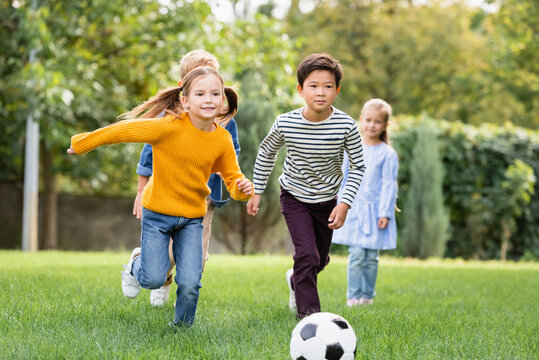

**image caption:**

start   `soccer ball in his yard with blue ball in his hand and running in field of grass in the background and girl in `<br>
**NOTE:**
Though the caption is not that precise but we can tune it easily tuniny hyperparameters and increasing dataset size etc. i didn't run it again with tuning parameters coz i just want to learn it also i want you to learn it the tuning and other necessarry modification will be important when working on real time project.
